In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [36]:
# Импортируем библиотеки

import torch
import torch.nn as nn
import torch.optim as optim
from torch_sparse import SparseTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from keras.regularizers import l1
from genre_recommender import preprocess_popularity, recommend_top_movies_by_genres, show_recommendations, get_all_genres
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.sparse import csr_matrix
import implicit
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.decomposition import NMF, TruncatedSVD
from scipy.sparse import coo_matrix
from tqdm import tqdm
import json
import os
import math
import glob
import dill
import matplotlib.pyplot as plt
import hdbscan
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import psutil
import time
import tracemalloc
import multiprocessing as mp
from sklearn.cluster import DBSCAN
import traceback
import sys
import gc
from sklearn.cluster import SpectralClustering
from multiprocessing import Process, Queue
from sklearn.mixture import GaussianMixture
import joblib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from implicit.nearest_neighbours import bm25_weight
from datetime import datetime
import lightgbm as lgb
import rbo
from matplotlib_venn import venn2
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter, OrderedDict

# 1. Введение
Цель проекта: Построение рекомендательной системы, способной обрабатывать как холодный старт, так и динамическое добавление новых фильмов и пользователей.

# Основные задачи:

1. Холодный старт. Юзер новый и хочет рекомендаций- Юзер выбирает жанр и мы выдаем топ -5 по populatiry (в соответствии с жанром). 
2. Юзер посмотрел несоклько фильмов - подбираем похожий фильм (жанр, и тэги с учетом их весов (relevance)).  Предусмотреть динамическое добавление фильмов
3. Юзер посмотрел несколько фильмов и поставил рейтинг менее 5 раз но больше 0. Или более 5 раз, но положительных (3 и ниже) менее 3. Предусмотреть динамическое добавление фильмов
4. Юзер Поставил рейтинг 5+раз  - подбираем рекомендации ( в соответвии с его рейтингами). Выдаем рекомендации по кластеризированному user-vector. Предусмотреть динамическое добавление пользователей
5. Предусмотреть продвижение/блокировку фильмов.




# 2. Описание методов

Часть 1.

1. Холодный старт. Расчитываем средневзвешенную популярность фильма и выдаем (основная задача 1)
2. Подготовка данных для контента (movies_vector)  
    - Собираем вектор
    - Нормализуем  сохраняя scaler
    - Понижаем размерность сохраняя encoder
    - Создаем модель (KMeans))
4. Создаем функцию рекомендации по кластеризированным данным с выводом расчетных расстояний (для презентационной части)  (основная задача 2)
5. Создаем функцию продвижение/блокировку фильмов (создаем спец датасет с этими данными и фильтруем на этапе выдачи рекомендаций. Блокированные фильмы просто не выдаем. Продвигаемые - выдаем отдельно с пометкой "Специальное предложение!!".)  (основная задача 5)

Часть 2.

6. Создаем матрицу взаимодействий.  
7. с помощью Implicit ALS получаем из матрицы взаимодействий item_factors.
   - обрезаем его по размеру movies_vector(т.к фильмов с тэгами сущетсвено меньше чем фильмов вообще)
8. Объединяем item_factors с movies_vector 
    - Понижаем размерность сохраняя encoder
    - Создаем модель (KMeans))
9. Создаем функцию рекомендации по кластеризированным данным по гибридному вектору с выводом расчетных расстояний (для презентационной части)   (основная задача 3)

10. Создаем функцию динамического добавления фильма:   
    - добавляем фильм в датасет movies
    - добавляем фильм в датасет ratings с нулевым рейтингом
    - формируем вектор фильма для movies
    - формируем вектор фильма для item_factors
    - Объединяем item_factors с movies_vector  для конкретного фильма и
    - Применяем scaler.transform(), пропускаем через encoder.predict(), отправляем в KMeans.predict()

Часть 3.

11. Понижаем размерность матрицы взаимодействий encoder-ом (реалзиованно)
    -  Создаем модель (KMeans)  (реализованно)
    -  Создаем функцию рекомендации по кластеризированным данным с выводом расчетных расстояний (для презентационной части)  (основная задача 5)

12. Создаем функцию динамического добавления пользователя:  
    - добавляем пользователя в датасет ratings 
    - пропускаем через encoder.predict(), отправляем в KMeans.

In [3]:
movies = pd.read_csv('content/films/movies.csv')
ratings = pd.read_csv('content/films/ratings.csv')
tags = pd.read_csv('content/films/tags.csv')
genome_tags = pd.read_csv('content/films/genome-tags.csv')
genome_scores = pd.read_csv('content/films/genome-scores.csv')
importance_df = pd.DataFrame(columns=['movieId', 'importance_score'])

# Проверим размеры
print("movies:", movies.shape)
print("ratings:", ratings.shape)
print("tags:", tags.shape)
print("genome_tags:", genome_tags.shape)
print("genome_scores:", genome_scores.shape)

movies: (86537, 3)
ratings: (33832162, 4)
tags: (2328315, 4)
genome_tags: (1128, 2)
genome_scores: (18472128, 3)


# Часть 1.

## 1. Холодный старт

In [24]:
popularity_df = preprocess_popularity(ratings)

# Непосредственно рекомендации
recommend_top_movies_by_genres("Action", "Adventure", movies_df=movies, popularity_df=popularity_df)

title  \
44066                            Band of Brothers (2001)   
1930         Seven Samurai (Shichinin no samurai) (1954)   
41020                        Over the Garden Wall (2013)   
2867                                   Fight Club (1999)   
82617         Spider-Man: Across the Spider-Verse (2023)   
5509   Spirited Away (Sen to Chihiro no kamikakushi) ...   
55378           Spider-Man: Into the Spider-Verse (2018)   
12221                            Dark Knight, The (2008)   
887                            North by Northwest (1959)   
5905                 City of God (Cidade de Deus) (2002)   

                                          genres  ave_rating  rating_count  \
44066                           Action|Drama|War    4.423986          2835   
1930                      Action|Adventure|Drama    4.250818         17120   
41020                  Adventure|Animation|Drama    4.256993          1430   
2867                 Action|Crime|Drama|Thriller    4.236019         86207   
82617          Action|Adventure|Animation|Sci-Fi    4.252841           528   
5509                 Adventure|Animation|Fantasy    4.226035         35375   
55378          Action|Adventure|Animation|Sci-Fi    4.192053         10885   
12221                    Action|Crime|Drama|IMAX    4.187539         65349   
887    Action|Adventure|Mystery|Romance|Thriller    4.187337         21883   
5905       Action|Adventure|Crime|Drama|Thriller    4.183597         27209   

       weighted_rating  
44066         4.419025  
1930          4.250095  
41020         4.248352  
2867          4.235877  
82617         4.229790  
5509          4.225692  
55378         4.190971  
12221         4.187359  
887           4.186801  
5905          4.183167

## 2. Подготовка данных для контента (movies_vector)

In [157]:
# Преобразуем genome_scores в широкую таблицу: movieId × tagId
movie_tag_matrix = genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

# Добавим к movie_tag_matrix названия тегов
tag_id_to_name = genome_tags.set_index('tagId')['tag']
movie_tag_matrix.columns = movie_tag_matrix.columns.map(tag_id_to_name)

# Проверим результат
print("movie_tag_matrix shape:", movie_tag_matrix.shape)
movie_tag_matrix.head(3)

movie_tag_matrix shape: (16376, 1128)


tagId       007  007 (series)  18th century    1920s    1930s   1950s  \
movieId                                                                 
1        0.0320       0.02225       0.07000  0.05900  0.12300  0.1310   
2        0.0325       0.03200       0.04050  0.05100  0.10050  0.0635   
3        0.0415       0.05525       0.02125  0.07225  0.05125  0.0440   

tagId      1960s    1970s    1980s  19th century  ...  world politics  \
movieId                                           ...                   
1        0.06175  0.19550  0.26625       0.03300  ...         0.04125   
2        0.19825  0.07525  0.09750       0.06325  ...         0.04100   
3        0.03000  0.10375  0.02300       0.03250  ...         0.06175   

tagId    world war i  world war ii  writer's life  writers  writing    wuxia  \
movieId                                                                        
1            0.01550       0.03775        0.03500  0.11525  0.04350  0.04050   
2            0.02025       0.01100        0.01875  0.13425  0.01850  0.01825   
3            0.01825       0.02375        0.01700  0.12400  0.02775  0.01600   

tagId       wwii   zombie  zombies  
movieId                             
1        0.03300  0.07700  0.01825  
2        0.00825  0.08750  0.01375  
3        0.01325  0.10075  0.01800  

[3 rows x 1128 columns]

### Нормализация

In [158]:
scaler = MinMaxScaler()
movie_vectors_scaled = scaler.fit_transform(movie_tag_matrix)

print("Scaled shape:", movie_vectors_scaled.shape)

Scaled shape: (16376, 1128)


### Понижаем размерность 

In [162]:
input_dim = movie_vectors_scaled.shape[1]  # 1128
encoding_dim = 64
batch_size = 256
num_epochs = 20
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразование данных в тензоры
X = torch.tensor(movie_vectors_scaled, dtype=torch.float32)

In [163]:
train_size = int(0.9 * len(X))
val_size = len(X) - train_size
train_dataset, val_dataset = random_split(X, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [164]:
class MovieAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [165]:
model_movies = MovieAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)

In [32]:
optimizer = optim.Adam(model_movies.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model_movies.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        output = model_movies(batch)
        loss = criterion(output, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model_movies.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model_movies(batch)
            loss = criterion(output, batch)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

Epoch [1/20] Train Loss: 0.0471, Val Loss: 0.0281
Epoch [2/20] Train Loss: 0.0273, Val Loss: 0.0269
Epoch [3/20] Train Loss: 0.0218, Val Loss: 0.0150
Epoch [4/20] Train Loss: 0.0138, Val Loss: 0.0130
Epoch [5/20] Train Loss: 0.0122, Val Loss: 0.0118
Epoch [6/20] Train Loss: 0.0116, Val Loss: 0.0114
Epoch [7/20] Train Loss: 0.0112, Val Loss: 0.0109
Epoch [8/20] Train Loss: 0.0103, Val Loss: 0.0097
Epoch [9/20] Train Loss: 0.0094, Val Loss: 0.0092
Epoch [10/20] Train Loss: 0.0090, Val Loss: 0.0088
Epoch [11/20] Train Loss: 0.0086, Val Loss: 0.0085
Epoch [12/20] Train Loss: 0.0083, Val Loss: 0.0082
Epoch [13/20] Train Loss: 0.0080, Val Loss: 0.0079
Epoch [14/20] Train Loss: 0.0077, Val Loss: 0.0077
Epoch [15/20] Train Loss: 0.0075, Val Loss: 0.0074
Epoch [16/20] Train Loss: 0.0072, Val Loss: 0.0071
Epoch [17/20] Train Loss: 0.0069, Val Loss: 0.0069
Epoch [18/20] Train Loss: 0.0067, Val Loss: 0.0066
Epoch [19/20] Train Loss: 0.0064, Val Loss: 0.0064
Epoch [20/20] Train Loss: 0.0063, Val Lo

In [35]:
# os.makedirs('content/films/recomend', exist_ok=True)
# torch.save(model_movies.state_dict(), 'content/films/recomend/movies.pt')

In [17]:
# При загрузке:
model_movies.load_state_dict(torch.load('content/films/recomend/movies.pt'))
model_movies.eval()

/tmp/ipykernel_3467/3315053467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_movies.load_state_dict(torch.load('content/films/recomend/movies.pt'))


MovieAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1128, bias=True)
    (5): Sigmoid()
  )
)

In [33]:
model_movies.eval()  # Переводим в режим инференса

with torch.no_grad():
    movie_vectors_tensor = torch.tensor(movie_vectors_scaled, dtype=torch.float32).to(device)
    movie_content_vectors = model_movies.encoder(movie_vectors_tensor).cpu().numpy()

print("Encoded vectors shape:", movie_content_vectors.shape)  # (16376, 64)

Encoded vectors shape: (16376, 64)


In [34]:
# np.savez_compressed("content/films/recomend/movie_content_vectors.npz", vectors=movie_content_vectors)

In [159]:
data = np.load('content/films/recomend/movie_content_vectors.npz')
movie_content_vectors = data['vectors']

### Делаем кластеризацию

In [15]:
n_clusters = 150
kmeans_movies = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_movies.fit(movie_content_vectors)


KMeans(n_clusters=150, random_state=42)

In [38]:
joblib.dump(kmeans, 'content/films/recomend/kmeans_model.joblib')

['content/films/recomend/kmeans_model.joblib']

In [101]:
# Загружаем
kmeans_movies = joblib.load('content/films/recomend/kmeans_model.joblib')


In [102]:
def recommend_movies_by_cluster_filtered(
    movie_ids,
    movie_content_vectors,
    movies_df,
    kmeans_model,
    top_n=50
):
    cluster_labels = kmeans_model.labels_
    all_recommendations = []

    for movie_id in movie_ids:
        
        original_movie_row = movies[movies['movieId'] == movie_id]
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))

        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")
        
        try:
            movie_idx = movies_df[movies_df['movieId'] == movie_id].index[0]
            movie_title = movies_df.iloc[movie_idx]['title']
            movie_genres = set(movies_df.iloc[movie_idx]['genres'].split('|'))

            cluster_label = cluster_labels[movie_idx]
            same_cluster_indices = np.where(cluster_labels == cluster_label)[0]
            same_cluster_indices = same_cluster_indices[same_cluster_indices != movie_idx]

            if len(same_cluster_indices) == 0:
                continue

            distances = euclidean_distances(
                movie_content_vectors[movie_idx].reshape(1, -1),
                movie_content_vectors[same_cluster_indices]
            )[0]
            similarities = 1 / (1 + distances)

            for idx, score in zip(same_cluster_indices, similarities):
                title = movies_df.iloc[idx]['title']
                genres = movies_df.iloc[idx]['genres']
                genres_set = set(genres.split('|'))

                if pd.isna(title) or pd.isna(genres):
                    continue

                if not movie_genres.intersection(genres_set):
                    score = 0  # Жестко, но ок для фильтрации

                all_recommendations.append({
                    'movie_id': movies_df.iloc[idx]['movieId'],
                    'title': title,
                    'genres': genres,
                    'similarity_score': score
                })
        except IndexError:
            continue

    all_recommendations_df = pd.DataFrame(all_recommendations)
    if all_recommendations_df.empty:
        return all_recommendations_df

    all_recommendations_df = all_recommendations_df.groupby(['movie_id', 'title', 'genres']).agg({'similarity_score': 'sum'}).reset_index()

   
    # Получаем список фильмов, которые нужно заблокировать
    drop_film = importance_df[importance_df['importance_score'] == -1]['movieId']

    # Преобразуем drop_film в числовой тип, 
    drop_film = drop_film.astype(int)  # Если movie_id в final_recs - int
    
    # Удаляем фильмы, которые имеют importance_score == -1
    new_recs = all_recommendations_df[~all_recommendations_df['movie_id'].isin(drop_film)]


    
    all_recommendations_df = new_recs.sort_values('similarity_score', ascending=False).head(top_n)

    weights = np.linspace(20, 1, len(all_recommendations_df)).round()
    all_recommendations_df['weight'] = weights

    temp_list = importance_df[importance_df['importance_score']==1]
    temp_list = temp_list.rename(columns={'movie_id': 'movieId'})
    
    # Выполняем слияние с DataFrame movies
    temp_list = temp_list.merge(
        movies[['movieId', 'title', 'genres']], 
        on='movieId',  
        how='left'
    ).dropna(subset=['title', 'genres'])  # Удаляем строки без названия или жанра
    
    # Выводим горячие новинки
    if len(temp_list) != 0:
        print('Горячие новинки')
        print('-'*50)
        print(temp_list[['movieId', 'title', 'genres']])  

    return all_recommendations_df

### Примеры работы системы рекомендации на простом контентном векторе

In [103]:
recommend_movies= recommend_movies_by_cluster_filtered(
    movie_ids=[1, 10, 100],  
    movie_content_vectors=movie_content_vectors,
    movies_df=movies,
    kmeans_model=kmeans_movies,
    top_n=50
)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


In [39]:
recommend_movies

movie_id                                              title  \
39       2794  European Vacation (aka National Lampoon's Euro...   
45       2881                             Double Jeopardy (1999)   
20       1591                                       Spawn (1997)   
53       3696                         Night of the Creeps (1986)   
85       6695                          Jeepers Creepers 2 (2003)   
67       5378  Star Wars: Episode II - Attack of the Clones (...   
59       4533              Return of the Living Dead, The (1985)   
13       1141                    Last Call (Hoogste tijd) (1995)   
61       4620                                     Lock Up (1989)   
14       1184                                Mediterraneo (1991)   
7         614                                      Loaded (1994)   
5         519                                   RoboCop 3 (1993)   
10       1109    Charm's Incidents (Charms Zwischenfälle) (1996)   
62       4831                        Can't Stop the Music (1980)   
155     53466                                  Nancy Drew (2007)   
47       3083   All About My Mother (Todo sobre mi madre) (1999)   
186     67197                                     Knowing (2009)   
90       7370                            A Foreign Affair (2003)   
82       6641  Code Unknown (Code inconnu: Récit incomplet de...   
112     26750                          Quigley Down Under (1990)   
79       6276                       Wake of the Red Witch (1948)   
159     54910  Behind the Mask: The Rise of Leslie Vernon (2006)   
2         215                              Before Sunrise (1995)   
152     53318                                    Cashback (2006)   
175     60293                               Wackness, The (2008)   
12       1140  Entertaining Angels: The Dorothy Day Story (1996)   
114     27833                                 Silver City (2004)   
89       7362                                Taking Lives (2004)   
109     26347  Irony of Fate, or Enjoy Your Bath! (Ironiya su...   
203     72612                          Fly, The (Légy, A) (1980)   
202     72027                                     Korczak (1990)   
3         227                                   Drop Zone (1994)   
189     68674                        Merry Gentleman, The (2008)   
170     59143                               Super High Me (2007)   
77       6178                            Patch of Blue, A (1965)   
162     56748                           Big Bad Swim, The (2006)   
120     32361                             Come and Get It (1936)   
161     56551                              Treatment, The (2006)   
116     31026                   Phantom of the Opera, The (1989)   
117     32128                                   Blackball (2003)   
64       5085                                Carmen Jones (1954)   
154     53443                          Remember the Night (1940)   
140     47774      Icicle Thief, The (Ladri di saponette) (1989)   
33       2506                           Other Sister, The (1999)   
126     39444                            Weather Man, The (2005)   
25       1820                            Proposition, The (1998)   
52       3472  Horror Hotel (a.k.a. City of the Dead, The) (1...   
173     60225                      Tell It to the Marines (1926)   
205     72733                                    Invictus (2009)   
94       8535                                   De-Lovely (2004)   

                                    genres  similarity_score  weight  
39                Adventure|Comedy|Romance          0.579163    20.0  
45             Action|Crime|Drama|Thriller          0.528087    20.0  
20        Action|Adventure|Sci-Fi|Thriller          0.501275    19.0  
53           Comedy|Horror|Sci-Fi|Thriller          0.488778    19.0  
85                         Horror|Thriller          0.431314    18.0  
67            Action|Adventure|Sci-Fi|IMAX          0.382025    18.0  
59                    Comedy|Horror|Sci

In [18]:
# функция очистки таблицы продвижения/блокировки
def clear_importance_scores(movie_ids_to_promote=None, movie_ids_to_block=None, clear_all=False):
    """
    Очищает importance_df на основе списков фильмов для продвижения и блокировки.
    Если clear_all=True, очищает весь DataFrame.
    """
    global importance_df  # Обращаемся к глобальной переменной importance_df

    if clear_all:
        # Очищаем весь DataFrame
        importance_df = importance_df.iloc[0:0]  # Полностью очищаем DataFrame
        importance_df.reset_index(drop=True, inplace=True)  # Сбрасываем индексы
        return

    if movie_ids_to_promote:
        # Удаляем фильмы, которые были помечены для продвижения
        importance_df = importance_df[~importance_df['movie_id'].isin(movie_ids_to_promote)]

    if movie_ids_to_block:
        # Удаляем фильмы, которые были помечены для блокировки
        importance_df = importance_df[~importance_df['movie_id'].isin(movie_ids_to_block)]

    return importance_df
    

In [19]:
# функция добавления данных в таблицу продвижения/блокировки
def update_importance_scores(movie_ids_to_promote=None, movie_ids_to_block=None):
    """
    Обновляет importance_df на основе списков фильмов для продвижения и блокировки.
    """
    global importance_df

    if 'importance_df' not in globals():
        importance_df = pd.DataFrame(columns=['movieId', 'importance_score'])

    promote_df = pd.DataFrame({
        'movieId': movie_ids_to_promote or [],
        'importance_score': 1
    })

    block_df = pd.DataFrame({
        'movieId': movie_ids_to_block or [],
        'importance_score': -1
    })

    updated = pd.concat([importance_df, promote_df, block_df], ignore_index=True)
    importance_df = (
        updated.drop_duplicates('movieId', keep='last')  # Сохраняем последнюю установку
    )

In [37]:
update_importance_scores(movie_ids_to_promote=[10,100], movie_ids_to_block=[2237, 8658])


# Часть 2

### Создаем матрицу взаимодействий


In [4]:
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'])
joblib.dump(user_encoder, 'user_encoder.pkl')

item_encoder = LabelEncoder()
item_encoder.fit(ratings['movieId'])
joblib.dump(item_encoder, 'item_encoder.pkl')

# Применение энкодеров
user_encoder = joblib.load('user_encoder.pkl')
item_encoder = joblib.load('item_encoder.pkl')

ratings['user_idx'] = user_encoder.transform(ratings['userId'])
ratings['item_idx'] = item_encoder.transform(ratings['movieId'])

In [5]:
print(f"Создаем разреженную матрицу ...")

ratings_coo = coo_matrix(
    (ratings['rating'].astype(float), (ratings['user_idx'], ratings['item_idx']))
)

ratings_csr = ratings_coo.tocsr()  # CSR формат
ratings_csr.shape

Создаем разреженную матрицу ...


(330975, 83239)

### C помощью Implicit ALS получаем из  матрицы взаимодействий item_factors

In [23]:
als_model = AlternatingLeastSquares(factors=64, regularization=0.1, iterations=15)
als_model.fit(ratings_csr.T)
item_factors = als_model.item_factors  # shape: (83239, 64)

/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 2.3359103202819824 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [24]:
# Сохраняем
joblib.dump(als_model, 'content/films/recomend/als_model.joblib')
np.savez_compressed("content/films/recomend/item_factors.npz", vectors=item_factors)

In [155]:
# Загружаем
kmeans_movies = joblib.load('content/films/recomend/als_model.joblib')
data = np.load('content/films/recomend/item_factors.npz')
item_factors = data['vectors']

In [160]:
# movie_tag_matrix.index — это movieId'ы, соответствующие этому вектору
movie_ids_with_tags = movie_tag_matrix.index.to_numpy()

# Получаем индексы этих movieId'ов в item_matrix с помощью item_encoder
item_indices = item_encoder.transform(movie_ids_with_tags)

# Отбираем из item_matrix только нужные строки
filtered_item_matrix = item_factors[item_indices]

# Проверим:
print("Размерность movie_content_vector:", movie_content_vectors.shape)
print("Размерность filtered_item_matrix:", filtered_item_matrix.shape)

# Объединяем по признакам (горизонтально)
hybrid_movie_vector = np.hstack([
    movie_content_vectors,
    filtered_item_matrix
])
print("Размерность объединённого вектора:", hybrid_movie_vector.shape)

Размерность movie_content_vector: (16376, 64)
Размерность filtered_item_matrix: (16376, 64)
Размерность объединённого вектора: (16376, 128)


In [26]:
# Сохраняем
np.savez_compressed("content/films/recomend/hybrid_movie_vector.npz", vectors=hybrid_movie_vector)

In [148]:
# Загружаем
data = np.load('content/films/recomend/hybrid_movie_vector.npz')
hybrid_movie_vector = data['vectors']

### Делаем кластеризацию

In [120]:
n_clusters = 150
kmeans_hibrid = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_hibrid.fit(hybrid_movie_vector.astype(np.float64))

KMeans(n_clusters=150, random_state=42)

### Примеры работы системы рекомендации на простом гибридном векторе

In [121]:
recommend_hybryd_movies= recommend_movies_by_cluster_filtered(
    movie_ids=[1, 10, 100],  
    movie_content_vectors=hybrid_movie_vector,
    movies_df=movies,
    kmeans_model=kmeans_hibrid,
    top_n=50
)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


In [122]:
recommend_hybryd_movies

movie_id                                              title  \
30       2794  European Vacation (aka National Lampoon's Euro...   
34       2881                             Double Jeopardy (1999)   
16       1591                                       Spawn (1997)   
47       3696                         Night of the Creeps (1986)   
66       6695                          Jeepers Creepers 2 (2003)   
51       4533              Return of the Living Dead, The (1985)   
55       5378  Star Wars: Episode II - Attack of the Clones (...   
83      27700                              Evil (Ondskan) (2003)   
100     49085                   Big City, The (Mahanagar) (1963)   
10        614                                      Loaded (1994)   
75      26042                                 Torpedo Run (1958)   
44       3408                             Erin Brockovich (2000)   
71       8366                                      Saved! (2004)   
68       6909              Eye, The (Gin gwai) (Jian gui) (2002)   
50       4056                                 Pledge, The (2001)   
29       2762                            Sixth Sense, The (1999)   
76      26208      My Night At Maud's (Ma Nuit Chez Maud) (1969)   
61       6311                   Other Side of Heaven, The (2001)   
58       5725             Man of Iron (Czlowiek z Zelaza) (1981)   
0          21                                  Get Shorty (1995)   
52       4831                        Can't Stop the Music (1980)   
5         385                     Man of No Importance, A (1994)   
108     53466                                  Nancy Drew (2007)   
126     67197                                     Knowing (2009)   
70       7370                            A Foreign Affair (2003)   
35       2902                                   Psycho II (1983)   
78      26750                          Quigley Down Under (1990)   
131     71280                Wreck of the Mary Deare, The (1959)   
2         142                            Shadows (Cienie) (1988)   
111     54910  Behind the Mask: The Rise of Leslie Vernon (2006)   
24       2413                                        Clue (1985)   
106     53318                                    Cashback (2006)   
143     77326                        Beast, The (La bête) (1975)   
64       6503             Charlie's Angels: Full Throttle (2003)   
77      26347  Irony of Fate, or Enjoy Your Bath! (Ironiya su...   
11        688                        Operation Dumbo Drop (1995)   
136     72612                          Fly, The (Légy, A) (1980)   
115     59143                               Super High Me (2007)   
38       3073                              Sandpiper, The (1965)   
117     59387                                   Fall, The (2006)   
1          80        White Balloon, The (Badkonake sefid) (1995)   
57       5706                          ...All the Marbles (1981)   
84      32128                                   Blackball (2003)   
15       1502                                      Kissed (1996)   
12        926                               All About Eve (1950)   
99      47774      Icicle Thief, The (Ladri di saponette) (1989)   
74      26002                         Confidential Report (1955)   
119     60538                                     Shrooms (2007)   
98      47465                                    Tideland (2005)   
148     79800                         Life During Wartime (2009)   

                                     genres  similarity_score  weight  
30                 Adventure|Comedy|Romance          0.545914    20.0  
34              Action|Crime|Drama|Thriller          0.499874    20.0  
16         Action|Adventure|Sci-Fi|Thriller          0.482000    19.0  
47            Comedy|Horror|Sci-Fi|Thriller          0.463798    19.0  
66                          Horror|Thriller          0.415376    18.0  
51                     Comedy|Horror|Sci-Fi          0.376167    18.0  
55             Action|Adventure|

In [47]:
### Набор метрик для расчета сходства реокмендаций

def precision_at_k(list1, list2, k=5):
    set1 = set(list1[:k])
    set2 = set(list2[:k])
    return len(set1 & set2) / k
    
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return len(set1 & set2) / len(set1 | set2)

# def rbo_score(list1, list2, p=0.9):  # p — параметр затухания
#     return rbo.RankingSimilarity(list1, list2).rbo(p=p)

def intersection_count(list1, list2):
    return len(set(list1) & set(list2))

# Кол-во пересечений
def intersection_count(list1, list2):
    return len(set(list1) & set(list2))

# RBO Score
def rbo_score(list1, list2, p=0.9):
    """Rank-biased overlap (для неполных пересечений в топе)"""
    s, l = sorted((list1, list2), key=len)
    s_set, l_set = set(), set()
    score, weight = 0.0, 1.0

    for i in range(len(l)):
        if i < len(s):
            s_set.add(s[i])
        l_set.add(l[i])
        score += weight * len(s_set & l_set) / (i + 1)
        weight *= p
    return (1 - p) * score

# Top-N Пересечения
def top_n_intersections(list1, list2, top_n=10):
    return [len(set(list1[:i]) & set(list2[:i])) for i in range(1, top_n + 1)]

# Матрица совпадений для heatmap
def build_match_matrix(list1, list2):
    matrix = np.zeros((len(list1), len(list2)))
    for i, l1 in enumerate(list1):
        for j, l2 in enumerate(list2):
            if l1 == l2:
                matrix[i][j] = 1
    return matrix

### Сравниваем рекомендации от простой модели и гибридной

In [42]:
list1 = recommend_hybryd_movies['movie_id'].tolist()
list2 = recommend_movies['movie_id'].tolist()

print("Jaccard Similarity:", jaccard_similarity(list1, list2))
print("Precision@5:", precision_at_k(list1, list2, k=5))
print("Intersection Count:", intersection_count(list1, list2))
print("RBO Score:", rbo_score(list1, list2))

Jaccard Similarity: 0.25
Precision@5: 1.0
Intersection Count: 20
RBO Score: 0.7919132043812733


In [94]:
def visualize_recommendations_df(df1, df2):
    list1 = df1['movie_id'].tolist()
    list2 = df2['movie_id'].tolist()
    
    
    set1 = set(list1)
    set2 = set(list2)
    
    ### Графическое сравнение
    # --- 1. Barplot Top-N Intersections ---
    def top_n_intersections(l1, l2, top_n=20):
        intersection_counts = []
        for n in range(1, top_n + 1):
            top1 = set(l1[:n])
            top2 = set(l2[:n])
            intersection_counts.append(len(top1 & top2))
        return intersection_counts
    
    # --- 3. Rank Biased Overlap ---
    def rbo_score(list1, list2, p=0.9):
        """Наивная реализация RBO."""
        score = 0.0
        depth = min(len(list1), len(list2))
        for d in range(1, depth + 1):
            set1 = set(list1[:d])
            set2 = set(list2[:d])
            overlap = len(set1 & set2)
            score += overlap / d * p ** (d - 1)
        return (1 - p) * score
    
    # --- 4. Heatmap of Position Matches ---
    def build_match_matrix(list1, list2):
        matrix = np.zeros((len(list1), len(list2)))
        for i, id1 in enumerate(list1):
            for j, id2 in enumerate(list2):
                if id1 == id2:
                    matrix[i, j] = 1
        return matrix
    
    # Построение графиков
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Сравнение Рекомендательных Списков", fontsize=16)
    
    # --- Venn Diagram ---
    venn2([set1, set2], set_labels=('Hybrid', 'Base'), ax=axs[0, 0])
    axs[0, 0].set_title("Диаграмма Венна")
    
    # --- Barplot Intersections ---
    intersection_counts = top_n_intersections(list1, list2, top_n=10)
    axs[0, 1].bar(range(1, 11), intersection_counts)
    axs[0, 1].set_title("Пересечения в Top-N")
    axs[0, 1].set_xlabel("Top-N")
    axs[0, 1].set_ylabel("Кол-во общих фильмов")
    
    # --- RBO Score Line ---
    rbo_scores = [rbo_score(list1[:k], list2[:k]) for k in range(1, min(len(list1), len(list2)) + 1)]
    axs[1, 0].plot(range(1, len(rbo_scores)+1), rbo_scores, marker='o')
    axs[1, 0].set_title("RBO по глубине")
    axs[1, 0].set_xlabel("Глубина списка")
    axs[1, 0].set_ylabel("RBO")
    
    # --- Heatmap ---
    match_matrix = build_match_matrix(list1, list2)
    sns.heatmap(match_matrix, cmap='Blues', cbar=False, ax=axs[1, 1],
                xticklabels=list2, yticklabels=list1, linewidths=0.5, linecolor='gray')
    axs[1, 1].set_title("Heatmap Совпадений по Позициям")
    axs[1, 1].set_xlabel("Base Recommend")
    axs[1, 1].set_ylabel("Hybrid Recommend")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

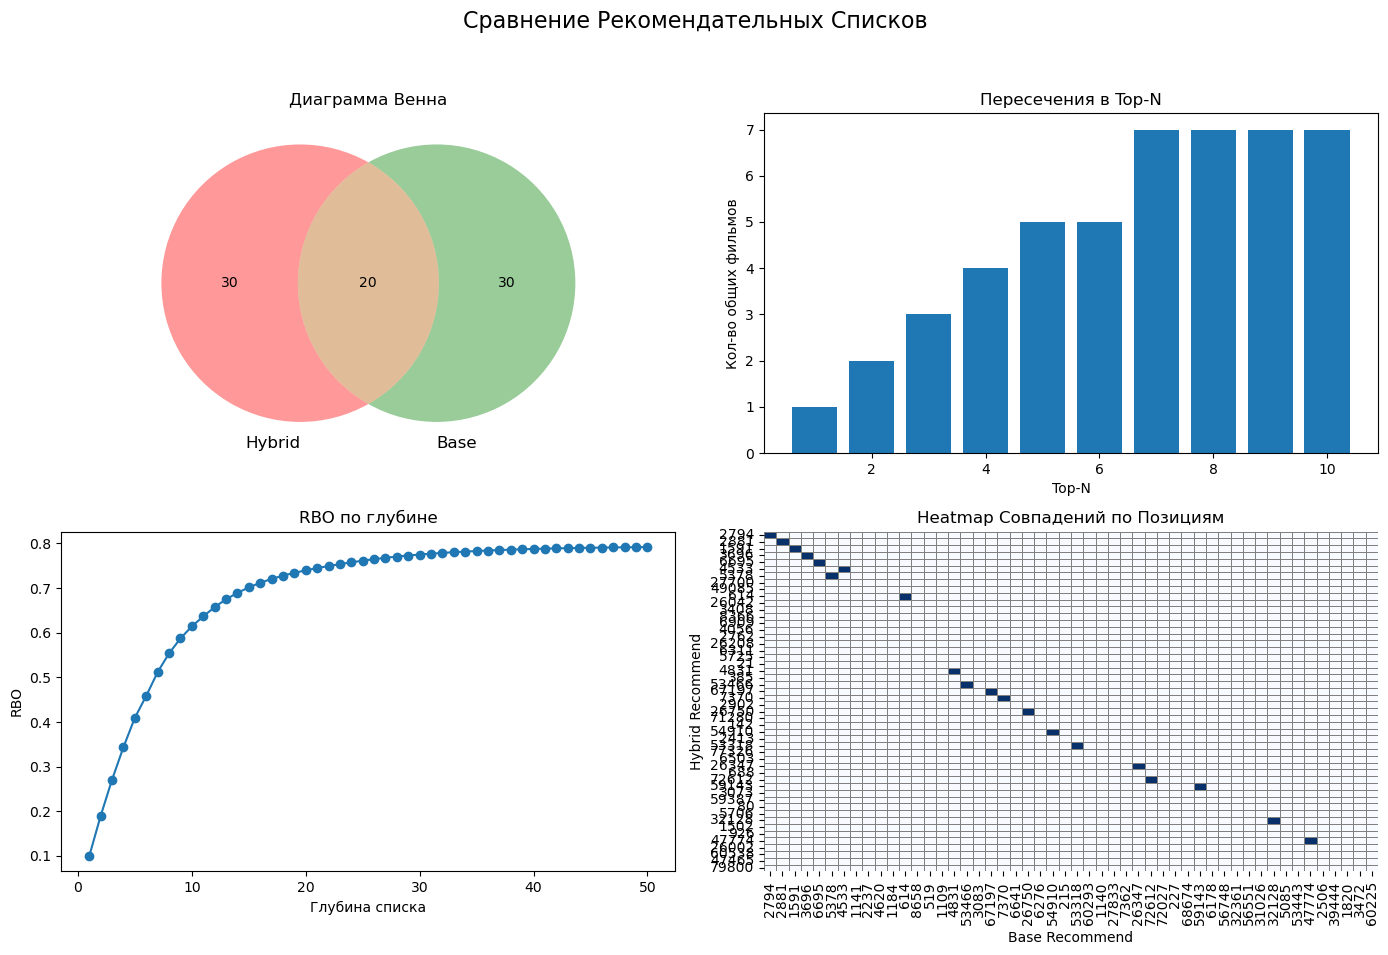

In [105]:
visualize_recommendations_df(recommend_hybryd_movies, recommend_movies)

### Выводы:
- Jaccard: 0.25 → 25% общих фильмов (по movie_id) среди двух списков.
- Precision@5: 1.0 → топ-5 рекомендаций из одного списка полностью попали в другой .
- Intersection Count: 20 → всего 20 фильмов пересеклись.
- RBO (Rank-Biased Overlap): ~0.79 → очень высокая близость по ранжированию. Отличный показатель.

💡 Это значит, что гибридный метод и обычный content-based не сильно расходятся — они хорошо согласуются в рекомендациях. Но при этом у каждого может быть своя "фишка", свои уникальные рекомендации

### Добавление нового фильма к гибридной рекомендательной системе

### Создаем мост  item_factors с movies_vector

In [22]:
models_bridge = []
for i in range(filtered_item_matrix.shape[1]):
    model_bridge = lgb.LGBMRegressor()
    model_bridge.fit(movie_content_vectors, filtered_item_matrix[:, i])
    models_bridge.append(model_bridge)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 16376, number of used features: 30
[LightGBM] [Info] Start training from score 0.003276
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 16376, number of used features: 30
[LightGBM] [Info] Start training from score 0.001429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 16376, number of used features: 30
[LightGBM] [Info] Start tra

KeyboardInterrupt: 

In [23]:
# Функция для предсказания item факторов для нового фильма
def predict_item_factors(content_vector):
    content_vector = content_vector.reshape(1, -1)  # Преобразуем вектор в нужную форму (1, -1)
    return np.array([model_bridge.predict(content_vector)[0] for model_bridge in models_bridge])

In [57]:
# Сохранение
for i, model_bridge in enumerate(models_bridge):
    joblib.dump(model_bridge, f"content/films/recomend/lgb_model_component_{i}.pkl")

In [106]:
# Загрузка
models_bridge = [joblib.load(f"content/films/recomend/lgb_model_component_{i}.pkl") for i in range(64)]  # где num_factors = dim ALS векторов

In [170]:
def add_new_movie_and_predict_cluster(new_movie_id, new_movie_title, new_movie_genres, original_movie_vector, 
                                       movie_tag_matrix, item_encoder, item_factors, models_bridge, 
                                       hybrid_movie_vectors, movies, kmeans_model, model_movies):
    # Преобразуем контентный вектор нового фильма с помощью автоэнкодера
    original_movie_vector_tensor = torch.tensor(original_movie_vector, dtype=torch.float32).to(device)
    encoded_movie_vector = model_movies.encoder(original_movie_vector_tensor).cpu().detach().numpy()
    
    # Предсказание item факторов для нового фильма
    predicted_item_factors = predict_item_factors(encoded_movie_vector)
    
    # Создаем гибридный вектор для нового фильма
    hybrid_vector = np.hstack([encoded_movie_vector, predicted_item_factors])
    
    # Обновляем гибридные векторы
    updated_hybrid_movie_vectors = np.vstack([hybrid_movie_vectors, hybrid_vector])
    
    # Получаем кластер для нового фильма
    new_movie_cluster = kmeans_model.predict([hybrid_vector])[0]

   
    # Создаем новый фильм
    new_movie = {'movieId': new_movie_id, 'title': new_movie_title, 'genres': new_movie_genres}
    
    # Обновляем DataFrame, добавляя новый фильм
    updated_movies_df = pd.concat([movies, pd.DataFrame([new_movie])], ignore_index=True)
    
    return updated_movies_df, updated_hybrid_movie_vectors, new_movie_cluster

In [171]:
# Параметры нового фильма
new_movie_id = 976501
new_movie_title = "Test Night of the Creeps"
new_movie_genres = 'Comedy|Horror|Sci-Fi|Thriller'

# Исходный вектор для нового фильма (например, это вектор для фильма из movie_tag_matrix)
original_movie_vector = movie_tag_matrix.loc[3696].values  # ID фильма, от которого берем вектор



In [172]:
# Вызов функции для добавления нового фильма и получения обновленных данных
updated_movies_df, updated_hybrid_movie_vectors, new_movie_cluster = add_new_movie_and_predict_cluster(
    new_movie_id=new_movie_id,
    new_movie_title=new_movie_title,
    new_movie_genres=new_movie_genres,
    original_movie_vector=original_movie_vector,  # Это должен быть контентный вектор нового фильма
    movie_tag_matrix=movie_tag_matrix,
    item_encoder=item_encoder,
    item_factors=item_factors,
    models_bridge=models_bridge,  # мост для item_factors
    hybrid_movie_vectors=hybrid_movie_vector,
    movies=movies,
    kmeans_model=kmeans_hibrid,  # Кластеризующая модель
    model_movies=model_movies  # Модель автоэнкодера
)

### Пример рекомендаций после добавления нового фильма в базу

In [173]:
recommend_new_movies= recommend_movies_by_cluster_filtered(
    movie_ids=[1, 10, 100],  
    movie_content_vectors=updated_hybrid_movie_vectors,
    movies_df=updated_movies_df,
    kmeans_model=kmeans_hibrid,
    top_n=50
)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


In [174]:
recommend_new_movies

movie_id                                              title  \
30       2794  European Vacation (aka National Lampoon's Euro...   
34       2881                             Double Jeopardy (1999)   
16       1591                                       Spawn (1997)   
47       3696                         Night of the Creeps (1986)   
66       6695                          Jeepers Creepers 2 (2003)   
51       4533              Return of the Living Dead, The (1985)   
55       5378  Star Wars: Episode II - Attack of the Clones (...   
83      27700                              Evil (Ondskan) (2003)   
100     49085                   Big City, The (Mahanagar) (1963)   
10        614                                      Loaded (1994)   
75      26042                                 Torpedo Run (1958)   
44       3408                             Erin Brockovich (2000)   
71       8366                                      Saved! (2004)   
68       6909              Eye, The (Gin gwai) (Jian gui) (2002)   
50       4056                                 Pledge, The (2001)   
29       2762                            Sixth Sense, The (1999)   
76      26208      My Night At Maud's (Ma Nuit Chez Maud) (1969)   
61       6311                   Other Side of Heaven, The (2001)   
58       5725             Man of Iron (Czlowiek z Zelaza) (1981)   
0          21                                  Get Shorty (1995)   
52       4831                        Can't Stop the Music (1980)   
5         385                     Man of No Importance, A (1994)   
108     53466                                  Nancy Drew (2007)   
126     67197                                     Knowing (2009)   
70       7370                            A Foreign Affair (2003)   
35       2902                                   Psycho II (1983)   
78      26750                          Quigley Down Under (1990)   
131     71280                Wreck of the Mary Deare, The (1959)   
2         142                            Shadows (Cienie) (1988)   
111     54910  Behind the Mask: The Rise of Leslie Vernon (2006)   
24       2413                                        Clue (1985)   
106     53318                                    Cashback (2006)   
143     77326                        Beast, The (La bête) (1975)   
64       6503             Charlie's Angels: Full Throttle (2003)   
77      26347  Irony of Fate, or Enjoy Your Bath! (Ironiya su...   
11        688                        Operation Dumbo Drop (1995)   
136     72612                          Fly, The (Légy, A) (1980)   
115     59143                               Super High Me (2007)   
38       3073                              Sandpiper, The (1965)   
117     59387                                   Fall, The (2006)   
1          80        White Balloon, The (Badkonake sefid) (1995)   
57       5706                          ...All the Marbles (1981)   
84      32128                                   Blackball (2003)   
15       1502                                      Kissed (1996)   
12        926                               All About Eve (1950)   
99      47774      Icicle Thief, The (Ladri di saponette) (1989)   
74      26002                         Confidential Report (1955)   
119     60538                                     Shrooms (2007)   
98      47465                                    Tideland (2005)   
148     79800                         Life During Wartime (2009)   

                                     genres  similarity_score  weight  
30                 Adventure|Comedy|Romance          0.545914    20.0  
34              Action|Crime|Drama|Thriller          0.499874    20.0  
16         Action|Adventure|Sci-Fi|Thriller          0.482000    19.0  
47            Comedy|Horror|Sci-Fi|Thriller          0.463798    19.0  
66                          Horror|Thriller          0.415376    18.0  
51                     Comedy|Horror|Sci-Fi          0.376167    18.0  
55             Action|Adventure|

In [184]:
def recommend_movies_by_cluster_filtered_new(
    movie_ids,
    movie_content_vectors,
    movies_df,
    kmeans_model,
    top_n=50
):
    cluster_labels = kmeans_model.labels_
    all_recommendations = []

    for movie_id in movie_ids:
        try:
            movie_row = movies_df[movies_df['movieId'] == movie_id]
            if movie_row.empty:
                print(f"[!] Фильм с ID {movie_id} не найден в базе.")
                continue

            movie_idx = movie_row.index[0]

            # Защита от выхода за границы массива векторов
            if movie_idx >= len(movie_content_vectors):
                movie_idx = len(movie_content_vectors) - 1

            movie_title = movie_row.iloc[0]['title']
            movie_genres = movie_row.iloc[0]['genres']
            genres_set = set(movie_genres.split('|'))

            print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {movie_title}) (Жанры: {movie_genres})")

            # Предсказываем кластер
            cluster_label = kmeans_model.predict([movie_content_vectors[movie_idx]])[0]
            same_cluster_indices = np.where(kmeans_model.labels_ == cluster_label)[0]
            same_cluster_indices = [idx for idx in same_cluster_indices if idx != movie_idx]

            if not same_cluster_indices:
                print(f"[!] Кластер пуст для фильма {movie_id}")
                continue

            distances = euclidean_distances(
                movie_content_vectors[movie_idx].reshape(1, -1),
                movie_content_vectors[same_cluster_indices]
            )[0]
            similarities = 1 / (1 + distances)

            for idx, score in zip(same_cluster_indices, similarities):
                title = movies_df.iloc[idx]['title']
                genres = movies_df.iloc[idx]['genres']
                genres_set_target = set(genres.split('|'))

                if pd.isna(title) or pd.isna(genres):
                    continue

                if not genres_set.intersection(genres_set_target):
                    score = 0  # Фильтрация по жанрам

                all_recommendations.append({
                    'movie_id': movies_df.iloc[idx]['movieId'],
                    'title': title,
                    'genres': genres,
                    'similarity_score': score
                })

        except Exception as e:
            print(f"[!] Ошибка при обработке movie_id={movie_id}: {e}")
            continue

    all_recommendations_df = pd.DataFrame(all_recommendations)
    if all_recommendations_df.empty:
        print("[!] Нет рекомендаций")
        return all_recommendations_df

    # Суммируем по фильмам
    all_recommendations_df = all_recommendations_df.groupby(
        ['movie_id', 'title', 'genres']
    ).agg({'similarity_score': 'sum'}).reset_index()

    # Удаляем заблокированные фильмы
    drop_film = importance_df[importance_df['importance_score'] == -1]['movieId'].astype(int)
    filtered_recs = all_recommendations_df[~all_recommendations_df['movie_id'].isin(drop_film)]

    # Сортировка и веса
    filtered_recs = filtered_recs.sort_values('similarity_score', ascending=False).head(top_n)
    weights = np.linspace(20, 1, len(filtered_recs)).round()
    filtered_recs['weight'] = weights

    # Отображение "горячих новинок"
    temp_list = importance_df[importance_df['importance_score'] == 1].rename(columns={'movie_id': 'movieId'})
    temp_list = temp_list.merge(movies_df[['movieId', 'title', 'genres']], on='movieId', how='left').dropna(subset=['title', 'genres'])

    if len(temp_list) != 0:
        print('Горячие новинки')
        print('-' * 50)
        print(temp_list[['movieId', 'title', 'genres']])

    return filtered_recs

In [189]:
recommend_new_movies = recommend_movies_by_cluster_filtered_new(
    movie_ids=[976501],
    movie_content_vectors=updated_hybrid_movie_vectors,
    movies_df=updated_movies_df,
    kmeans_model=kmeans_hibrid,
    top_n=10
)

Получаем рекомендации для фильма с ID: 976501 (Название: Test Night of the Creeps) (Жанры: Comedy|Horror|Sci-Fi|Thriller)


In [190]:
recommend_new_movies

movie_id                                              title  \
100     71591       Abbott and Costello Meet Captain Kidd (1952)   
27       2591  Jeanne and the Perfect Guy (Jeanne et le garço...   
24       2381        Police Academy 4: Citizens on Patrol (1987)   
80      34540                           Pretty Persuasion (2005)   
39       4415                Cheech & Chong's Nice Dreams (1981)   
38       4381                   Closet, The (Placard, Le) (2001)   
83      37982                                    Madhouse (2004)   
36       4027                  O Brother, Where Art Thou? (2000)   
52       6097                              Manhattan Baby (1982)   
66       8610                                   All of Me (1984)   

                       genres  similarity_score  weight  
100  Adventure|Comedy|Musical          0.182656    20.0  
27       Comedy|Drama|Romance          0.165734    18.0  
24               Comedy|Crime          0.164512    16.0  
80               Comedy|Drama          0.162239    14.0  
39                     Comedy          0.161068    12.0  
38                     Comedy          0.160610     9.0  
83            Horror|Thriller          0.159091     7.0  
36     Adventure|Comedy|Crime          0.158070     5.0  
52                     Horror          0.157971     3.0  
66             Comedy|Fantasy          0.156814     1.0

In [191]:
# Сравнение вектора нового фильма с тем тчо мы хотели изначально
# Гибридный вектор нового фильма (последняя строка в массиве)
new_hybrid_vector_test = updated_hybrid_movie_vectors[-1].reshape(1, -1)

# Индекс оригинального фильма (3696) в movie_tag_matrix соответствует какому индексу в hybrid_movie_vectors?
# Мы знаем, что гибридные векторы строились по movie_tag_matrix.index
original_index_test = movie_tag_matrix.index.get_loc(3696)
original_hybrid_vector_test = hybrid_movie_vector[original_index_test].reshape(1, -1)

# Вычисляем косинусное сходство
similarity_score = cosine_similarity(new_hybrid_vector_test, original_hybrid_vector_test)[0][0]
similarity_score

0.15927623281439302

### Вывод: Рекомендации работает для нового фильма. А то что он не выдался (как мы хотели) в общей выдачи связано с тем что нам не удалось создать похожий вектор для попадания в список similarity_score = 0.15927623281439302

# Часть 3.

### Понижаем размерность матрицы взаимодействий encoder-ом

In [26]:
# Проверка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используется устройство:", device)

Используется устройство: cuda


In [27]:
# Dataset
class SparseRowDataset(Dataset):
    def __init__(self, sparse_matrix):
        self.matrix = sparse_matrix

    def __len__(self):
        return self.matrix.shape[0]

    def __getitem__(self, idx):
        row = self.matrix.getrow(idx).toarray().squeeze()
        return torch.tensor(row, dtype=torch.float32)


In [28]:
# Модель
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [29]:
# Параметры
input_dim = ratings_csr.shape[1]  # 83239
encoding_dim = 64
batch_size = 16   # Меньше — стабильнее
num_epochs = 10
lr = 1e-3

# DataLoader
dataset = SparseRowDataset(ratings_csr)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Инициализация модели и оптимизатора
model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [18]:
# Обучение
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    start_epoch = time.time()

    for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        batch = batch.to(device)

        t1 = time.time()
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if i % 50 == 0:
            print(f"[{i}/{len(dataloader)}] loss={loss.item():.4f}, time/batch={time.time() - t1:.2f}s")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} завершён за {time.time() - start_epoch:.1f} сек. Средний loss: {avg_loss:.4f}")


Epoch 1/10:   0%|                                                                                                                                                                                                                                                               | 3/20686 [00:02<3:57:51,  1.45it/s]

[0/20686] loss=0.2577, time/batch=2.37s


Epoch 1/10:   0%|▋                                                                                                                                                                                                                                                               | 54/20686 [00:04<16:04, 21.40it/s]

[50/20686] loss=0.0100, time/batch=0.04s


Epoch 1/10:   1%|█▎                                                                                                                                                                                                                                                             | 105/20686 [00:07<15:49, 21.67it/s]

[100/20686] loss=0.0128, time/batch=0.04s


Epoch 1/10:   1%|█▉                                                                                                                                                                                                                                                             | 153/20686 [00:09<15:50, 21.60it/s]

[150/20686] loss=0.0232, time/batch=0.04s


Epoch 1/10:   1%|██▌                                                                                                                                                                                                                                                            | 203/20686 [00:11<15:48, 21.58it/s]

[200/20686] loss=0.0181, time/batch=0.04s


Epoch 1/10:   1%|███▏                                                                                                                                                                                                                                                           | 254/20686 [00:14<16:19, 20.85it/s]

[250/20686] loss=0.0178, time/batch=0.04s


Epoch 1/10:   1%|███▊                                                                                                                                                                                                                                                           | 305/20686 [00:16<15:37, 21.74it/s]

[300/20686] loss=0.0132, time/batch=0.04s


Epoch 1/10:   2%|████▎                                                                                                                                                                                                                                                          | 353/20686 [00:18<14:42, 23.03it/s]

[350/20686] loss=0.0190, time/batch=0.04s


Epoch 1/10:   2%|████▉                                                                                                                                                                                                                                                          | 404/20686 [00:21<14:25, 23.44it/s]

[400/20686] loss=0.0206, time/batch=0.03s


Epoch 1/10:   2%|█████▌                                                                                                                                                                                                                                                         | 455/20686 [00:23<17:04, 19.75it/s]

[450/20686] loss=0.0168, time/batch=0.05s


Epoch 1/10:   2%|██████▏                                                                                                                                                                                                                                                        | 503/20686 [00:25<15:51, 21.20it/s]

[500/20686] loss=0.0073, time/batch=0.04s


Epoch 1/10:   3%|██████▊                                                                                                                                                                                                                                                        | 554/20686 [00:28<15:25, 21.75it/s]

[550/20686] loss=0.0214, time/batch=0.04s


Epoch 1/10:   3%|███████▍                                                                                                                                                                                                                                                       | 605/20686 [00:30<15:14, 21.96it/s]

[600/20686] loss=0.0163, time/batch=0.04s


Epoch 1/10:   3%|████████                                                                                                                                                                                                                                                       | 653/20686 [00:32<15:46, 21.16it/s]

[650/20686] loss=0.0162, time/batch=0.04s


Epoch 1/10:   3%|████████▋                                                                                                                                                                                                                                                      | 704/20686 [00:35<16:07, 20.65it/s]

[700/20686] loss=0.0174, time/batch=0.04s


Epoch 1/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 755/20686 [00:37<15:18, 21.70it/s]

[750/20686] loss=0.0132, time/batch=0.04s


Epoch 1/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 805/20686 [00:39<14:52, 22.28it/s]

[800/20686] loss=0.0182, time/batch=0.03s


Epoch 1/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 853/20686 [00:42<15:07, 21.86it/s]

[850/20686] loss=0.0127, time/batch=0.04s


Epoch 1/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 904/20686 [00:44<15:05, 21.84it/s]

[900/20686] loss=0.0125, time/batch=0.04s


Epoch 1/10:   5%|███████████▊                                                                                                                                                                                                                                                   | 955/20686 [00:46<15:11, 21.66it/s]

[950/20686] loss=0.0213, time/batch=0.04s


Epoch 1/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1003/20686 [00:48<15:02, 21.82it/s]

[1000/20686] loss=0.0142, time/batch=0.04s


Epoch 1/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1054/20686 [00:51<15:21, 21.31it/s]

[1050/20686] loss=0.0232, time/batch=0.04s


Epoch 1/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1105/20686 [00:53<14:53, 21.93it/s]

[1100/20686] loss=0.0098, time/batch=0.04s


Epoch 1/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1153/20686 [00:55<14:57, 21.77it/s]

[1150/20686] loss=0.0231, time/batch=0.04s


Epoch 1/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1204/20686 [00:58<14:28, 22.43it/s]

[1200/20686] loss=0.0160, time/batch=0.04s


Epoch 1/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1255/20686 [01:00<14:06, 22.95it/s]

[1250/20686] loss=0.0188, time/batch=0.04s


Epoch 1/10:   6%|███████████████▉                                                                                                                                                                                                                                              | 1303/20686 [01:02<14:37, 22.10it/s]

[1300/20686] loss=0.0159, time/batch=0.04s


Epoch 1/10:   7%|████████████████▋                                                                                                                                                                                                                                             | 1354/20686 [01:04<14:58, 21.52it/s]

[1350/20686] loss=0.0175, time/batch=0.04s


Epoch 1/10:   7%|█████████████████▎                                                                                                                                                                                                                                            | 1405/20686 [01:07<14:52, 21.60it/s]

[1400/20686] loss=0.0159, time/batch=0.04s


Epoch 1/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1453/20686 [01:09<14:44, 21.75it/s]

[1450/20686] loss=0.0230, time/batch=0.04s


Epoch 1/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1504/20686 [01:11<14:50, 21.55it/s]

[1500/20686] loss=0.0115, time/batch=0.04s


Epoch 1/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1555/20686 [01:14<15:05, 21.12it/s]

[1550/20686] loss=0.0095, time/batch=0.04s


Epoch 1/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1603/20686 [01:16<15:11, 20.93it/s]

[1600/20686] loss=0.0141, time/batch=0.04s


Epoch 1/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1654/20686 [01:18<13:42, 23.13it/s]

[1650/20686] loss=0.0149, time/batch=0.03s


Epoch 1/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1705/20686 [01:20<13:20, 23.70it/s]

[1700/20686] loss=0.0143, time/batch=0.03s


Epoch 1/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1753/20686 [01:22<14:17, 22.08it/s]

[1750/20686] loss=0.0184, time/batch=0.04s


Epoch 1/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1804/20686 [01:25<14:29, 21.72it/s]

[1800/20686] loss=0.0104, time/batch=0.04s


Epoch 1/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1855/20686 [01:27<14:19, 21.91it/s]

[1850/20686] loss=0.0120, time/batch=0.04s


Epoch 1/10:   9%|███████████████████████▎                                                                                                                                                                                                                                      | 1903/20686 [01:29<14:11, 22.05it/s]

[1900/20686] loss=0.0112, time/batch=0.04s


Epoch 1/10:   9%|███████████████████████▉                                                                                                                                                                                                                                      | 1954/20686 [01:32<14:03, 22.20it/s]

[1950/20686] loss=0.0245, time/batch=0.04s


Epoch 1/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2005/20686 [01:34<14:11, 21.93it/s]

[2000/20686] loss=0.0164, time/batch=0.04s


Epoch 1/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2053/20686 [01:36<14:09, 21.93it/s]

[2050/20686] loss=0.0213, time/batch=0.04s


Epoch 1/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2104/20686 [01:38<13:35, 22.78it/s]

[2100/20686] loss=0.0269, time/batch=0.04s


Epoch 1/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2155/20686 [01:41<13:55, 22.19it/s]

[2150/20686] loss=0.0140, time/batch=0.04s


Epoch 1/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2203/20686 [01:43<14:08, 21.77it/s]

[2200/20686] loss=0.0209, time/batch=0.04s


Epoch 1/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2254/20686 [01:45<14:55, 20.58it/s]

[2250/20686] loss=0.0095, time/batch=0.04s


Epoch 1/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2305/20686 [01:48<14:08, 21.67it/s]

[2300/20686] loss=0.0207, time/batch=0.04s


Epoch 1/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2353/20686 [01:50<14:03, 21.74it/s]

[2350/20686] loss=0.0181, time/batch=0.04s


Epoch 1/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2404/20686 [01:52<13:57, 21.82it/s]

[2400/20686] loss=0.0106, time/batch=0.04s


Epoch 1/10:  12%|██████████████████████████████▏                                                                                                                                                                                                                               | 2455/20686 [01:54<14:03, 21.62it/s]

[2450/20686] loss=0.0100, time/batch=0.04s


Epoch 1/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2503/20686 [01:57<13:43, 22.09it/s]

[2500/20686] loss=0.0093, time/batch=0.04s


Epoch 1/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2554/20686 [01:59<12:59, 23.25it/s]

[2550/20686] loss=0.0099, time/batch=0.03s


Epoch 1/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2605/20686 [02:01<13:24, 22.47it/s]

[2600/20686] loss=0.0127, time/batch=0.04s


Epoch 1/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2653/20686 [02:03<13:50, 21.72it/s]

[2650/20686] loss=0.0265, time/batch=0.04s


Epoch 1/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2704/20686 [02:06<13:38, 21.98it/s]

[2700/20686] loss=0.0166, time/batch=0.04s


Epoch 1/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2755/20686 [02:08<13:31, 22.08it/s]

[2750/20686] loss=0.0146, time/batch=0.04s


Epoch 1/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2803/20686 [02:10<14:03, 21.20it/s]

[2800/20686] loss=0.0174, time/batch=0.04s


Epoch 1/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2854/20686 [02:12<13:42, 21.69it/s]

[2850/20686] loss=0.0157, time/batch=0.04s


Epoch 1/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2903/20686 [02:15<14:43, 20.12it/s]

[2900/20686] loss=0.0201, time/batch=0.04s


Epoch 1/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2954/20686 [02:17<13:36, 21.73it/s]

[2950/20686] loss=0.0181, time/batch=0.04s


Epoch 1/10:  15%|████████████████████████████████████▉                                                                                                                                                                                                                         | 3005/20686 [02:19<12:23, 23.79it/s]

[3000/20686] loss=0.0105, time/batch=0.03s


Epoch 1/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3053/20686 [02:21<12:38, 23.25it/s]

[3050/20686] loss=0.0173, time/batch=0.03s


Epoch 1/10:  15%|██████████████████████████████████████                                                                                                                                                                                                                        | 3104/20686 [02:24<13:16, 22.08it/s]

[3100/20686] loss=0.0101, time/batch=0.04s


Epoch 1/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3155/20686 [02:26<13:17, 21.97it/s]

[3150/20686] loss=0.0102, time/batch=0.04s


Epoch 1/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3203/20686 [02:28<13:02, 22.33it/s]

[3200/20686] loss=0.0202, time/batch=0.04s


Epoch 1/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3254/20686 [02:31<13:16, 21.87it/s]

[3250/20686] loss=0.0107, time/batch=0.04s


Epoch 1/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3305/20686 [02:33<12:57, 22.35it/s]

[3300/20686] loss=0.0074, time/batch=0.04s


Epoch 1/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3353/20686 [02:35<13:17, 21.73it/s]

[3350/20686] loss=0.0348, time/batch=0.04s


Epoch 1/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3404/20686 [02:37<13:29, 21.35it/s]

[3400/20686] loss=0.0116, time/batch=0.04s


Epoch 1/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3455/20686 [02:40<12:38, 22.70it/s]

[3450/20686] loss=0.0162, time/batch=0.04s


Epoch 1/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3503/20686 [02:42<13:09, 21.76it/s]

[3500/20686] loss=0.0119, time/batch=0.04s


Epoch 1/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3553/20686 [02:45<17:50, 16.00it/s]

[3550/20686] loss=0.0234, time/batch=0.05s


Epoch 1/10:  17%|████████████████████████████████████████████▏                                                                                                                                                                                                                 | 3603/20686 [02:48<17:51, 15.95it/s]

[3600/20686] loss=0.0156, time/batch=0.05s


Epoch 1/10:  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                 | 3653/20686 [02:51<17:22, 16.33it/s]

[3650/20686] loss=0.0102, time/batch=0.05s


Epoch 1/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3704/20686 [02:54<17:03, 16.59it/s]

[3700/20686] loss=0.0061, time/batch=0.05s


Epoch 1/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3754/20686 [02:57<16:40, 16.92it/s]

[3750/20686] loss=0.0211, time/batch=0.05s


Epoch 1/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3805/20686 [02:59<11:47, 23.87it/s]

[3800/20686] loss=0.0117, time/batch=0.04s


Epoch 1/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3853/20686 [03:02<11:58, 23.43it/s]

[3850/20686] loss=0.0165, time/batch=0.03s


Epoch 1/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3903/20686 [03:04<15:40, 17.85it/s]

[3900/20686] loss=0.0137, time/batch=0.05s


Epoch 1/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3953/20686 [03:06<12:37, 22.08it/s]

[3950/20686] loss=0.0148, time/batch=0.04s


Epoch 1/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4004/20686 [03:09<13:10, 21.11it/s]

[4000/20686] loss=0.0324, time/batch=0.04s


Epoch 1/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4055/20686 [03:11<12:44, 21.76it/s]

[4050/20686] loss=0.0080, time/batch=0.04s


Epoch 1/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4103/20686 [03:14<15:12, 18.18it/s]

[4100/20686] loss=0.0093, time/batch=0.05s


Epoch 1/10:  20%|███████████████████████████████████████████████████                                                                                                                                                                                                           | 4154/20686 [03:16<12:36, 21.85it/s]

[4150/20686] loss=0.0123, time/batch=0.04s


Epoch 1/10:  20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                          | 4204/20686 [03:18<14:41, 18.71it/s]

[4200/20686] loss=0.0175, time/batch=0.05s


Epoch 1/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4254/20686 [03:20<11:53, 23.03it/s]

[4250/20686] loss=0.0250, time/batch=0.03s


Epoch 1/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4302/20686 [03:23<13:15, 20.58it/s]

[4300/20686] loss=0.0130, time/batch=0.04s


Epoch 1/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4355/20686 [03:25<12:28, 21.80it/s]

[4350/20686] loss=0.0206, time/batch=0.04s


Epoch 1/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4403/20686 [03:27<12:22, 21.93it/s]

[4400/20686] loss=0.0136, time/batch=0.04s


Epoch 1/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4454/20686 [03:30<12:49, 21.09it/s]

[4450/20686] loss=0.0261, time/batch=0.05s


Epoch 1/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4505/20686 [03:32<12:40, 21.29it/s]

[4500/20686] loss=0.0092, time/batch=0.04s


Epoch 1/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4553/20686 [03:34<12:59, 20.69it/s]

[4550/20686] loss=0.0318, time/batch=0.05s


Epoch 1/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4604/20686 [03:37<12:06, 22.13it/s]

[4600/20686] loss=0.0058, time/batch=0.04s


Epoch 1/10:  23%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4655/20686 [03:39<11:18, 23.62it/s]

[4650/20686] loss=0.0089, time/batch=0.03s


Epoch 1/10:  23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 4703/20686 [03:41<11:59, 22.20it/s]

[4700/20686] loss=0.0197, time/batch=0.04s


Epoch 1/10:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 4754/20686 [03:43<12:10, 21.80it/s]

[4750/20686] loss=0.0259, time/batch=0.04s


Epoch 1/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4805/20686 [03:46<12:15, 21.59it/s]

[4800/20686] loss=0.0104, time/batch=0.04s


Epoch 1/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4853/20686 [03:48<11:52, 22.21it/s]

[4850/20686] loss=0.0112, time/batch=0.04s


Epoch 1/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4904/20686 [03:50<11:47, 22.32it/s]

[4900/20686] loss=0.0187, time/batch=0.04s


Epoch 1/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4955/20686 [03:53<11:52, 22.07it/s]

[4950/20686] loss=0.0231, time/batch=0.04s


Epoch 1/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5003/20686 [03:55<11:45, 22.22it/s]

[5000/20686] loss=0.0111, time/batch=0.04s


Epoch 1/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5054/20686 [03:57<11:44, 22.20it/s]

[5050/20686] loss=0.0084, time/batch=0.04s


Epoch 1/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5105/20686 [03:59<10:37, 24.42it/s]

[5100/20686] loss=0.0283, time/batch=0.03s


Epoch 1/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5153/20686 [04:01<11:19, 22.85it/s]

[5150/20686] loss=0.0161, time/batch=0.03s


Epoch 1/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5204/20686 [04:04<11:45, 21.94it/s]

[5200/20686] loss=0.0150, time/batch=0.04s


Epoch 1/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5255/20686 [04:06<11:41, 22.00it/s]

[5250/20686] loss=0.0123, time/batch=0.04s


Epoch 1/10:  26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 5303/20686 [04:08<11:35, 22.11it/s]

[5300/20686] loss=0.0090, time/batch=0.04s


Epoch 1/10:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 5354/20686 [04:10<11:34, 22.08it/s]

[5350/20686] loss=0.0222, time/batch=0.04s


Epoch 1/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5405/20686 [04:13<11:38, 21.89it/s]

[5400/20686] loss=0.0106, time/batch=0.04s


Epoch 1/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5453/20686 [04:15<11:15, 22.56it/s]

[5450/20686] loss=0.0195, time/batch=0.04s


Epoch 1/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5504/20686 [04:17<11:20, 22.32it/s]

[5500/20686] loss=0.0243, time/batch=0.04s


Epoch 1/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5555/20686 [04:19<10:14, 24.62it/s]

[5550/20686] loss=0.0136, time/batch=0.03s


Epoch 1/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5603/20686 [04:21<10:37, 23.65it/s]

[5600/20686] loss=0.0236, time/batch=0.03s


Epoch 1/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5654/20686 [04:24<11:17, 22.17it/s]

[5650/20686] loss=0.0290, time/batch=0.04s


Epoch 1/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5705/20686 [04:26<11:09, 22.37it/s]

[5700/20686] loss=0.0122, time/batch=0.04s


Epoch 1/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5753/20686 [04:28<11:13, 22.17it/s]

[5750/20686] loss=0.0106, time/batch=0.04s


Epoch 1/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5804/20686 [04:30<11:06, 22.32it/s]

[5800/20686] loss=0.0190, time/batch=0.04s


Epoch 1/10:  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5855/20686 [04:33<11:15, 21.95it/s]

[5850/20686] loss=0.0155, time/batch=0.04s


Epoch 1/10:  29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 5903/20686 [04:35<11:08, 22.11it/s]

[5900/20686] loss=0.0156, time/batch=0.04s


Epoch 1/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5954/20686 [04:37<11:05, 22.15it/s]

[5950/20686] loss=0.0099, time/batch=0.04s


Epoch 1/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6005/20686 [04:39<10:44, 22.79it/s]

[6000/20686] loss=0.0352, time/batch=0.04s


Epoch 1/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6053/20686 [04:42<11:04, 22.03it/s]

[6050/20686] loss=0.0174, time/batch=0.04s


Epoch 1/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6104/20686 [04:44<11:13, 21.64it/s]

[6100/20686] loss=0.0151, time/batch=0.04s


Epoch 1/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6155/20686 [04:46<11:10, 21.68it/s]

[6150/20686] loss=0.0125, time/batch=0.04s


Epoch 1/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6203/20686 [04:49<10:58, 21.99it/s]

[6200/20686] loss=0.0083, time/batch=0.04s


Epoch 1/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6254/20686 [04:51<10:55, 22.03it/s]

[6250/20686] loss=0.0187, time/batch=0.04s


Epoch 1/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6305/20686 [04:53<11:09, 21.47it/s]

[6300/20686] loss=0.0084, time/batch=0.04s


Epoch 1/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6353/20686 [04:55<11:01, 21.66it/s]

[6350/20686] loss=0.0095, time/batch=0.04s


Epoch 1/10:  31%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 6404/20686 [04:58<10:39, 22.34it/s]

[6400/20686] loss=0.0447, time/batch=0.03s


Epoch 1/10:  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 6455/20686 [05:00<09:46, 24.27it/s]

[6450/20686] loss=0.0111, time/batch=0.03s


Epoch 1/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6503/20686 [05:02<10:27, 22.61it/s]

[6500/20686] loss=0.0073, time/batch=0.04s


Epoch 1/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6554/20686 [05:04<10:42, 22.00it/s]

[6550/20686] loss=0.0208, time/batch=0.04s


Epoch 1/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6605/20686 [05:07<10:32, 22.26it/s]

[6600/20686] loss=0.0111, time/batch=0.04s


Epoch 1/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6653/20686 [05:09<10:28, 22.33it/s]

[6650/20686] loss=0.0063, time/batch=0.04s


Epoch 1/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6704/20686 [05:11<10:58, 21.25it/s]

[6700/20686] loss=0.0182, time/batch=0.04s


Epoch 1/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6755/20686 [05:14<10:49, 21.46it/s]

[6750/20686] loss=0.0148, time/batch=0.04s


Epoch 1/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6803/20686 [05:16<10:20, 22.36it/s]

[6800/20686] loss=0.0142, time/batch=0.04s


Epoch 1/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6854/20686 [05:18<09:46, 23.57it/s]

[6850/20686] loss=0.0088, time/batch=0.03s


Epoch 1/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6905/20686 [05:20<09:33, 24.03it/s]

[6900/20686] loss=0.0177, time/batch=0.03s


Epoch 1/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 6953/20686 [05:22<10:15, 22.32it/s]

[6950/20686] loss=0.0135, time/batch=0.04s


Epoch 1/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7004/20686 [05:25<10:26, 21.82it/s]

[7000/20686] loss=0.0234, time/batch=0.04s


Epoch 1/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 7055/20686 [05:27<10:09, 22.37it/s]

[7050/20686] loss=0.0242, time/batch=0.04s


Epoch 1/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7103/20686 [05:29<10:14, 22.10it/s]

[7100/20686] loss=0.0174, time/batch=0.04s


Epoch 1/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7154/20686 [05:31<10:24, 21.65it/s]

[7150/20686] loss=0.0041, time/batch=0.04s


Epoch 1/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7205/20686 [05:34<10:22, 21.66it/s]

[7200/20686] loss=0.0206, time/batch=0.04s


Epoch 1/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7253/20686 [05:36<10:08, 22.06it/s]

[7250/20686] loss=0.0072, time/batch=0.04s


Epoch 1/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7304/20686 [05:38<09:29, 23.49it/s]

[7300/20686] loss=0.0099, time/batch=0.03s


Epoch 1/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7355/20686 [05:40<09:47, 22.70it/s]

[7350/20686] loss=0.0057, time/batch=0.04s


Epoch 1/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7403/20686 [05:43<10:13, 21.63it/s]

[7400/20686] loss=0.0110, time/batch=0.04s


Epoch 1/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7454/20686 [05:45<10:07, 21.79it/s]

[7450/20686] loss=0.0085, time/batch=0.04s


Epoch 1/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7505/20686 [05:47<10:03, 21.85it/s]

[7500/20686] loss=0.0065, time/batch=0.04s


Epoch 1/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 7553/20686 [05:49<09:47, 22.36it/s]

[7550/20686] loss=0.0203, time/batch=0.04s


Epoch 1/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 7604/20686 [05:52<09:50, 22.14it/s]

[7600/20686] loss=0.0159, time/batch=0.04s


Epoch 1/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7655/20686 [05:54<09:50, 22.08it/s]

[7650/20686] loss=0.0377, time/batch=0.04s


Epoch 1/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7703/20686 [05:56<09:47, 22.09it/s]

[7700/20686] loss=0.0163, time/batch=0.04s


Epoch 1/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7754/20686 [05:59<09:27, 22.78it/s]

[7750/20686] loss=0.0237, time/batch=0.04s


Epoch 1/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7805/20686 [06:01<08:44, 24.54it/s]

[7800/20686] loss=0.0158, time/batch=0.03s


Epoch 1/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7853/20686 [06:03<09:34, 22.36it/s]

[7850/20686] loss=0.0115, time/batch=0.04s


Epoch 1/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7904/20686 [06:05<09:40, 22.02it/s]

[7900/20686] loss=0.0151, time/batch=0.04s


Epoch 1/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7955/20686 [06:07<09:27, 22.42it/s]

[7950/20686] loss=0.0123, time/batch=0.04s


Epoch 1/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8003/20686 [06:10<09:34, 22.08it/s]

[8000/20686] loss=0.0102, time/batch=0.04s


Epoch 1/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8054/20686 [06:12<09:41, 21.73it/s]

[8050/20686] loss=0.0288, time/batch=0.04s


Epoch 1/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 8105/20686 [06:14<09:36, 21.83it/s]

[8100/20686] loss=0.0174, time/batch=0.04s


Epoch 1/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 8153/20686 [06:16<09:39, 21.62it/s]

[8150/20686] loss=0.0139, time/batch=0.04s


Epoch 1/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8204/20686 [06:19<08:59, 23.13it/s]

[8200/20686] loss=0.0339, time/batch=0.04s


Epoch 1/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8255/20686 [06:21<08:37, 24.02it/s]

[8250/20686] loss=0.0096, time/batch=0.03s


Epoch 1/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8303/20686 [06:23<09:08, 22.56it/s]

[8300/20686] loss=0.0129, time/batch=0.04s


Epoch 1/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8354/20686 [06:25<09:09, 22.43it/s]

[8350/20686] loss=0.0212, time/batch=0.04s


Epoch 1/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8405/20686 [06:28<09:17, 22.02it/s]

[8400/20686] loss=0.0104, time/batch=0.04s


Epoch 1/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8453/20686 [06:30<09:14, 22.05it/s]

[8450/20686] loss=0.0163, time/batch=0.04s


Epoch 1/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8504/20686 [06:32<09:13, 21.99it/s]

[8500/20686] loss=0.0220, time/batch=0.04s


Epoch 1/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8555/20686 [06:34<09:07, 22.16it/s]

[8550/20686] loss=0.0079, time/batch=0.04s


Epoch 1/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8603/20686 [06:37<09:12, 21.89it/s]

[8600/20686] loss=0.0119, time/batch=0.04s


Epoch 1/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 8654/20686 [06:39<08:49, 22.71it/s]

[8650/20686] loss=0.0093, time/batch=0.04s


Epoch 1/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 8705/20686 [06:41<08:49, 22.63it/s]

[8700/20686] loss=0.0158, time/batch=0.04s


Epoch 1/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8753/20686 [06:43<09:15, 21.49it/s]

[8750/20686] loss=0.0217, time/batch=0.04s


Epoch 1/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8804/20686 [06:46<09:11, 21.54it/s]

[8800/20686] loss=0.0260, time/batch=0.04s


Epoch 1/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8855/20686 [06:48<09:04, 21.74it/s]

[8850/20686] loss=0.0116, time/batch=0.04s


Epoch 1/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8903/20686 [06:50<08:53, 22.09it/s]

[8900/20686] loss=0.0074, time/batch=0.04s


Epoch 1/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8954/20686 [06:52<08:54, 21.94it/s]

[8950/20686] loss=0.0299, time/batch=0.04s


Epoch 1/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9005/20686 [06:55<09:04, 21.44it/s]

[9000/20686] loss=0.0261, time/batch=0.04s


Epoch 1/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9053/20686 [06:57<08:54, 21.78it/s]

[9050/20686] loss=0.0285, time/batch=0.04s


Epoch 1/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9104/20686 [06:59<08:18, 23.24it/s]

[9100/20686] loss=0.0139, time/batch=0.03s


Epoch 1/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9155/20686 [07:01<08:30, 22.61it/s]

[9150/20686] loss=0.0101, time/batch=0.04s


Epoch 1/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9203/20686 [07:04<08:40, 22.06it/s]

[9200/20686] loss=0.0346, time/batch=0.04s


Epoch 1/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 9254/20686 [07:06<08:41, 21.93it/s]

[9250/20686] loss=0.0077, time/batch=0.04s


Epoch 1/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 9305/20686 [07:08<08:29, 22.36it/s]

[9300/20686] loss=0.0135, time/batch=0.04s


Epoch 1/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9353/20686 [07:10<08:34, 22.03it/s]

[9350/20686] loss=0.0314, time/batch=0.04s


Epoch 1/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9404/20686 [07:13<08:41, 21.63it/s]

[9400/20686] loss=0.0183, time/batch=0.04s


Epoch 1/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9455/20686 [07:15<08:34, 21.84it/s]

[9450/20686] loss=0.0102, time/batch=0.04s


Epoch 1/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9503/20686 [07:17<08:28, 21.97it/s]

[9500/20686] loss=0.0162, time/batch=0.04s


Epoch 1/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9554/20686 [07:20<07:40, 24.19it/s]

[9550/20686] loss=0.0162, time/batch=0.03s


Epoch 1/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9605/20686 [07:22<08:06, 22.76it/s]

[9600/20686] loss=0.0174, time/batch=0.04s


Epoch 1/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9653/20686 [07:24<08:32, 21.52it/s]

[9650/20686] loss=0.0113, time/batch=0.04s


Epoch 1/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9704/20686 [07:26<08:27, 21.64it/s]

[9700/20686] loss=0.0215, time/batch=0.04s


Epoch 1/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9755/20686 [07:29<08:18, 21.95it/s]

[9750/20686] loss=0.0123, time/batch=0.04s


Epoch 1/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 9803/20686 [07:31<08:05, 22.40it/s]

[9800/20686] loss=0.0183, time/batch=0.04s


Epoch 1/10:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 9854/20686 [07:33<08:05, 22.33it/s]

[9850/20686] loss=0.0265, time/batch=0.04s


Epoch 1/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9905/20686 [07:35<08:02, 22.32it/s]

[9900/20686] loss=0.0102, time/batch=0.04s


Epoch 1/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9953/20686 [07:37<08:04, 22.16it/s]

[9950/20686] loss=0.0329, time/batch=0.04s


Epoch 1/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10004/20686 [07:40<07:29, 23.76it/s]

[10000/20686] loss=0.0197, time/batch=0.04s


Epoch 1/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10055/20686 [07:42<08:13, 21.54it/s]

[10050/20686] loss=0.0192, time/batch=0.04s


Epoch 1/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10103/20686 [07:44<08:19, 21.17it/s]

[10100/20686] loss=0.0183, time/batch=0.04s


Epoch 1/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10154/20686 [07:46<07:59, 21.95it/s]

[10150/20686] loss=0.0264, time/batch=0.04s


Epoch 1/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10205/20686 [07:49<07:53, 22.15it/s]

[10200/20686] loss=0.0169, time/batch=0.04s


Epoch 1/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10253/20686 [07:51<08:01, 21.67it/s]

[10250/20686] loss=0.0097, time/batch=0.04s


Epoch 1/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10304/20686 [07:53<07:49, 22.11it/s]

[10300/20686] loss=0.0096, time/batch=0.04s


Epoch 1/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 10355/20686 [07:56<07:46, 22.13it/s]

[10350/20686] loss=0.0352, time/batch=0.04s


Epoch 1/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 10403/20686 [07:58<07:22, 23.26it/s]

[10400/20686] loss=0.0202, time/batch=0.03s


Epoch 1/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10454/20686 [08:00<07:07, 23.93it/s]

[10450/20686] loss=0.0203, time/batch=0.03s


Epoch 1/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10505/20686 [08:02<07:40, 22.09it/s]

[10500/20686] loss=0.0073, time/batch=0.04s


Epoch 1/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10553/20686 [08:04<07:41, 21.97it/s]

[10550/20686] loss=0.0289, time/batch=0.04s


Epoch 1/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10604/20686 [08:07<07:37, 22.02it/s]

[10600/20686] loss=0.0087, time/batch=0.04s


Epoch 1/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10655/20686 [08:09<07:37, 21.95it/s]

[10650/20686] loss=0.0145, time/batch=0.04s


Epoch 1/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10703/20686 [08:11<07:37, 21.84it/s]

[10700/20686] loss=0.0218, time/batch=0.04s


Epoch 1/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10754/20686 [08:14<07:33, 21.90it/s]

[10750/20686] loss=0.0311, time/batch=0.04s


Epoch 1/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10805/20686 [08:16<07:29, 21.96it/s]

[10800/20686] loss=0.0244, time/batch=0.04s


Epoch 1/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10853/20686 [08:18<06:53, 23.77it/s]

[10850/20686] loss=0.0059, time/batch=0.03s


Epoch 1/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10904/20686 [08:20<06:59, 23.35it/s]

[10900/20686] loss=0.0111, time/batch=0.03s


Epoch 1/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10955/20686 [08:23<07:30, 21.59it/s]

[10950/20686] loss=0.0086, time/batch=0.04s


Epoch 1/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11003/20686 [08:25<07:29, 21.54it/s]

[11000/20686] loss=0.0107, time/batch=0.04s


Epoch 1/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11054/20686 [08:27<07:23, 21.73it/s]

[11050/20686] loss=0.0147, time/batch=0.04s


Epoch 1/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11105/20686 [08:30<07:19, 21.82it/s]

[11100/20686] loss=0.0125, time/batch=0.04s


Epoch 1/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11153/20686 [08:32<07:19, 21.71it/s]

[11150/20686] loss=0.0094, time/batch=0.04s


Epoch 1/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11204/20686 [08:34<07:20, 21.54it/s]

[11200/20686] loss=0.0068, time/batch=0.04s


Epoch 1/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11255/20686 [08:37<07:20, 21.39it/s]

[11250/20686] loss=0.0097, time/batch=0.04s


Epoch 1/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 11303/20686 [08:39<07:03, 22.16it/s]

[11300/20686] loss=0.0141, time/batch=0.04s


Epoch 1/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 11354/20686 [08:41<07:17, 21.31it/s]

[11350/20686] loss=0.0052, time/batch=0.04s


Epoch 1/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11405/20686 [08:43<07:11, 21.49it/s]

[11400/20686] loss=0.0109, time/batch=0.04s


Epoch 1/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11453/20686 [08:46<06:52, 22.40it/s]

[11450/20686] loss=0.0158, time/batch=0.04s


Epoch 1/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11504/20686 [08:48<07:04, 21.61it/s]

[11500/20686] loss=0.0205, time/batch=0.04s


Epoch 1/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11555/20686 [08:50<06:58, 21.84it/s]

[11550/20686] loss=0.0091, time/batch=0.04s


Epoch 1/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11603/20686 [08:52<06:47, 22.27it/s]

[11600/20686] loss=0.0112, time/batch=0.04s


Epoch 1/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11654/20686 [08:55<06:45, 22.29it/s]

[11650/20686] loss=0.0188, time/batch=0.04s


Epoch 1/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11705/20686 [08:57<06:43, 22.24it/s]

[11700/20686] loss=0.0076, time/batch=0.04s


Epoch 1/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 11753/20686 [08:59<06:30, 22.85it/s]

[11750/20686] loss=0.0112, time/batch=0.03s


Epoch 1/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 11804/20686 [09:01<06:30, 22.72it/s]

[11800/20686] loss=0.0174, time/batch=0.04s


Epoch 1/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11855/20686 [09:04<06:50, 21.51it/s]

[11850/20686] loss=0.0133, time/batch=0.04s


Epoch 1/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11903/20686 [09:06<06:40, 21.93it/s]

[11900/20686] loss=0.0198, time/batch=0.04s


Epoch 1/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11954/20686 [09:08<06:32, 22.26it/s]

[11950/20686] loss=0.0101, time/batch=0.04s


Epoch 1/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12005/20686 [09:11<06:39, 21.72it/s]

[12000/20686] loss=0.0135, time/batch=0.04s


Epoch 1/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12053/20686 [09:13<06:39, 21.59it/s]

[12050/20686] loss=0.0157, time/batch=0.04s


Epoch 1/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12104/20686 [09:15<06:24, 22.33it/s]

[12100/20686] loss=0.0128, time/batch=0.04s


Epoch 1/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12155/20686 [09:17<06:24, 22.21it/s]

[12150/20686] loss=0.0116, time/batch=0.04s


Epoch 1/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 12203/20686 [09:20<05:54, 23.96it/s]

[12200/20686] loss=0.0128, time/batch=0.03s


Epoch 1/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 12254/20686 [09:22<06:14, 22.49it/s]

[12250/20686] loss=0.0344, time/batch=0.04s


Epoch 1/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12305/20686 [09:24<06:25, 21.75it/s]

[12300/20686] loss=0.0161, time/batch=0.04s


Epoch 1/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12353/20686 [09:26<06:17, 22.06it/s]

[12350/20686] loss=0.0074, time/batch=0.04s


Epoch 1/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12404/20686 [09:29<06:10, 22.38it/s]

[12400/20686] loss=0.0129, time/batch=0.04s


Epoch 1/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12455/20686 [09:31<06:07, 22.38it/s]

[12450/20686] loss=0.0620, time/batch=0.04s


Epoch 1/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12503/20686 [09:33<06:19, 21.57it/s]

[12500/20686] loss=0.0074, time/batch=0.04s


Epoch 1/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12554/20686 [09:35<06:03, 22.39it/s]

[12550/20686] loss=0.0395, time/batch=0.04s


Epoch 1/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12605/20686 [09:38<06:03, 22.22it/s]

[12600/20686] loss=0.0234, time/batch=0.04s


Epoch 1/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12653/20686 [09:40<06:03, 22.13it/s]

[12650/20686] loss=0.0138, time/batch=0.04s


Epoch 1/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12704/20686 [09:42<06:12, 21.45it/s]

[12700/20686] loss=0.0192, time/batch=0.04s


Epoch 1/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12752/20686 [09:45<06:33, 20.16it/s]

[12750/20686] loss=0.0148, time/batch=0.04s


Epoch 1/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12803/20686 [09:47<06:07, 21.46it/s]

[12800/20686] loss=0.0072, time/batch=0.04s


Epoch 1/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12854/20686 [09:49<06:04, 21.48it/s]

[12850/20686] loss=0.0214, time/batch=0.04s


Epoch 1/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12902/20686 [09:51<05:59, 21.63it/s]

[12900/20686] loss=0.0316, time/batch=0.04s


Epoch 1/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12953/20686 [09:54<06:11, 20.80it/s]

[12950/20686] loss=0.0342, time/batch=0.04s


Epoch 1/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13004/20686 [09:56<05:47, 22.08it/s]

[13000/20686] loss=0.0150, time/batch=0.04s


Epoch 1/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13055/20686 [09:59<05:21, 23.71it/s]

[13050/20686] loss=0.0103, time/batch=0.03s


Epoch 1/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13103/20686 [10:01<05:10, 24.38it/s]

[13100/20686] loss=0.0090, time/batch=0.03s


Epoch 1/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 13154/20686 [10:03<05:43, 21.91it/s]

[13150/20686] loss=0.0127, time/batch=0.04s


Epoch 1/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13202/20686 [10:05<05:35, 22.33it/s]

[13200/20686] loss=0.0208, time/batch=0.04s


Epoch 1/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13253/20686 [10:08<05:43, 21.63it/s]

[13250/20686] loss=0.0120, time/batch=0.04s


Epoch 1/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13304/20686 [10:10<05:37, 21.90it/s]

[13300/20686] loss=0.0213, time/batch=0.04s


Epoch 1/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13355/20686 [10:12<05:35, 21.84it/s]

[13350/20686] loss=0.0100, time/batch=0.04s


Epoch 1/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13403/20686 [10:14<05:27, 22.23it/s]

[13400/20686] loss=0.0095, time/batch=0.04s


Epoch 1/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13454/20686 [10:17<05:39, 21.33it/s]

[13450/20686] loss=0.0102, time/batch=0.04s


Epoch 1/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13505/20686 [10:19<05:10, 23.14it/s]

[13500/20686] loss=0.0182, time/batch=0.04s


Epoch 1/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13553/20686 [10:21<05:03, 23.47it/s]

[13550/20686] loss=0.0203, time/batch=0.04s


Epoch 1/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 13604/20686 [10:23<05:21, 22.04it/s]

[13600/20686] loss=0.0080, time/batch=0.04s


Epoch 1/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 13655/20686 [10:26<05:25, 21.61it/s]

[13650/20686] loss=0.0156, time/batch=0.04s


Epoch 1/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13703/20686 [10:28<05:18, 21.90it/s]

[13700/20686] loss=0.0175, time/batch=0.04s


Epoch 1/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13754/20686 [10:30<05:14, 22.06it/s]

[13750/20686] loss=0.0156, time/batch=0.04s


Epoch 1/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13805/20686 [10:33<05:11, 22.11it/s]

[13800/20686] loss=0.0145, time/batch=0.04s


Epoch 1/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13853/20686 [10:35<05:10, 21.98it/s]

[13850/20686] loss=0.0179, time/batch=0.04s


Epoch 1/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13904/20686 [10:37<05:11, 21.79it/s]

[13900/20686] loss=0.0107, time/batch=0.04s


Epoch 1/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13955/20686 [10:39<04:57, 22.62it/s]

[13950/20686] loss=0.0151, time/batch=0.04s


Epoch 1/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14003/20686 [10:41<05:03, 21.99it/s]

[14000/20686] loss=0.0070, time/batch=0.04s


Epoch 1/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14054/20686 [10:44<05:09, 21.43it/s]

[14050/20686] loss=0.0110, time/batch=0.04s


Epoch 1/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 14105/20686 [10:46<05:11, 21.12it/s]

[14100/20686] loss=0.0192, time/batch=0.04s


Epoch 1/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14153/20686 [10:48<04:55, 22.14it/s]

[14150/20686] loss=0.0145, time/batch=0.04s


Epoch 1/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14204/20686 [10:51<04:55, 21.92it/s]

[14200/20686] loss=0.0117, time/batch=0.04s


Epoch 1/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14255/20686 [10:53<04:52, 21.95it/s]

[14250/20686] loss=0.0096, time/batch=0.04s


Epoch 1/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14303/20686 [10:55<04:43, 22.50it/s]

[14300/20686] loss=0.0082, time/batch=0.04s


Epoch 1/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14354/20686 [10:58<04:45, 22.22it/s]

[14350/20686] loss=0.0156, time/batch=0.04s


Epoch 1/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14405/20686 [11:00<04:25, 23.62it/s]

[14400/20686] loss=0.0234, time/batch=0.03s


Epoch 1/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14453/20686 [11:02<04:42, 22.05it/s]

[14450/20686] loss=0.0095, time/batch=0.04s


Epoch 1/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14504/20686 [11:04<04:52, 21.13it/s]

[14500/20686] loss=0.0160, time/batch=0.04s


Epoch 1/10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 14555/20686 [11:07<04:43, 21.62it/s]

[14550/20686] loss=0.0294, time/batch=0.04s


Epoch 1/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 14603/20686 [11:09<04:42, 21.56it/s]

[14600/20686] loss=0.0099, time/batch=0.04s


Epoch 1/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 14654/20686 [11:11<04:40, 21.49it/s]

[14650/20686] loss=0.0138, time/batch=0.04s


Epoch 1/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14705/20686 [11:14<04:42, 21.14it/s]

[14700/20686] loss=0.0103, time/batch=0.04s


Epoch 1/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14753/20686 [11:16<04:36, 21.45it/s]

[14750/20686] loss=0.0093, time/batch=0.04s


Epoch 1/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14804/20686 [11:18<04:08, 23.70it/s]

[14800/20686] loss=0.0283, time/batch=0.03s


Epoch 1/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14855/20686 [11:20<04:05, 23.75it/s]

[14850/20686] loss=0.0105, time/batch=0.03s


Epoch 1/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14903/20686 [11:22<04:22, 22.07it/s]

[14900/20686] loss=0.0126, time/batch=0.04s


Epoch 1/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14954/20686 [11:25<04:19, 22.12it/s]

[14950/20686] loss=0.0181, time/batch=0.04s


Epoch 1/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15005/20686 [11:27<04:16, 22.13it/s]

[15000/20686] loss=0.0093, time/batch=0.04s


Epoch 1/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 15053/20686 [11:29<04:10, 22.52it/s]

[15050/20686] loss=0.0240, time/batch=0.04s


Epoch 1/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 15104/20686 [11:31<04:08, 22.49it/s]

[15100/20686] loss=0.0033, time/batch=0.04s


Epoch 1/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15155/20686 [11:34<04:12, 21.89it/s]

[15150/20686] loss=0.0158, time/batch=0.04s


Epoch 1/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15203/20686 [11:36<04:12, 21.68it/s]

[15200/20686] loss=0.0135, time/batch=0.04s


Epoch 1/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15254/20686 [11:38<03:51, 23.43it/s]

[15250/20686] loss=0.0130, time/batch=0.04s


Epoch 1/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15305/20686 [11:40<03:58, 22.58it/s]

[15300/20686] loss=0.0212, time/batch=0.04s


Epoch 1/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15353/20686 [11:43<04:05, 21.71it/s]

[15350/20686] loss=0.0095, time/batch=0.04s


Epoch 1/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15404/20686 [11:45<03:59, 22.08it/s]

[15400/20686] loss=0.0176, time/batch=0.04s


Epoch 1/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15455/20686 [11:47<03:58, 21.96it/s]

[15450/20686] loss=0.0096, time/batch=0.04s


Epoch 1/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15503/20686 [11:50<03:56, 21.88it/s]

[15500/20686] loss=0.0167, time/batch=0.04s


Epoch 1/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15554/20686 [11:52<03:54, 21.93it/s]

[15550/20686] loss=0.0138, time/batch=0.04s


Epoch 1/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15605/20686 [11:54<03:51, 21.99it/s]

[15600/20686] loss=0.0118, time/batch=0.04s


Epoch 1/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15653/20686 [11:56<03:49, 21.96it/s]

[15650/20686] loss=0.0106, time/batch=0.04s


Epoch 1/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15704/20686 [11:59<03:46, 22.00it/s]

[15700/20686] loss=0.0149, time/batch=0.04s


Epoch 1/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15752/20686 [12:01<04:08, 19.84it/s]

[15750/20686] loss=0.0196, time/batch=0.05s


Epoch 1/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15805/20686 [12:04<03:56, 20.66it/s]

[15800/20686] loss=0.0284, time/batch=0.04s


Epoch 1/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15853/20686 [12:06<04:41, 17.18it/s]

[15850/20686] loss=0.0111, time/batch=0.05s


Epoch 1/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15904/20686 [12:09<04:36, 17.29it/s]

[15900/20686] loss=0.0116, time/batch=0.05s


Epoch 1/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15954/20686 [12:11<03:39, 21.51it/s]

[15950/20686] loss=0.0176, time/batch=0.04s


Epoch 1/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 16002/20686 [12:14<03:44, 20.89it/s]

[16000/20686] loss=0.0213, time/batch=0.04s


Epoch 1/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16053/20686 [12:16<03:39, 21.10it/s]

[16050/20686] loss=0.0120, time/batch=0.04s


Epoch 1/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16104/20686 [12:19<03:21, 22.78it/s]

[16100/20686] loss=0.0073, time/batch=0.03s


Epoch 1/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16154/20686 [12:21<04:03, 18.63it/s]

[16150/20686] loss=0.0066, time/batch=0.04s


Epoch 1/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16202/20686 [12:24<03:31, 21.18it/s]

[16200/20686] loss=0.0105, time/batch=0.04s


Epoch 1/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [12:26<03:28, 21.27it/s]

[16250/20686] loss=0.0135, time/batch=0.04s


Epoch 1/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16304/20686 [12:29<04:11, 17.44it/s]

[16300/20686] loss=0.0059, time/batch=0.05s


Epoch 1/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16355/20686 [12:31<03:27, 20.92it/s]

[16350/20686] loss=0.0179, time/batch=0.04s


Epoch 1/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 16405/20686 [12:34<03:21, 21.24it/s]

[16400/20686] loss=0.0156, time/batch=0.04s


Epoch 1/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 16455/20686 [12:37<03:28, 20.28it/s]

[16450/20686] loss=0.0294, time/batch=0.04s


Epoch 1/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16503/20686 [12:39<03:23, 20.54it/s]

[16500/20686] loss=0.0234, time/batch=0.05s


Epoch 1/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16554/20686 [12:41<03:11, 21.57it/s]

[16550/20686] loss=0.0225, time/batch=0.04s


Epoch 1/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16605/20686 [12:44<03:04, 22.09it/s]

[16600/20686] loss=0.0156, time/batch=0.04s


Epoch 1/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16653/20686 [12:46<03:11, 21.10it/s]

[16650/20686] loss=0.0132, time/batch=0.04s


Epoch 1/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16704/20686 [12:48<03:20, 19.90it/s]

[16700/20686] loss=0.0200, time/batch=0.04s


Epoch 1/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16755/20686 [12:51<03:16, 20.00it/s]

[16750/20686] loss=0.0224, time/batch=0.04s


Epoch 1/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16804/20686 [12:53<03:00, 21.54it/s]

[16800/20686] loss=0.0075, time/batch=0.04s


Epoch 1/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 16852/20686 [12:55<02:51, 22.37it/s]

[16850/20686] loss=0.0237, time/batch=0.04s


Epoch 1/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 16903/20686 [12:58<02:48, 22.46it/s]

[16900/20686] loss=0.0077, time/batch=0.03s


Epoch 1/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16954/20686 [13:00<02:37, 23.70it/s]

[16950/20686] loss=0.0084, time/batch=0.03s


Epoch 1/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17005/20686 [13:02<02:47, 21.97it/s]

[17000/20686] loss=0.0095, time/batch=0.04s


Epoch 1/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17053/20686 [13:04<02:45, 22.02it/s]

[17050/20686] loss=0.0098, time/batch=0.04s


Epoch 1/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17104/20686 [13:07<02:42, 22.05it/s]

[17100/20686] loss=0.0109, time/batch=0.04s


Epoch 1/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17155/20686 [13:09<02:40, 22.06it/s]

[17150/20686] loss=0.0371, time/batch=0.04s


Epoch 1/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17203/20686 [13:11<02:42, 21.49it/s]

[17200/20686] loss=0.0144, time/batch=0.04s


Epoch 1/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17254/20686 [13:14<02:47, 20.49it/s]

[17250/20686] loss=0.0227, time/batch=0.04s


Epoch 1/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 17305/20686 [13:16<02:43, 20.70it/s]

[17300/20686] loss=0.0303, time/batch=0.04s


Epoch 1/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 17353/20686 [13:18<02:18, 24.12it/s]

[17350/20686] loss=0.0128, time/batch=0.04s


Epoch 1/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17404/20686 [13:20<02:19, 23.49it/s]

[17400/20686] loss=0.0224, time/batch=0.03s


Epoch 1/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17452/20686 [13:22<02:30, 21.47it/s]

[17450/20686] loss=0.0187, time/batch=0.04s


Epoch 1/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17503/20686 [13:25<02:33, 20.77it/s]

[17500/20686] loss=0.0135, time/batch=0.04s


Epoch 1/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17554/20686 [13:27<02:28, 21.03it/s]

[17550/20686] loss=0.0158, time/batch=0.04s


Epoch 1/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17605/20686 [13:30<02:21, 21.73it/s]

[17600/20686] loss=0.0308, time/batch=0.04s


Epoch 1/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17653/20686 [13:32<02:21, 21.45it/s]

[17650/20686] loss=0.0213, time/batch=0.04s


Epoch 1/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17704/20686 [13:34<02:17, 21.72it/s]

[17700/20686] loss=0.0164, time/batch=0.04s


Epoch 1/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17755/20686 [13:37<02:15, 21.70it/s]

[17750/20686] loss=0.0281, time/batch=0.04s


Epoch 1/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 17803/20686 [13:39<02:07, 22.67it/s]

[17800/20686] loss=0.0101, time/batch=0.04s


Epoch 1/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 17854/20686 [13:41<02:04, 22.75it/s]

[17850/20686] loss=0.0096, time/batch=0.04s


Epoch 1/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17905/20686 [13:43<02:05, 22.23it/s]

[17900/20686] loss=0.0195, time/batch=0.04s


Epoch 1/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17953/20686 [13:46<02:07, 21.37it/s]

[17950/20686] loss=0.0249, time/batch=0.04s


Epoch 1/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18003/20686 [13:48<02:11, 20.44it/s]

[18000/20686] loss=0.0160, time/batch=0.04s


Epoch 1/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18054/20686 [13:51<02:06, 20.83it/s]

[18050/20686] loss=0.0209, time/batch=0.04s


Epoch 1/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18102/20686 [13:53<02:06, 20.42it/s]

[18100/20686] loss=0.0068, time/batch=0.05s


Epoch 1/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18153/20686 [13:55<02:07, 19.93it/s]

[18150/20686] loss=0.0147, time/batch=0.04s


Epoch 1/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18204/20686 [13:58<02:03, 20.03it/s]

[18200/20686] loss=0.0114, time/batch=0.04s


Epoch 1/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18254/20686 [14:01<01:47, 22.68it/s]

[18250/20686] loss=0.0236, time/batch=0.03s


Epoch 1/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 18304/20686 [14:03<02:18, 17.17it/s]

[18300/20686] loss=0.0153, time/batch=0.05s


Epoch 1/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18353/20686 [14:06<02:18, 16.87it/s]

[18350/20686] loss=0.0219, time/batch=0.05s


Epoch 1/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18403/20686 [14:09<02:18, 16.45it/s]

[18400/20686] loss=0.0202, time/batch=0.05s


Epoch 1/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18453/20686 [14:12<02:18, 16.11it/s]

[18450/20686] loss=0.0239, time/batch=0.05s


Epoch 1/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18504/20686 [14:15<01:53, 19.18it/s]

[18500/20686] loss=0.0293, time/batch=0.05s


Epoch 1/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18553/20686 [14:18<02:11, 16.19it/s]

[18550/20686] loss=0.0173, time/batch=0.05s


Epoch 1/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18603/20686 [14:21<02:05, 16.61it/s]

[18600/20686] loss=0.0062, time/batch=0.05s


Epoch 1/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18655/20686 [14:24<01:37, 20.89it/s]

[18650/20686] loss=0.0186, time/batch=0.04s


Epoch 1/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 18703/20686 [14:26<01:31, 21.77it/s]

[18700/20686] loss=0.0109, time/batch=0.04s


Epoch 1/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 18754/20686 [14:28<01:27, 21.98it/s]

[18750/20686] loss=0.0142, time/batch=0.04s


Epoch 1/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18805/20686 [14:31<01:25, 21.95it/s]

[18800/20686] loss=0.0096, time/batch=0.04s


Epoch 1/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18853/20686 [14:33<01:22, 22.10it/s]

[18850/20686] loss=0.0159, time/batch=0.04s


Epoch 1/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18904/20686 [14:35<01:21, 21.87it/s]

[18900/20686] loss=0.0103, time/batch=0.04s


Epoch 1/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18955/20686 [14:38<01:21, 21.27it/s]

[18950/20686] loss=0.0101, time/batch=0.04s


Epoch 1/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19003/20686 [14:40<01:41, 16.58it/s]

[19000/20686] loss=0.0221, time/batch=0.05s


Epoch 1/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19055/20686 [14:43<01:18, 20.66it/s]

[19050/20686] loss=0.0205, time/batch=0.04s


Epoch 1/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19103/20686 [14:46<01:18, 20.25it/s]

[19100/20686] loss=0.0114, time/batch=0.04s


Epoch 1/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19154/20686 [14:48<01:09, 21.98it/s]

[19150/20686] loss=0.0128, time/batch=0.04s


Epoch 1/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 19205/20686 [14:51<01:15, 19.61it/s]

[19200/20686] loss=0.0080, time/batch=0.04s


Epoch 1/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19253/20686 [14:53<01:07, 21.18it/s]

[19250/20686] loss=0.0252, time/batch=0.04s


Epoch 1/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19304/20686 [14:56<01:03, 21.88it/s]

[19300/20686] loss=0.0157, time/batch=0.04s


Epoch 1/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19355/20686 [14:58<00:58, 22.83it/s]

[19350/20686] loss=0.0071, time/batch=0.03s


Epoch 1/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19403/20686 [15:00<00:55, 23.18it/s]

[19400/20686] loss=0.0152, time/batch=0.03s


Epoch 1/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19454/20686 [15:03<01:14, 16.53it/s]

[19450/20686] loss=0.0093, time/batch=0.05s


Epoch 1/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19505/20686 [15:05<00:53, 22.11it/s]

[19500/20686] loss=0.0124, time/batch=0.04s


Epoch 1/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19553/20686 [15:07<00:51, 21.85it/s]

[19550/20686] loss=0.0074, time/batch=0.04s


Epoch 1/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19604/20686 [15:10<00:49, 21.87it/s]

[19600/20686] loss=0.0079, time/batch=0.04s


Epoch 1/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19655/20686 [15:12<00:47, 21.78it/s]

[19650/20686] loss=0.0184, time/batch=0.04s


Epoch 1/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 19703/20686 [15:14<00:44, 21.92it/s]

[19700/20686] loss=0.0346, time/batch=0.04s


Epoch 1/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19754/20686 [15:16<00:41, 22.40it/s]

[19750/20686] loss=0.0281, time/batch=0.04s


Epoch 1/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19805/20686 [15:19<00:37, 23.60it/s]

[19800/20686] loss=0.0099, time/batch=0.04s


Epoch 1/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19853/20686 [15:21<00:34, 23.98it/s]

[19850/20686] loss=0.0125, time/batch=0.03s


Epoch 1/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19904/20686 [15:23<00:37, 21.00it/s]

[19900/20686] loss=0.0138, time/batch=0.04s


Epoch 1/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19955/20686 [15:26<00:32, 22.22it/s]

[19950/20686] loss=0.0089, time/batch=0.04s


Epoch 1/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20003/20686 [15:28<00:31, 21.78it/s]

[20000/20686] loss=0.0145, time/batch=0.04s


Epoch 1/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20054/20686 [15:30<00:28, 21.97it/s]

[20050/20686] loss=0.0315, time/batch=0.04s


Epoch 1/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20105/20686 [15:32<00:26, 21.78it/s]

[20100/20686] loss=0.0087, time/batch=0.04s


Epoch 1/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 20153/20686 [15:35<00:24, 22.08it/s]

[20150/20686] loss=0.0133, time/batch=0.04s


Epoch 1/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 20204/20686 [15:37<00:21, 22.02it/s]

[20200/20686] loss=0.0101, time/batch=0.04s


Epoch 1/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20255/20686 [15:39<00:18, 22.83it/s]

[20250/20686] loss=0.0232, time/batch=0.03s


Epoch 1/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20303/20686 [15:41<00:17, 22.51it/s]

[20300/20686] loss=0.0068, time/batch=0.03s


Epoch 1/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20354/20686 [15:44<00:17, 19.46it/s]

[20350/20686] loss=0.0107, time/batch=0.05s


Epoch 1/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20403/20686 [15:47<00:14, 19.32it/s]

[20400/20686] loss=0.0325, time/batch=0.05s


Epoch 1/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20454/20686 [15:49<00:10, 21.74it/s]

[20450/20686] loss=0.0282, time/batch=0.04s


Epoch 1/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20504/20686 [15:52<00:10, 17.11it/s]

[20500/20686] loss=0.0123, time/batch=0.05s


Epoch 1/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 20553/20686 [15:54<00:06, 19.30it/s]

[20550/20686] loss=0.0139, time/batch=0.05s


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 20603/20686 [15:57<00:04, 19.72it/s]

[20600/20686] loss=0.0118, time/batch=0.05s


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20654/20686 [15:59<00:01, 20.88it/s]

[20650/20686] loss=0.0124, time/batch=0.04s


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [16:00<00:00, 21.53it/s]


Epoch 1 завершён за 960.9 сек. Средний loss: 0.0167


Epoch 2/10:   0%|                                                                                                                                                                                                                                                                 | 2/20686 [00:00<21:34, 15.97it/s]

[0/20686] loss=0.0262, time/batch=0.04s


Epoch 2/10:   0%|▋                                                                                                                                                                                                                                                               | 54/20686 [00:03<21:36, 15.91it/s]

[50/20686] loss=0.0422, time/batch=0.05s


Epoch 2/10:   0%|█▎                                                                                                                                                                                                                                                             | 102/20686 [00:06<19:14, 17.82it/s]

[100/20686] loss=0.0181, time/batch=0.04s


Epoch 2/10:   1%|█▉                                                                                                                                                                                                                                                             | 153/20686 [00:08<15:24, 22.22it/s]

[150/20686] loss=0.0143, time/batch=0.04s


Epoch 2/10:   1%|██▌                                                                                                                                                                                                                                                            | 204/20686 [00:10<15:33, 21.94it/s]

[200/20686] loss=0.0111, time/batch=0.04s


Epoch 2/10:   1%|███▏                                                                                                                                                                                                                                                           | 255/20686 [00:13<15:29, 21.99it/s]

[250/20686] loss=0.0120, time/batch=0.04s


Epoch 2/10:   1%|███▋                                                                                                                                                                                                                                                           | 303/20686 [00:15<15:30, 21.90it/s]

[300/20686] loss=0.0198, time/batch=0.04s


Epoch 2/10:   2%|████▎                                                                                                                                                                                                                                                          | 354/20686 [00:17<15:07, 22.41it/s]

[350/20686] loss=0.0116, time/batch=0.04s


Epoch 2/10:   2%|████▉                                                                                                                                                                                                                                                          | 402/20686 [00:19<14:55, 22.64it/s]

[400/20686] loss=0.0109, time/batch=0.03s


Epoch 2/10:   2%|█████▌                                                                                                                                                                                                                                                         | 453/20686 [00:21<15:12, 22.17it/s]

[450/20686] loss=0.0104, time/batch=0.04s


Epoch 2/10:   2%|██████▏                                                                                                                                                                                                                                                        | 504/20686 [00:24<16:51, 19.95it/s]

[500/20686] loss=0.0221, time/batch=0.05s


Epoch 2/10:   3%|██████▊                                                                                                                                                                                                                                                        | 553/20686 [00:26<18:11, 18.45it/s]

[550/20686] loss=0.0152, time/batch=0.05s


Epoch 2/10:   3%|███████▍                                                                                                                                                                                                                                                       | 605/20686 [00:29<15:35, 21.45it/s]

[600/20686] loss=0.0171, time/batch=0.04s


Epoch 2/10:   3%|████████                                                                                                                                                                                                                                                       | 653/20686 [00:31<15:21, 21.74it/s]

[650/20686] loss=0.0125, time/batch=0.04s


Epoch 2/10:   3%|████████▋                                                                                                                                                                                                                                                      | 704/20686 [00:34<15:19, 21.74it/s]

[700/20686] loss=0.0112, time/batch=0.04s


Epoch 2/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 755/20686 [00:36<16:07, 20.61it/s]

[750/20686] loss=0.0160, time/batch=0.05s


Epoch 2/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 803/20686 [00:38<15:09, 21.87it/s]

[800/20686] loss=0.0230, time/batch=0.04s


Epoch 2/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 854/20686 [00:41<16:08, 20.47it/s]

[850/20686] loss=0.0091, time/batch=0.04s


Epoch 2/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 905/20686 [00:43<15:05, 21.84it/s]

[900/20686] loss=0.0239, time/batch=0.04s


Epoch 2/10:   5%|███████████▋                                                                                                                                                                                                                                                   | 953/20686 [00:45<15:10, 21.68it/s]

[950/20686] loss=0.0161, time/batch=0.04s


Epoch 2/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1004/20686 [00:48<14:51, 22.09it/s]

[1000/20686] loss=0.0549, time/batch=0.04s


Epoch 2/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1052/20686 [00:50<16:31, 19.80it/s]

[1050/20686] loss=0.0174, time/batch=0.05s


Epoch 2/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1103/20686 [00:53<18:58, 17.20it/s]

[1100/20686] loss=0.0065, time/batch=0.05s


Epoch 2/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1154/20686 [00:56<15:32, 20.95it/s]

[1150/20686] loss=0.0155, time/batch=0.04s


Epoch 2/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1203/20686 [00:58<18:17, 17.75it/s]

[1200/20686] loss=0.0263, time/batch=0.05s


Epoch 2/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1255/20686 [01:01<17:16, 18.75it/s]

[1250/20686] loss=0.0149, time/batch=0.05s


Epoch 2/10:   6%|███████████████▉                                                                                                                                                                                                                                              | 1303/20686 [01:03<14:55, 21.64it/s]

[1300/20686] loss=0.0215, time/batch=0.04s


Epoch 2/10:   7%|████████████████▋                                                                                                                                                                                                                                             | 1354/20686 [01:05<14:42, 21.91it/s]

[1350/20686] loss=0.0218, time/batch=0.04s


Epoch 2/10:   7%|█████████████████▎                                                                                                                                                                                                                                            | 1405/20686 [01:08<14:40, 21.90it/s]

[1400/20686] loss=0.0124, time/batch=0.04s


Epoch 2/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1453/20686 [01:10<14:41, 21.82it/s]

[1450/20686] loss=0.0269, time/batch=0.04s


Epoch 2/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1504/20686 [01:12<14:41, 21.76it/s]

[1500/20686] loss=0.0200, time/batch=0.04s


Epoch 2/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1555/20686 [01:15<14:40, 21.74it/s]

[1550/20686] loss=0.0199, time/batch=0.04s


Epoch 2/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1603/20686 [01:17<14:04, 22.59it/s]

[1600/20686] loss=0.0209, time/batch=0.03s


Epoch 2/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1654/20686 [01:19<13:51, 22.89it/s]

[1650/20686] loss=0.0139, time/batch=0.03s


Epoch 2/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1705/20686 [01:21<14:19, 22.09it/s]

[1700/20686] loss=0.0229, time/batch=0.04s


Epoch 2/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1753/20686 [01:24<15:03, 20.95it/s]

[1750/20686] loss=0.0145, time/batch=0.04s


Epoch 2/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1804/20686 [01:26<14:06, 22.31it/s]

[1800/20686] loss=0.0158, time/batch=0.04s


Epoch 2/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1855/20686 [01:28<14:10, 22.15it/s]

[1850/20686] loss=0.0172, time/batch=0.04s


Epoch 2/10:   9%|███████████████████████▎                                                                                                                                                                                                                                      | 1903/20686 [01:30<14:20, 21.83it/s]

[1900/20686] loss=0.0250, time/batch=0.04s


Epoch 2/10:   9%|███████████████████████▉                                                                                                                                                                                                                                      | 1954/20686 [01:33<14:12, 21.98it/s]

[1950/20686] loss=0.0172, time/batch=0.04s


Epoch 2/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2003/20686 [01:35<17:56, 17.36it/s]

[2000/20686] loss=0.0226, time/batch=0.05s


Epoch 2/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2055/20686 [01:38<12:46, 24.32it/s]

[2050/20686] loss=0.0060, time/batch=0.03s


Epoch 2/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2104/20686 [01:40<16:51, 18.37it/s]

[2100/20686] loss=0.0102, time/batch=0.05s


Epoch 2/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2153/20686 [01:43<16:01, 19.27it/s]

[2150/20686] loss=0.0166, time/batch=0.04s


Epoch 2/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2203/20686 [01:46<19:45, 15.60it/s]

[2200/20686] loss=0.0086, time/batch=0.06s


Epoch 2/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2254/20686 [01:49<18:39, 16.47it/s]

[2250/20686] loss=0.0468, time/batch=0.05s


Epoch 2/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2304/20686 [01:52<19:32, 15.68it/s]

[2300/20686] loss=0.0204, time/batch=0.05s


Epoch 2/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2354/20686 [01:55<17:09, 17.80it/s]

[2350/20686] loss=0.0174, time/batch=0.05s


Epoch 2/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2404/20686 [01:57<14:02, 21.71it/s]

[2400/20686] loss=0.0166, time/batch=0.03s


Epoch 2/10:  12%|██████████████████████████████                                                                                                                                                                                                                                | 2453/20686 [01:59<16:13, 18.72it/s]

[2450/20686] loss=0.0212, time/batch=0.05s


Epoch 2/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2503/20686 [02:03<18:32, 16.34it/s]

[2500/20686] loss=0.0154, time/batch=0.05s


Epoch 2/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2554/20686 [02:06<17:06, 17.66it/s]

[2550/20686] loss=0.0176, time/batch=0.05s


Epoch 2/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2605/20686 [02:09<14:49, 20.33it/s]

[2600/20686] loss=0.0174, time/batch=0.04s


Epoch 2/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2653/20686 [02:11<19:00, 15.82it/s]

[2650/20686] loss=0.0161, time/batch=0.05s


Epoch 2/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2703/20686 [02:14<15:16, 19.61it/s]

[2700/20686] loss=0.0325, time/batch=0.04s


Epoch 2/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2754/20686 [02:16<14:49, 20.16it/s]

[2750/20686] loss=0.0135, time/batch=0.04s


Epoch 2/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2805/20686 [02:19<13:32, 22.00it/s]

[2800/20686] loss=0.0172, time/batch=0.04s


Epoch 2/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2853/20686 [02:21<13:58, 21.26it/s]

[2850/20686] loss=0.0248, time/batch=0.04s


Epoch 2/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2904/20686 [02:23<13:44, 21.56it/s]

[2900/20686] loss=0.0094, time/batch=0.04s


Epoch 2/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2955/20686 [02:26<13:39, 21.62it/s]

[2950/20686] loss=0.0134, time/batch=0.04s


Epoch 2/10:  15%|████████████████████████████████████▊                                                                                                                                                                                                                         | 3003/20686 [02:28<13:33, 21.73it/s]

[3000/20686] loss=0.0141, time/batch=0.04s


Epoch 2/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3054/20686 [02:30<13:21, 22.00it/s]

[3050/20686] loss=0.0156, time/batch=0.04s


Epoch 2/10:  15%|██████████████████████████████████████▏                                                                                                                                                                                                                       | 3105/20686 [02:33<13:08, 22.31it/s]

[3100/20686] loss=0.0087, time/batch=0.04s


Epoch 2/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3153/20686 [02:35<13:18, 21.97it/s]

[3150/20686] loss=0.0091, time/batch=0.04s


Epoch 2/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3205/20686 [02:37<14:19, 20.33it/s]

[3200/20686] loss=0.0283, time/batch=0.05s


Epoch 2/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3253/20686 [02:40<13:37, 21.32it/s]

[3250/20686] loss=0.0030, time/batch=0.04s


Epoch 2/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3305/20686 [02:42<13:27, 21.53it/s]

[3300/20686] loss=0.0194, time/batch=0.04s


Epoch 2/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3354/20686 [02:45<13:38, 21.16it/s]

[3350/20686] loss=0.0225, time/batch=0.04s


Epoch 2/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3402/20686 [02:47<13:12, 21.81it/s]

[3400/20686] loss=0.0122, time/batch=0.04s


Epoch 2/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3455/20686 [02:50<13:42, 20.95it/s]

[3450/20686] loss=0.0265, time/batch=0.04s


Epoch 2/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3503/20686 [02:52<13:46, 20.79it/s]

[3500/20686] loss=0.0090, time/batch=0.05s


Epoch 2/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3553/20686 [02:55<15:45, 18.12it/s]

[3550/20686] loss=0.0083, time/batch=0.05s


Epoch 2/10:  17%|████████████████████████████████████████████▎                                                                                                                                                                                                                 | 3605/20686 [02:57<12:47, 22.27it/s]

[3600/20686] loss=0.0165, time/batch=0.04s


Epoch 2/10:  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                 | 3653/20686 [02:59<12:09, 23.36it/s]

[3650/20686] loss=0.0081, time/batch=0.03s


Epoch 2/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3704/20686 [03:02<12:49, 22.06it/s]

[3700/20686] loss=0.0227, time/batch=0.04s


Epoch 2/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3755/20686 [03:04<12:45, 22.11it/s]

[3750/20686] loss=0.0230, time/batch=0.04s


Epoch 2/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3803/20686 [03:06<13:15, 21.21it/s]

[3800/20686] loss=0.0173, time/batch=0.04s


Epoch 2/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3853/20686 [03:08<13:19, 21.06it/s]

[3850/20686] loss=0.0175, time/batch=0.04s


Epoch 2/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3904/20686 [03:11<13:12, 21.17it/s]

[3900/20686] loss=0.0312, time/batch=0.04s


Epoch 2/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3952/20686 [03:13<13:32, 20.59it/s]

[3950/20686] loss=0.0298, time/batch=0.04s


Epoch 2/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4003/20686 [03:16<12:50, 21.66it/s]

[4000/20686] loss=0.0218, time/batch=0.04s


Epoch 2/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4054/20686 [03:18<13:09, 21.06it/s]

[4050/20686] loss=0.0083, time/batch=0.04s


Epoch 2/10:  20%|██████████████████████████████████████████████████▎                                                                                                                                                                                                           | 4102/20686 [03:20<12:59, 21.28it/s]

[4100/20686] loss=0.0084, time/batch=0.04s


Epoch 2/10:  20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                           | 4153/20686 [03:23<16:32, 16.65it/s]

[4150/20686] loss=0.0108, time/batch=0.05s


Epoch 2/10:  20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                          | 4203/20686 [03:26<17:58, 15.29it/s]

[4200/20686] loss=0.0148, time/batch=0.05s


Epoch 2/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4255/20686 [03:29<12:57, 21.12it/s]

[4250/20686] loss=0.0107, time/batch=0.04s


Epoch 2/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4303/20686 [03:31<13:27, 20.28it/s]

[4300/20686] loss=0.0089, time/batch=0.04s


Epoch 2/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4354/20686 [03:34<13:45, 19.78it/s]

[4350/20686] loss=0.0197, time/batch=0.04s


Epoch 2/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4405/20686 [03:36<12:41, 21.38it/s]

[4400/20686] loss=0.0139, time/batch=0.04s


Epoch 2/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4453/20686 [03:39<11:57, 22.62it/s]

[4450/20686] loss=0.0174, time/batch=0.04s


Epoch 2/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4504/20686 [03:41<12:43, 21.20it/s]

[4500/20686] loss=0.0301, time/batch=0.04s


Epoch 2/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4555/20686 [03:43<12:54, 20.84it/s]

[4550/20686] loss=0.0203, time/batch=0.04s


Epoch 2/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4603/20686 [03:46<13:36, 19.71it/s]

[4600/20686] loss=0.0204, time/batch=0.04s


Epoch 2/10:  22%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4654/20686 [03:48<13:19, 20.05it/s]

[4650/20686] loss=0.0105, time/batch=0.04s


Epoch 2/10:  23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 4703/20686 [03:51<12:10, 21.88it/s]

[4700/20686] loss=0.0174, time/batch=0.04s


Epoch 2/10:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 4753/20686 [03:53<13:41, 19.39it/s]

[4750/20686] loss=0.0136, time/batch=0.04s


Epoch 2/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4803/20686 [03:55<12:37, 20.97it/s]

[4800/20686] loss=0.0177, time/batch=0.04s


Epoch 2/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4853/20686 [03:58<16:49, 15.68it/s]

[4850/20686] loss=0.0166, time/batch=0.04s


Epoch 2/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4904/20686 [04:00<11:29, 22.87it/s]

[4900/20686] loss=0.0101, time/batch=0.04s


Epoch 2/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4955/20686 [04:03<12:23, 21.17it/s]

[4950/20686] loss=0.0147, time/batch=0.04s


Epoch 2/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5003/20686 [04:05<12:20, 21.18it/s]

[5000/20686] loss=0.0217, time/batch=0.04s


Epoch 2/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5054/20686 [04:07<12:13, 21.30it/s]

[5050/20686] loss=0.0142, time/batch=0.04s


Epoch 2/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5105/20686 [04:10<12:25, 20.90it/s]

[5100/20686] loss=0.0110, time/batch=0.04s


Epoch 2/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5153/20686 [04:12<12:12, 21.22it/s]

[5150/20686] loss=0.0076, time/batch=0.04s


Epoch 2/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5204/20686 [04:14<11:47, 21.89it/s]

[5200/20686] loss=0.0117, time/batch=0.04s


Epoch 2/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5255/20686 [04:17<11:24, 22.55it/s]

[5250/20686] loss=0.0187, time/batch=0.04s


Epoch 2/10:  26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 5303/20686 [04:19<10:50, 23.66it/s]

[5300/20686] loss=0.0075, time/batch=0.03s


Epoch 2/10:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 5354/20686 [04:21<11:57, 21.37it/s]

[5350/20686] loss=0.0227, time/batch=0.04s


Epoch 2/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5405/20686 [04:23<11:39, 21.86it/s]

[5400/20686] loss=0.0111, time/batch=0.04s


Epoch 2/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5453/20686 [04:26<12:29, 20.32it/s]

[5450/20686] loss=0.0109, time/batch=0.05s


Epoch 2/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5504/20686 [04:28<13:51, 18.27it/s]

[5500/20686] loss=0.0263, time/batch=0.05s


Epoch 2/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5553/20686 [04:31<11:29, 21.96it/s]

[5550/20686] loss=0.0084, time/batch=0.04s


Epoch 2/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5603/20686 [04:33<12:52, 19.53it/s]

[5600/20686] loss=0.0099, time/batch=0.04s


Epoch 2/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5653/20686 [04:35<11:31, 21.75it/s]

[5650/20686] loss=0.0203, time/batch=0.04s


Epoch 2/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5705/20686 [04:38<10:37, 23.51it/s]

[5700/20686] loss=0.0106, time/batch=0.03s


Epoch 2/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5753/20686 [04:40<11:06, 22.42it/s]

[5750/20686] loss=0.0235, time/batch=0.04s


Epoch 2/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5803/20686 [04:42<11:31, 21.54it/s]

[5800/20686] loss=0.0254, time/batch=0.04s


Epoch 2/10:  28%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 5853/20686 [04:45<13:43, 18.01it/s]

[5850/20686] loss=0.0106, time/batch=0.04s


Epoch 2/10:  29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 5903/20686 [04:47<11:17, 21.81it/s]

[5900/20686] loss=0.0154, time/batch=0.04s


Epoch 2/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5954/20686 [04:49<11:14, 21.85it/s]

[5950/20686] loss=0.0188, time/batch=0.04s


Epoch 2/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6002/20686 [04:52<12:05, 20.25it/s]

[6000/20686] loss=0.0322, time/batch=0.05s


Epoch 2/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6053/20686 [04:54<11:37, 20.97it/s]

[6050/20686] loss=0.0252, time/batch=0.04s


Epoch 2/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6104/20686 [04:57<12:21, 19.67it/s]

[6100/20686] loss=0.0097, time/batch=0.04s


Epoch 2/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6155/20686 [04:59<10:17, 23.52it/s]

[6150/20686] loss=0.0189, time/batch=0.03s


Epoch 2/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6203/20686 [05:01<11:24, 21.15it/s]

[6200/20686] loss=0.0201, time/batch=0.04s


Epoch 2/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6253/20686 [05:04<11:17, 21.31it/s]

[6250/20686] loss=0.0084, time/batch=0.04s


Epoch 2/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6304/20686 [05:06<11:04, 21.66it/s]

[6300/20686] loss=0.0238, time/batch=0.04s


Epoch 2/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6354/20686 [05:08<11:47, 20.26it/s]

[6350/20686] loss=0.0196, time/batch=0.04s


Epoch 2/10:  31%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 6403/20686 [05:11<12:03, 19.74it/s]

[6400/20686] loss=0.0107, time/batch=0.04s


Epoch 2/10:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 6454/20686 [05:13<10:51, 21.84it/s]

[6450/20686] loss=0.0215, time/batch=0.04s


Epoch 2/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6505/20686 [05:15<10:55, 21.63it/s]

[6500/20686] loss=0.0078, time/batch=0.04s


Epoch 2/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6553/20686 [05:18<09:55, 23.74it/s]

[6550/20686] loss=0.0254, time/batch=0.03s


Epoch 2/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6604/20686 [05:20<10:07, 23.18it/s]

[6600/20686] loss=0.0125, time/batch=0.03s


Epoch 2/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6654/20686 [05:22<12:21, 18.92it/s]

[6650/20686] loss=0.0120, time/batch=0.04s


Epoch 2/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6702/20686 [05:25<10:37, 21.93it/s]

[6700/20686] loss=0.0168, time/batch=0.04s


Epoch 2/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6754/20686 [05:27<11:16, 20.58it/s]

[6750/20686] loss=0.0099, time/batch=0.04s


Epoch 2/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6804/20686 [05:30<10:28, 22.08it/s]

[6800/20686] loss=0.0094, time/batch=0.04s


Epoch 2/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6855/20686 [05:32<10:26, 22.09it/s]

[6850/20686] loss=0.0154, time/batch=0.04s


Epoch 2/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6903/20686 [05:34<10:35, 21.70it/s]

[6900/20686] loss=0.0167, time/batch=0.04s


Epoch 2/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6954/20686 [05:37<11:59, 19.09it/s]

[6950/20686] loss=0.0067, time/batch=0.04s


Epoch 2/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7005/20686 [05:39<09:58, 22.85it/s]

[7000/20686] loss=0.0159, time/batch=0.03s


Epoch 2/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 7053/20686 [05:41<11:27, 19.84it/s]

[7050/20686] loss=0.0167, time/batch=0.04s


Epoch 2/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7104/20686 [05:44<12:10, 18.58it/s]

[7100/20686] loss=0.0145, time/batch=0.05s


Epoch 2/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7155/20686 [05:46<10:50, 20.80it/s]

[7150/20686] loss=0.0137, time/batch=0.04s


Epoch 2/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7203/20686 [05:48<11:18, 19.87it/s]

[7200/20686] loss=0.0310, time/batch=0.04s


Epoch 2/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7254/20686 [05:51<11:04, 20.23it/s]

[7250/20686] loss=0.0093, time/batch=0.05s


Epoch 2/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7304/20686 [05:53<10:29, 21.25it/s]

[7300/20686] loss=0.0073, time/batch=0.04s


Epoch 2/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7355/20686 [05:56<10:18, 21.54it/s]

[7350/20686] loss=0.0133, time/batch=0.04s


Epoch 2/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7403/20686 [05:58<09:24, 23.53it/s]

[7400/20686] loss=0.0154, time/batch=0.03s


Epoch 2/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7454/20686 [06:00<09:49, 22.46it/s]

[7450/20686] loss=0.0116, time/batch=0.03s


Epoch 2/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7505/20686 [06:03<10:06, 21.75it/s]

[7500/20686] loss=0.0215, time/batch=0.04s


Epoch 2/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 7553/20686 [06:05<09:59, 21.92it/s]

[7550/20686] loss=0.0057, time/batch=0.04s


Epoch 2/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 7604/20686 [06:07<09:47, 22.25it/s]

[7600/20686] loss=0.0149, time/batch=0.04s


Epoch 2/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7655/20686 [06:10<11:09, 19.47it/s]

[7650/20686] loss=0.0116, time/batch=0.04s


Epoch 2/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7704/20686 [06:12<10:41, 20.23it/s]

[7700/20686] loss=0.0153, time/batch=0.04s


Epoch 2/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7752/20686 [06:15<10:14, 21.06it/s]

[7750/20686] loss=0.0111, time/batch=0.04s


Epoch 2/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7804/20686 [06:17<10:21, 20.71it/s]

[7800/20686] loss=0.0102, time/batch=0.04s


Epoch 2/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7855/20686 [06:20<09:38, 22.18it/s]

[7850/20686] loss=0.0125, time/batch=0.04s


Epoch 2/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7902/20686 [06:22<10:28, 20.34it/s]

[7900/20686] loss=0.0142, time/batch=0.05s


Epoch 2/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7953/20686 [06:24<10:04, 21.08it/s]

[7950/20686] loss=0.0079, time/batch=0.04s


Epoch 2/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8004/20686 [06:27<09:34, 22.09it/s]

[8000/20686] loss=0.0191, time/batch=0.04s


Epoch 2/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8054/20686 [06:29<10:09, 20.71it/s]

[8050/20686] loss=0.0075, time/batch=0.04s


Epoch 2/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 8105/20686 [06:32<09:36, 21.84it/s]

[8100/20686] loss=0.0244, time/batch=0.04s


Epoch 2/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 8153/20686 [06:34<09:32, 21.90it/s]

[8150/20686] loss=0.0183, time/batch=0.04s


Epoch 2/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8204/20686 [06:36<09:25, 22.07it/s]

[8200/20686] loss=0.0123, time/batch=0.04s


Epoch 2/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8255/20686 [06:38<09:04, 22.82it/s]

[8250/20686] loss=0.0296, time/batch=0.04s


Epoch 2/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8303/20686 [06:41<09:01, 22.89it/s]

[8300/20686] loss=0.0133, time/batch=0.04s


Epoch 2/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8354/20686 [06:43<09:45, 21.05it/s]

[8350/20686] loss=0.0101, time/batch=0.04s


Epoch 2/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8403/20686 [06:46<12:21, 16.57it/s]

[8400/20686] loss=0.0388, time/batch=0.05s


Epoch 2/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8453/20686 [06:49<12:46, 15.96it/s]

[8450/20686] loss=0.0170, time/batch=0.05s


Epoch 2/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8503/20686 [06:52<12:57, 15.68it/s]

[8500/20686] loss=0.0134, time/batch=0.05s


Epoch 2/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8553/20686 [06:55<12:05, 16.71it/s]

[8550/20686] loss=0.0162, time/batch=0.06s


Epoch 2/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8603/20686 [06:58<11:48, 17.04it/s]

[8600/20686] loss=0.0141, time/batch=0.05s


Epoch 2/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 8653/20686 [07:00<08:21, 24.00it/s]

[8650/20686] loss=0.0112, time/batch=0.03s


Epoch 2/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 8704/20686 [07:02<08:50, 22.58it/s]

[8700/20686] loss=0.0257, time/batch=0.04s


Epoch 2/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8754/20686 [07:05<08:58, 22.16it/s]

[8750/20686] loss=0.0056, time/batch=0.04s


Epoch 2/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8805/20686 [07:07<09:00, 21.98it/s]

[8800/20686] loss=0.0107, time/batch=0.04s


Epoch 2/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8853/20686 [07:09<08:53, 22.16it/s]

[8850/20686] loss=0.0125, time/batch=0.04s


Epoch 2/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8904/20686 [07:11<09:01, 21.76it/s]

[8900/20686] loss=0.0150, time/batch=0.04s


Epoch 2/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8955/20686 [07:14<08:56, 21.88it/s]

[8950/20686] loss=0.0270, time/batch=0.04s


Epoch 2/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9003/20686 [07:16<08:44, 22.28it/s]

[9000/20686] loss=0.0166, time/batch=0.04s


Epoch 2/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9054/20686 [07:18<08:02, 24.09it/s]

[9050/20686] loss=0.0174, time/batch=0.04s


Epoch 2/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9105/20686 [07:20<07:51, 24.55it/s]

[9100/20686] loss=0.0414, time/batch=0.03s


Epoch 2/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9153/20686 [07:22<08:45, 21.95it/s]

[9150/20686] loss=0.0135, time/batch=0.04s


Epoch 2/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9204/20686 [07:25<08:41, 22.03it/s]

[9200/20686] loss=0.0150, time/batch=0.04s


Epoch 2/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 9255/20686 [07:27<08:42, 21.90it/s]

[9250/20686] loss=0.0192, time/batch=0.04s


Epoch 2/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 9303/20686 [07:29<08:37, 22.00it/s]

[9300/20686] loss=0.0118, time/batch=0.04s


Epoch 2/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9354/20686 [07:32<08:24, 22.48it/s]

[9350/20686] loss=0.0261, time/batch=0.04s


Epoch 2/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9405/20686 [07:34<08:43, 21.57it/s]

[9400/20686] loss=0.0076, time/batch=0.04s


Epoch 2/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9453/20686 [07:36<08:30, 21.98it/s]

[9450/20686] loss=0.0113, time/batch=0.04s


Epoch 2/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9504/20686 [07:38<08:32, 21.83it/s]

[9500/20686] loss=0.0094, time/batch=0.04s


Epoch 2/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9555/20686 [07:41<08:34, 21.65it/s]

[9550/20686] loss=0.0107, time/batch=0.04s


Epoch 2/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9603/20686 [07:43<08:31, 21.67it/s]

[9600/20686] loss=0.0084, time/batch=0.04s


Epoch 2/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9654/20686 [07:46<08:34, 21.44it/s]

[9650/20686] loss=0.0147, time/batch=0.04s


Epoch 2/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9705/20686 [07:48<08:39, 21.14it/s]

[9700/20686] loss=0.0093, time/batch=0.04s


Epoch 2/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9753/20686 [07:50<08:38, 21.08it/s]

[9750/20686] loss=0.0121, time/batch=0.04s


Epoch 2/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 9804/20686 [07:53<08:52, 20.45it/s]

[9800/20686] loss=0.0142, time/batch=0.04s


Epoch 2/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 9855/20686 [07:56<09:24, 19.19it/s]

[9850/20686] loss=0.0074, time/batch=0.04s


Epoch 2/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9904/20686 [07:58<07:46, 23.11it/s]

[9900/20686] loss=0.0161, time/batch=0.03s


Epoch 2/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9955/20686 [08:00<07:28, 23.94it/s]

[9950/20686] loss=0.0109, time/batch=0.03s


Epoch 2/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10003/20686 [08:02<08:25, 21.15it/s]

[10000/20686] loss=0.0126, time/batch=0.04s


Epoch 2/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10054/20686 [08:05<08:17, 21.38it/s]

[10050/20686] loss=0.0324, time/batch=0.04s


Epoch 2/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10105/20686 [08:07<08:20, 21.15it/s]

[10100/20686] loss=0.0122, time/batch=0.04s


Epoch 2/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10152/20686 [08:09<09:13, 19.02it/s]

[10150/20686] loss=0.0221, time/batch=0.05s


Epoch 2/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10204/20686 [08:12<08:32, 20.46it/s]

[10200/20686] loss=0.0165, time/batch=0.04s


Epoch 2/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10255/20686 [08:15<08:24, 20.69it/s]

[10250/20686] loss=0.0084, time/batch=0.04s


Epoch 2/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10303/20686 [08:17<07:34, 22.87it/s]

[10300/20686] loss=0.0269, time/batch=0.03s


Epoch 2/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 10351/20686 [08:19<07:33, 22.79it/s]

[10350/20686] loss=0.0118, time/batch=0.04s


Epoch 2/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 10405/20686 [08:21<08:02, 21.31it/s]

[10400/20686] loss=0.0176, time/batch=0.04s


Epoch 2/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10453/20686 [08:24<07:56, 21.49it/s]

[10450/20686] loss=0.0069, time/batch=0.04s


Epoch 2/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10502/20686 [08:26<08:34, 19.79it/s]

[10500/20686] loss=0.0115, time/batch=0.05s


Epoch 2/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10555/20686 [08:29<07:55, 21.31it/s]

[10550/20686] loss=0.0148, time/batch=0.04s


Epoch 2/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10605/20686 [08:31<07:43, 21.76it/s]

[10600/20686] loss=0.0125, time/batch=0.04s


Epoch 2/10:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10653/20686 [08:33<07:42, 21.71it/s]

[10650/20686] loss=0.0122, time/batch=0.04s


Epoch 2/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10704/20686 [08:36<07:24, 22.48it/s]

[10700/20686] loss=0.0137, time/batch=0.04s


Epoch 2/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10755/20686 [08:38<07:00, 23.60it/s]

[10750/20686] loss=0.0204, time/batch=0.04s


Epoch 2/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10803/20686 [08:40<07:13, 22.80it/s]

[10800/20686] loss=0.0150, time/batch=0.04s


Epoch 2/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10854/20686 [08:42<07:40, 21.35it/s]

[10850/20686] loss=0.0054, time/batch=0.04s


Epoch 2/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10905/20686 [08:45<07:30, 21.71it/s]

[10900/20686] loss=0.0090, time/batch=0.04s


Epoch 2/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10953/20686 [08:47<07:56, 20.41it/s]

[10950/20686] loss=0.0140, time/batch=0.04s


Epoch 2/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11004/20686 [08:49<07:23, 21.85it/s]

[11000/20686] loss=0.0265, time/batch=0.04s


Epoch 2/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11055/20686 [08:52<07:15, 22.10it/s]

[11050/20686] loss=0.0105, time/batch=0.04s


Epoch 2/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11103/20686 [08:54<07:15, 22.01it/s]

[11100/20686] loss=0.0302, time/batch=0.04s


Epoch 2/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11154/20686 [08:56<07:19, 21.68it/s]

[11150/20686] loss=0.0186, time/batch=0.04s


Epoch 2/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11205/20686 [08:58<07:03, 22.39it/s]

[11200/20686] loss=0.0205, time/batch=0.04s


Epoch 2/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11253/20686 [09:00<06:34, 23.92it/s]

[11250/20686] loss=0.0229, time/batch=0.03s


Epoch 2/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11304/20686 [09:03<07:08, 21.88it/s]

[11300/20686] loss=0.0210, time/batch=0.04s


Epoch 2/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 11355/20686 [09:05<07:15, 21.42it/s]

[11350/20686] loss=0.0232, time/batch=0.04s


Epoch 2/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11403/20686 [09:07<07:08, 21.64it/s]

[11400/20686] loss=0.0253, time/batch=0.04s


Epoch 2/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11454/20686 [09:10<07:54, 19.44it/s]

[11450/20686] loss=0.0296, time/batch=0.05s


Epoch 2/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11504/20686 [09:12<07:11, 21.27it/s]

[11500/20686] loss=0.0283, time/batch=0.04s


Epoch 2/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11555/20686 [09:15<06:55, 21.99it/s]

[11550/20686] loss=0.0163, time/batch=0.04s


Epoch 2/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11603/20686 [09:17<06:39, 22.73it/s]

[11600/20686] loss=0.0142, time/batch=0.03s


Epoch 2/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11654/20686 [09:19<06:33, 22.97it/s]

[11650/20686] loss=0.0129, time/batch=0.04s


Epoch 2/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 11702/20686 [09:21<07:01, 21.29it/s]

[11700/20686] loss=0.0121, time/batch=0.04s


Epoch 2/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 11753/20686 [09:24<06:43, 22.13it/s]

[11750/20686] loss=0.0193, time/batch=0.04s


Epoch 2/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 11804/20686 [09:26<07:07, 20.79it/s]

[11800/20686] loss=0.0238, time/batch=0.04s


Epoch 2/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11855/20686 [09:28<06:45, 21.78it/s]

[11850/20686] loss=0.0128, time/batch=0.04s


Epoch 2/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11903/20686 [09:31<06:54, 21.21it/s]

[11900/20686] loss=0.0127, time/batch=0.04s


Epoch 2/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11954/20686 [09:33<06:58, 20.87it/s]

[11950/20686] loss=0.0147, time/batch=0.04s


Epoch 2/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12005/20686 [09:35<06:45, 21.41it/s]

[12000/20686] loss=0.0203, time/batch=0.04s


Epoch 2/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12055/20686 [09:38<06:04, 23.67it/s]

[12050/20686] loss=0.0141, time/batch=0.04s


Epoch 2/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12103/20686 [09:40<05:55, 24.14it/s]

[12100/20686] loss=0.0128, time/batch=0.03s


Epoch 2/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12154/20686 [09:42<07:02, 20.21it/s]

[12150/20686] loss=0.0189, time/batch=0.04s


Epoch 2/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 12205/20686 [09:45<06:53, 20.53it/s]

[12200/20686] loss=0.0361, time/batch=0.04s


Epoch 2/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 12255/20686 [09:47<06:44, 20.86it/s]

[12250/20686] loss=0.0258, time/batch=0.04s


Epoch 2/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12303/20686 [09:49<06:26, 21.67it/s]

[12300/20686] loss=0.0039, time/batch=0.04s


Epoch 2/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12354/20686 [09:52<06:18, 22.03it/s]

[12350/20686] loss=0.0325, time/batch=0.04s


Epoch 2/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12405/20686 [09:54<06:34, 20.97it/s]

[12400/20686] loss=0.0169, time/batch=0.04s


Epoch 2/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12453/20686 [09:56<06:36, 20.75it/s]

[12450/20686] loss=0.0480, time/batch=0.04s


Epoch 2/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12504/20686 [09:59<06:10, 22.11it/s]

[12500/20686] loss=0.0281, time/batch=0.04s


Epoch 2/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12552/20686 [10:01<06:09, 22.04it/s]

[12550/20686] loss=0.0334, time/batch=0.04s


Epoch 2/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12603/20686 [10:03<06:15, 21.52it/s]

[12600/20686] loss=0.0153, time/batch=0.04s


Epoch 2/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12654/20686 [10:05<06:30, 20.55it/s]

[12650/20686] loss=0.0390, time/batch=0.04s


Epoch 2/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 12703/20686 [10:08<06:12, 21.42it/s]

[12700/20686] loss=0.0298, time/batch=0.04s


Epoch 2/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12754/20686 [10:10<06:24, 20.61it/s]

[12750/20686] loss=0.0105, time/batch=0.04s


Epoch 2/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12804/20686 [10:13<07:31, 17.44it/s]

[12800/20686] loss=0.0225, time/batch=0.04s


Epoch 2/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12855/20686 [10:15<06:09, 21.18it/s]

[12850/20686] loss=0.0198, time/batch=0.04s


Epoch 2/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12903/20686 [10:17<05:31, 23.49it/s]

[12900/20686] loss=0.0223, time/batch=0.03s


Epoch 2/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12954/20686 [10:20<05:25, 23.78it/s]

[12950/20686] loss=0.0239, time/batch=0.03s


Epoch 2/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13005/20686 [10:22<05:49, 21.98it/s]

[13000/20686] loss=0.0479, time/batch=0.04s


Epoch 2/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13053/20686 [10:24<05:45, 22.11it/s]

[13050/20686] loss=0.0119, time/batch=0.04s


Epoch 2/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13104/20686 [10:27<05:45, 21.91it/s]

[13100/20686] loss=0.0153, time/batch=0.04s


Epoch 2/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 13155/20686 [10:29<05:36, 22.41it/s]

[13150/20686] loss=0.0127, time/batch=0.04s


Epoch 2/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13203/20686 [10:31<05:39, 22.07it/s]

[13200/20686] loss=0.0136, time/batch=0.04s


Epoch 2/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13254/20686 [10:33<05:36, 22.10it/s]

[13250/20686] loss=0.0095, time/batch=0.04s


Epoch 2/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13305/20686 [10:36<05:28, 22.48it/s]

[13300/20686] loss=0.0097, time/batch=0.04s


Epoch 2/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13353/20686 [10:38<05:10, 23.64it/s]

[13350/20686] loss=0.0078, time/batch=0.04s


Epoch 2/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13404/20686 [10:40<05:27, 22.22it/s]

[13400/20686] loss=0.0189, time/batch=0.04s


Epoch 2/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13452/20686 [10:42<05:56, 20.28it/s]

[13450/20686] loss=0.0340, time/batch=0.04s


Epoch 2/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13503/20686 [10:45<05:33, 21.52it/s]

[13500/20686] loss=0.0250, time/batch=0.04s


Epoch 2/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13554/20686 [10:47<05:27, 21.79it/s]

[13550/20686] loss=0.0214, time/batch=0.04s


Epoch 2/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 13605/20686 [10:50<05:37, 20.99it/s]

[13600/20686] loss=0.0340, time/batch=0.04s


Epoch 2/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 13653/20686 [10:52<05:29, 21.34it/s]

[13650/20686] loss=0.0123, time/batch=0.04s


Epoch 2/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13704/20686 [10:54<05:24, 21.50it/s]

[13700/20686] loss=0.0212, time/batch=0.04s


Epoch 2/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13752/20686 [10:57<05:16, 21.92it/s]

[13750/20686] loss=0.0076, time/batch=0.03s


Epoch 2/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13803/20686 [10:59<04:53, 23.48it/s]

[13800/20686] loss=0.0082, time/batch=0.03s


Epoch 2/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13854/20686 [11:01<05:15, 21.68it/s]

[13850/20686] loss=0.0176, time/batch=0.04s


Epoch 2/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13905/20686 [11:04<05:20, 21.15it/s]

[13900/20686] loss=0.0240, time/batch=0.04s


Epoch 2/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13953/20686 [11:06<05:24, 20.74it/s]

[13950/20686] loss=0.0140, time/batch=0.05s


Epoch 2/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14004/20686 [11:08<05:19, 20.91it/s]

[14000/20686] loss=0.0206, time/batch=0.05s


Epoch 2/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14055/20686 [11:11<05:16, 20.97it/s]

[14050/20686] loss=0.0146, time/batch=0.04s


Epoch 2/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14103/20686 [11:13<05:09, 21.24it/s]

[14100/20686] loss=0.0243, time/batch=0.04s


Epoch 2/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14154/20686 [11:15<05:10, 21.01it/s]

[14150/20686] loss=0.0074, time/batch=0.04s


Epoch 2/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14205/20686 [11:18<04:42, 22.91it/s]

[14200/20686] loss=0.0089, time/batch=0.03s


Epoch 2/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14255/20686 [11:20<04:38, 23.10it/s]

[14250/20686] loss=0.0171, time/batch=0.03s


Epoch 2/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14303/20686 [11:22<04:56, 21.56it/s]

[14300/20686] loss=0.0067, time/batch=0.04s


Epoch 2/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14353/20686 [11:25<06:41, 15.76it/s]

[14350/20686] loss=0.0117, time/batch=0.05s


Epoch 2/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14404/20686 [11:28<04:54, 21.35it/s]

[14400/20686] loss=0.0248, time/batch=0.04s


Epoch 2/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14455/20686 [11:30<04:43, 21.99it/s]

[14450/20686] loss=0.0199, time/batch=0.04s


Epoch 2/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 14502/20686 [11:32<04:50, 21.31it/s]

[14500/20686] loss=0.0155, time/batch=0.04s


Epoch 2/10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 14554/20686 [11:35<04:46, 21.39it/s]

[14550/20686] loss=0.0270, time/batch=0.04s


Epoch 2/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 14605/20686 [11:37<04:46, 21.26it/s]

[14600/20686] loss=0.0075, time/batch=0.04s


Epoch 2/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 14653/20686 [11:40<04:37, 21.75it/s]

[14650/20686] loss=0.0142, time/batch=0.05s


Epoch 2/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14704/20686 [11:42<04:34, 21.75it/s]

[14700/20686] loss=0.0147, time/batch=0.04s


Epoch 2/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14755/20686 [11:44<04:30, 21.89it/s]

[14750/20686] loss=0.0107, time/batch=0.04s


Epoch 2/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14803/20686 [11:46<04:30, 21.76it/s]

[14800/20686] loss=0.0243, time/batch=0.04s


Epoch 2/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14854/20686 [11:49<04:27, 21.79it/s]

[14850/20686] loss=0.0095, time/batch=0.04s


Epoch 2/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14905/20686 [11:51<04:26, 21.73it/s]

[14900/20686] loss=0.0171, time/batch=0.04s


Epoch 2/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14953/20686 [11:53<04:31, 21.15it/s]

[14950/20686] loss=0.0171, time/batch=0.04s


Epoch 2/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15004/20686 [11:56<04:21, 21.72it/s]

[15000/20686] loss=0.0406, time/batch=0.04s


Epoch 2/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 15055/20686 [11:58<03:58, 23.60it/s]

[15050/20686] loss=0.0294, time/batch=0.03s


Epoch 2/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 15103/20686 [12:00<03:58, 23.43it/s]

[15100/20686] loss=0.0096, time/batch=0.03s


Epoch 2/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15154/20686 [12:02<04:09, 22.22it/s]

[15150/20686] loss=0.0263, time/batch=0.04s


Epoch 2/10:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15205/20686 [12:05<04:09, 21.99it/s]

[15200/20686] loss=0.0195, time/batch=0.04s


Epoch 2/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15253/20686 [12:07<04:07, 21.98it/s]

[15250/20686] loss=0.0140, time/batch=0.04s


Epoch 2/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15304/20686 [12:09<04:08, 21.66it/s]

[15300/20686] loss=0.0169, time/batch=0.04s


Epoch 2/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15355/20686 [12:12<04:03, 21.85it/s]

[15350/20686] loss=0.0135, time/batch=0.04s


Epoch 2/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15403/20686 [12:14<03:55, 22.41it/s]

[15400/20686] loss=0.0158, time/batch=0.04s


Epoch 2/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15454/20686 [12:16<04:05, 21.28it/s]

[15450/20686] loss=0.0168, time/batch=0.04s


Epoch 2/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 15505/20686 [12:18<03:42, 23.32it/s]

[15500/20686] loss=0.0133, time/batch=0.03s


Epoch 2/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15553/20686 [12:20<03:33, 24.04it/s]

[15550/20686] loss=0.0120, time/batch=0.03s


Epoch 2/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15604/20686 [12:23<03:50, 22.08it/s]

[15600/20686] loss=0.0130, time/batch=0.04s


Epoch 2/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15655/20686 [12:25<03:52, 21.60it/s]

[15650/20686] loss=0.0049, time/batch=0.04s


Epoch 2/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15703/20686 [12:27<03:54, 21.29it/s]

[15700/20686] loss=0.0097, time/batch=0.04s


Epoch 2/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15754/20686 [12:29<03:50, 21.42it/s]

[15750/20686] loss=0.0201, time/batch=0.04s


Epoch 2/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15803/20686 [12:33<05:03, 16.09it/s]

[15800/20686] loss=0.0219, time/batch=0.05s


Epoch 2/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15853/20686 [12:36<05:03, 15.93it/s]

[15850/20686] loss=0.0133, time/batch=0.06s


Epoch 2/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15903/20686 [12:39<05:00, 15.90it/s]

[15900/20686] loss=0.0283, time/batch=0.06s


Epoch 2/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 15953/20686 [12:42<05:00, 15.73it/s]

[15950/20686] loss=0.0168, time/batch=0.05s


Epoch 2/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 16004/20686 [12:45<03:39, 21.32it/s]

[16000/20686] loss=0.0065, time/batch=0.04s


Epoch 2/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16054/20686 [12:47<03:35, 21.50it/s]

[16050/20686] loss=0.0171, time/batch=0.04s


Epoch 2/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16105/20686 [12:49<03:27, 22.08it/s]

[16100/20686] loss=0.0225, time/batch=0.04s


Epoch 2/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16153/20686 [12:52<03:32, 21.35it/s]

[16150/20686] loss=0.0258, time/batch=0.04s


Epoch 2/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16204/20686 [12:54<03:47, 19.72it/s]

[16200/20686] loss=0.0319, time/batch=0.04s


Epoch 2/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [12:57<03:32, 20.84it/s]

[16250/20686] loss=0.0144, time/batch=0.04s


Epoch 2/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16303/20686 [12:59<03:19, 21.93it/s]

[16300/20686] loss=0.0168, time/batch=0.04s


Epoch 2/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16354/20686 [13:01<03:22, 21.37it/s]

[16350/20686] loss=0.0218, time/batch=0.04s


Epoch 2/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 16405/20686 [13:03<03:12, 22.22it/s]

[16400/20686] loss=0.0130, time/batch=0.04s


Epoch 2/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 16453/20686 [13:06<03:10, 22.21it/s]

[16450/20686] loss=0.0265, time/batch=0.04s


Epoch 2/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16504/20686 [13:08<03:20, 20.88it/s]

[16500/20686] loss=0.0292, time/batch=0.04s


Epoch 2/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16555/20686 [13:10<03:15, 21.11it/s]

[16550/20686] loss=0.0147, time/batch=0.04s


Epoch 2/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16603/20686 [13:13<03:06, 21.94it/s]

[16600/20686] loss=0.0119, time/batch=0.04s


Epoch 2/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16654/20686 [13:15<03:05, 21.70it/s]

[16650/20686] loss=0.0298, time/batch=0.04s


Epoch 2/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16705/20686 [13:17<02:45, 24.08it/s]

[16700/20686] loss=0.0059, time/batch=0.03s


Epoch 2/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16753/20686 [13:19<02:42, 24.14it/s]

[16750/20686] loss=0.0106, time/batch=0.03s


Epoch 2/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16804/20686 [13:22<02:56, 22.02it/s]

[16800/20686] loss=0.0078, time/batch=0.04s


Epoch 2/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16855/20686 [13:24<02:56, 21.73it/s]

[16850/20686] loss=0.0078, time/batch=0.04s


Epoch 2/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 16903/20686 [13:26<03:05, 20.36it/s]

[16900/20686] loss=0.0074, time/batch=0.04s


Epoch 2/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16954/20686 [13:29<02:57, 20.98it/s]

[16950/20686] loss=0.0108, time/batch=0.04s


Epoch 2/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17004/20686 [13:31<03:01, 20.34it/s]

[17000/20686] loss=0.0135, time/batch=0.04s


Epoch 2/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17054/20686 [13:34<02:49, 21.48it/s]

[17050/20686] loss=0.0098, time/batch=0.04s


Epoch 2/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17105/20686 [13:36<02:44, 21.78it/s]

[17100/20686] loss=0.0177, time/batch=0.04s


Epoch 2/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17153/20686 [13:38<02:30, 23.47it/s]

[17150/20686] loss=0.0090, time/batch=0.03s


Epoch 2/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17204/20686 [13:40<02:38, 21.93it/s]

[17200/20686] loss=0.0137, time/batch=0.04s


Epoch 2/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17255/20686 [13:43<02:51, 20.00it/s]

[17250/20686] loss=0.0177, time/batch=0.04s


Epoch 2/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 17303/20686 [13:45<02:43, 20.69it/s]

[17300/20686] loss=0.0128, time/batch=0.04s


Epoch 2/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 17354/20686 [13:48<02:42, 20.51it/s]

[17350/20686] loss=0.0264, time/batch=0.04s


Epoch 2/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17405/20686 [13:50<02:37, 20.84it/s]

[17400/20686] loss=0.0090, time/batch=0.04s


Epoch 2/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17453/20686 [13:52<02:33, 21.13it/s]

[17450/20686] loss=0.0216, time/batch=0.04s


Epoch 2/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17504/20686 [13:55<02:33, 20.71it/s]

[17500/20686] loss=0.0285, time/batch=0.04s


Epoch 2/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17555/20686 [13:57<02:17, 22.84it/s]

[17550/20686] loss=0.0090, time/batch=0.04s


Epoch 2/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17603/20686 [13:59<02:14, 22.88it/s]

[17600/20686] loss=0.0125, time/batch=0.04s


Epoch 2/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17654/20686 [14:02<02:23, 21.13it/s]

[17650/20686] loss=0.0093, time/batch=0.04s


Epoch 2/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17705/20686 [14:04<02:36, 19.01it/s]

[17700/20686] loss=0.0113, time/batch=0.04s


Epoch 2/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17753/20686 [14:07<02:21, 20.74it/s]

[17750/20686] loss=0.0200, time/batch=0.04s


Epoch 2/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 17804/20686 [14:09<02:17, 20.98it/s]

[17800/20686] loss=0.0182, time/batch=0.04s


Epoch 2/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 17855/20686 [14:12<02:16, 20.68it/s]

[17850/20686] loss=0.0143, time/batch=0.04s


Epoch 2/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17903/20686 [14:14<02:15, 20.58it/s]

[17900/20686] loss=0.0082, time/batch=0.04s


Epoch 2/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17954/20686 [14:16<02:10, 20.98it/s]

[17950/20686] loss=0.0073, time/batch=0.04s


Epoch 2/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18005/20686 [14:19<02:01, 22.01it/s]

[18000/20686] loss=0.0120, time/batch=0.04s


Epoch 2/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18053/20686 [14:21<01:56, 22.63it/s]

[18050/20686] loss=0.0176, time/batch=0.04s


Epoch 2/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18104/20686 [14:23<01:59, 21.64it/s]

[18100/20686] loss=0.0178, time/batch=0.04s


Epoch 2/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18155/20686 [14:25<01:58, 21.43it/s]

[18150/20686] loss=0.0135, time/batch=0.04s


Epoch 2/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18203/20686 [14:28<01:56, 21.38it/s]

[18200/20686] loss=0.0262, time/batch=0.04s


Epoch 2/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18254/20686 [14:30<01:55, 21.14it/s]

[18250/20686] loss=0.0210, time/batch=0.04s


Epoch 2/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 18305/20686 [14:33<01:51, 21.42it/s]

[18300/20686] loss=0.0191, time/batch=0.04s


Epoch 2/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18353/20686 [14:35<01:49, 21.29it/s]

[18350/20686] loss=0.0130, time/batch=0.04s


Epoch 2/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18404/20686 [14:37<01:40, 22.79it/s]

[18400/20686] loss=0.0140, time/batch=0.03s


Epoch 2/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18455/20686 [14:39<01:38, 22.71it/s]

[18450/20686] loss=0.0163, time/batch=0.04s


Epoch 2/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18503/20686 [14:42<01:46, 20.52it/s]

[18500/20686] loss=0.0185, time/batch=0.04s


Epoch 2/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18554/20686 [14:44<01:43, 20.52it/s]

[18550/20686] loss=0.0403, time/batch=0.04s


Epoch 2/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18605/20686 [14:47<01:37, 21.29it/s]

[18600/20686] loss=0.0076, time/batch=0.04s


Epoch 2/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18653/20686 [14:49<01:36, 21.06it/s]

[18650/20686] loss=0.0118, time/batch=0.04s


Epoch 2/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18704/20686 [14:51<01:36, 20.64it/s]

[18700/20686] loss=0.0157, time/batch=0.04s


Epoch 2/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 18755/20686 [14:54<01:35, 20.17it/s]

[18750/20686] loss=0.0128, time/batch=0.05s


Epoch 2/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18802/20686 [14:56<01:29, 21.00it/s]

[18800/20686] loss=0.0141, time/batch=0.04s


Epoch 2/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18853/20686 [14:58<01:24, 21.67it/s]

[18850/20686] loss=0.0186, time/batch=0.04s


Epoch 2/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18904/20686 [15:01<01:16, 23.33it/s]

[18900/20686] loss=0.0180, time/batch=0.03s


Epoch 2/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18955/20686 [15:03<01:22, 21.01it/s]

[18950/20686] loss=0.0163, time/batch=0.04s


Epoch 2/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19003/20686 [15:05<01:22, 20.44it/s]

[19000/20686] loss=0.0101, time/batch=0.04s


Epoch 2/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19054/20686 [15:08<01:25, 19.11it/s]

[19050/20686] loss=0.0082, time/batch=0.04s


Epoch 2/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19104/20686 [15:10<01:17, 20.29it/s]

[19100/20686] loss=0.0229, time/batch=0.04s


Epoch 2/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19155/20686 [15:13<01:12, 21.15it/s]

[19150/20686] loss=0.0108, time/batch=0.04s


Epoch 2/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 19203/20686 [15:15<01:13, 20.20it/s]

[19200/20686] loss=0.0171, time/batch=0.04s


Epoch 2/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19254/20686 [15:18<01:02, 23.08it/s]

[19250/20686] loss=0.0141, time/batch=0.04s


Epoch 2/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19305/20686 [15:20<00:58, 23.55it/s]

[19300/20686] loss=0.0122, time/batch=0.04s


Epoch 2/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19353/20686 [15:22<01:04, 20.80it/s]

[19350/20686] loss=0.0240, time/batch=0.04s


Epoch 2/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19404/20686 [15:25<01:02, 20.62it/s]

[19400/20686] loss=0.0094, time/batch=0.04s


Epoch 2/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19455/20686 [15:27<01:00, 20.39it/s]

[19450/20686] loss=0.0088, time/batch=0.04s


Epoch 2/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19503/20686 [15:29<01:00, 19.51it/s]

[19500/20686] loss=0.0203, time/batch=0.04s


Epoch 2/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19554/20686 [15:32<00:54, 20.76it/s]

[19550/20686] loss=0.0190, time/batch=0.04s


Epoch 2/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19605/20686 [15:34<00:51, 21.02it/s]

[19600/20686] loss=0.0218, time/batch=0.04s


Epoch 2/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 19653/20686 [15:37<00:48, 21.29it/s]

[19650/20686] loss=0.0226, time/batch=0.04s


Epoch 2/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 19704/20686 [15:39<00:42, 23.23it/s]

[19700/20686] loss=0.0357, time/batch=0.04s


Epoch 2/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19755/20686 [15:41<00:45, 20.43it/s]

[19750/20686] loss=0.0142, time/batch=0.04s


Epoch 2/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19803/20686 [15:44<00:42, 20.85it/s]

[19800/20686] loss=0.0091, time/batch=0.04s


Epoch 2/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19854/20686 [15:46<00:40, 20.80it/s]

[19850/20686] loss=0.0164, time/batch=0.04s


Epoch 2/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19905/20686 [15:49<00:37, 20.78it/s]

[19900/20686] loss=0.0054, time/batch=0.04s


Epoch 2/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19953/20686 [15:51<00:35, 20.63it/s]

[19950/20686] loss=0.0183, time/batch=0.04s


Epoch 2/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20003/20686 [15:53<00:33, 20.60it/s]

[20000/20686] loss=0.0082, time/batch=0.04s


Epoch 2/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20054/20686 [15:56<00:30, 20.39it/s]

[20050/20686] loss=0.0143, time/batch=0.04s


Epoch 2/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20105/20686 [15:58<00:26, 22.02it/s]

[20100/20686] loss=0.0130, time/batch=0.04s


Epoch 2/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 20153/20686 [16:00<00:24, 21.56it/s]

[20150/20686] loss=0.0180, time/batch=0.04s


Epoch 2/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 20204/20686 [16:03<00:23, 20.92it/s]

[20200/20686] loss=0.0100, time/batch=0.04s


Epoch 2/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20255/20686 [16:05<00:20, 21.26it/s]

[20250/20686] loss=0.0241, time/batch=0.04s


Epoch 2/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20303/20686 [16:08<00:17, 21.41it/s]

[20300/20686] loss=0.0229, time/batch=0.04s


Epoch 2/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20354/20686 [16:10<00:15, 21.28it/s]

[20350/20686] loss=0.0124, time/batch=0.04s


Epoch 2/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20405/20686 [16:12<00:13, 21.58it/s]

[20400/20686] loss=0.0253, time/batch=0.04s


Epoch 2/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20453/20686 [16:15<00:11, 20.80it/s]

[20450/20686] loss=0.0214, time/batch=0.04s


Epoch 2/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20504/20686 [16:17<00:08, 22.29it/s]

[20500/20686] loss=0.0198, time/batch=0.04s


Epoch 2/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 20555/20686 [16:19<00:05, 22.58it/s]

[20550/20686] loss=0.0278, time/batch=0.04s


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 20603/20686 [16:22<00:03, 20.81it/s]

[20600/20686] loss=0.0134, time/batch=0.04s


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20654/20686 [16:24<00:01, 21.19it/s]

[20650/20686] loss=0.0200, time/batch=0.04s


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [16:26<00:00, 20.98it/s]


Epoch 2 завершён за 986.1 сек. Средний loss: 0.0167


Epoch 3/10:   0%|                                                                                                                                                                                                                                                                 | 2/20686 [00:00<22:57, 15.02it/s]

[0/20686] loss=0.0105, time/batch=0.04s


Epoch 3/10:   0%|▋                                                                                                                                                                                                                                                               | 53/20686 [00:02<16:31, 20.80it/s]

[50/20686] loss=0.0117, time/batch=0.04s


Epoch 3/10:   1%|█▎                                                                                                                                                                                                                                                             | 104/20686 [00:05<16:19, 21.01it/s]

[100/20686] loss=0.0125, time/batch=0.04s


Epoch 3/10:   1%|█▉                                                                                                                                                                                                                                                             | 155/20686 [00:07<16:21, 20.92it/s]

[150/20686] loss=0.0208, time/batch=0.04s


Epoch 3/10:   1%|██▌                                                                                                                                                                                                                                                            | 203/20686 [00:09<17:37, 19.36it/s]

[200/20686] loss=0.0139, time/batch=0.04s


Epoch 3/10:   1%|███▏                                                                                                                                                                                                                                                           | 254/20686 [00:12<15:19, 22.21it/s]

[250/20686] loss=0.0080, time/batch=0.04s


Epoch 3/10:   1%|███▊                                                                                                                                                                                                                                                           | 305/20686 [00:14<15:19, 22.17it/s]

[300/20686] loss=0.0090, time/batch=0.04s


Epoch 3/10:   2%|████▎                                                                                                                                                                                                                                                          | 353/20686 [00:16<16:25, 20.62it/s]

[350/20686] loss=0.0135, time/batch=0.04s


Epoch 3/10:   2%|████▉                                                                                                                                                                                                                                                          | 404/20686 [00:19<16:11, 20.87it/s]

[400/20686] loss=0.0330, time/batch=0.04s


Epoch 3/10:   2%|█████▌                                                                                                                                                                                                                                                         | 455/20686 [00:21<15:52, 21.24it/s]

[450/20686] loss=0.0242, time/batch=0.04s


Epoch 3/10:   2%|██████▏                                                                                                                                                                                                                                                        | 505/20686 [00:24<16:19, 20.60it/s]

[500/20686] loss=0.0157, time/batch=0.04s


Epoch 3/10:   3%|██████▊                                                                                                                                                                                                                                                        | 553/20686 [00:26<17:25, 19.25it/s]

[550/20686] loss=0.0301, time/batch=0.04s


Epoch 3/10:   3%|███████▍                                                                                                                                                                                                                                                       | 605/20686 [00:28<15:28, 21.62it/s]

[600/20686] loss=0.0064, time/batch=0.04s


Epoch 3/10:   3%|████████                                                                                                                                                                                                                                                       | 653/20686 [00:31<15:24, 21.68it/s]

[650/20686] loss=0.0082, time/batch=0.04s


Epoch 3/10:   3%|████████▋                                                                                                                                                                                                                                                      | 704/20686 [00:33<14:11, 23.48it/s]

[700/20686] loss=0.0139, time/batch=0.03s


Epoch 3/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 755/20686 [00:35<15:59, 20.78it/s]

[750/20686] loss=0.0124, time/batch=0.04s


Epoch 3/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 803/20686 [00:38<15:48, 20.96it/s]

[800/20686] loss=0.0126, time/batch=0.04s


Epoch 3/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 854/20686 [00:40<15:49, 20.89it/s]

[850/20686] loss=0.0443, time/batch=0.04s


Epoch 3/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 905/20686 [00:43<15:49, 20.82it/s]

[900/20686] loss=0.0097, time/batch=0.04s


Epoch 3/10:   5%|███████████▋                                                                                                                                                                                                                                                   | 953/20686 [00:45<15:44, 20.89it/s]

[950/20686] loss=0.0203, time/batch=0.04s


Epoch 3/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1004/20686 [00:47<16:05, 20.39it/s]

[1000/20686] loss=0.0223, time/batch=0.04s


Epoch 3/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1055/20686 [00:50<15:43, 20.80it/s]

[1050/20686] loss=0.0125, time/batch=0.04s


Epoch 3/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1103/20686 [00:52<14:51, 21.97it/s]

[1100/20686] loss=0.0297, time/batch=0.04s


Epoch 3/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1154/20686 [00:54<15:07, 21.53it/s]

[1150/20686] loss=0.0085, time/batch=0.04s


Epoch 3/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1205/20686 [00:57<15:32, 20.89it/s]

[1200/20686] loss=0.0080, time/batch=0.04s


Epoch 3/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1253/20686 [00:59<15:29, 20.92it/s]

[1250/20686] loss=0.0179, time/batch=0.04s


Epoch 3/10:   6%|████████████████                                                                                                                                                                                                                                              | 1304/20686 [01:02<15:37, 20.67it/s]

[1300/20686] loss=0.0160, time/batch=0.04s


Epoch 3/10:   7%|████████████████▋                                                                                                                                                                                                                                             | 1355/20686 [01:04<15:30, 20.77it/s]

[1350/20686] loss=0.0145, time/batch=0.04s


Epoch 3/10:   7%|█████████████████▏                                                                                                                                                                                                                                            | 1403/20686 [01:06<15:22, 20.89it/s]

[1400/20686] loss=0.0153, time/batch=0.04s


Epoch 3/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1454/20686 [01:09<15:16, 20.99it/s]

[1450/20686] loss=0.0104, time/batch=0.04s


Epoch 3/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1505/20686 [01:11<14:16, 22.40it/s]

[1500/20686] loss=0.0188, time/batch=0.03s


Epoch 3/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1553/20686 [01:13<14:58, 21.28it/s]

[1550/20686] loss=0.0100, time/batch=0.04s


Epoch 3/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1604/20686 [01:16<15:28, 20.55it/s]

[1600/20686] loss=0.0108, time/batch=0.04s


Epoch 3/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1655/20686 [01:18<15:14, 20.81it/s]

[1650/20686] loss=0.0161, time/batch=0.04s


Epoch 3/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1703/20686 [01:21<15:14, 20.77it/s]

[1700/20686] loss=0.0073, time/batch=0.04s


Epoch 3/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1754/20686 [01:23<15:26, 20.43it/s]

[1750/20686] loss=0.0132, time/batch=0.04s


Epoch 3/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1805/20686 [01:26<15:15, 20.63it/s]

[1800/20686] loss=0.0130, time/batch=0.04s


Epoch 3/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1853/20686 [01:28<15:10, 20.69it/s]

[1850/20686] loss=0.0215, time/batch=0.04s


Epoch 3/10:   9%|███████████████████████▍                                                                                                                                                                                                                                      | 1904/20686 [01:30<14:45, 21.21it/s]

[1900/20686] loss=0.0160, time/batch=0.04s


Epoch 3/10:   9%|████████████████████████                                                                                                                                                                                                                                      | 1955/20686 [01:33<14:32, 21.46it/s]

[1950/20686] loss=0.0117, time/batch=0.04s


Epoch 3/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2003/20686 [01:35<15:00, 20.75it/s]

[2000/20686] loss=0.0099, time/batch=0.04s


Epoch 3/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2054/20686 [01:37<14:52, 20.88it/s]

[2050/20686] loss=0.0152, time/batch=0.04s


Epoch 3/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2105/20686 [01:40<14:47, 20.93it/s]

[2100/20686] loss=0.0210, time/batch=0.04s


Epoch 3/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2153/20686 [01:42<14:29, 21.31it/s]

[2150/20686] loss=0.0074, time/batch=0.04s


Epoch 3/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2204/20686 [01:45<14:29, 21.25it/s]

[2200/20686] loss=0.0134, time/batch=0.04s


Epoch 3/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2255/20686 [01:47<14:30, 21.18it/s]

[2250/20686] loss=0.0069, time/batch=0.04s


Epoch 3/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2303/20686 [01:49<14:32, 21.08it/s]

[2300/20686] loss=0.0124, time/batch=0.04s


Epoch 3/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2354/20686 [01:51<13:25, 22.76it/s]

[2350/20686] loss=0.0324, time/batch=0.04s


Epoch 3/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2405/20686 [01:54<13:13, 23.05it/s]

[2400/20686] loss=0.0198, time/batch=0.04s


Epoch 3/10:  12%|██████████████████████████████                                                                                                                                                                                                                                | 2453/20686 [01:56<14:26, 21.04it/s]

[2450/20686] loss=0.0185, time/batch=0.04s


Epoch 3/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2504/20686 [01:58<14:23, 21.06it/s]

[2500/20686] loss=0.0070, time/batch=0.04s


Epoch 3/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2555/20686 [02:01<14:24, 20.97it/s]

[2550/20686] loss=0.0154, time/batch=0.04s


Epoch 3/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2603/20686 [02:03<14:15, 21.13it/s]

[2600/20686] loss=0.0316, time/batch=0.04s


Epoch 3/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2654/20686 [02:05<14:09, 21.24it/s]

[2650/20686] loss=0.0191, time/batch=0.04s


Epoch 3/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2705/20686 [02:08<14:17, 20.96it/s]

[2700/20686] loss=0.0224, time/batch=0.04s


Epoch 3/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2754/20686 [02:10<15:03, 19.84it/s]

[2750/20686] loss=0.0415, time/batch=0.04s


Epoch 3/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2805/20686 [02:13<12:49, 23.25it/s]

[2800/20686] loss=0.0223, time/batch=0.04s


Epoch 3/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2853/20686 [02:15<14:18, 20.78it/s]

[2850/20686] loss=0.0128, time/batch=0.04s


Epoch 3/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2904/20686 [02:17<14:08, 20.97it/s]

[2900/20686] loss=0.0217, time/batch=0.04s


Epoch 3/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2955/20686 [02:20<14:19, 20.64it/s]

[2950/20686] loss=0.0142, time/batch=0.04s


Epoch 3/10:  15%|████████████████████████████████████▊                                                                                                                                                                                                                         | 3003/20686 [02:22<14:32, 20.27it/s]

[3000/20686] loss=0.0164, time/batch=0.04s


Epoch 3/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3054/20686 [02:25<14:32, 20.21it/s]

[3050/20686] loss=0.0252, time/batch=0.04s


Epoch 3/10:  15%|██████████████████████████████████████▏                                                                                                                                                                                                                       | 3105/20686 [02:27<14:24, 20.33it/s]

[3100/20686] loss=0.0077, time/batch=0.04s


Epoch 3/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3153/20686 [02:29<14:29, 20.16it/s]

[3150/20686] loss=0.0110, time/batch=0.04s


Epoch 3/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3204/20686 [02:32<13:54, 20.96it/s]

[3200/20686] loss=0.0153, time/batch=0.04s


Epoch 3/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3255/20686 [02:34<12:58, 22.38it/s]

[3250/20686] loss=0.0157, time/batch=0.04s


Epoch 3/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3303/20686 [02:36<13:48, 20.97it/s]

[3300/20686] loss=0.0096, time/batch=0.04s


Epoch 3/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3353/20686 [02:39<13:56, 20.72it/s]

[3350/20686] loss=0.0378, time/batch=0.04s


Epoch 3/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3403/20686 [02:41<14:26, 19.94it/s]

[3400/20686] loss=0.0094, time/batch=0.04s


Epoch 3/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3453/20686 [02:44<13:56, 20.60it/s]

[3450/20686] loss=0.0116, time/batch=0.04s


Epoch 3/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3504/20686 [02:46<13:48, 20.73it/s]

[3500/20686] loss=0.0141, time/batch=0.04s


Epoch 3/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3555/20686 [02:49<13:50, 20.63it/s]

[3550/20686] loss=0.0132, time/batch=0.04s


Epoch 3/10:  17%|████████████████████████████████████████████▏                                                                                                                                                                                                                 | 3603/20686 [02:51<12:33, 22.69it/s]

[3600/20686] loss=0.0316, time/batch=0.04s


Epoch 3/10:  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                 | 3654/20686 [02:53<12:15, 23.16it/s]

[3650/20686] loss=0.0254, time/batch=0.04s


Epoch 3/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3705/20686 [02:56<13:31, 20.92it/s]

[3700/20686] loss=0.0058, time/batch=0.04s


Epoch 3/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3753/20686 [02:58<13:20, 21.16it/s]

[3750/20686] loss=0.0160, time/batch=0.04s


Epoch 3/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3804/20686 [03:00<13:14, 21.24it/s]

[3800/20686] loss=0.0090, time/batch=0.04s


Epoch 3/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3855/20686 [03:03<13:13, 21.22it/s]

[3850/20686] loss=0.0068, time/batch=0.04s


Epoch 3/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3903/20686 [03:05<13:17, 21.04it/s]

[3900/20686] loss=0.0274, time/batch=0.04s


Epoch 3/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3954/20686 [03:07<13:19, 20.94it/s]

[3950/20686] loss=0.0129, time/batch=0.04s


Epoch 3/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4005/20686 [03:10<13:21, 20.82it/s]

[4000/20686] loss=0.0083, time/batch=0.04s


Epoch 3/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4053/20686 [03:12<12:52, 21.54it/s]

[4050/20686] loss=0.0085, time/batch=0.04s


Epoch 3/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4104/20686 [03:14<13:05, 21.12it/s]

[4100/20686] loss=0.0074, time/batch=0.04s


Epoch 3/10:  20%|███████████████████████████████████████████████████                                                                                                                                                                                                           | 4155/20686 [03:17<13:12, 20.86it/s]

[4150/20686] loss=0.0153, time/batch=0.04s


Epoch 3/10:  20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                          | 4203/20686 [03:19<13:19, 20.63it/s]

[4200/20686] loss=0.0108, time/batch=0.04s


Epoch 3/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4254/20686 [03:21<13:03, 20.98it/s]

[4250/20686] loss=0.0231, time/batch=0.04s


Epoch 3/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4305/20686 [03:24<12:55, 21.13it/s]

[4300/20686] loss=0.0108, time/batch=0.04s


Epoch 3/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4353/20686 [03:26<12:48, 21.26it/s]

[4350/20686] loss=0.0143, time/batch=0.04s


Epoch 3/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4404/20686 [03:29<12:47, 21.21it/s]

[4400/20686] loss=0.0108, time/batch=0.04s


Epoch 3/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4455/20686 [03:31<12:10, 22.22it/s]

[4450/20686] loss=0.0314, time/batch=0.04s


Epoch 3/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4503/20686 [03:33<12:00, 22.46it/s]

[4500/20686] loss=0.0112, time/batch=0.04s


Epoch 3/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4554/20686 [03:36<12:47, 21.03it/s]

[4550/20686] loss=0.0186, time/batch=0.04s


Epoch 3/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4605/20686 [03:38<12:42, 21.08it/s]

[4600/20686] loss=0.0101, time/batch=0.04s


Epoch 3/10:  22%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4653/20686 [03:40<12:50, 20.82it/s]

[4650/20686] loss=0.0079, time/batch=0.04s


Epoch 3/10:  23%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                    | 4704/20686 [03:43<12:42, 20.95it/s]

[4700/20686] loss=0.0116, time/batch=0.04s


Epoch 3/10:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 4755/20686 [03:45<12:42, 20.89it/s]

[4750/20686] loss=0.0274, time/batch=0.04s


Epoch 3/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4803/20686 [03:47<12:39, 20.92it/s]

[4800/20686] loss=0.0084, time/batch=0.04s


Epoch 3/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4854/20686 [03:50<12:26, 21.20it/s]

[4850/20686] loss=0.0144, time/batch=0.04s


Epoch 3/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4905/20686 [03:52<12:09, 21.63it/s]

[4900/20686] loss=0.0066, time/batch=0.04s


Epoch 3/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4953/20686 [03:54<11:35, 22.64it/s]

[4950/20686] loss=0.0097, time/batch=0.04s


Epoch 3/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5004/20686 [03:57<12:10, 21.46it/s]

[5000/20686] loss=0.0083, time/batch=0.04s


Epoch 3/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5055/20686 [03:59<12:30, 20.83it/s]

[5050/20686] loss=0.0200, time/batch=0.04s


Epoch 3/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5103/20686 [04:01<12:24, 20.92it/s]

[5100/20686] loss=0.0143, time/batch=0.04s


Epoch 3/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5154/20686 [04:04<12:22, 20.93it/s]

[5150/20686] loss=0.0331, time/batch=0.04s


Epoch 3/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5205/20686 [04:06<12:31, 20.59it/s]

[5200/20686] loss=0.0237, time/batch=0.04s


Epoch 3/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5253/20686 [04:09<12:22, 20.78it/s]

[5250/20686] loss=0.0044, time/batch=0.04s


Epoch 3/10:  26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 5304/20686 [04:11<11:16, 22.75it/s]

[5300/20686] loss=0.0243, time/batch=0.04s


Epoch 3/10:  26%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 5355/20686 [04:13<11:48, 21.63it/s]

[5350/20686] loss=0.0268, time/batch=0.04s


Epoch 3/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5403/20686 [04:16<12:27, 20.45it/s]

[5400/20686] loss=0.0350, time/batch=0.04s


Epoch 3/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5454/20686 [04:18<12:15, 20.71it/s]

[5450/20686] loss=0.0127, time/batch=0.04s


Epoch 3/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5505/20686 [04:21<12:12, 20.73it/s]

[5500/20686] loss=0.0188, time/batch=0.04s


Epoch 3/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5553/20686 [04:23<12:07, 20.81it/s]

[5550/20686] loss=0.0139, time/batch=0.04s


Epoch 3/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5604/20686 [04:25<12:05, 20.79it/s]

[5600/20686] loss=0.0342, time/batch=0.04s


Epoch 3/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5655/20686 [04:28<12:07, 20.65it/s]

[5650/20686] loss=0.0162, time/batch=0.04s


Epoch 3/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5703/20686 [04:30<11:51, 21.07it/s]

[5700/20686] loss=0.0094, time/batch=0.04s


Epoch 3/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5754/20686 [04:33<11:40, 21.32it/s]

[5750/20686] loss=0.0149, time/batch=0.04s


Epoch 3/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5805/20686 [04:35<12:00, 20.64it/s]

[5800/20686] loss=0.0055, time/batch=0.04s


Epoch 3/10:  28%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 5853/20686 [04:37<11:54, 20.76it/s]

[5850/20686] loss=0.0255, time/batch=0.04s


Epoch 3/10:  29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 5904/20686 [04:40<11:52, 20.74it/s]

[5900/20686] loss=0.0161, time/batch=0.04s


Epoch 3/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5955/20686 [04:42<11:47, 20.82it/s]

[5950/20686] loss=0.0257, time/batch=0.04s


Epoch 3/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6003/20686 [04:44<11:56, 20.49it/s]

[6000/20686] loss=0.0185, time/batch=0.04s


Epoch 3/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6054/20686 [04:47<11:50, 20.58it/s]

[6050/20686] loss=0.0214, time/batch=0.04s


Epoch 3/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6105/20686 [04:49<11:51, 20.49it/s]

[6100/20686] loss=0.0349, time/batch=0.04s


Epoch 3/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6153/20686 [04:51<10:49, 22.37it/s]

[6150/20686] loss=0.0108, time/batch=0.04s


Epoch 3/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6204/20686 [04:54<10:36, 22.75it/s]

[6200/20686] loss=0.0358, time/batch=0.04s


Epoch 3/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6255/20686 [04:56<11:43, 20.52it/s]

[6250/20686] loss=0.0226, time/batch=0.04s


Epoch 3/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6303/20686 [04:59<11:38, 20.59it/s]

[6300/20686] loss=0.0218, time/batch=0.04s


Epoch 3/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6354/20686 [05:01<11:21, 21.04it/s]

[6350/20686] loss=0.0138, time/batch=0.04s


Epoch 3/10:  31%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 6405/20686 [05:03<11:14, 21.16it/s]

[6400/20686] loss=0.0261, time/batch=0.04s


Epoch 3/10:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 6453/20686 [05:06<11:05, 21.40it/s]

[6450/20686] loss=0.0088, time/batch=0.04s


Epoch 3/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6504/20686 [05:08<11:06, 21.27it/s]

[6500/20686] loss=0.0219, time/batch=0.04s


Epoch 3/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6555/20686 [05:10<11:02, 21.32it/s]

[6550/20686] loss=0.0152, time/batch=0.04s


Epoch 3/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6603/20686 [05:13<10:22, 22.63it/s]

[6600/20686] loss=0.0146, time/batch=0.04s


Epoch 3/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6654/20686 [05:15<11:13, 20.82it/s]

[6650/20686] loss=0.0166, time/batch=0.04s


Epoch 3/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6705/20686 [05:17<11:11, 20.81it/s]

[6700/20686] loss=0.0160, time/batch=0.04s


Epoch 3/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6755/20686 [05:20<11:13, 20.69it/s]

[6750/20686] loss=0.0167, time/batch=0.04s


Epoch 3/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6803/20686 [05:22<11:25, 20.25it/s]

[6800/20686] loss=0.0187, time/batch=0.04s


Epoch 3/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6854/20686 [05:25<10:49, 21.31it/s]

[6850/20686] loss=0.0132, time/batch=0.04s


Epoch 3/10:  33%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 6902/20686 [05:27<10:53, 21.08it/s]

[6900/20686] loss=0.0091, time/batch=0.04s


Epoch 3/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6954/20686 [05:29<10:16, 22.28it/s]

[6950/20686] loss=0.0163, time/batch=0.04s


Epoch 3/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7005/20686 [05:32<09:37, 23.67it/s]

[7000/20686] loss=0.0220, time/batch=0.04s


Epoch 3/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 7053/20686 [05:34<09:30, 23.89it/s]

[7050/20686] loss=0.0128, time/batch=0.03s


Epoch 3/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7104/20686 [05:36<10:38, 21.28it/s]

[7100/20686] loss=0.0198, time/batch=0.04s


Epoch 3/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7153/20686 [05:39<14:04, 16.02it/s]

[7150/20686] loss=0.0128, time/batch=0.05s


Epoch 3/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7204/20686 [05:42<12:41, 17.71it/s]

[7200/20686] loss=0.0166, time/batch=0.04s


Epoch 3/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7253/20686 [05:45<12:41, 17.63it/s]

[7250/20686] loss=0.0036, time/batch=0.04s


Epoch 3/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7304/20686 [05:48<12:39, 17.63it/s]

[7300/20686] loss=0.0129, time/batch=0.05s


Epoch 3/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7352/20686 [05:51<13:27, 16.51it/s]

[7350/20686] loss=0.0062, time/batch=0.05s


Epoch 3/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7403/20686 [05:53<10:09, 21.78it/s]

[7400/20686] loss=0.0145, time/batch=0.04s


Epoch 3/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7455/20686 [05:56<10:49, 20.36it/s]

[7450/20686] loss=0.0524, time/batch=0.04s


Epoch 3/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7503/20686 [05:58<10:29, 20.94it/s]

[7500/20686] loss=0.0114, time/batch=0.04s


Epoch 3/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 7554/20686 [06:01<10:30, 20.83it/s]

[7550/20686] loss=0.0115, time/batch=0.04s


Epoch 3/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 7605/20686 [06:03<10:23, 20.97it/s]

[7600/20686] loss=0.0106, time/batch=0.04s


Epoch 3/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7655/20686 [06:06<10:35, 20.50it/s]

[7650/20686] loss=0.0145, time/batch=0.04s


Epoch 3/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7703/20686 [06:08<10:40, 20.28it/s]

[7700/20686] loss=0.0353, time/batch=0.04s


Epoch 3/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7754/20686 [06:10<10:29, 20.54it/s]

[7750/20686] loss=0.0083, time/batch=0.04s


Epoch 3/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7805/20686 [06:13<10:18, 20.83it/s]

[7800/20686] loss=0.0100, time/batch=0.04s


Epoch 3/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7855/20686 [06:15<10:37, 20.14it/s]

[7850/20686] loss=0.0120, time/batch=0.04s


Epoch 3/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7903/20686 [06:18<10:17, 20.71it/s]

[7900/20686] loss=0.0135, time/batch=0.04s


Epoch 3/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7954/20686 [06:20<10:15, 20.68it/s]

[7950/20686] loss=0.0112, time/batch=0.04s


Epoch 3/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8005/20686 [06:22<10:06, 20.92it/s]

[8000/20686] loss=0.0130, time/batch=0.04s


Epoch 3/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8054/20686 [06:25<10:28, 20.09it/s]

[8050/20686] loss=0.0423, time/batch=0.04s


Epoch 3/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 8102/20686 [06:27<10:22, 20.21it/s]

[8100/20686] loss=0.0087, time/batch=0.04s


Epoch 3/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 8155/20686 [06:30<10:12, 20.47it/s]

[8150/20686] loss=0.0085, time/batch=0.04s


Epoch 3/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8203/20686 [06:32<09:50, 21.12it/s]

[8200/20686] loss=0.0123, time/batch=0.04s


Epoch 3/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8254/20686 [06:34<10:00, 20.71it/s]

[8250/20686] loss=0.0136, time/batch=0.04s


Epoch 3/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8305/20686 [06:37<10:09, 20.32it/s]

[8300/20686] loss=0.0137, time/batch=0.04s


Epoch 3/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8353/20686 [06:39<10:00, 20.54it/s]

[8350/20686] loss=0.0260, time/batch=0.04s


Epoch 3/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8404/20686 [06:42<09:51, 20.76it/s]

[8400/20686] loss=0.0227, time/batch=0.04s


Epoch 3/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8452/20686 [06:44<09:50, 20.72it/s]

[8450/20686] loss=0.0190, time/batch=0.04s


Epoch 3/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8503/20686 [06:47<09:54, 20.50it/s]

[8500/20686] loss=0.0138, time/batch=0.04s


Epoch 3/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8553/20686 [06:49<09:54, 20.39it/s]

[8550/20686] loss=0.0143, time/batch=0.04s


Epoch 3/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8604/20686 [06:52<09:08, 22.03it/s]

[8600/20686] loss=0.0139, time/batch=0.04s


Epoch 3/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 8655/20686 [06:54<08:57, 22.38it/s]

[8650/20686] loss=0.0194, time/batch=0.04s


Epoch 3/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 8705/20686 [06:56<09:53, 20.20it/s]

[8700/20686] loss=0.0251, time/batch=0.04s


Epoch 3/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8753/20686 [06:59<09:27, 21.02it/s]

[8750/20686] loss=0.0146, time/batch=0.04s


Epoch 3/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8804/20686 [07:01<09:39, 20.49it/s]

[8800/20686] loss=0.0061, time/batch=0.04s


Epoch 3/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8852/20686 [07:04<09:40, 20.40it/s]

[8850/20686] loss=0.0432, time/batch=0.04s


Epoch 3/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8905/20686 [07:06<09:39, 20.35it/s]

[8900/20686] loss=0.0080, time/batch=0.04s


Epoch 3/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8953/20686 [07:09<09:18, 21.00it/s]

[8950/20686] loss=0.0148, time/batch=0.04s


Epoch 3/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9004/20686 [07:11<08:54, 21.86it/s]

[9000/20686] loss=0.0337, time/batch=0.03s


Epoch 3/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9055/20686 [07:13<08:44, 22.16it/s]

[9050/20686] loss=0.0148, time/batch=0.04s


Epoch 3/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9103/20686 [07:16<09:13, 20.91it/s]

[9100/20686] loss=0.0188, time/batch=0.04s


Epoch 3/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9154/20686 [07:18<09:05, 21.14it/s]

[9150/20686] loss=0.0109, time/batch=0.04s


Epoch 3/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9205/20686 [07:21<09:00, 21.26it/s]

[9200/20686] loss=0.0198, time/batch=0.04s


Epoch 3/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 9253/20686 [07:23<09:12, 20.71it/s]

[9250/20686] loss=0.0062, time/batch=0.04s


Epoch 3/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 9304/20686 [07:25<09:06, 20.82it/s]

[9300/20686] loss=0.0199, time/batch=0.04s


Epoch 3/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9355/20686 [07:28<09:06, 20.74it/s]

[9350/20686] loss=0.0251, time/batch=0.04s


Epoch 3/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9403/20686 [07:30<09:10, 20.51it/s]

[9400/20686] loss=0.0139, time/batch=0.04s


Epoch 3/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9454/20686 [07:32<08:41, 21.53it/s]

[9450/20686] loss=0.0225, time/batch=0.04s


Epoch 3/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9505/20686 [07:35<08:55, 20.87it/s]

[9500/20686] loss=0.0160, time/batch=0.04s


Epoch 3/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9553/20686 [07:37<09:02, 20.51it/s]

[9550/20686] loss=0.0229, time/batch=0.04s


Epoch 3/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9604/20686 [07:40<09:20, 19.76it/s]

[9600/20686] loss=0.0127, time/batch=0.04s


Epoch 3/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9655/20686 [07:42<08:45, 20.98it/s]

[9650/20686] loss=0.0168, time/batch=0.04s


Epoch 3/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9703/20686 [07:44<08:55, 20.52it/s]

[9700/20686] loss=0.0313, time/batch=0.04s


Epoch 3/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9754/20686 [07:47<08:57, 20.35it/s]

[9750/20686] loss=0.0140, time/batch=0.04s


Epoch 3/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 9805/20686 [07:49<08:48, 20.60it/s]

[9800/20686] loss=0.0172, time/batch=0.04s


Epoch 3/10:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 9853/20686 [07:52<08:16, 21.81it/s]

[9850/20686] loss=0.0217, time/batch=0.04s


Epoch 3/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9904/20686 [07:54<08:14, 21.81it/s]

[9900/20686] loss=0.0348, time/batch=0.04s


Epoch 3/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9955/20686 [07:56<08:37, 20.73it/s]

[9950/20686] loss=0.0201, time/batch=0.04s


Epoch 3/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10003/20686 [07:59<08:38, 20.59it/s]

[10000/20686] loss=0.0205, time/batch=0.04s


Epoch 3/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10054/20686 [08:01<08:34, 20.67it/s]

[10050/20686] loss=0.0309, time/batch=0.04s


Epoch 3/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10104/20686 [08:04<08:27, 20.85it/s]

[10100/20686] loss=0.0464, time/batch=0.04s


Epoch 3/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10155/20686 [08:06<08:38, 20.31it/s]

[10150/20686] loss=0.0166, time/batch=0.04s


Epoch 3/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10203/20686 [08:09<08:22, 20.87it/s]

[10200/20686] loss=0.0120, time/batch=0.04s


Epoch 3/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10254/20686 [08:11<07:48, 22.27it/s]

[10250/20686] loss=0.0127, time/batch=0.04s


Epoch 3/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 10302/20686 [08:13<08:06, 21.34it/s]

[10300/20686] loss=0.0079, time/batch=0.04s


Epoch 3/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 10353/20686 [08:16<08:17, 20.76it/s]

[10350/20686] loss=0.0204, time/batch=0.04s


Epoch 3/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 10404/20686 [08:18<08:12, 20.86it/s]

[10400/20686] loss=0.0097, time/batch=0.04s


Epoch 3/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10455/20686 [08:21<08:04, 21.11it/s]

[10450/20686] loss=0.0196, time/batch=0.04s


Epoch 3/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10503/20686 [08:23<07:55, 21.42it/s]

[10500/20686] loss=0.0172, time/batch=0.04s


Epoch 3/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10553/20686 [08:25<08:38, 19.54it/s]

[10550/20686] loss=0.0146, time/batch=0.04s


Epoch 3/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10604/20686 [08:28<08:05, 20.78it/s]

[10600/20686] loss=0.0230, time/batch=0.04s


Epoch 3/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10655/20686 [08:30<08:06, 20.60it/s]

[10650/20686] loss=0.0168, time/batch=0.04s


Epoch 3/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10703/20686 [08:32<07:37, 21.83it/s]

[10700/20686] loss=0.0157, time/batch=0.04s


Epoch 3/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10754/20686 [08:35<08:07, 20.37it/s]

[10750/20686] loss=0.0181, time/batch=0.04s


Epoch 3/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10805/20686 [08:37<07:38, 21.57it/s]

[10800/20686] loss=0.0038, time/batch=0.04s


Epoch 3/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10853/20686 [08:39<07:44, 21.16it/s]

[10850/20686] loss=0.0057, time/batch=0.04s


Epoch 3/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10904/20686 [08:42<07:57, 20.49it/s]

[10900/20686] loss=0.0216, time/batch=0.04s


Epoch 3/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10955/20686 [08:44<07:52, 20.61it/s]

[10950/20686] loss=0.0111, time/batch=0.04s


Epoch 3/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11005/20686 [08:47<07:42, 20.95it/s]

[11000/20686] loss=0.0062, time/batch=0.04s


Epoch 3/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11053/20686 [08:49<07:28, 21.48it/s]

[11050/20686] loss=0.0120, time/batch=0.04s


Epoch 3/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11104/20686 [08:52<07:19, 21.79it/s]

[11100/20686] loss=0.0082, time/batch=0.03s


Epoch 3/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11155/20686 [08:54<07:13, 21.98it/s]

[11150/20686] loss=0.0158, time/batch=0.03s


Epoch 3/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11203/20686 [08:56<07:41, 20.57it/s]

[11200/20686] loss=0.0107, time/batch=0.04s


Epoch 3/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11254/20686 [08:59<07:30, 20.95it/s]

[11250/20686] loss=0.0212, time/batch=0.04s


Epoch 3/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11305/20686 [09:01<07:24, 21.09it/s]

[11300/20686] loss=0.0158, time/batch=0.04s


Epoch 3/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 11353/20686 [09:03<07:36, 20.46it/s]

[11350/20686] loss=0.0194, time/batch=0.04s


Epoch 3/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11404/20686 [09:06<07:28, 20.68it/s]

[11400/20686] loss=0.0291, time/batch=0.04s


Epoch 3/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11453/20686 [09:08<08:02, 19.12it/s]

[11450/20686] loss=0.0143, time/batch=0.04s


Epoch 3/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11505/20686 [09:11<07:07, 21.49it/s]

[11500/20686] loss=0.0053, time/batch=0.04s


Epoch 3/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11553/20686 [09:13<06:35, 23.10it/s]

[11550/20686] loss=0.0114, time/batch=0.04s


Epoch 3/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11604/20686 [09:15<07:28, 20.27it/s]

[11600/20686] loss=0.0075, time/batch=0.04s


Epoch 3/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11655/20686 [09:18<07:12, 20.88it/s]

[11650/20686] loss=0.0144, time/batch=0.04s


Epoch 3/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11703/20686 [09:20<07:09, 20.94it/s]

[11700/20686] loss=0.0181, time/batch=0.04s


Epoch 3/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 11754/20686 [09:22<07:00, 21.22it/s]

[11750/20686] loss=0.0234, time/batch=0.04s


Epoch 3/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 11805/20686 [09:25<07:11, 20.59it/s]

[11800/20686] loss=0.0226, time/batch=0.04s


Epoch 3/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11853/20686 [09:27<07:00, 21.03it/s]

[11850/20686] loss=0.0260, time/batch=0.04s


Epoch 3/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11904/20686 [09:30<07:00, 20.91it/s]

[11900/20686] loss=0.0139, time/batch=0.04s


Epoch 3/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11955/20686 [09:32<06:15, 23.26it/s]

[11950/20686] loss=0.0207, time/batch=0.04s


Epoch 3/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12003/20686 [09:34<06:11, 23.40it/s]

[12000/20686] loss=0.0216, time/batch=0.04s


Epoch 3/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12054/20686 [09:37<07:00, 20.52it/s]

[12050/20686] loss=0.0178, time/batch=0.04s


Epoch 3/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12105/20686 [09:39<06:53, 20.73it/s]

[12100/20686] loss=0.0084, time/batch=0.04s


Epoch 3/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12153/20686 [09:42<08:03, 17.67it/s]

[12150/20686] loss=0.0160, time/batch=0.04s


Epoch 3/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 12205/20686 [09:44<06:53, 20.49it/s]

[12200/20686] loss=0.0070, time/batch=0.04s


Epoch 3/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 12253/20686 [09:46<06:55, 20.32it/s]

[12250/20686] loss=0.0188, time/batch=0.04s


Epoch 3/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12304/20686 [09:49<06:59, 19.97it/s]

[12300/20686] loss=0.0081, time/batch=0.04s


Epoch 3/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12354/20686 [09:51<06:21, 21.82it/s]

[12350/20686] loss=0.0058, time/batch=0.04s


Epoch 3/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12405/20686 [09:54<06:24, 21.54it/s]

[12400/20686] loss=0.0148, time/batch=0.04s


Epoch 3/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12453/20686 [09:56<06:30, 21.08it/s]

[12450/20686] loss=0.0209, time/batch=0.04s


Epoch 3/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12504/20686 [09:58<06:31, 20.91it/s]

[12500/20686] loss=0.0091, time/batch=0.04s


Epoch 3/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12555/20686 [10:01<06:27, 20.96it/s]

[12550/20686] loss=0.0077, time/batch=0.04s


Epoch 3/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12603/20686 [10:03<06:26, 20.89it/s]

[12600/20686] loss=0.0224, time/batch=0.04s


Epoch 3/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12654/20686 [10:06<06:31, 20.50it/s]

[12650/20686] loss=0.0148, time/batch=0.04s


Epoch 3/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12705/20686 [10:08<06:22, 20.87it/s]

[12700/20686] loss=0.0188, time/batch=0.04s


Epoch 3/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12753/20686 [10:10<06:16, 21.06it/s]

[12750/20686] loss=0.0128, time/batch=0.04s


Epoch 3/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12804/20686 [10:13<05:33, 23.65it/s]

[12800/20686] loss=0.0109, time/batch=0.04s


Epoch 3/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12855/20686 [10:15<06:14, 20.88it/s]

[12850/20686] loss=0.0162, time/batch=0.04s


Epoch 3/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12905/20686 [10:17<06:19, 20.50it/s]

[12900/20686] loss=0.0221, time/batch=0.04s


Epoch 3/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12953/20686 [10:20<06:06, 21.11it/s]

[12950/20686] loss=0.0089, time/batch=0.04s


Epoch 3/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13004/20686 [10:22<06:10, 20.74it/s]

[13000/20686] loss=0.0071, time/batch=0.04s


Epoch 3/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13055/20686 [10:25<06:00, 21.14it/s]

[13050/20686] loss=0.0130, time/batch=0.04s


Epoch 3/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13103/20686 [10:27<05:58, 21.15it/s]

[13100/20686] loss=0.0289, time/batch=0.04s


Epoch 3/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 13154/20686 [10:29<05:58, 21.03it/s]

[13150/20686] loss=0.0308, time/batch=0.04s


Epoch 3/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 13205/20686 [10:32<05:39, 22.04it/s]

[13200/20686] loss=0.0232, time/batch=0.03s


Epoch 3/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13253/20686 [10:34<05:34, 22.23it/s]

[13250/20686] loss=0.0099, time/batch=0.03s


Epoch 3/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13304/20686 [10:36<05:53, 20.90it/s]

[13300/20686] loss=0.0122, time/batch=0.04s


Epoch 3/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13355/20686 [10:39<05:52, 20.77it/s]

[13350/20686] loss=0.0114, time/batch=0.04s


Epoch 3/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13403/20686 [10:41<05:45, 21.07it/s]

[13400/20686] loss=0.0070, time/batch=0.04s


Epoch 3/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13454/20686 [10:43<05:55, 20.37it/s]

[13450/20686] loss=0.0338, time/batch=0.04s


Epoch 3/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13505/20686 [10:46<05:43, 20.88it/s]

[13500/20686] loss=0.0197, time/batch=0.04s


Epoch 3/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13553/20686 [10:48<06:15, 19.00it/s]

[13550/20686] loss=0.0148, time/batch=0.04s


Epoch 3/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 13603/20686 [10:51<05:23, 21.88it/s]

[13600/20686] loss=0.0194, time/batch=0.04s


Epoch 3/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 13654/20686 [10:53<04:55, 23.81it/s]

[13650/20686] loss=0.0056, time/batch=0.04s


Epoch 3/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13705/20686 [10:55<05:22, 21.64it/s]

[13700/20686] loss=0.0264, time/batch=0.04s


Epoch 3/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13753/20686 [10:57<05:36, 20.60it/s]

[13750/20686] loss=0.0173, time/batch=0.04s


Epoch 3/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13803/20686 [11:00<05:32, 20.73it/s]

[13800/20686] loss=0.0101, time/batch=0.04s


Epoch 3/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13854/20686 [11:02<05:22, 21.21it/s]

[13850/20686] loss=0.0289, time/batch=0.04s


Epoch 3/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13905/20686 [11:05<05:25, 20.86it/s]

[13900/20686] loss=0.0137, time/batch=0.04s


Epoch 3/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13953/20686 [11:07<05:24, 20.76it/s]

[13950/20686] loss=0.0278, time/batch=0.04s


Epoch 3/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14004/20686 [11:09<05:13, 21.32it/s]

[14000/20686] loss=0.0304, time/batch=0.04s


Epoch 3/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14055/20686 [11:12<05:06, 21.65it/s]

[14050/20686] loss=0.0270, time/batch=0.04s


Epoch 3/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14103/20686 [11:14<05:01, 21.85it/s]

[14100/20686] loss=0.0245, time/batch=0.04s


Epoch 3/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14155/20686 [11:17<05:21, 20.29it/s]

[14150/20686] loss=0.0085, time/batch=0.04s


Epoch 3/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14203/20686 [11:19<05:15, 20.55it/s]

[14200/20686] loss=0.0245, time/batch=0.04s


Epoch 3/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14254/20686 [11:21<05:13, 20.49it/s]

[14250/20686] loss=0.0292, time/batch=0.04s


Epoch 3/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14305/20686 [11:24<05:15, 20.20it/s]

[14300/20686] loss=0.0150, time/batch=0.04s


Epoch 3/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14353/20686 [11:26<05:10, 20.40it/s]

[14350/20686] loss=0.0111, time/batch=0.04s


Epoch 3/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14404/20686 [11:29<05:11, 20.19it/s]

[14400/20686] loss=0.0074, time/batch=0.04s


Epoch 3/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14455/20686 [11:31<04:40, 22.21it/s]

[14450/20686] loss=0.0123, time/batch=0.04s


Epoch 3/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14503/20686 [11:33<04:49, 21.36it/s]

[14500/20686] loss=0.0101, time/batch=0.04s


Epoch 3/10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 14554/20686 [11:36<05:01, 20.31it/s]

[14550/20686] loss=0.0185, time/batch=0.04s


Epoch 3/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 14605/20686 [11:38<04:47, 21.14it/s]

[14600/20686] loss=0.0185, time/batch=0.04s


Epoch 3/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 14653/20686 [11:41<04:52, 20.63it/s]

[14650/20686] loss=0.0116, time/batch=0.04s


Epoch 3/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14704/20686 [11:43<04:47, 20.82it/s]

[14700/20686] loss=0.0110, time/batch=0.04s


Epoch 3/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14755/20686 [11:46<04:51, 20.31it/s]

[14750/20686] loss=0.0052, time/batch=0.04s


Epoch 3/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14803/20686 [11:48<04:45, 20.62it/s]

[14800/20686] loss=0.0229, time/batch=0.04s


Epoch 3/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14854/20686 [11:50<04:37, 21.03it/s]

[14850/20686] loss=0.0222, time/batch=0.04s


Epoch 3/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14905/20686 [11:53<04:22, 22.04it/s]

[14900/20686] loss=0.0289, time/batch=0.04s


Epoch 3/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14953/20686 [11:55<04:33, 20.96it/s]

[14950/20686] loss=0.0058, time/batch=0.04s


Epoch 3/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15004/20686 [11:57<04:30, 21.04it/s]

[15000/20686] loss=0.0941, time/batch=0.04s


Epoch 3/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 15055/20686 [12:00<04:24, 21.28it/s]

[15050/20686] loss=0.0143, time/batch=0.04s


Epoch 3/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 15103/20686 [12:02<04:25, 21.02it/s]

[15100/20686] loss=0.0092, time/batch=0.04s


Epoch 3/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15154/20686 [12:04<04:20, 21.24it/s]

[15150/20686] loss=0.0147, time/batch=0.04s


Epoch 3/10:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15205/20686 [12:07<04:21, 20.93it/s]

[15200/20686] loss=0.0304, time/batch=0.04s


Epoch 3/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15253/20686 [12:09<04:20, 20.83it/s]

[15250/20686] loss=0.0133, time/batch=0.04s


Epoch 3/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15304/20686 [12:12<04:13, 21.22it/s]

[15300/20686] loss=0.0271, time/batch=0.04s


Epoch 3/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15355/20686 [12:14<04:14, 20.97it/s]

[15350/20686] loss=0.0322, time/batch=0.04s


Epoch 3/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15403/20686 [12:16<04:12, 20.91it/s]

[15400/20686] loss=0.0144, time/batch=0.04s


Epoch 3/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15454/20686 [12:19<04:04, 21.38it/s]

[15450/20686] loss=0.0124, time/batch=0.04s


Epoch 3/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 15505/20686 [12:21<04:08, 20.87it/s]

[15500/20686] loss=0.0185, time/batch=0.04s


Epoch 3/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15553/20686 [12:24<04:01, 21.26it/s]

[15550/20686] loss=0.0163, time/batch=0.04s


Epoch 3/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15604/20686 [12:26<04:07, 20.49it/s]

[15600/20686] loss=0.0381, time/batch=0.04s


Epoch 3/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15655/20686 [12:29<04:07, 20.29it/s]

[15650/20686] loss=0.0156, time/batch=0.04s


Epoch 3/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15703/20686 [12:31<03:55, 21.17it/s]

[15700/20686] loss=0.0281, time/batch=0.04s


Epoch 3/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15754/20686 [12:33<03:40, 22.40it/s]

[15750/20686] loss=0.0227, time/batch=0.04s


Epoch 3/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15805/20686 [12:36<03:53, 20.87it/s]

[15800/20686] loss=0.0313, time/batch=0.04s


Epoch 3/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15853/20686 [12:38<03:51, 20.88it/s]

[15850/20686] loss=0.0224, time/batch=0.04s


Epoch 3/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15904/20686 [12:40<03:45, 21.25it/s]

[15900/20686] loss=0.0237, time/batch=0.04s


Epoch 3/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15955/20686 [12:43<03:44, 21.08it/s]

[15950/20686] loss=0.0069, time/batch=0.04s


Epoch 3/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 16003/20686 [12:45<03:45, 20.74it/s]

[16000/20686] loss=0.0161, time/batch=0.04s


Epoch 3/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16054/20686 [12:48<03:49, 20.18it/s]

[16050/20686] loss=0.0111, time/batch=0.04s


Epoch 3/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16105/20686 [12:50<03:39, 20.88it/s]

[16100/20686] loss=0.0129, time/batch=0.04s


Epoch 3/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16153/20686 [12:52<03:19, 22.76it/s]

[16150/20686] loss=0.0186, time/batch=0.04s


Epoch 3/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16204/20686 [12:54<03:17, 22.71it/s]

[16200/20686] loss=0.0110, time/batch=0.04s


Epoch 3/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [12:57<03:30, 21.03it/s]

[16250/20686] loss=0.0243, time/batch=0.04s


Epoch 3/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16303/20686 [12:59<03:29, 20.93it/s]

[16300/20686] loss=0.0266, time/batch=0.04s


Epoch 3/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16354/20686 [13:02<03:27, 20.87it/s]

[16350/20686] loss=0.0160, time/batch=0.04s


Epoch 3/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 16404/20686 [13:04<03:33, 20.04it/s]

[16400/20686] loss=0.0145, time/batch=0.04s


Epoch 3/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 16452/20686 [13:07<03:29, 20.19it/s]

[16450/20686] loss=0.0158, time/batch=0.04s


Epoch 3/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16503/20686 [13:09<03:23, 20.58it/s]

[16500/20686] loss=0.0165, time/batch=0.04s


Epoch 3/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16554/20686 [13:11<03:03, 22.47it/s]

[16550/20686] loss=0.0098, time/batch=0.04s


Epoch 3/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16605/20686 [13:14<03:11, 21.26it/s]

[16600/20686] loss=0.0099, time/batch=0.04s


Epoch 3/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16653/20686 [13:16<03:17, 20.44it/s]

[16650/20686] loss=0.0292, time/batch=0.04s


Epoch 3/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16704/20686 [13:18<03:09, 20.98it/s]

[16700/20686] loss=0.0196, time/batch=0.04s


Epoch 3/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16755/20686 [13:21<03:08, 20.84it/s]

[16750/20686] loss=0.0239, time/batch=0.04s


Epoch 3/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16803/20686 [13:23<03:04, 21.00it/s]

[16800/20686] loss=0.0386, time/batch=0.04s


Epoch 3/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16854/20686 [13:26<03:04, 20.81it/s]

[16850/20686] loss=0.0145, time/batch=0.04s


Epoch 3/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 16905/20686 [13:28<03:03, 20.62it/s]

[16900/20686] loss=0.0137, time/batch=0.04s


Epoch 3/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16953/20686 [13:30<02:58, 20.91it/s]

[16950/20686] loss=0.0235, time/batch=0.04s


Epoch 3/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17004/20686 [13:33<02:39, 23.05it/s]

[17000/20686] loss=0.0182, time/batch=0.03s


Epoch 3/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17055/20686 [13:35<02:52, 21.00it/s]

[17050/20686] loss=0.0136, time/batch=0.04s


Epoch 3/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17103/20686 [13:37<02:50, 21.06it/s]

[17100/20686] loss=0.0281, time/batch=0.04s


Epoch 3/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17154/20686 [13:40<02:49, 20.90it/s]

[17150/20686] loss=0.0067, time/batch=0.04s


Epoch 3/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17205/20686 [13:42<02:46, 20.88it/s]

[17200/20686] loss=0.0125, time/batch=0.04s


Epoch 3/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17253/20686 [13:45<02:45, 20.71it/s]

[17250/20686] loss=0.0084, time/batch=0.04s


Epoch 3/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 17304/20686 [13:47<02:39, 21.14it/s]

[17300/20686] loss=0.0390, time/batch=0.04s


Epoch 3/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 17355/20686 [13:50<02:37, 21.20it/s]

[17350/20686] loss=0.0199, time/batch=0.04s


Epoch 3/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17403/20686 [13:52<02:21, 23.23it/s]

[17400/20686] loss=0.0238, time/batch=0.04s


Epoch 3/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17454/20686 [13:54<02:18, 23.28it/s]

[17450/20686] loss=0.0090, time/batch=0.04s


Epoch 3/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17505/20686 [13:56<02:33, 20.79it/s]

[17500/20686] loss=0.0234, time/batch=0.04s


Epoch 3/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17555/20686 [13:59<02:30, 20.79it/s]

[17550/20686] loss=0.0248, time/batch=0.04s


Epoch 3/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17603/20686 [14:01<02:26, 20.98it/s]

[17600/20686] loss=0.0043, time/batch=0.04s


Epoch 3/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17654/20686 [14:04<02:22, 21.28it/s]

[17650/20686] loss=0.0162, time/batch=0.04s


Epoch 3/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17705/20686 [14:06<02:22, 20.97it/s]

[17700/20686] loss=0.0139, time/batch=0.04s


Epoch 3/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17753/20686 [14:08<02:19, 21.10it/s]

[17750/20686] loss=0.0446, time/batch=0.04s


Epoch 3/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 17804/20686 [14:11<02:10, 22.11it/s]

[17800/20686] loss=0.0143, time/batch=0.04s


Epoch 3/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 17855/20686 [14:13<02:14, 21.00it/s]

[17850/20686] loss=0.0199, time/batch=0.04s


Epoch 3/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17903/20686 [14:15<02:14, 20.70it/s]

[17900/20686] loss=0.0095, time/batch=0.04s


Epoch 3/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17954/20686 [14:18<02:10, 21.01it/s]

[17950/20686] loss=0.0066, time/batch=0.04s


Epoch 3/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18005/20686 [14:20<02:07, 20.95it/s]

[18000/20686] loss=0.0209, time/batch=0.04s


Epoch 3/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18055/20686 [14:23<02:04, 21.12it/s]

[18050/20686] loss=0.0161, time/batch=0.04s


Epoch 3/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18103/20686 [14:25<02:02, 21.04it/s]

[18100/20686] loss=0.0186, time/batch=0.04s


Epoch 3/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18154/20686 [14:27<02:05, 20.12it/s]

[18150/20686] loss=0.0143, time/batch=0.04s


Epoch 3/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18205/20686 [14:30<02:01, 20.37it/s]

[18200/20686] loss=0.0200, time/batch=0.04s


Epoch 3/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18254/20686 [14:32<01:45, 23.09it/s]

[18250/20686] loss=0.0264, time/batch=0.03s


Epoch 3/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 18305/20686 [14:34<01:44, 22.85it/s]

[18300/20686] loss=0.0170, time/batch=0.04s


Epoch 3/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18353/20686 [14:37<01:51, 20.88it/s]

[18350/20686] loss=0.0155, time/batch=0.04s


Epoch 3/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18404/20686 [14:39<01:48, 21.00it/s]

[18400/20686] loss=0.0102, time/batch=0.04s


Epoch 3/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18454/20686 [14:42<01:50, 20.28it/s]

[18450/20686] loss=0.0098, time/batch=0.04s


Epoch 3/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18502/20686 [14:44<01:57, 18.51it/s]

[18500/20686] loss=0.0133, time/batch=0.04s


Epoch 3/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18555/20686 [14:47<01:42, 20.73it/s]

[18550/20686] loss=0.0166, time/batch=0.04s


Epoch 3/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18605/20686 [14:49<01:36, 21.65it/s]

[18600/20686] loss=0.0075, time/batch=0.04s


Epoch 3/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18653/20686 [14:51<01:26, 23.60it/s]

[18650/20686] loss=0.0140, time/batch=0.03s


Epoch 3/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18704/20686 [14:54<01:24, 23.57it/s]

[18700/20686] loss=0.0089, time/batch=0.03s


Epoch 3/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 18755/20686 [14:56<01:32, 20.96it/s]

[18750/20686] loss=0.0078, time/batch=0.04s


Epoch 3/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18803/20686 [14:58<01:30, 20.88it/s]

[18800/20686] loss=0.0103, time/batch=0.04s


Epoch 3/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18854/20686 [15:01<01:25, 21.34it/s]

[18850/20686] loss=0.0175, time/batch=0.04s


Epoch 3/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18905/20686 [15:03<01:22, 21.68it/s]

[18900/20686] loss=0.0059, time/batch=0.04s


Epoch 3/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18953/20686 [15:05<01:21, 21.29it/s]

[18950/20686] loss=0.0174, time/batch=0.04s


Epoch 3/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19004/20686 [15:08<01:20, 20.92it/s]

[19000/20686] loss=0.0086, time/batch=0.04s


Epoch 3/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19055/20686 [15:10<01:16, 21.23it/s]

[19050/20686] loss=0.0100, time/batch=0.04s


Epoch 3/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19103/20686 [15:12<01:11, 22.01it/s]

[19100/20686] loss=0.0400, time/batch=0.04s


Epoch 3/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19153/20686 [15:15<01:11, 21.54it/s]

[19150/20686] loss=0.0336, time/batch=0.04s


Epoch 3/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 19203/20686 [15:17<01:13, 20.26it/s]

[19200/20686] loss=0.0119, time/batch=0.04s


Epoch 3/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19254/20686 [15:19<01:07, 21.28it/s]

[19250/20686] loss=0.0200, time/batch=0.04s


Epoch 3/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19305/20686 [15:22<01:04, 21.41it/s]

[19300/20686] loss=0.0132, time/batch=0.04s


Epoch 3/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19353/20686 [15:24<01:02, 21.28it/s]

[19350/20686] loss=0.0189, time/batch=0.04s


Epoch 3/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19404/20686 [15:27<01:01, 20.77it/s]

[19400/20686] loss=0.0095, time/batch=0.04s


Epoch 3/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19455/20686 [15:29<01:00, 20.48it/s]

[19450/20686] loss=0.0204, time/batch=0.04s


Epoch 3/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19503/20686 [15:31<00:52, 22.49it/s]

[19500/20686] loss=0.0180, time/batch=0.04s


Epoch 3/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19554/20686 [15:34<00:49, 22.80it/s]

[19550/20686] loss=0.0063, time/batch=0.03s


Epoch 3/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19605/20686 [15:36<00:51, 20.95it/s]

[19600/20686] loss=0.0054, time/batch=0.04s


Epoch 3/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 19653/20686 [15:38<00:49, 20.85it/s]

[19650/20686] loss=0.0064, time/batch=0.04s


Epoch 3/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 19704/20686 [15:41<00:47, 20.57it/s]

[19700/20686] loss=0.0140, time/batch=0.04s


Epoch 3/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19755/20686 [15:43<00:44, 21.03it/s]

[19750/20686] loss=0.0157, time/batch=0.04s


Epoch 3/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19803/20686 [15:45<00:41, 21.27it/s]

[19800/20686] loss=0.0103, time/batch=0.04s


Epoch 3/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19854/20686 [15:48<00:39, 21.19it/s]

[19850/20686] loss=0.0165, time/batch=0.04s


Epoch 3/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19905/20686 [15:50<00:36, 21.36it/s]

[19900/20686] loss=0.0191, time/batch=0.04s


Epoch 3/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19953/20686 [15:52<00:31, 23.54it/s]

[19950/20686] loss=0.0065, time/batch=0.03s


Epoch 3/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20004/20686 [15:55<00:30, 22.47it/s]

[20000/20686] loss=0.0246, time/batch=0.04s


Epoch 3/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20055/20686 [15:57<00:30, 20.75it/s]

[20050/20686] loss=0.0161, time/batch=0.04s


Epoch 3/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 20103/20686 [15:59<00:28, 20.73it/s]

[20100/20686] loss=0.0145, time/batch=0.04s


Epoch 3/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 20154/20686 [16:02<00:24, 21.53it/s]

[20150/20686] loss=0.0162, time/batch=0.04s


Epoch 3/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 20205/20686 [16:04<00:22, 21.66it/s]

[20200/20686] loss=0.0249, time/batch=0.04s


Epoch 3/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20253/20686 [16:06<00:19, 21.76it/s]

[20250/20686] loss=0.0117, time/batch=0.04s


Epoch 3/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20304/20686 [16:09<00:17, 21.85it/s]

[20300/20686] loss=0.0078, time/batch=0.04s


Epoch 3/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20355/20686 [16:11<00:14, 23.00it/s]

[20350/20686] loss=0.0155, time/batch=0.03s


Epoch 3/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20403/20686 [16:13<00:12, 21.86it/s]

[20400/20686] loss=0.0137, time/batch=0.04s


Epoch 3/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20454/20686 [16:16<00:10, 21.33it/s]

[20450/20686] loss=0.0157, time/batch=0.04s


Epoch 3/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20505/20686 [16:18<00:08, 21.33it/s]

[20500/20686] loss=0.0103, time/batch=0.04s


Epoch 3/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 20553/20686 [16:20<00:06, 20.87it/s]

[20550/20686] loss=0.0210, time/batch=0.04s


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 20604/20686 [16:23<00:03, 22.01it/s]

[20600/20686] loss=0.0376, time/batch=0.04s


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20655/20686 [16:25<00:01, 22.02it/s]

[20650/20686] loss=0.0127, time/batch=0.04s


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [16:26<00:00, 20.96it/s]


Epoch 3 завершён за 987.0 сек. Средний loss: 0.0167


Epoch 4/10:   0%|                                                                                                                                                                                                                                                                 | 2/20686 [00:00<20:54, 16.49it/s]

[0/20686] loss=0.0125, time/batch=0.04s


Epoch 4/10:   0%|▋                                                                                                                                                                                                                                                               | 53/20686 [00:02<15:47, 21.77it/s]

[50/20686] loss=0.0102, time/batch=0.04s


Epoch 4/10:   1%|█▎                                                                                                                                                                                                                                                             | 104/20686 [00:04<15:18, 22.42it/s]

[100/20686] loss=0.0175, time/batch=0.04s


Epoch 4/10:   1%|█▉                                                                                                                                                                                                                                                             | 155/20686 [00:07<14:37, 23.39it/s]

[150/20686] loss=0.0127, time/batch=0.04s


Epoch 4/10:   1%|██▌                                                                                                                                                                                                                                                            | 203/20686 [00:09<16:33, 20.63it/s]

[200/20686] loss=0.0169, time/batch=0.04s


Epoch 4/10:   1%|███▏                                                                                                                                                                                                                                                           | 254/20686 [00:11<16:10, 21.06it/s]

[250/20686] loss=0.0149, time/batch=0.04s


Epoch 4/10:   1%|███▊                                                                                                                                                                                                                                                           | 305/20686 [00:14<16:21, 20.77it/s]

[300/20686] loss=0.0171, time/batch=0.04s


Epoch 4/10:   2%|████▎                                                                                                                                                                                                                                                          | 353/20686 [00:16<16:49, 20.14it/s]

[350/20686] loss=0.0337, time/batch=0.04s


Epoch 4/10:   2%|████▉                                                                                                                                                                                                                                                          | 404/20686 [00:19<16:46, 20.15it/s]

[400/20686] loss=0.0093, time/batch=0.04s


Epoch 4/10:   2%|█████▌                                                                                                                                                                                                                                                         | 455/20686 [00:21<16:30, 20.43it/s]

[450/20686] loss=0.0108, time/batch=0.04s


Epoch 4/10:   2%|██████▏                                                                                                                                                                                                                                                        | 501/20686 [00:23<16:40, 20.17it/s]

[500/20686] loss=0.0198, time/batch=0.04s


Epoch 4/10:   3%|██████▊                                                                                                                                                                                                                                                        | 555/20686 [00:26<15:45, 21.30it/s]

[550/20686] loss=0.0073, time/batch=0.04s


Epoch 4/10:   3%|███████▍                                                                                                                                                                                                                                                       | 603/20686 [00:28<16:11, 20.67it/s]

[600/20686] loss=0.0130, time/batch=0.04s


Epoch 4/10:   3%|████████                                                                                                                                                                                                                                                       | 654/20686 [00:31<15:31, 21.50it/s]

[650/20686] loss=0.0106, time/batch=0.04s


Epoch 4/10:   3%|████████▋                                                                                                                                                                                                                                                      | 702/20686 [00:33<15:57, 20.87it/s]

[700/20686] loss=0.0137, time/batch=0.05s


Epoch 4/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 754/20686 [00:35<16:25, 20.23it/s]

[750/20686] loss=0.0230, time/batch=0.04s


Epoch 4/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 805/20686 [00:38<15:29, 21.39it/s]

[800/20686] loss=0.0079, time/batch=0.04s


Epoch 4/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 853/20686 [00:40<15:38, 21.14it/s]

[850/20686] loss=0.0159, time/batch=0.04s


Epoch 4/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 904/20686 [00:43<15:42, 20.99it/s]

[900/20686] loss=0.0082, time/batch=0.04s


Epoch 4/10:   5%|███████████▊                                                                                                                                                                                                                                                   | 955/20686 [00:45<14:11, 23.18it/s]

[950/20686] loss=0.0163, time/batch=0.04s


Epoch 4/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1003/20686 [00:47<15:16, 21.47it/s]

[1000/20686] loss=0.0114, time/batch=0.04s


Epoch 4/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1054/20686 [00:50<15:24, 21.23it/s]

[1050/20686] loss=0.0230, time/batch=0.04s


Epoch 4/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1105/20686 [00:52<15:12, 21.47it/s]

[1100/20686] loss=0.0074, time/batch=0.04s


Epoch 4/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1153/20686 [00:54<15:12, 21.40it/s]

[1150/20686] loss=0.0140, time/batch=0.04s


Epoch 4/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1204/20686 [00:57<15:48, 20.55it/s]

[1200/20686] loss=0.0063, time/batch=0.04s


Epoch 4/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1255/20686 [00:59<15:37, 20.74it/s]

[1250/20686] loss=0.0178, time/batch=0.04s


Epoch 4/10:   6%|███████████████▉                                                                                                                                                                                                                                              | 1303/20686 [01:01<15:18, 21.10it/s]

[1300/20686] loss=0.0189, time/batch=0.04s


Epoch 4/10:   7%|████████████████▋                                                                                                                                                                                                                                             | 1354/20686 [01:04<14:26, 22.32it/s]

[1350/20686] loss=0.0169, time/batch=0.04s


Epoch 4/10:   7%|█████████████████▎                                                                                                                                                                                                                                            | 1405/20686 [01:06<14:12, 22.62it/s]

[1400/20686] loss=0.0113, time/batch=0.04s


Epoch 4/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1453/20686 [01:08<15:59, 20.04it/s]

[1450/20686] loss=0.0067, time/batch=0.04s


Epoch 4/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1504/20686 [01:11<15:25, 20.73it/s]

[1500/20686] loss=0.0261, time/batch=0.04s


Epoch 4/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1555/20686 [01:13<14:57, 21.32it/s]

[1550/20686] loss=0.0225, time/batch=0.04s


Epoch 4/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1603/20686 [01:16<15:01, 21.17it/s]

[1600/20686] loss=0.0065, time/batch=0.04s


Epoch 4/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1654/20686 [01:18<15:19, 20.70it/s]

[1650/20686] loss=0.0219, time/batch=0.04s


Epoch 4/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1704/20686 [01:20<15:11, 20.81it/s]

[1700/20686] loss=0.0088, time/batch=0.04s


Epoch 4/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1755/20686 [01:23<14:54, 21.16it/s]

[1750/20686] loss=0.0098, time/batch=0.04s


Epoch 4/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1803/20686 [01:25<13:32, 23.25it/s]

[1800/20686] loss=0.0168, time/batch=0.03s


Epoch 4/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1854/20686 [01:27<13:36, 23.08it/s]

[1850/20686] loss=0.0112, time/batch=0.03s


Epoch 4/10:   9%|███████████████████████▍                                                                                                                                                                                                                                      | 1905/20686 [01:30<14:52, 21.04it/s]

[1900/20686] loss=0.0306, time/batch=0.04s


Epoch 4/10:   9%|███████████████████████▉                                                                                                                                                                                                                                      | 1953/20686 [01:32<15:05, 20.70it/s]

[1950/20686] loss=0.0155, time/batch=0.04s


Epoch 4/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2004/20686 [01:34<14:39, 21.23it/s]

[2000/20686] loss=0.0078, time/batch=0.04s


Epoch 4/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2055/20686 [01:37<14:44, 21.07it/s]

[2050/20686] loss=0.0233, time/batch=0.04s


Epoch 4/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2103/20686 [01:39<14:38, 21.15it/s]

[2100/20686] loss=0.0190, time/batch=0.04s


Epoch 4/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2154/20686 [01:42<14:53, 20.74it/s]

[2150/20686] loss=0.0085, time/batch=0.04s


Epoch 4/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2204/20686 [01:44<13:14, 23.25it/s]

[2200/20686] loss=0.0093, time/batch=0.03s


Epoch 4/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2255/20686 [01:46<14:00, 21.93it/s]

[2250/20686] loss=0.0196, time/batch=0.04s


Epoch 4/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2303/20686 [01:49<14:49, 20.66it/s]

[2300/20686] loss=0.0151, time/batch=0.04s


Epoch 4/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2354/20686 [01:51<14:39, 20.84it/s]

[2350/20686] loss=0.0129, time/batch=0.04s


Epoch 4/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2405/20686 [01:53<14:40, 20.77it/s]

[2400/20686] loss=0.0192, time/batch=0.04s


Epoch 4/10:  12%|██████████████████████████████                                                                                                                                                                                                                                | 2453/20686 [01:56<15:06, 20.11it/s]

[2450/20686] loss=0.0142, time/batch=0.04s


Epoch 4/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2504/20686 [01:58<14:35, 20.78it/s]

[2500/20686] loss=0.0123, time/batch=0.04s


Epoch 4/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2555/20686 [02:01<14:37, 20.66it/s]

[2550/20686] loss=0.0203, time/batch=0.04s


Epoch 4/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2603/20686 [02:03<14:25, 20.88it/s]

[2600/20686] loss=0.0145, time/batch=0.04s


Epoch 4/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2654/20686 [02:05<12:52, 23.35it/s]

[2650/20686] loss=0.0206, time/batch=0.03s


Epoch 4/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2705/20686 [02:08<12:56, 23.17it/s]

[2700/20686] loss=0.0256, time/batch=0.04s


Epoch 4/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2753/20686 [02:10<14:17, 20.92it/s]

[2750/20686] loss=0.0117, time/batch=0.04s


Epoch 4/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2804/20686 [02:12<14:12, 20.99it/s]

[2800/20686] loss=0.0203, time/batch=0.04s


Epoch 4/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2855/20686 [02:15<14:25, 20.60it/s]

[2850/20686] loss=0.0191, time/batch=0.04s


Epoch 4/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2903/20686 [02:17<14:24, 20.56it/s]

[2900/20686] loss=0.0132, time/batch=0.04s


Epoch 4/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2953/20686 [02:20<16:41, 17.70it/s]

[2950/20686] loss=0.0143, time/batch=0.04s


Epoch 4/10:  15%|████████████████████████████████████▉                                                                                                                                                                                                                         | 3005/20686 [02:22<14:10, 20.78it/s]

[3000/20686] loss=0.0194, time/batch=0.04s


Epoch 4/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3053/20686 [02:24<12:35, 23.35it/s]

[3050/20686] loss=0.0166, time/batch=0.04s


Epoch 4/10:  15%|██████████████████████████████████████                                                                                                                                                                                                                        | 3104/20686 [02:27<12:23, 23.64it/s]

[3100/20686] loss=0.0119, time/batch=0.04s


Epoch 4/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3155/20686 [02:29<13:52, 21.07it/s]

[3150/20686] loss=0.0509, time/batch=0.04s


Epoch 4/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3203/20686 [02:31<14:07, 20.63it/s]

[3200/20686] loss=0.0161, time/batch=0.04s


Epoch 4/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3254/20686 [02:34<13:49, 21.02it/s]

[3250/20686] loss=0.0057, time/batch=0.04s


Epoch 4/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3305/20686 [02:36<13:30, 21.45it/s]

[3300/20686] loss=0.0169, time/batch=0.04s


Epoch 4/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3353/20686 [02:38<14:41, 19.66it/s]

[3350/20686] loss=0.0105, time/batch=0.04s


Epoch 4/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3404/20686 [02:41<13:32, 21.26it/s]

[3400/20686] loss=0.0155, time/batch=0.04s


Epoch 4/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3455/20686 [02:43<13:23, 21.45it/s]

[3450/20686] loss=0.0270, time/batch=0.04s


Epoch 4/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3503/20686 [02:45<12:19, 23.25it/s]

[3500/20686] loss=0.0075, time/batch=0.04s


Epoch 4/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3554/20686 [02:48<13:43, 20.80it/s]

[3550/20686] loss=0.0162, time/batch=0.04s


Epoch 4/10:  17%|████████████████████████████████████████████▏                                                                                                                                                                                                                 | 3602/20686 [02:50<13:59, 20.34it/s]

[3600/20686] loss=0.0112, time/batch=0.04s


Epoch 4/10:  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                 | 3653/20686 [02:53<13:36, 20.86it/s]

[3650/20686] loss=0.0130, time/batch=0.04s


Epoch 4/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3702/20686 [02:55<14:46, 19.17it/s]

[3700/20686] loss=0.0197, time/batch=0.04s


Epoch 4/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3753/20686 [02:58<12:49, 21.99it/s]

[3750/20686] loss=0.0323, time/batch=0.04s


Epoch 4/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3804/20686 [03:00<14:16, 19.71it/s]

[3800/20686] loss=0.0150, time/batch=0.04s


Epoch 4/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3853/20686 [03:02<14:31, 19.32it/s]

[3850/20686] loss=0.0110, time/batch=0.05s


Epoch 4/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3904/20686 [03:05<12:53, 21.70it/s]

[3900/20686] loss=0.0113, time/batch=0.04s


Epoch 4/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3955/20686 [03:07<12:52, 21.67it/s]

[3950/20686] loss=0.0106, time/batch=0.04s


Epoch 4/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4003/20686 [03:09<13:04, 21.26it/s]

[4000/20686] loss=0.0117, time/batch=0.04s


Epoch 4/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4054/20686 [03:12<13:21, 20.76it/s]

[4050/20686] loss=0.0392, time/batch=0.04s


Epoch 4/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4105/20686 [03:14<13:08, 21.02it/s]

[4100/20686] loss=0.0260, time/batch=0.04s


Epoch 4/10:  20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                           | 4153/20686 [03:17<13:23, 20.58it/s]

[4150/20686] loss=0.0335, time/batch=0.04s


Epoch 4/10:  20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                          | 4204/20686 [03:19<13:15, 20.71it/s]

[4200/20686] loss=0.0224, time/batch=0.04s


Epoch 4/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4255/20686 [03:22<12:57, 21.13it/s]

[4250/20686] loss=0.0108, time/batch=0.04s


Epoch 4/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4303/20686 [03:24<12:22, 22.07it/s]

[4300/20686] loss=0.0090, time/batch=0.03s


Epoch 4/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4354/20686 [03:26<12:05, 22.50it/s]

[4350/20686] loss=0.0155, time/batch=0.04s


Epoch 4/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4405/20686 [03:29<13:16, 20.43it/s]

[4400/20686] loss=0.0179, time/batch=0.04s


Epoch 4/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4453/20686 [03:31<12:53, 20.98it/s]

[4450/20686] loss=0.0123, time/batch=0.04s


Epoch 4/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4504/20686 [03:33<12:47, 21.09it/s]

[4500/20686] loss=0.0065, time/batch=0.04s


Epoch 4/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4555/20686 [03:36<12:43, 21.12it/s]

[4550/20686] loss=0.0086, time/batch=0.04s


Epoch 4/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4603/20686 [03:38<12:38, 21.20it/s]

[4600/20686] loss=0.0293, time/batch=0.04s


Epoch 4/10:  22%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4654/20686 [03:40<12:44, 20.96it/s]

[4650/20686] loss=0.0179, time/batch=0.04s


Epoch 4/10:  23%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                    | 4705/20686 [03:43<12:50, 20.73it/s]

[4700/20686] loss=0.0151, time/batch=0.04s


Epoch 4/10:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 4753/20686 [03:45<11:52, 22.37it/s]

[4750/20686] loss=0.0187, time/batch=0.03s


Epoch 4/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4804/20686 [03:47<12:18, 21.51it/s]

[4800/20686] loss=0.0234, time/batch=0.04s


Epoch 4/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4855/20686 [03:50<12:51, 20.52it/s]

[4850/20686] loss=0.0137, time/batch=0.04s


Epoch 4/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4903/20686 [03:52<12:33, 20.95it/s]

[4900/20686] loss=0.0055, time/batch=0.04s


Epoch 4/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4954/20686 [03:55<12:35, 20.82it/s]

[4950/20686] loss=0.0200, time/batch=0.04s


Epoch 4/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5002/20686 [03:57<13:13, 19.77it/s]

[5000/20686] loss=0.0058, time/batch=0.04s


Epoch 4/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5053/20686 [03:59<12:57, 20.11it/s]

[5050/20686] loss=0.0155, time/batch=0.04s


Epoch 4/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5104/20686 [04:02<13:10, 19.72it/s]

[5100/20686] loss=0.0122, time/batch=0.05s


Epoch 4/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5153/20686 [04:04<12:05, 21.42it/s]

[5150/20686] loss=0.0178, time/batch=0.04s


Epoch 4/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5204/20686 [04:07<10:58, 23.50it/s]

[5200/20686] loss=0.0098, time/batch=0.03s


Epoch 4/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5255/20686 [04:09<11:35, 22.18it/s]

[5250/20686] loss=0.0061, time/batch=0.04s


Epoch 4/10:  26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 5303/20686 [04:11<11:33, 22.19it/s]

[5300/20686] loss=0.0111, time/batch=0.04s


Epoch 4/10:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 5354/20686 [04:14<12:19, 20.72it/s]

[5350/20686] loss=0.0117, time/batch=0.04s


Epoch 4/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5401/20686 [04:16<12:40, 20.09it/s]

[5400/20686] loss=0.0153, time/batch=0.04s


Epoch 4/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5453/20686 [04:19<12:20, 20.57it/s]

[5450/20686] loss=0.0336, time/batch=0.04s


Epoch 4/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5504/20686 [04:21<12:31, 20.20it/s]

[5500/20686] loss=0.0129, time/batch=0.04s


Epoch 4/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5555/20686 [04:24<11:43, 21.51it/s]

[5550/20686] loss=0.0054, time/batch=0.04s


Epoch 4/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5603/20686 [04:26<10:38, 23.62it/s]

[5600/20686] loss=0.0039, time/batch=0.03s


Epoch 4/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5654/20686 [04:28<11:22, 22.04it/s]

[5650/20686] loss=0.0109, time/batch=0.04s


Epoch 4/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5705/20686 [04:30<11:44, 21.28it/s]

[5700/20686] loss=0.0157, time/batch=0.04s


Epoch 4/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5755/20686 [04:33<11:58, 20.79it/s]

[5750/20686] loss=0.0056, time/batch=0.04s


Epoch 4/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5803/20686 [04:35<11:51, 20.91it/s]

[5800/20686] loss=0.0342, time/batch=0.04s


Epoch 4/10:  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5854/20686 [04:37<11:38, 21.24it/s]

[5850/20686] loss=0.0118, time/batch=0.04s


Epoch 4/10:  29%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 5905/20686 [04:40<11:41, 21.06it/s]

[5900/20686] loss=0.0273, time/batch=0.04s


Epoch 4/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5953/20686 [04:42<11:45, 20.90it/s]

[5950/20686] loss=0.0096, time/batch=0.04s


Epoch 4/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6004/20686 [04:45<12:13, 20.00it/s]

[6000/20686] loss=0.0281, time/batch=0.05s


Epoch 4/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6055/20686 [04:47<10:47, 22.58it/s]

[6050/20686] loss=0.0118, time/batch=0.04s


Epoch 4/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6103/20686 [04:49<11:22, 21.38it/s]

[6100/20686] loss=0.0136, time/batch=0.04s


Epoch 4/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6153/20686 [04:52<12:31, 19.35it/s]

[6150/20686] loss=0.0124, time/batch=0.05s


Epoch 4/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6204/20686 [04:54<11:25, 21.13it/s]

[6200/20686] loss=0.0112, time/batch=0.04s


Epoch 4/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6255/20686 [04:57<11:21, 21.18it/s]

[6250/20686] loss=0.0119, time/batch=0.04s


Epoch 4/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6303/20686 [04:59<11:20, 21.12it/s]

[6300/20686] loss=0.0081, time/batch=0.04s


Epoch 4/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6354/20686 [05:01<11:21, 21.03it/s]

[6350/20686] loss=0.0237, time/batch=0.04s


Epoch 4/10:  31%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 6405/20686 [05:04<10:45, 22.11it/s]

[6400/20686] loss=0.0174, time/batch=0.04s


Epoch 4/10:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 6453/20686 [05:06<10:04, 23.56it/s]

[6450/20686] loss=0.0077, time/batch=0.03s


Epoch 4/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6504/20686 [05:08<11:06, 21.28it/s]

[6500/20686] loss=0.0368, time/batch=0.04s


Epoch 4/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6555/20686 [05:10<11:11, 21.06it/s]

[6550/20686] loss=0.0084, time/batch=0.04s


Epoch 4/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6603/20686 [05:13<11:12, 20.95it/s]

[6600/20686] loss=0.0145, time/batch=0.04s


Epoch 4/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6654/20686 [05:15<11:13, 20.82it/s]

[6650/20686] loss=0.0136, time/batch=0.04s


Epoch 4/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6705/20686 [05:18<11:04, 21.04it/s]

[6700/20686] loss=0.0195, time/batch=0.04s


Epoch 4/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6753/20686 [05:20<11:03, 21.01it/s]

[6750/20686] loss=0.0200, time/batch=0.04s


Epoch 4/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6804/20686 [05:22<11:00, 21.03it/s]

[6800/20686] loss=0.0103, time/batch=0.04s


Epoch 4/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6855/20686 [05:25<10:05, 22.85it/s]

[6850/20686] loss=0.0115, time/batch=0.04s


Epoch 4/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6903/20686 [05:27<09:41, 23.72it/s]

[6900/20686] loss=0.0064, time/batch=0.03s


Epoch 4/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6954/20686 [05:29<11:10, 20.48it/s]

[6950/20686] loss=0.0070, time/batch=0.04s


Epoch 4/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7005/20686 [05:31<10:57, 20.82it/s]

[7000/20686] loss=0.0142, time/batch=0.04s


Epoch 4/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 7053/20686 [05:34<10:59, 20.68it/s]

[7050/20686] loss=0.0164, time/batch=0.04s


Epoch 4/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7104/20686 [05:36<10:52, 20.80it/s]

[7100/20686] loss=0.0152, time/batch=0.04s


Epoch 4/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7155/20686 [05:39<11:05, 20.32it/s]

[7150/20686] loss=0.0276, time/batch=0.04s


Epoch 4/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7203/20686 [05:41<11:01, 20.39it/s]

[7200/20686] loss=0.0159, time/batch=0.04s


Epoch 4/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7253/20686 [05:44<10:37, 21.08it/s]

[7250/20686] loss=0.0183, time/batch=0.04s


Epoch 4/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7304/20686 [05:46<10:02, 22.20it/s]

[7300/20686] loss=0.0218, time/batch=0.04s


Epoch 4/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7355/20686 [05:48<10:57, 20.28it/s]

[7350/20686] loss=0.0276, time/batch=0.04s


Epoch 4/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7404/20686 [05:51<10:33, 20.97it/s]

[7400/20686] loss=0.0139, time/batch=0.04s


Epoch 4/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7454/20686 [05:53<11:20, 19.45it/s]

[7450/20686] loss=0.0119, time/batch=0.05s


Epoch 4/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7505/20686 [05:56<10:35, 20.75it/s]

[7500/20686] loss=0.0047, time/batch=0.04s


Epoch 4/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 7553/20686 [05:58<11:27, 19.10it/s]

[7550/20686] loss=0.0086, time/batch=0.04s


Epoch 4/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 7604/20686 [06:01<10:42, 20.36it/s]

[7600/20686] loss=0.0134, time/batch=0.04s


Epoch 4/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7655/20686 [06:03<10:26, 20.79it/s]

[7650/20686] loss=0.0116, time/batch=0.04s


Epoch 4/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7703/20686 [06:05<09:18, 23.24it/s]

[7700/20686] loss=0.0153, time/batch=0.04s


Epoch 4/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7754/20686 [06:07<09:47, 22.01it/s]

[7750/20686] loss=0.0108, time/batch=0.04s


Epoch 4/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7805/20686 [06:10<10:28, 20.51it/s]

[7800/20686] loss=0.0092, time/batch=0.04s


Epoch 4/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7853/20686 [06:12<10:12, 20.95it/s]

[7850/20686] loss=0.0099, time/batch=0.04s


Epoch 4/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7904/20686 [06:15<10:14, 20.81it/s]

[7900/20686] loss=0.0398, time/batch=0.04s


Epoch 4/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7955/20686 [06:17<10:16, 20.67it/s]

[7950/20686] loss=0.0101, time/batch=0.04s


Epoch 4/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8003/20686 [06:20<10:24, 20.30it/s]

[8000/20686] loss=0.0167, time/batch=0.04s


Epoch 4/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8054/20686 [06:22<11:23, 18.49it/s]

[8050/20686] loss=0.0130, time/batch=0.04s


Epoch 4/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 8105/20686 [06:24<08:56, 23.45it/s]

[8100/20686] loss=0.0211, time/batch=0.03s


Epoch 4/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 8153/20686 [06:27<09:07, 22.89it/s]

[8150/20686] loss=0.0114, time/batch=0.04s


Epoch 4/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8204/20686 [06:29<09:54, 20.98it/s]

[8200/20686] loss=0.0263, time/batch=0.04s


Epoch 4/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8255/20686 [06:31<09:56, 20.85it/s]

[8250/20686] loss=0.0324, time/batch=0.04s


Epoch 4/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8303/20686 [06:34<09:48, 21.02it/s]

[8300/20686] loss=0.0082, time/batch=0.04s


Epoch 4/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8354/20686 [06:36<09:42, 21.18it/s]

[8350/20686] loss=0.0197, time/batch=0.04s


Epoch 4/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8405/20686 [06:38<09:42, 21.08it/s]

[8400/20686] loss=0.0076, time/batch=0.04s


Epoch 4/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8453/20686 [06:41<09:33, 21.34it/s]

[8450/20686] loss=0.0099, time/batch=0.04s


Epoch 4/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8505/20686 [06:43<09:50, 20.64it/s]

[8500/20686] loss=0.0136, time/batch=0.04s


Epoch 4/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8553/20686 [06:45<09:05, 22.23it/s]

[8550/20686] loss=0.0153, time/batch=0.04s


Epoch 4/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8604/20686 [06:48<09:42, 20.75it/s]

[8600/20686] loss=0.0103, time/batch=0.04s


Epoch 4/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 8655/20686 [06:50<09:31, 21.06it/s]

[8650/20686] loss=0.0127, time/batch=0.04s


Epoch 4/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 8703/20686 [06:53<09:33, 20.88it/s]

[8700/20686] loss=0.0202, time/batch=0.04s


Epoch 4/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8753/20686 [06:55<09:33, 20.81it/s]

[8750/20686] loss=0.0103, time/batch=0.04s


Epoch 4/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8804/20686 [06:57<09:25, 21.02it/s]

[8800/20686] loss=0.0162, time/batch=0.04s


Epoch 4/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8855/20686 [07:00<09:20, 21.10it/s]

[8850/20686] loss=0.0136, time/batch=0.04s


Epoch 4/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8903/20686 [07:02<09:18, 21.09it/s]

[8900/20686] loss=0.0111, time/batch=0.04s


Epoch 4/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8954/20686 [07:04<08:18, 23.54it/s]

[8950/20686] loss=0.0139, time/batch=0.04s


Epoch 4/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9005/20686 [07:07<08:14, 23.63it/s]

[9000/20686] loss=0.0186, time/batch=0.03s


Epoch 4/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9053/20686 [07:09<09:10, 21.15it/s]

[9050/20686] loss=0.0109, time/batch=0.04s


Epoch 4/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9104/20686 [07:11<09:09, 21.09it/s]

[9100/20686] loss=0.0142, time/batch=0.04s


Epoch 4/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9155/20686 [07:14<09:05, 21.14it/s]

[9150/20686] loss=0.0142, time/batch=0.04s


Epoch 4/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9203/20686 [07:16<09:23, 20.38it/s]

[9200/20686] loss=0.0179, time/batch=0.04s


Epoch 4/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 9254/20686 [07:18<09:20, 20.41it/s]

[9250/20686] loss=0.0180, time/batch=0.04s


Epoch 4/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 9305/20686 [07:21<09:14, 20.53it/s]

[9300/20686] loss=0.0101, time/batch=0.04s


Epoch 4/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9353/20686 [07:23<09:00, 20.98it/s]

[9350/20686] loss=0.0138, time/batch=0.04s


Epoch 4/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9404/20686 [07:25<07:50, 23.99it/s]

[9400/20686] loss=0.0095, time/batch=0.04s


Epoch 4/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9455/20686 [07:28<08:29, 22.06it/s]

[9450/20686] loss=0.0244, time/batch=0.04s


Epoch 4/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9503/20686 [07:30<08:48, 21.15it/s]

[9500/20686] loss=0.0162, time/batch=0.04s


Epoch 4/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9554/20686 [07:32<08:41, 21.33it/s]

[9550/20686] loss=0.0306, time/batch=0.04s


Epoch 4/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9605/20686 [07:35<08:53, 20.77it/s]

[9600/20686] loss=0.0110, time/batch=0.04s


Epoch 4/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9653/20686 [07:37<08:46, 20.97it/s]

[9650/20686] loss=0.0070, time/batch=0.04s


Epoch 4/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9704/20686 [07:40<08:49, 20.74it/s]

[9700/20686] loss=0.0131, time/batch=0.04s


Epoch 4/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9755/20686 [07:42<08:47, 20.74it/s]

[9750/20686] loss=0.0102, time/batch=0.04s


Epoch 4/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 9803/20686 [07:44<07:51, 23.07it/s]

[9800/20686] loss=0.0259, time/batch=0.04s


Epoch 4/10:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 9854/20686 [07:47<08:17, 21.75it/s]

[9850/20686] loss=0.0143, time/batch=0.04s


Epoch 4/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9902/20686 [07:49<08:53, 20.20it/s]

[9900/20686] loss=0.0130, time/batch=0.04s


Epoch 4/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9955/20686 [07:52<08:33, 20.91it/s]

[9950/20686] loss=0.0272, time/batch=0.04s


Epoch 4/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10003/20686 [07:54<08:36, 20.70it/s]

[10000/20686] loss=0.0232, time/batch=0.04s


Epoch 4/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10053/20686 [07:56<08:31, 20.78it/s]

[10050/20686] loss=0.0157, time/batch=0.04s


Epoch 4/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10103/20686 [07:59<08:35, 20.52it/s]

[10100/20686] loss=0.0078, time/batch=0.04s


Epoch 4/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10154/20686 [08:01<08:25, 20.82it/s]

[10150/20686] loss=0.0229, time/batch=0.04s


Epoch 4/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10205/20686 [08:04<07:55, 22.03it/s]

[10200/20686] loss=0.0174, time/batch=0.04s


Epoch 4/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10253/20686 [08:06<07:29, 23.20it/s]

[10250/20686] loss=0.0119, time/batch=0.04s


Epoch 4/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10304/20686 [08:08<08:05, 21.39it/s]

[10300/20686] loss=0.0315, time/batch=0.04s


Epoch 4/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 10355/20686 [08:11<08:13, 20.95it/s]

[10350/20686] loss=0.0179, time/batch=0.04s


Epoch 4/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 10403/20686 [08:13<08:18, 20.64it/s]

[10400/20686] loss=0.0140, time/batch=0.04s


Epoch 4/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10454/20686 [08:15<08:13, 20.75it/s]

[10450/20686] loss=0.0202, time/batch=0.04s


Epoch 4/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10505/20686 [08:18<08:05, 20.96it/s]

[10500/20686] loss=0.0100, time/batch=0.04s


Epoch 4/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10553/20686 [08:20<08:14, 20.49it/s]

[10550/20686] loss=0.0225, time/batch=0.04s


Epoch 4/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10604/20686 [08:22<07:58, 21.06it/s]

[10600/20686] loss=0.0083, time/batch=0.04s


Epoch 4/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10655/20686 [08:25<07:03, 23.69it/s]

[10650/20686] loss=0.0169, time/batch=0.04s


Epoch 4/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10703/20686 [08:27<07:04, 23.53it/s]

[10700/20686] loss=0.0104, time/batch=0.04s


Epoch 4/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10754/20686 [08:29<07:50, 21.13it/s]

[10750/20686] loss=0.0182, time/batch=0.04s


Epoch 4/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10805/20686 [08:32<07:58, 20.64it/s]

[10800/20686] loss=0.0197, time/batch=0.04s


Epoch 4/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10853/20686 [08:34<08:12, 19.95it/s]

[10850/20686] loss=0.0055, time/batch=0.04s


Epoch 4/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10904/20686 [08:37<08:06, 20.11it/s]

[10900/20686] loss=0.0148, time/batch=0.04s


Epoch 4/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10955/20686 [08:39<07:24, 21.91it/s]

[10950/20686] loss=0.0138, time/batch=0.04s


Epoch 4/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11003/20686 [08:41<07:37, 21.18it/s]

[11000/20686] loss=0.0096, time/batch=0.04s


Epoch 4/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11054/20686 [08:43<07:24, 21.68it/s]

[11050/20686] loss=0.0120, time/batch=0.04s


Epoch 4/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11105/20686 [08:46<07:21, 21.72it/s]

[11100/20686] loss=0.0449, time/batch=0.04s


Epoch 4/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11155/20686 [08:48<07:57, 19.96it/s]

[11150/20686] loss=0.0140, time/batch=0.04s


Epoch 4/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11203/20686 [08:50<07:27, 21.17it/s]

[11200/20686] loss=0.0148, time/batch=0.04s


Epoch 4/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11254/20686 [08:53<07:28, 21.05it/s]

[11250/20686] loss=0.0323, time/batch=0.04s


Epoch 4/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11305/20686 [08:55<07:29, 20.87it/s]

[11300/20686] loss=0.0068, time/batch=0.04s


Epoch 4/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 11353/20686 [08:58<07:29, 20.76it/s]

[11350/20686] loss=0.0142, time/batch=0.04s


Epoch 4/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11404/20686 [09:00<07:26, 20.79it/s]

[11400/20686] loss=0.0128, time/batch=0.04s


Epoch 4/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11455/20686 [09:03<07:14, 21.24it/s]

[11450/20686] loss=0.0127, time/batch=0.04s


Epoch 4/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11503/20686 [09:05<06:43, 22.74it/s]

[11500/20686] loss=0.0128, time/batch=0.04s


Epoch 4/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11554/20686 [09:07<06:28, 23.53it/s]

[11550/20686] loss=0.0140, time/batch=0.04s


Epoch 4/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11605/20686 [09:09<07:11, 21.07it/s]

[11600/20686] loss=0.0268, time/batch=0.04s


Epoch 4/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11653/20686 [09:12<07:55, 18.99it/s]

[11650/20686] loss=0.0092, time/batch=0.04s


Epoch 4/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11704/20686 [09:14<07:07, 20.99it/s]

[11700/20686] loss=0.0161, time/batch=0.04s


Epoch 4/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 11755/20686 [09:17<07:18, 20.37it/s]

[11750/20686] loss=0.0167, time/batch=0.04s


Epoch 4/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 11803/20686 [09:19<07:15, 20.42it/s]

[11800/20686] loss=0.0152, time/batch=0.04s


Epoch 4/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11854/20686 [09:21<07:07, 20.66it/s]

[11850/20686] loss=0.0108, time/batch=0.04s


Epoch 4/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11905/20686 [09:24<06:38, 22.04it/s]

[11900/20686] loss=0.0103, time/batch=0.03s


Epoch 4/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11953/20686 [09:26<06:11, 23.52it/s]

[11950/20686] loss=0.0375, time/batch=0.04s


Epoch 4/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12003/20686 [09:28<07:38, 18.94it/s]

[12000/20686] loss=0.0149, time/batch=0.04s


Epoch 4/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12053/20686 [09:31<07:09, 20.12it/s]

[12050/20686] loss=0.0272, time/batch=0.04s


Epoch 4/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12104/20686 [09:33<06:54, 20.72it/s]

[12100/20686] loss=0.0114, time/batch=0.04s


Epoch 4/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12155/20686 [09:36<06:51, 20.75it/s]

[12150/20686] loss=0.0260, time/batch=0.04s


Epoch 4/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 12203/20686 [09:38<06:54, 20.46it/s]

[12200/20686] loss=0.0159, time/batch=0.04s


Epoch 4/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 12254/20686 [09:41<06:45, 20.79it/s]

[12250/20686] loss=0.0119, time/batch=0.04s


Epoch 4/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12305/20686 [09:43<06:36, 21.16it/s]

[12300/20686] loss=0.0291, time/batch=0.04s


Epoch 4/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12353/20686 [09:45<05:55, 23.43it/s]

[12350/20686] loss=0.0087, time/batch=0.04s


Epoch 4/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12404/20686 [09:48<06:32, 21.11it/s]

[12400/20686] loss=0.0228, time/batch=0.04s


Epoch 4/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12455/20686 [09:50<06:44, 20.34it/s]

[12450/20686] loss=0.0122, time/batch=0.04s


Epoch 4/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12503/20686 [09:52<06:33, 20.82it/s]

[12500/20686] loss=0.0063, time/batch=0.04s


Epoch 4/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12554/20686 [09:55<06:31, 20.75it/s]

[12550/20686] loss=0.0168, time/batch=0.04s


Epoch 4/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12605/20686 [09:57<06:29, 20.72it/s]

[12600/20686] loss=0.0153, time/batch=0.04s


Epoch 4/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12653/20686 [10:00<06:30, 20.56it/s]

[12650/20686] loss=0.0084, time/batch=0.04s


Epoch 4/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12704/20686 [10:02<06:22, 20.87it/s]

[12700/20686] loss=0.0194, time/batch=0.04s


Epoch 4/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12755/20686 [10:05<05:39, 23.37it/s]

[12750/20686] loss=0.0089, time/batch=0.03s


Epoch 4/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12803/20686 [10:07<05:44, 22.87it/s]

[12800/20686] loss=0.0119, time/batch=0.04s


Epoch 4/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12854/20686 [10:09<06:22, 20.48it/s]

[12850/20686] loss=0.0107, time/batch=0.04s


Epoch 4/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12905/20686 [10:12<06:18, 20.58it/s]

[12900/20686] loss=0.0258, time/batch=0.04s


Epoch 4/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12953/20686 [10:14<06:17, 20.46it/s]

[12950/20686] loss=0.0209, time/batch=0.04s


Epoch 4/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13004/20686 [10:16<06:11, 20.68it/s]

[13000/20686] loss=0.0116, time/batch=0.04s


Epoch 4/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13055/20686 [10:19<06:07, 20.74it/s]

[13050/20686] loss=0.0129, time/batch=0.04s


Epoch 4/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13105/20686 [10:21<06:03, 20.86it/s]

[13100/20686] loss=0.0170, time/batch=0.04s


Epoch 4/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 13155/20686 [10:24<05:55, 21.20it/s]

[13150/20686] loss=0.0148, time/batch=0.04s


Epoch 4/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13203/20686 [10:26<05:26, 22.89it/s]

[13200/20686] loss=0.0203, time/batch=0.04s


Epoch 4/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13254/20686 [10:28<05:45, 21.51it/s]

[13250/20686] loss=0.0169, time/batch=0.04s


Epoch 4/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13305/20686 [10:30<05:48, 21.16it/s]

[13300/20686] loss=0.0160, time/batch=0.04s


Epoch 4/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13353/20686 [10:33<05:44, 21.30it/s]

[13350/20686] loss=0.0115, time/batch=0.04s


Epoch 4/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13404/20686 [10:35<05:46, 21.00it/s]

[13400/20686] loss=0.0192, time/batch=0.04s


Epoch 4/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13455/20686 [10:38<05:44, 21.01it/s]

[13450/20686] loss=0.0395, time/batch=0.04s


Epoch 4/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13503/20686 [10:40<05:41, 21.01it/s]

[13500/20686] loss=0.0124, time/batch=0.04s


Epoch 4/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13554/20686 [10:42<05:41, 20.90it/s]

[13550/20686] loss=0.0118, time/batch=0.04s


Epoch 4/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 13605/20686 [10:45<04:55, 23.92it/s]

[13600/20686] loss=0.0170, time/batch=0.04s


Epoch 4/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 13653/20686 [10:47<05:33, 21.08it/s]

[13650/20686] loss=0.0164, time/batch=0.04s


Epoch 4/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13704/20686 [10:49<05:47, 20.11it/s]

[13700/20686] loss=0.0149, time/batch=0.04s


Epoch 4/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13755/20686 [10:52<05:39, 20.43it/s]

[13750/20686] loss=0.0082, time/batch=0.04s


Epoch 4/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13803/20686 [10:54<05:17, 21.66it/s]

[13800/20686] loss=0.0105, time/batch=0.04s


Epoch 4/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13854/20686 [10:57<05:28, 20.82it/s]

[13850/20686] loss=0.0222, time/batch=0.04s


Epoch 4/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13905/20686 [10:59<05:08, 21.99it/s]

[13900/20686] loss=0.0082, time/batch=0.04s


Epoch 4/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13953/20686 [11:01<05:11, 21.59it/s]

[13950/20686] loss=0.0127, time/batch=0.04s


Epoch 4/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14004/20686 [11:03<05:02, 22.06it/s]

[14000/20686] loss=0.0171, time/batch=0.04s


Epoch 4/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14055/20686 [11:06<04:34, 24.17it/s]

[14050/20686] loss=0.0097, time/batch=0.03s


Epoch 4/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14103/20686 [11:08<05:03, 21.69it/s]

[14100/20686] loss=0.0243, time/batch=0.04s


Epoch 4/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14154/20686 [11:10<04:58, 21.87it/s]

[14150/20686] loss=0.0119, time/batch=0.04s


Epoch 4/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14205/20686 [11:12<04:57, 21.76it/s]

[14200/20686] loss=0.0084, time/batch=0.04s


Epoch 4/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14253/20686 [11:15<04:57, 21.61it/s]

[14250/20686] loss=0.0211, time/batch=0.04s


Epoch 4/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14304/20686 [11:17<04:53, 21.75it/s]

[14300/20686] loss=0.0211, time/batch=0.04s


Epoch 4/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14355/20686 [11:19<05:02, 20.94it/s]

[14350/20686] loss=0.0150, time/batch=0.04s


Epoch 4/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14403/20686 [11:22<04:46, 21.92it/s]

[14400/20686] loss=0.0245, time/batch=0.04s


Epoch 4/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14454/20686 [11:24<04:27, 23.30it/s]

[14450/20686] loss=0.0146, time/batch=0.04s


Epoch 4/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14505/20686 [11:26<04:15, 24.16it/s]

[14500/20686] loss=0.0289, time/batch=0.03s


Epoch 4/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 14553/20686 [11:28<04:35, 22.25it/s]

[14550/20686] loss=0.0161, time/batch=0.04s


Epoch 4/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 14604/20686 [11:30<04:42, 21.51it/s]

[14600/20686] loss=0.0401, time/batch=0.04s


Epoch 4/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 14655/20686 [11:33<04:39, 21.56it/s]

[14650/20686] loss=0.0104, time/batch=0.04s


Epoch 4/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14703/20686 [11:35<04:36, 21.63it/s]

[14700/20686] loss=0.0403, time/batch=0.04s


Epoch 4/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14754/20686 [11:37<04:36, 21.44it/s]

[14750/20686] loss=0.0197, time/batch=0.04s


Epoch 4/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14805/20686 [11:40<04:32, 21.58it/s]

[14800/20686] loss=0.0149, time/batch=0.04s


Epoch 4/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14853/20686 [11:42<04:29, 21.62it/s]

[14850/20686] loss=0.0142, time/batch=0.04s


Epoch 4/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14904/20686 [11:44<04:05, 23.52it/s]

[14900/20686] loss=0.0096, time/batch=0.04s


Epoch 4/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14955/20686 [11:46<04:06, 23.28it/s]

[14950/20686] loss=0.0466, time/batch=0.04s


Epoch 4/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 15003/20686 [11:49<04:23, 21.56it/s]

[15000/20686] loss=0.0212, time/batch=0.04s


Epoch 4/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 15054/20686 [11:51<04:18, 21.80it/s]

[15050/20686] loss=0.0181, time/batch=0.04s


Epoch 4/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 15105/20686 [11:53<04:18, 21.62it/s]

[15100/20686] loss=0.0332, time/batch=0.04s


Epoch 4/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15153/20686 [11:56<04:16, 21.56it/s]

[15150/20686] loss=0.0270, time/batch=0.04s


Epoch 4/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15204/20686 [11:58<04:16, 21.39it/s]

[15200/20686] loss=0.0266, time/batch=0.04s


Epoch 4/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15255/20686 [12:00<04:04, 22.22it/s]

[15250/20686] loss=0.0146, time/batch=0.04s


Epoch 4/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15303/20686 [12:02<04:03, 22.11it/s]

[15300/20686] loss=0.0103, time/batch=0.04s


Epoch 4/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15354/20686 [12:05<03:50, 23.09it/s]

[15350/20686] loss=0.0054, time/batch=0.03s


Epoch 4/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15405/20686 [12:07<03:47, 23.19it/s]

[15400/20686] loss=0.0094, time/batch=0.03s


Epoch 4/10:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 15453/20686 [12:09<03:55, 22.20it/s]

[15450/20686] loss=0.0058, time/batch=0.04s


Epoch 4/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15504/20686 [12:11<03:54, 22.08it/s]

[15500/20686] loss=0.0146, time/batch=0.04s


Epoch 4/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15555/20686 [12:14<03:52, 22.07it/s]

[15550/20686] loss=0.0171, time/batch=0.04s


Epoch 4/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15603/20686 [12:16<04:01, 21.03it/s]

[15600/20686] loss=0.0118, time/batch=0.04s


Epoch 4/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15654/20686 [12:18<03:54, 21.48it/s]

[15650/20686] loss=0.0231, time/batch=0.04s


Epoch 4/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15705/20686 [12:21<03:51, 21.55it/s]

[15700/20686] loss=0.0078, time/batch=0.04s


Epoch 4/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15753/20686 [12:23<03:46, 21.78it/s]

[15750/20686] loss=0.0107, time/batch=0.04s


Epoch 4/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15804/20686 [12:25<03:36, 22.59it/s]

[15800/20686] loss=0.0221, time/batch=0.04s


Epoch 4/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15855/20686 [12:28<03:26, 23.36it/s]

[15850/20686] loss=0.0229, time/batch=0.04s


Epoch 4/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15903/20686 [12:30<03:39, 21.84it/s]

[15900/20686] loss=0.0196, time/batch=0.04s


Epoch 4/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15954/20686 [12:32<03:33, 22.20it/s]

[15950/20686] loss=0.0132, time/batch=0.04s


Epoch 4/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 16005/20686 [12:34<03:32, 22.05it/s]

[16000/20686] loss=0.0088, time/batch=0.04s


Epoch 4/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16053/20686 [12:37<03:33, 21.74it/s]

[16050/20686] loss=0.0143, time/batch=0.04s


Epoch 4/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16104/20686 [12:39<03:29, 21.89it/s]

[16100/20686] loss=0.0126, time/batch=0.04s


Epoch 4/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16155/20686 [12:41<03:26, 21.95it/s]

[16150/20686] loss=0.0079, time/batch=0.04s


Epoch 4/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16203/20686 [12:43<03:24, 21.94it/s]

[16200/20686] loss=0.0038, time/batch=0.04s


Epoch 4/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16254/20686 [12:46<03:24, 21.68it/s]

[16250/20686] loss=0.0099, time/batch=0.04s


Epoch 4/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16305/20686 [12:48<03:21, 21.69it/s]

[16300/20686] loss=0.0159, time/batch=0.04s


Epoch 4/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16353/20686 [12:50<03:20, 21.58it/s]

[16350/20686] loss=0.0215, time/batch=0.04s


Epoch 4/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 16404/20686 [12:53<03:17, 21.71it/s]

[16400/20686] loss=0.0094, time/batch=0.04s


Epoch 4/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 16455/20686 [12:55<03:16, 21.58it/s]

[16450/20686] loss=0.0259, time/batch=0.04s


Epoch 4/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16503/20686 [12:57<03:14, 21.46it/s]

[16500/20686] loss=0.0159, time/batch=0.04s


Epoch 4/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16554/20686 [13:00<03:08, 21.95it/s]

[16550/20686] loss=0.0113, time/batch=0.04s


Epoch 4/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16605/20686 [13:02<03:03, 22.24it/s]

[16600/20686] loss=0.0107, time/batch=0.04s


Epoch 4/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16653/20686 [13:04<02:50, 23.60it/s]

[16650/20686] loss=0.0174, time/batch=0.03s


Epoch 4/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16704/20686 [13:06<02:51, 23.16it/s]

[16700/20686] loss=0.0120, time/batch=0.04s


Epoch 4/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16755/20686 [13:09<02:58, 22.02it/s]

[16750/20686] loss=0.0189, time/batch=0.04s


Epoch 4/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16803/20686 [13:11<02:56, 21.96it/s]

[16800/20686] loss=0.0321, time/batch=0.04s


Epoch 4/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16854/20686 [13:13<02:53, 22.05it/s]

[16850/20686] loss=0.0119, time/batch=0.04s


Epoch 4/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 16905/20686 [13:16<02:55, 21.53it/s]

[16900/20686] loss=0.0085, time/batch=0.04s


Epoch 4/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16953/20686 [13:18<02:53, 21.52it/s]

[16950/20686] loss=0.0105, time/batch=0.04s


Epoch 4/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17004/20686 [13:20<03:13, 19.03it/s]

[17000/20686] loss=0.0133, time/batch=0.04s


Epoch 4/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17054/20686 [13:23<02:50, 21.29it/s]

[17050/20686] loss=0.0129, time/batch=0.04s


Epoch 4/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17105/20686 [13:25<02:39, 22.42it/s]

[17100/20686] loss=0.0279, time/batch=0.04s


Epoch 4/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17153/20686 [13:27<02:32, 23.23it/s]

[17150/20686] loss=0.0106, time/batch=0.04s


Epoch 4/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17204/20686 [13:29<02:39, 21.77it/s]

[17200/20686] loss=0.0151, time/batch=0.04s


Epoch 4/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17255/20686 [13:32<02:49, 20.21it/s]

[17250/20686] loss=0.0101, time/batch=0.04s


Epoch 4/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 17303/20686 [13:34<02:36, 21.65it/s]

[17300/20686] loss=0.0127, time/batch=0.04s


Epoch 4/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 17354/20686 [13:36<02:31, 21.95it/s]

[17350/20686] loss=0.0174, time/batch=0.04s


Epoch 4/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17405/20686 [13:39<02:32, 21.53it/s]

[17400/20686] loss=0.0140, time/batch=0.04s


Epoch 4/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17453/20686 [13:41<02:28, 21.80it/s]

[17450/20686] loss=0.0113, time/batch=0.04s


Epoch 4/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17504/20686 [13:43<02:35, 20.46it/s]

[17500/20686] loss=0.0282, time/batch=0.04s


Epoch 4/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17555/20686 [13:45<02:14, 23.32it/s]

[17550/20686] loss=0.0123, time/batch=0.04s


Epoch 4/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17603/20686 [13:48<02:18, 22.26it/s]

[17600/20686] loss=0.0405, time/batch=0.04s


Epoch 4/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17654/20686 [13:50<02:20, 21.63it/s]

[17650/20686] loss=0.0104, time/batch=0.04s


Epoch 4/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17705/20686 [13:52<02:17, 21.65it/s]

[17700/20686] loss=0.0061, time/batch=0.04s


Epoch 4/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17753/20686 [13:55<02:18, 21.18it/s]

[17750/20686] loss=0.0132, time/batch=0.04s


Epoch 4/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 17804/20686 [13:57<02:12, 21.79it/s]

[17800/20686] loss=0.0088, time/batch=0.04s


Epoch 4/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 17855/20686 [13:59<02:10, 21.69it/s]

[17850/20686] loss=0.0078, time/batch=0.04s


Epoch 4/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17903/20686 [14:01<02:08, 21.58it/s]

[17900/20686] loss=0.0097, time/batch=0.04s


Epoch 4/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17954/20686 [14:04<02:00, 22.74it/s]

[17950/20686] loss=0.0193, time/batch=0.04s


Epoch 4/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18005/20686 [14:06<01:58, 22.62it/s]

[18000/20686] loss=0.0224, time/batch=0.03s


Epoch 4/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18053/20686 [14:08<02:02, 21.43it/s]

[18050/20686] loss=0.0222, time/batch=0.04s


Epoch 4/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18104/20686 [14:11<02:01, 21.33it/s]

[18100/20686] loss=0.0120, time/batch=0.04s


Epoch 4/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18155/20686 [14:13<01:57, 21.47it/s]

[18150/20686] loss=0.0235, time/batch=0.04s


Epoch 4/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18203/20686 [14:15<01:59, 20.83it/s]

[18200/20686] loss=0.0327, time/batch=0.04s


Epoch 4/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18254/20686 [14:18<01:53, 21.48it/s]

[18250/20686] loss=0.0154, time/batch=0.04s


Epoch 4/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 18305/20686 [14:20<01:51, 21.28it/s]

[18300/20686] loss=0.0122, time/batch=0.04s


Epoch 4/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18353/20686 [14:22<01:49, 21.34it/s]

[18350/20686] loss=0.0090, time/batch=0.04s


Epoch 4/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18404/20686 [14:25<01:40, 22.60it/s]

[18400/20686] loss=0.0227, time/batch=0.03s


Epoch 4/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18455/20686 [14:27<01:37, 22.99it/s]

[18450/20686] loss=0.0115, time/batch=0.04s


Epoch 4/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18503/20686 [14:29<01:39, 21.93it/s]

[18500/20686] loss=0.0150, time/batch=0.04s


Epoch 4/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18554/20686 [14:31<01:36, 22.05it/s]

[18550/20686] loss=0.0373, time/batch=0.04s


Epoch 4/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18605/20686 [14:34<01:34, 21.93it/s]

[18600/20686] loss=0.0255, time/batch=0.04s


Epoch 4/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18653/20686 [14:36<01:32, 21.92it/s]

[18650/20686] loss=0.0083, time/batch=0.04s


Epoch 4/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18704/20686 [14:38<01:31, 21.58it/s]

[18700/20686] loss=0.0205, time/batch=0.04s


Epoch 4/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 18755/20686 [14:41<01:27, 22.07it/s]

[18750/20686] loss=0.0148, time/batch=0.04s


Epoch 4/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18803/20686 [14:43<01:25, 22.09it/s]

[18800/20686] loss=0.0274, time/batch=0.04s


Epoch 4/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18854/20686 [14:45<01:19, 22.97it/s]

[18850/20686] loss=0.0143, time/batch=0.03s


Epoch 4/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18905/20686 [14:48<01:21, 21.80it/s]

[18900/20686] loss=0.0184, time/batch=0.04s


Epoch 4/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18953/20686 [14:50<01:21, 21.37it/s]

[18950/20686] loss=0.0053, time/batch=0.04s


Epoch 4/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19004/20686 [14:52<01:17, 21.84it/s]

[19000/20686] loss=0.0156, time/batch=0.04s


Epoch 4/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19055/20686 [14:54<01:14, 21.86it/s]

[19050/20686] loss=0.0078, time/batch=0.04s


Epoch 4/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19103/20686 [14:57<01:12, 21.89it/s]

[19100/20686] loss=0.0118, time/batch=0.04s


Epoch 4/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19154/20686 [14:59<01:11, 21.38it/s]

[19150/20686] loss=0.0284, time/batch=0.04s


Epoch 4/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 19205/20686 [15:02<01:09, 21.38it/s]

[19200/20686] loss=0.0208, time/batch=0.04s


Epoch 4/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19253/20686 [15:04<01:05, 21.89it/s]

[19250/20686] loss=0.0134, time/batch=0.03s


Epoch 4/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19304/20686 [15:06<01:01, 22.61it/s]

[19300/20686] loss=0.0252, time/batch=0.04s


Epoch 4/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19355/20686 [15:08<01:01, 21.66it/s]

[19350/20686] loss=0.0198, time/batch=0.04s


Epoch 4/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19403/20686 [15:11<00:59, 21.52it/s]

[19400/20686] loss=0.0261, time/batch=0.04s


Epoch 4/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19454/20686 [15:13<00:57, 21.60it/s]

[19450/20686] loss=0.0123, time/batch=0.04s


Epoch 4/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19505/20686 [15:15<00:54, 21.68it/s]

[19500/20686] loss=0.0442, time/batch=0.04s


Epoch 4/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19553/20686 [15:18<00:53, 21.29it/s]

[19550/20686] loss=0.0063, time/batch=0.04s


Epoch 4/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19604/20686 [15:20<00:50, 21.58it/s]

[19600/20686] loss=0.0160, time/batch=0.04s


Epoch 4/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19655/20686 [15:22<00:46, 21.97it/s]

[19650/20686] loss=0.0087, time/batch=0.04s


Epoch 4/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 19703/20686 [15:25<00:44, 22.28it/s]

[19700/20686] loss=0.0174, time/batch=0.04s


Epoch 4/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19754/20686 [15:27<00:40, 23.06it/s]

[19750/20686] loss=0.0071, time/batch=0.04s


Epoch 4/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19805/20686 [15:29<00:41, 21.34it/s]

[19800/20686] loss=0.0051, time/batch=0.04s


Epoch 4/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19853/20686 [15:31<00:38, 21.84it/s]

[19850/20686] loss=0.0171, time/batch=0.04s


Epoch 4/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19904/20686 [15:34<00:35, 21.98it/s]

[19900/20686] loss=0.0127, time/batch=0.04s


Epoch 4/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19955/20686 [15:36<00:33, 22.04it/s]

[19950/20686] loss=0.0097, time/batch=0.04s


Epoch 4/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20003/20686 [15:38<00:31, 21.94it/s]

[20000/20686] loss=0.0100, time/batch=0.04s


Epoch 4/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20054/20686 [15:41<00:28, 21.83it/s]

[20050/20686] loss=0.0117, time/batch=0.04s


Epoch 4/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20105/20686 [15:43<00:26, 21.79it/s]

[20100/20686] loss=0.0448, time/batch=0.04s


Epoch 4/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 20153/20686 [15:45<00:23, 22.91it/s]

[20150/20686] loss=0.0562, time/batch=0.04s


Epoch 4/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 20204/20686 [15:47<00:21, 22.35it/s]

[20200/20686] loss=0.0125, time/batch=0.04s


Epoch 4/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20255/20686 [15:50<00:19, 21.88it/s]

[20250/20686] loss=0.0214, time/batch=0.04s


Epoch 4/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20303/20686 [15:52<00:17, 21.89it/s]

[20300/20686] loss=0.0169, time/batch=0.04s


Epoch 4/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20354/20686 [15:54<00:15, 21.94it/s]

[20350/20686] loss=0.0303, time/batch=0.04s


Epoch 4/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20405/20686 [15:56<00:12, 22.17it/s]

[20400/20686] loss=0.0090, time/batch=0.04s


Epoch 4/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20453/20686 [15:59<00:10, 21.82it/s]

[20450/20686] loss=0.0162, time/batch=0.04s


Epoch 4/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20504/20686 [16:01<00:08, 20.56it/s]

[20500/20686] loss=0.0096, time/batch=0.04s


Epoch 4/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 20555/20686 [16:04<00:06, 21.00it/s]

[20550/20686] loss=0.0435, time/batch=0.04s


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 20603/20686 [16:06<00:03, 20.80it/s]

[20600/20686] loss=0.0240, time/batch=0.04s


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20653/20686 [16:08<00:01, 20.18it/s]

[20650/20686] loss=0.0053, time/batch=0.04s


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [16:10<00:00, 21.32it/s]


Epoch 4 завершён за 970.4 сек. Средний loss: 0.0167


Epoch 5/10:   0%|                                                                                                                                                                                                                                                                 | 2/20686 [00:00<21:40, 15.91it/s]

[0/20686] loss=0.0132, time/batch=0.04s


Epoch 5/10:   0%|▋                                                                                                                                                                                                                                                               | 53/20686 [00:02<16:15, 21.15it/s]

[50/20686] loss=0.0127, time/batch=0.04s


Epoch 5/10:   1%|█▎                                                                                                                                                                                                                                                             | 104/20686 [00:04<16:15, 21.10it/s]

[100/20686] loss=0.0129, time/batch=0.04s


Epoch 5/10:   1%|█▉                                                                                                                                                                                                                                                             | 155/20686 [00:07<16:15, 21.04it/s]

[150/20686] loss=0.0203, time/batch=0.04s


Epoch 5/10:   1%|██▌                                                                                                                                                                                                                                                            | 203/20686 [00:09<16:23, 20.83it/s]

[200/20686] loss=0.0214, time/batch=0.04s


Epoch 5/10:   1%|███▏                                                                                                                                                                                                                                                           | 254/20686 [00:12<15:49, 21.52it/s]

[250/20686] loss=0.0080, time/batch=0.04s


Epoch 5/10:   1%|███▊                                                                                                                                                                                                                                                           | 305/20686 [00:14<15:03, 22.55it/s]

[300/20686] loss=0.0268, time/batch=0.04s


Epoch 5/10:   2%|████▎                                                                                                                                                                                                                                                          | 353/20686 [00:16<14:34, 23.25it/s]

[350/20686] loss=0.0226, time/batch=0.03s


Epoch 5/10:   2%|████▉                                                                                                                                                                                                                                                          | 404/20686 [00:18<15:25, 21.91it/s]

[400/20686] loss=0.0129, time/batch=0.04s


Epoch 5/10:   2%|█████▌                                                                                                                                                                                                                                                         | 455/20686 [00:21<15:33, 21.67it/s]

[450/20686] loss=0.0263, time/batch=0.04s


Epoch 5/10:   2%|██████▏                                                                                                                                                                                                                                                        | 503/20686 [00:23<15:54, 21.15it/s]

[500/20686] loss=0.0174, time/batch=0.04s


Epoch 5/10:   3%|██████▊                                                                                                                                                                                                                                                        | 554/20686 [00:25<15:16, 21.96it/s]

[550/20686] loss=0.0234, time/batch=0.04s


Epoch 5/10:   3%|███████▍                                                                                                                                                                                                                                                       | 605/20686 [00:27<15:21, 21.78it/s]

[600/20686] loss=0.0153, time/batch=0.04s


Epoch 5/10:   3%|████████                                                                                                                                                                                                                                                       | 653/20686 [00:30<15:39, 21.32it/s]

[650/20686] loss=0.0112, time/batch=0.04s


Epoch 5/10:   3%|████████▋                                                                                                                                                                                                                                                      | 704/20686 [00:32<16:04, 20.72it/s]

[700/20686] loss=0.0103, time/batch=0.04s


Epoch 5/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 755/20686 [00:35<15:29, 21.44it/s]

[750/20686] loss=0.0167, time/batch=0.04s


Epoch 5/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 803/20686 [00:37<15:27, 21.43it/s]

[800/20686] loss=0.0179, time/batch=0.04s


Epoch 5/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 854/20686 [00:39<15:46, 20.96it/s]

[850/20686] loss=0.0174, time/batch=0.04s


Epoch 5/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 905/20686 [00:42<15:48, 20.85it/s]

[900/20686] loss=0.0169, time/batch=0.04s


Epoch 5/10:   5%|███████████▋                                                                                                                                                                                                                                                   | 953/20686 [00:44<15:40, 20.97it/s]

[950/20686] loss=0.0147, time/batch=0.04s


Epoch 5/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1004/20686 [00:47<15:59, 20.51it/s]

[1000/20686] loss=0.0230, time/batch=0.04s


Epoch 5/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1055/20686 [00:49<15:39, 20.90it/s]

[1050/20686] loss=0.0267, time/batch=0.04s


Epoch 5/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1103/20686 [00:51<15:37, 20.89it/s]

[1100/20686] loss=0.0137, time/batch=0.04s


Epoch 5/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1154/20686 [00:54<14:41, 22.15it/s]

[1150/20686] loss=0.0131, time/batch=0.04s


Epoch 5/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1205/20686 [00:56<14:27, 22.45it/s]

[1200/20686] loss=0.0133, time/batch=0.04s


Epoch 5/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1253/20686 [00:58<15:55, 20.34it/s]

[1250/20686] loss=0.0147, time/batch=0.04s


Epoch 5/10:   6%|████████████████                                                                                                                                                                                                                                              | 1304/20686 [01:01<15:27, 20.89it/s]

[1300/20686] loss=0.0268, time/batch=0.04s


Epoch 5/10:   7%|████████████████▋                                                                                                                                                                                                                                             | 1355/20686 [01:03<15:25, 20.89it/s]

[1350/20686] loss=0.0094, time/batch=0.04s


Epoch 5/10:   7%|█████████████████▏                                                                                                                                                                                                                                            | 1404/20686 [01:06<16:12, 19.82it/s]

[1400/20686] loss=0.0189, time/batch=0.04s


Epoch 5/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1455/20686 [01:08<15:46, 20.31it/s]

[1450/20686] loss=0.0167, time/batch=0.04s


Epoch 5/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1505/20686 [01:11<15:58, 20.02it/s]

[1500/20686] loss=0.0158, time/batch=0.04s


Epoch 5/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1553/20686 [01:13<15:24, 20.70it/s]

[1550/20686] loss=0.0377, time/batch=0.04s


Epoch 5/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1604/20686 [01:15<13:56, 22.82it/s]

[1600/20686] loss=0.0065, time/batch=0.04s


Epoch 5/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1655/20686 [01:17<14:48, 21.43it/s]

[1650/20686] loss=0.0205, time/batch=0.04s


Epoch 5/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1703/20686 [01:20<15:18, 20.67it/s]

[1700/20686] loss=0.0171, time/batch=0.04s


Epoch 5/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1753/20686 [01:22<15:28, 20.39it/s]

[1750/20686] loss=0.0240, time/batch=0.04s


Epoch 5/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1804/20686 [01:25<15:01, 20.94it/s]

[1800/20686] loss=0.0084, time/batch=0.04s


Epoch 5/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1855/20686 [01:27<15:02, 20.86it/s]

[1850/20686] loss=0.0244, time/batch=0.04s


Epoch 5/10:   9%|███████████████████████▎                                                                                                                                                                                                                                      | 1903/20686 [01:29<14:57, 20.94it/s]

[1900/20686] loss=0.0102, time/batch=0.04s


Epoch 5/10:   9%|███████████████████████▉                                                                                                                                                                                                                                      | 1954/20686 [01:32<15:06, 20.67it/s]

[1950/20686] loss=0.0206, time/batch=0.04s


Epoch 5/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2005/20686 [01:34<13:52, 22.44it/s]

[2000/20686] loss=0.0141, time/batch=0.04s


Epoch 5/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2053/20686 [01:37<14:31, 21.38it/s]

[2050/20686] loss=0.0262, time/batch=0.04s


Epoch 5/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2104/20686 [01:39<14:55, 20.74it/s]

[2100/20686] loss=0.0281, time/batch=0.04s


Epoch 5/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2155/20686 [01:41<14:46, 20.91it/s]

[2150/20686] loss=0.0163, time/batch=0.04s


Epoch 5/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2203/20686 [01:44<14:52, 20.71it/s]

[2200/20686] loss=0.0100, time/batch=0.04s


Epoch 5/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2254/20686 [01:46<14:41, 20.91it/s]

[2250/20686] loss=0.0116, time/batch=0.04s


Epoch 5/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2305/20686 [01:49<14:43, 20.80it/s]

[2300/20686] loss=0.0129, time/batch=0.04s


Epoch 5/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2353/20686 [01:51<14:42, 20.78it/s]

[2350/20686] loss=0.0099, time/batch=0.04s


Epoch 5/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2404/20686 [01:54<14:21, 21.22it/s]

[2400/20686] loss=0.0266, time/batch=0.04s


Epoch 5/10:  12%|██████████████████████████████▏                                                                                                                                                                                                                               | 2455/20686 [01:56<13:33, 22.40it/s]

[2450/20686] loss=0.0257, time/batch=0.04s


Epoch 5/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2503/20686 [01:58<14:30, 20.88it/s]

[2500/20686] loss=0.0133, time/batch=0.04s


Epoch 5/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2554/20686 [02:00<14:21, 21.03it/s]

[2550/20686] loss=0.0640, time/batch=0.04s


Epoch 5/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2605/20686 [02:03<14:22, 20.97it/s]

[2600/20686] loss=0.0201, time/batch=0.04s


Epoch 5/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2653/20686 [02:05<14:26, 20.82it/s]

[2650/20686] loss=0.0210, time/batch=0.04s


Epoch 5/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2704/20686 [02:08<14:41, 20.40it/s]

[2700/20686] loss=0.0117, time/batch=0.04s


Epoch 5/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2754/20686 [02:10<14:18, 20.89it/s]

[2750/20686] loss=0.0091, time/batch=0.04s


Epoch 5/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2805/20686 [02:13<14:03, 21.20it/s]

[2800/20686] loss=0.0148, time/batch=0.04s


Epoch 5/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2853/20686 [02:15<13:04, 22.72it/s]

[2850/20686] loss=0.0278, time/batch=0.04s


Epoch 5/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2904/20686 [02:17<13:20, 22.22it/s]

[2900/20686] loss=0.0204, time/batch=0.04s


Epoch 5/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2955/20686 [02:20<14:22, 20.57it/s]

[2950/20686] loss=0.0390, time/batch=0.04s


Epoch 5/10:  15%|████████████████████████████████████▊                                                                                                                                                                                                                         | 3003/20686 [02:22<14:12, 20.75it/s]

[3000/20686] loss=0.0105, time/batch=0.04s


Epoch 5/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3054/20686 [02:24<14:09, 20.75it/s]

[3050/20686] loss=0.0263, time/batch=0.04s


Epoch 5/10:  15%|██████████████████████████████████████▏                                                                                                                                                                                                                       | 3105/20686 [02:27<13:59, 20.93it/s]

[3100/20686] loss=0.0116, time/batch=0.04s


Epoch 5/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3153/20686 [02:29<14:02, 20.81it/s]

[3150/20686] loss=0.0194, time/batch=0.04s


Epoch 5/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3204/20686 [02:32<13:57, 20.87it/s]

[3200/20686] loss=0.0243, time/batch=0.04s


Epoch 5/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3255/20686 [02:34<12:51, 22.58it/s]

[3250/20686] loss=0.0174, time/batch=0.04s


Epoch 5/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3303/20686 [02:36<13:19, 21.73it/s]

[3300/20686] loss=0.0122, time/batch=0.04s


Epoch 5/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3354/20686 [02:39<14:04, 20.52it/s]

[3350/20686] loss=0.0303, time/batch=0.04s


Epoch 5/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3405/20686 [02:41<13:47, 20.89it/s]

[3400/20686] loss=0.0293, time/batch=0.04s


Epoch 5/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3453/20686 [02:43<13:43, 20.93it/s]

[3450/20686] loss=0.0134, time/batch=0.04s


Epoch 5/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3504/20686 [02:46<13:40, 20.94it/s]

[3500/20686] loss=0.0093, time/batch=0.04s


Epoch 5/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3555/20686 [02:48<13:42, 20.82it/s]

[3550/20686] loss=0.0079, time/batch=0.04s


Epoch 5/10:  17%|████████████████████████████████████████████▏                                                                                                                                                                                                                 | 3603/20686 [02:51<13:48, 20.63it/s]

[3600/20686] loss=0.0197, time/batch=0.04s


Epoch 5/10:  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                 | 3654/20686 [02:53<13:23, 21.19it/s]

[3650/20686] loss=0.0245, time/batch=0.04s


Epoch 5/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3705/20686 [02:55<12:43, 22.24it/s]

[3700/20686] loss=0.0223, time/batch=0.04s


Epoch 5/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3753/20686 [02:58<13:24, 21.04it/s]

[3750/20686] loss=0.0122, time/batch=0.04s


Epoch 5/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3804/20686 [03:00<13:29, 20.86it/s]

[3800/20686] loss=0.0134, time/batch=0.04s


Epoch 5/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3855/20686 [03:03<13:26, 20.87it/s]

[3850/20686] loss=0.0178, time/batch=0.04s


Epoch 5/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3903/20686 [03:05<13:55, 20.09it/s]

[3900/20686] loss=0.0151, time/batch=0.04s


Epoch 5/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3955/20686 [03:08<13:34, 20.55it/s]

[3950/20686] loss=0.0157, time/batch=0.04s


Epoch 5/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4003/20686 [03:10<13:25, 20.71it/s]

[4000/20686] loss=0.0121, time/batch=0.04s


Epoch 5/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4054/20686 [03:12<13:21, 20.76it/s]

[4050/20686] loss=0.0149, time/batch=0.04s


Epoch 5/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4105/20686 [03:15<12:26, 22.20it/s]

[4100/20686] loss=0.0167, time/batch=0.04s


Epoch 5/10:  20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                           | 4153/20686 [03:17<12:23, 22.25it/s]

[4150/20686] loss=0.0194, time/batch=0.04s


Epoch 5/10:  20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                          | 4203/20686 [03:19<13:30, 20.34it/s]

[4200/20686] loss=0.0183, time/batch=0.04s


Epoch 5/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4254/20686 [03:22<13:27, 20.34it/s]

[4250/20686] loss=0.0244, time/batch=0.04s


Epoch 5/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4305/20686 [03:24<12:56, 21.10it/s]

[4300/20686] loss=0.0091, time/batch=0.04s


Epoch 5/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4353/20686 [03:27<13:05, 20.81it/s]

[4350/20686] loss=0.0210, time/batch=0.04s


Epoch 5/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4404/20686 [03:29<12:57, 20.93it/s]

[4400/20686] loss=0.0118, time/batch=0.04s


Epoch 5/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4453/20686 [03:31<12:53, 20.98it/s]

[4450/20686] loss=0.0136, time/batch=0.04s


Epoch 5/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4504/20686 [03:34<11:37, 23.20it/s]

[4500/20686] loss=0.0110, time/batch=0.04s


Epoch 5/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4555/20686 [03:36<12:38, 21.25it/s]

[4550/20686] loss=0.0159, time/batch=0.04s


Epoch 5/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4603/20686 [03:38<13:02, 20.56it/s]

[4600/20686] loss=0.0034, time/batch=0.04s


Epoch 5/10:  22%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4654/20686 [03:41<12:43, 20.99it/s]

[4650/20686] loss=0.0186, time/batch=0.04s


Epoch 5/10:  23%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                    | 4705/20686 [03:43<12:44, 20.90it/s]

[4700/20686] loss=0.0155, time/batch=0.04s


Epoch 5/10:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 4753/20686 [03:46<12:25, 21.38it/s]

[4750/20686] loss=0.0197, time/batch=0.04s


Epoch 5/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4804/20686 [03:48<12:30, 21.16it/s]

[4800/20686] loss=0.0132, time/batch=0.04s


Epoch 5/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4855/20686 [03:50<12:34, 20.98it/s]

[4850/20686] loss=0.0041, time/batch=0.04s


Epoch 5/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4903/20686 [03:53<12:31, 21.00it/s]

[4900/20686] loss=0.0311, time/batch=0.04s


Epoch 5/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4954/20686 [03:55<11:08, 23.53it/s]

[4950/20686] loss=0.0094, time/batch=0.04s


Epoch 5/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5005/20686 [03:57<11:50, 22.06it/s]

[5000/20686] loss=0.0036, time/batch=0.04s


Epoch 5/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5053/20686 [04:00<12:17, 21.18it/s]

[5050/20686] loss=0.0185, time/batch=0.04s


Epoch 5/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5104/20686 [04:02<12:04, 21.50it/s]

[5100/20686] loss=0.0239, time/batch=0.04s


Epoch 5/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5155/20686 [04:04<12:11, 21.23it/s]

[5150/20686] loss=0.0073, time/batch=0.04s


Epoch 5/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5203/20686 [04:07<12:17, 20.98it/s]

[5200/20686] loss=0.0130, time/batch=0.04s


Epoch 5/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5254/20686 [04:09<12:36, 20.41it/s]

[5250/20686] loss=0.0092, time/batch=0.04s


Epoch 5/10:  26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 5305/20686 [04:12<12:24, 20.67it/s]

[5300/20686] loss=0.0138, time/batch=0.04s


Epoch 5/10:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 5353/20686 [04:14<11:22, 22.45it/s]

[5350/20686] loss=0.0137, time/batch=0.04s


Epoch 5/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5404/20686 [04:16<11:01, 23.11it/s]

[5400/20686] loss=0.0184, time/batch=0.04s


Epoch 5/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5455/20686 [04:18<12:13, 20.76it/s]

[5450/20686] loss=0.0194, time/batch=0.04s


Epoch 5/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5503/20686 [04:21<12:04, 20.97it/s]

[5500/20686] loss=0.0135, time/batch=0.04s


Epoch 5/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5554/20686 [04:23<11:46, 21.41it/s]

[5550/20686] loss=0.0154, time/batch=0.04s


Epoch 5/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5605/20686 [04:26<12:08, 20.69it/s]

[5600/20686] loss=0.0414, time/batch=0.04s


Epoch 5/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5653/20686 [04:28<11:48, 21.23it/s]

[5650/20686] loss=0.0129, time/batch=0.04s


Epoch 5/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5704/20686 [04:30<11:50, 21.07it/s]

[5700/20686] loss=0.0083, time/batch=0.04s


Epoch 5/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5755/20686 [04:33<11:50, 21.02it/s]

[5750/20686] loss=0.0161, time/batch=0.04s


Epoch 5/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5803/20686 [04:35<11:15, 22.03it/s]

[5800/20686] loss=0.0220, time/batch=0.04s


Epoch 5/10:  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5854/20686 [04:37<11:36, 21.30it/s]

[5850/20686] loss=0.0166, time/batch=0.04s


Epoch 5/10:  29%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 5905/20686 [04:40<12:11, 20.21it/s]

[5900/20686] loss=0.0162, time/batch=0.04s


Epoch 5/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5953/20686 [04:42<11:42, 20.98it/s]

[5950/20686] loss=0.0229, time/batch=0.04s


Epoch 5/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6004/20686 [04:45<11:44, 20.85it/s]

[6000/20686] loss=0.0321, time/batch=0.04s


Epoch 5/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6055/20686 [04:47<11:12, 21.75it/s]

[6050/20686] loss=0.0241, time/batch=0.04s


Epoch 5/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6103/20686 [04:49<10:51, 22.37it/s]

[6100/20686] loss=0.0092, time/batch=0.04s


Epoch 5/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6154/20686 [04:52<10:57, 22.10it/s]

[6150/20686] loss=0.0117, time/batch=0.04s


Epoch 5/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6205/20686 [04:54<10:00, 24.13it/s]

[6200/20686] loss=0.0098, time/batch=0.03s


Epoch 5/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6253/20686 [04:56<09:59, 24.08it/s]

[6250/20686] loss=0.0307, time/batch=0.03s


Epoch 5/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6304/20686 [04:58<10:54, 21.98it/s]

[6300/20686] loss=0.0067, time/batch=0.04s


Epoch 5/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6355/20686 [05:00<10:52, 21.95it/s]

[6350/20686] loss=0.0444, time/batch=0.04s


Epoch 5/10:  31%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 6403/20686 [05:03<10:46, 22.09it/s]

[6400/20686] loss=0.0191, time/batch=0.04s


Epoch 5/10:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 6454/20686 [05:05<11:04, 21.41it/s]

[6450/20686] loss=0.0179, time/batch=0.04s


Epoch 5/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6505/20686 [05:07<10:52, 21.75it/s]

[6500/20686] loss=0.0145, time/batch=0.04s


Epoch 5/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6553/20686 [05:09<10:56, 21.51it/s]

[6550/20686] loss=0.0336, time/batch=0.04s


Epoch 5/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6604/20686 [05:12<10:38, 22.04it/s]

[6600/20686] loss=0.0302, time/batch=0.04s


Epoch 5/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6655/20686 [05:14<09:57, 23.49it/s]

[6650/20686] loss=0.0161, time/batch=0.03s


Epoch 5/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6703/20686 [05:16<09:40, 24.08it/s]

[6700/20686] loss=0.0211, time/batch=0.03s


Epoch 5/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6754/20686 [05:18<10:32, 22.02it/s]

[6750/20686] loss=0.0176, time/batch=0.04s


Epoch 5/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6805/20686 [05:21<10:33, 21.90it/s]

[6800/20686] loss=0.0113, time/batch=0.04s


Epoch 5/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6853/20686 [05:23<10:31, 21.91it/s]

[6850/20686] loss=0.0103, time/batch=0.04s


Epoch 5/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6904/20686 [05:25<10:25, 22.03it/s]

[6900/20686] loss=0.0209, time/batch=0.04s


Epoch 5/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6955/20686 [05:28<10:22, 22.04it/s]

[6950/20686] loss=0.0276, time/batch=0.04s


Epoch 5/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 7003/20686 [05:30<10:31, 21.68it/s]

[7000/20686] loss=0.0263, time/batch=0.04s


Epoch 5/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 7054/20686 [05:32<10:28, 21.70it/s]

[7050/20686] loss=0.0232, time/batch=0.04s


Epoch 5/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7105/20686 [05:34<10:11, 22.20it/s]

[7100/20686] loss=0.0170, time/batch=0.04s


Epoch 5/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7153/20686 [05:37<10:03, 22.44it/s]

[7150/20686] loss=0.0125, time/batch=0.04s


Epoch 5/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7204/20686 [05:39<10:00, 22.46it/s]

[7200/20686] loss=0.0091, time/batch=0.04s


Epoch 5/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7255/20686 [05:41<10:00, 22.36it/s]

[7250/20686] loss=0.0160, time/batch=0.04s


Epoch 5/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7303/20686 [05:43<10:05, 22.12it/s]

[7300/20686] loss=0.0169, time/batch=0.04s


Epoch 5/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7354/20686 [05:46<10:06, 21.99it/s]

[7350/20686] loss=0.0098, time/batch=0.04s


Epoch 5/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7405/20686 [05:48<10:05, 21.93it/s]

[7400/20686] loss=0.0248, time/batch=0.04s


Epoch 5/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7453/20686 [05:50<10:04, 21.91it/s]

[7450/20686] loss=0.0122, time/batch=0.04s


Epoch 5/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7504/20686 [05:53<09:54, 22.16it/s]

[7500/20686] loss=0.0118, time/batch=0.04s


Epoch 5/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 7555/20686 [05:55<09:07, 23.99it/s]

[7550/20686] loss=0.0125, time/batch=0.03s


Epoch 5/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 7603/20686 [05:57<09:05, 24.00it/s]

[7600/20686] loss=0.0076, time/batch=0.03s


Epoch 5/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7654/20686 [05:59<09:41, 22.41it/s]

[7650/20686] loss=0.0148, time/batch=0.04s


Epoch 5/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7705/20686 [06:02<09:47, 22.08it/s]

[7700/20686] loss=0.0161, time/batch=0.04s


Epoch 5/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7753/20686 [06:04<09:45, 22.08it/s]

[7750/20686] loss=0.0210, time/batch=0.04s


Epoch 5/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7804/20686 [06:06<09:45, 22.02it/s]

[7800/20686] loss=0.0242, time/batch=0.04s


Epoch 5/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7854/20686 [06:08<09:49, 21.77it/s]

[7850/20686] loss=0.0089, time/batch=0.04s


Epoch 5/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7903/20686 [06:11<09:47, 21.77it/s]

[7900/20686] loss=0.0223, time/batch=0.04s


Epoch 5/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7954/20686 [06:13<09:21, 22.69it/s]

[7950/20686] loss=0.0126, time/batch=0.04s


Epoch 5/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8005/20686 [06:15<08:56, 23.62it/s]

[8000/20686] loss=0.0080, time/batch=0.03s


Epoch 5/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8053/20686 [06:17<09:31, 22.09it/s]

[8050/20686] loss=0.0138, time/batch=0.04s


Epoch 5/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 8103/20686 [06:20<09:42, 21.59it/s]

[8100/20686] loss=0.0169, time/batch=0.04s


Epoch 5/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 8154/20686 [06:22<09:18, 22.43it/s]

[8150/20686] loss=0.0169, time/batch=0.04s


Epoch 5/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8205/20686 [06:24<09:20, 22.28it/s]

[8200/20686] loss=0.0121, time/batch=0.04s


Epoch 5/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8253/20686 [06:27<09:15, 22.37it/s]

[8250/20686] loss=0.0203, time/batch=0.04s


Epoch 5/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8304/20686 [06:29<09:38, 21.42it/s]

[8300/20686] loss=0.0110, time/batch=0.04s


Epoch 5/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8355/20686 [06:31<09:31, 21.56it/s]

[8350/20686] loss=0.0413, time/batch=0.04s


Epoch 5/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8403/20686 [06:34<09:16, 22.07it/s]

[8400/20686] loss=0.0096, time/batch=0.04s


Epoch 5/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8454/20686 [06:36<09:04, 22.48it/s]

[8450/20686] loss=0.0167, time/batch=0.04s


Epoch 5/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8505/20686 [06:38<09:25, 21.52it/s]

[8500/20686] loss=0.0223, time/batch=0.04s


Epoch 5/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8553/20686 [06:40<09:20, 21.63it/s]

[8550/20686] loss=0.0137, time/batch=0.04s


Epoch 5/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8604/20686 [06:43<09:21, 21.52it/s]

[8600/20686] loss=0.0091, time/batch=0.04s


Epoch 5/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 8655/20686 [06:45<09:18, 21.53it/s]

[8650/20686] loss=0.0184, time/batch=0.04s


Epoch 5/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 8703/20686 [06:47<09:16, 21.52it/s]

[8700/20686] loss=0.0213, time/batch=0.04s


Epoch 5/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8754/20686 [06:50<09:05, 21.89it/s]

[8750/20686] loss=0.0058, time/batch=0.04s


Epoch 5/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8805/20686 [06:52<09:18, 21.26it/s]

[8800/20686] loss=0.0082, time/batch=0.04s


Epoch 5/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8853/20686 [06:54<09:08, 21.58it/s]

[8850/20686] loss=0.0155, time/batch=0.04s


Epoch 5/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8904/20686 [06:57<08:34, 22.88it/s]

[8900/20686] loss=0.0204, time/batch=0.04s


Epoch 5/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8955/20686 [06:59<08:48, 22.20it/s]

[8950/20686] loss=0.0111, time/batch=0.04s


Epoch 5/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9003/20686 [07:01<08:18, 23.44it/s]

[9000/20686] loss=0.0221, time/batch=0.04s


Epoch 5/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9054/20686 [07:03<09:02, 21.43it/s]

[9050/20686] loss=0.0208, time/batch=0.04s


Epoch 5/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9103/20686 [07:06<08:53, 21.70it/s]

[9100/20686] loss=0.0184, time/batch=0.04s


Epoch 5/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9154/20686 [07:08<09:00, 21.33it/s]

[9150/20686] loss=0.0103, time/batch=0.04s


Epoch 5/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9205/20686 [07:11<09:00, 21.24it/s]

[9200/20686] loss=0.0153, time/batch=0.04s


Epoch 5/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 9253/20686 [07:13<09:18, 20.49it/s]

[9250/20686] loss=0.0292, time/batch=0.04s


Epoch 5/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 9304/20686 [07:15<08:01, 23.62it/s]

[9300/20686] loss=0.0173, time/batch=0.04s


Epoch 5/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9355/20686 [07:17<08:54, 21.19it/s]

[9350/20686] loss=0.0108, time/batch=0.04s


Epoch 5/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9403/20686 [07:20<08:59, 20.92it/s]

[9400/20686] loss=0.0094, time/batch=0.04s


Epoch 5/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9454/20686 [07:22<09:11, 20.36it/s]

[9450/20686] loss=0.0383, time/batch=0.04s


Epoch 5/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9505/20686 [07:25<08:47, 21.19it/s]

[9500/20686] loss=0.0554, time/batch=0.04s


Epoch 5/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9553/20686 [07:27<08:48, 21.08it/s]

[9550/20686] loss=0.0064, time/batch=0.04s


Epoch 5/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9604/20686 [07:29<08:42, 21.23it/s]

[9600/20686] loss=0.0198, time/batch=0.04s


Epoch 5/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9655/20686 [07:32<08:40, 21.19it/s]

[9650/20686] loss=0.0254, time/batch=0.04s


Epoch 5/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9703/20686 [07:34<08:14, 22.20it/s]

[9700/20686] loss=0.0081, time/batch=0.04s


Epoch 5/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9754/20686 [07:36<08:22, 21.75it/s]

[9750/20686] loss=0.0110, time/batch=0.04s


Epoch 5/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 9805/20686 [07:39<08:48, 20.57it/s]

[9800/20686] loss=0.0121, time/batch=0.04s


Epoch 5/10:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 9853/20686 [07:41<08:43, 20.68it/s]

[9850/20686] loss=0.0117, time/batch=0.04s


Epoch 5/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9904/20686 [07:44<08:36, 20.87it/s]

[9900/20686] loss=0.0191, time/batch=0.04s


Epoch 5/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9955/20686 [07:46<08:26, 21.21it/s]

[9950/20686] loss=0.0216, time/batch=0.04s


Epoch 5/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10003/20686 [07:48<08:24, 21.18it/s]

[10000/20686] loss=0.0183, time/batch=0.04s


Epoch 5/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10054/20686 [07:51<08:28, 20.92it/s]

[10050/20686] loss=0.0303, time/batch=0.04s


Epoch 5/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10104/20686 [07:53<07:58, 22.12it/s]

[10100/20686] loss=0.0134, time/batch=0.04s


Epoch 5/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10155/20686 [07:55<07:31, 23.31it/s]

[10150/20686] loss=0.0179, time/batch=0.04s


Epoch 5/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10203/20686 [07:58<08:15, 21.15it/s]

[10200/20686] loss=0.0144, time/batch=0.04s


Epoch 5/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10254/20686 [08:00<08:12, 21.20it/s]

[10250/20686] loss=0.0273, time/batch=0.04s


Epoch 5/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10305/20686 [08:02<08:07, 21.29it/s]

[10300/20686] loss=0.0247, time/batch=0.04s


Epoch 5/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 10353/20686 [08:05<08:31, 20.19it/s]

[10350/20686] loss=0.0199, time/batch=0.04s


Epoch 5/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 10404/20686 [08:07<08:22, 20.46it/s]

[10400/20686] loss=0.0260, time/batch=0.04s


Epoch 5/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10455/20686 [08:10<08:13, 20.73it/s]

[10450/20686] loss=0.0120, time/batch=0.04s


Epoch 5/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10503/20686 [08:12<07:55, 21.43it/s]

[10500/20686] loss=0.0105, time/batch=0.04s


Epoch 5/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10554/20686 [08:14<07:13, 23.40it/s]

[10550/20686] loss=0.0187, time/batch=0.03s


Epoch 5/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10605/20686 [08:16<07:00, 24.00it/s]

[10600/20686] loss=0.0093, time/batch=0.03s


Epoch 5/10:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10653/20686 [08:19<07:59, 20.94it/s]

[10650/20686] loss=0.0126, time/batch=0.04s


Epoch 5/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10704/20686 [08:21<07:57, 20.92it/s]

[10700/20686] loss=0.0285, time/batch=0.04s


Epoch 5/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10755/20686 [08:24<07:48, 21.18it/s]

[10750/20686] loss=0.0242, time/batch=0.04s


Epoch 5/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10803/20686 [08:26<07:50, 21.00it/s]

[10800/20686] loss=0.0249, time/batch=0.04s


Epoch 5/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10854/20686 [08:28<07:45, 21.11it/s]

[10850/20686] loss=0.0063, time/batch=0.04s


Epoch 5/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10905/20686 [08:31<07:49, 20.85it/s]

[10900/20686] loss=0.0287, time/batch=0.04s


Epoch 5/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10953/20686 [08:33<07:23, 21.94it/s]

[10950/20686] loss=0.0094, time/batch=0.03s


Epoch 5/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11004/20686 [08:35<07:20, 21.97it/s]

[11000/20686] loss=0.0112, time/batch=0.04s


Epoch 5/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11055/20686 [08:38<07:45, 20.68it/s]

[11050/20686] loss=0.0096, time/batch=0.04s


Epoch 5/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11103/20686 [08:40<07:52, 20.26it/s]

[11100/20686] loss=0.0182, time/batch=0.04s


Epoch 5/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11154/20686 [08:43<07:41, 20.67it/s]

[11150/20686] loss=0.0168, time/batch=0.04s


Epoch 5/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11205/20686 [08:45<07:46, 20.33it/s]

[11200/20686] loss=0.0101, time/batch=0.04s


Epoch 5/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11253/20686 [08:48<07:36, 20.65it/s]

[11250/20686] loss=0.0154, time/batch=0.04s


Epoch 5/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11304/20686 [08:50<07:33, 20.67it/s]

[11300/20686] loss=0.0162, time/batch=0.04s


Epoch 5/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 11355/20686 [08:52<07:29, 20.76it/s]

[11350/20686] loss=0.0170, time/batch=0.04s


Epoch 5/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11403/20686 [08:55<06:29, 23.82it/s]

[11400/20686] loss=0.0092, time/batch=0.03s


Epoch 5/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11454/20686 [08:57<06:27, 23.82it/s]

[11450/20686] loss=0.0146, time/batch=0.04s


Epoch 5/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11505/20686 [08:59<07:25, 20.60it/s]

[11500/20686] loss=0.0202, time/batch=0.04s


Epoch 5/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11553/20686 [09:02<07:28, 20.38it/s]

[11550/20686] loss=0.0183, time/batch=0.04s


Epoch 5/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11604/20686 [09:04<07:20, 20.63it/s]

[11600/20686] loss=0.0163, time/batch=0.04s


Epoch 5/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11653/20686 [09:06<07:27, 20.19it/s]

[11650/20686] loss=0.0369, time/batch=0.04s


Epoch 5/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11704/20686 [09:09<07:10, 20.88it/s]

[11700/20686] loss=0.0118, time/batch=0.04s


Epoch 5/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 11755/20686 [09:11<07:07, 20.89it/s]

[11750/20686] loss=0.0239, time/batch=0.04s


Epoch 5/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 11803/20686 [09:14<06:31, 22.72it/s]

[11800/20686] loss=0.0282, time/batch=0.04s


Epoch 5/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11854/20686 [09:16<06:25, 22.93it/s]

[11850/20686] loss=0.0174, time/batch=0.04s


Epoch 5/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11905/20686 [09:18<06:48, 21.47it/s]

[11900/20686] loss=0.0140, time/batch=0.04s


Epoch 5/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11953/20686 [09:20<06:48, 21.39it/s]

[11950/20686] loss=0.0191, time/batch=0.04s


Epoch 5/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12004/20686 [09:23<06:53, 20.98it/s]

[12000/20686] loss=0.0123, time/batch=0.04s


Epoch 5/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12055/20686 [09:25<06:58, 20.60it/s]

[12050/20686] loss=0.0203, time/batch=0.04s


Epoch 5/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12103/20686 [09:28<06:48, 21.02it/s]

[12100/20686] loss=0.0172, time/batch=0.04s


Epoch 5/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12153/20686 [09:30<06:50, 20.79it/s]

[12150/20686] loss=0.0381, time/batch=0.04s


Epoch 5/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 12204/20686 [09:33<06:53, 20.52it/s]

[12200/20686] loss=0.0273, time/batch=0.04s


Epoch 5/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 12255/20686 [09:35<06:01, 23.33it/s]

[12250/20686] loss=0.0106, time/batch=0.03s


Epoch 5/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12303/20686 [09:37<06:12, 22.51it/s]

[12300/20686] loss=0.0180, time/batch=0.04s


Epoch 5/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12354/20686 [09:39<06:45, 20.56it/s]

[12350/20686] loss=0.0225, time/batch=0.04s


Epoch 5/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12404/20686 [09:42<06:45, 20.43it/s]

[12400/20686] loss=0.0281, time/batch=0.04s


Epoch 5/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12455/20686 [09:44<06:38, 20.65it/s]

[12450/20686] loss=0.0102, time/batch=0.04s


Epoch 5/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12503/20686 [09:47<06:37, 20.58it/s]

[12500/20686] loss=0.0074, time/batch=0.04s


Epoch 5/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12554/20686 [09:49<06:37, 20.45it/s]

[12550/20686] loss=0.0108, time/batch=0.04s


Epoch 5/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12605/20686 [09:52<06:37, 20.34it/s]

[12600/20686] loss=0.0249, time/batch=0.04s


Epoch 5/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12653/20686 [09:54<05:42, 23.45it/s]

[12650/20686] loss=0.0110, time/batch=0.03s


Epoch 5/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12704/20686 [09:56<05:34, 23.90it/s]

[12700/20686] loss=0.0101, time/batch=0.04s


Epoch 5/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12755/20686 [09:58<06:18, 20.96it/s]

[12750/20686] loss=0.0235, time/batch=0.04s


Epoch 5/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12803/20686 [10:01<06:18, 20.83it/s]

[12800/20686] loss=0.0111, time/batch=0.04s


Epoch 5/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12853/20686 [10:03<06:20, 20.61it/s]

[12850/20686] loss=0.0215, time/batch=0.04s


Epoch 5/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12904/20686 [10:06<06:20, 20.43it/s]

[12900/20686] loss=0.0106, time/batch=0.04s


Epoch 5/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12955/20686 [10:08<06:16, 20.52it/s]

[12950/20686] loss=0.0106, time/batch=0.04s


Epoch 5/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13003/20686 [10:10<06:07, 20.92it/s]

[13000/20686] loss=0.0163, time/batch=0.04s


Epoch 5/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13054/20686 [10:13<06:03, 20.97it/s]

[13050/20686] loss=0.0194, time/batch=0.04s


Epoch 5/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13105/20686 [10:15<05:29, 22.98it/s]

[13100/20686] loss=0.0213, time/batch=0.03s


Epoch 5/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 13153/20686 [10:17<05:48, 21.59it/s]

[13150/20686] loss=0.0148, time/batch=0.04s


Epoch 5/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13204/20686 [10:20<06:11, 20.15it/s]

[13200/20686] loss=0.0062, time/batch=0.04s


Epoch 5/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13255/20686 [10:22<06:03, 20.45it/s]

[13250/20686] loss=0.0166, time/batch=0.04s


Epoch 5/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13303/20686 [10:25<05:52, 20.95it/s]

[13300/20686] loss=0.0382, time/batch=0.04s


Epoch 5/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13354/20686 [10:27<05:50, 20.92it/s]

[13350/20686] loss=0.0048, time/batch=0.04s


Epoch 5/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13405/20686 [10:30<05:50, 20.78it/s]

[13400/20686] loss=0.0240, time/batch=0.04s


Epoch 5/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13453/20686 [10:32<05:49, 20.68it/s]

[13450/20686] loss=0.0189, time/batch=0.04s


Epoch 5/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13504/20686 [10:34<05:07, 23.38it/s]

[13500/20686] loss=0.0068, time/batch=0.03s


Epoch 5/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13555/20686 [10:36<05:20, 22.27it/s]

[13550/20686] loss=0.0251, time/batch=0.04s


Epoch 5/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 13603/20686 [10:39<05:48, 20.31it/s]

[13600/20686] loss=0.0267, time/batch=0.04s


Epoch 5/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 13654/20686 [10:41<05:30, 21.25it/s]

[13650/20686] loss=0.0323, time/batch=0.04s


Epoch 5/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13705/20686 [10:44<05:31, 21.09it/s]

[13700/20686] loss=0.0193, time/batch=0.04s


Epoch 5/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13753/20686 [10:46<05:31, 20.89it/s]

[13750/20686] loss=0.0062, time/batch=0.04s


Epoch 5/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13804/20686 [10:48<05:25, 21.12it/s]

[13800/20686] loss=0.0084, time/batch=0.04s


Epoch 5/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13854/20686 [10:51<05:28, 20.79it/s]

[13850/20686] loss=0.0203, time/batch=0.04s


Epoch 5/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13905/20686 [10:53<05:08, 21.99it/s]

[13900/20686] loss=0.0157, time/batch=0.04s


Epoch 5/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13953/20686 [10:55<04:41, 23.96it/s]

[13950/20686] loss=0.0079, time/batch=0.04s


Epoch 5/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14004/20686 [10:57<05:04, 21.98it/s]

[14000/20686] loss=0.0588, time/batch=0.04s


Epoch 5/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14055/20686 [11:00<05:06, 21.62it/s]

[14050/20686] loss=0.0130, time/batch=0.04s


Epoch 5/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14103/20686 [11:02<05:18, 20.69it/s]

[14100/20686] loss=0.0100, time/batch=0.04s


Epoch 5/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14154/20686 [11:04<05:12, 20.88it/s]

[14150/20686] loss=0.0075, time/batch=0.04s


Epoch 5/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14205/20686 [11:07<05:15, 20.56it/s]

[14200/20686] loss=0.0102, time/batch=0.04s


Epoch 5/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14253/20686 [11:09<05:16, 20.29it/s]

[14250/20686] loss=0.0108, time/batch=0.04s


Epoch 5/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14304/20686 [11:12<05:05, 20.92it/s]

[14300/20686] loss=0.0129, time/batch=0.04s


Epoch 5/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14355/20686 [11:14<04:48, 21.98it/s]

[14350/20686] loss=0.0123, time/batch=0.04s


Epoch 5/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14403/20686 [11:16<04:28, 23.36it/s]

[14400/20686] loss=0.0141, time/batch=0.04s


Epoch 5/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14454/20686 [11:19<04:59, 20.82it/s]

[14450/20686] loss=0.0156, time/batch=0.04s


Epoch 5/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14505/20686 [11:21<04:53, 21.05it/s]

[14500/20686] loss=0.0271, time/batch=0.04s


Epoch 5/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 14553/20686 [11:23<04:57, 20.60it/s]

[14550/20686] loss=0.0184, time/batch=0.04s


Epoch 5/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 14603/20686 [11:26<05:05, 19.91it/s]

[14600/20686] loss=0.0243, time/batch=0.04s


Epoch 5/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 14654/20686 [11:28<04:49, 20.83it/s]

[14650/20686] loss=0.0090, time/batch=0.04s


Epoch 5/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14705/20686 [11:31<04:47, 20.81it/s]

[14700/20686] loss=0.0107, time/batch=0.04s


Epoch 5/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14753/20686 [11:33<04:38, 21.29it/s]

[14750/20686] loss=0.0198, time/batch=0.04s


Epoch 5/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14804/20686 [11:35<04:20, 22.54it/s]

[14800/20686] loss=0.0120, time/batch=0.04s


Epoch 5/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14854/20686 [11:38<04:51, 20.00it/s]

[14850/20686] loss=0.0072, time/batch=0.04s


Epoch 5/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14905/20686 [11:40<04:37, 20.82it/s]

[14900/20686] loss=0.0237, time/batch=0.04s


Epoch 5/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14953/20686 [11:42<04:34, 20.88it/s]

[14950/20686] loss=0.0133, time/batch=0.04s


Epoch 5/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15004/20686 [11:45<04:31, 20.92it/s]

[15000/20686] loss=0.0529, time/batch=0.04s


Epoch 5/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 15055/20686 [11:47<04:32, 20.68it/s]

[15050/20686] loss=0.0137, time/batch=0.04s


Epoch 5/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 15104/20686 [11:50<04:43, 19.71it/s]

[15100/20686] loss=0.0134, time/batch=0.04s


Epoch 5/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15155/20686 [11:52<04:29, 20.53it/s]

[15150/20686] loss=0.0102, time/batch=0.04s


Epoch 5/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15203/20686 [11:54<03:53, 23.52it/s]

[15200/20686] loss=0.0173, time/batch=0.04s


Epoch 5/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15254/20686 [11:57<03:50, 23.61it/s]

[15250/20686] loss=0.0201, time/batch=0.04s


Epoch 5/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15305/20686 [11:59<04:21, 20.59it/s]

[15300/20686] loss=0.0099, time/batch=0.04s


Epoch 5/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15353/20686 [12:01<04:20, 20.50it/s]

[15350/20686] loss=0.0207, time/batch=0.04s


Epoch 5/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15404/20686 [12:04<04:14, 20.76it/s]

[15400/20686] loss=0.0103, time/batch=0.04s


Epoch 5/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15455/20686 [12:06<04:15, 20.44it/s]

[15450/20686] loss=0.0090, time/batch=0.04s


Epoch 5/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15503/20686 [12:09<04:16, 20.20it/s]

[15500/20686] loss=0.0172, time/batch=0.04s


Epoch 5/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15553/20686 [12:11<04:15, 20.08it/s]

[15550/20686] loss=0.0152, time/batch=0.04s


Epoch 5/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15604/20686 [12:14<03:42, 22.85it/s]

[15600/20686] loss=0.0105, time/batch=0.04s


Epoch 5/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15655/20686 [12:16<03:34, 23.50it/s]

[15650/20686] loss=0.0340, time/batch=0.04s


Epoch 5/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15703/20686 [12:18<03:52, 21.46it/s]

[15700/20686] loss=0.0163, time/batch=0.04s


Epoch 5/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15754/20686 [12:20<03:57, 20.77it/s]

[15750/20686] loss=0.0074, time/batch=0.04s


Epoch 5/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15805/20686 [12:23<03:52, 20.96it/s]

[15800/20686] loss=0.0073, time/batch=0.04s


Epoch 5/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15853/20686 [12:25<03:49, 21.07it/s]

[15850/20686] loss=0.0110, time/batch=0.04s


Epoch 5/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15904/20686 [12:27<03:44, 21.28it/s]

[15900/20686] loss=0.0126, time/batch=0.04s


Epoch 5/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15955/20686 [12:30<03:44, 21.10it/s]

[15950/20686] loss=0.0256, time/batch=0.04s


Epoch 5/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 16003/20686 [12:32<03:41, 21.14it/s]

[16000/20686] loss=0.0052, time/batch=0.04s


Epoch 5/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16054/20686 [12:34<03:17, 23.49it/s]

[16050/20686] loss=0.0133, time/batch=0.04s


Epoch 5/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16105/20686 [12:37<03:27, 22.05it/s]

[16100/20686] loss=0.0070, time/batch=0.04s


Epoch 5/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16153/20686 [12:39<03:36, 20.93it/s]

[16150/20686] loss=0.0197, time/batch=0.04s


Epoch 5/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16204/20686 [12:41<03:32, 21.08it/s]

[16200/20686] loss=0.0081, time/batch=0.04s


Epoch 5/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [12:44<03:29, 21.11it/s]

[16250/20686] loss=0.0134, time/batch=0.04s


Epoch 5/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16303/20686 [12:46<03:25, 21.34it/s]

[16300/20686] loss=0.0071, time/batch=0.04s


Epoch 5/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16354/20686 [12:49<03:26, 20.94it/s]

[16350/20686] loss=0.0145, time/batch=0.04s


Epoch 5/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 16403/20686 [12:51<03:28, 20.57it/s]

[16400/20686] loss=0.0119, time/batch=0.04s


Epoch 5/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 16454/20686 [12:53<03:08, 22.42it/s]

[16450/20686] loss=0.0148, time/batch=0.03s


Epoch 5/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16505/20686 [12:56<02:59, 23.30it/s]

[16500/20686] loss=0.0133, time/batch=0.04s


Epoch 5/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16553/20686 [12:58<03:05, 22.22it/s]

[16550/20686] loss=0.0271, time/batch=0.04s


Epoch 5/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16603/20686 [13:00<03:08, 21.65it/s]

[16600/20686] loss=0.0172, time/batch=0.04s


Epoch 5/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16654/20686 [13:02<03:03, 21.98it/s]

[16650/20686] loss=0.0082, time/batch=0.04s


Epoch 5/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16705/20686 [13:05<03:03, 21.64it/s]

[16700/20686] loss=0.0065, time/batch=0.04s


Epoch 5/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16753/20686 [13:07<03:03, 21.41it/s]

[16750/20686] loss=0.0060, time/batch=0.04s


Epoch 5/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16804/20686 [13:09<02:58, 21.78it/s]

[16800/20686] loss=0.0215, time/batch=0.04s


Epoch 5/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16855/20686 [13:12<02:59, 21.33it/s]

[16850/20686] loss=0.0302, time/batch=0.04s


Epoch 5/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 16905/20686 [13:14<03:07, 20.20it/s]

[16900/20686] loss=0.0208, time/batch=0.05s


Epoch 5/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16953/20686 [13:16<02:50, 21.84it/s]

[16950/20686] loss=0.0172, time/batch=0.03s


Epoch 5/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17004/20686 [13:19<02:49, 21.79it/s]

[17000/20686] loss=0.0137, time/batch=0.04s


Epoch 5/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17055/20686 [13:21<02:44, 22.04it/s]

[17050/20686] loss=0.0113, time/batch=0.04s


Epoch 5/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17103/20686 [13:23<02:44, 21.75it/s]

[17100/20686] loss=0.0173, time/batch=0.04s


Epoch 5/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17154/20686 [13:26<02:41, 21.84it/s]

[17150/20686] loss=0.0154, time/batch=0.04s


Epoch 5/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17205/20686 [13:28<02:37, 22.06it/s]

[17200/20686] loss=0.0100, time/batch=0.04s


Epoch 5/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17253/20686 [13:30<02:36, 21.90it/s]

[17250/20686] loss=0.0245, time/batch=0.04s


Epoch 5/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 17304/20686 [13:32<02:32, 22.16it/s]

[17300/20686] loss=0.0118, time/batch=0.04s


Epoch 5/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 17355/20686 [13:35<02:18, 23.99it/s]

[17350/20686] loss=0.0121, time/batch=0.03s


Epoch 5/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17403/20686 [13:37<02:19, 23.47it/s]

[17400/20686] loss=0.0121, time/batch=0.04s


Epoch 5/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17454/20686 [13:39<02:31, 21.31it/s]

[17450/20686] loss=0.0128, time/batch=0.04s


Epoch 5/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17505/20686 [13:41<02:27, 21.63it/s]

[17500/20686] loss=0.0124, time/batch=0.04s


Epoch 5/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17553/20686 [13:44<02:25, 21.58it/s]

[17550/20686] loss=0.0130, time/batch=0.04s


Epoch 5/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17604/20686 [13:46<02:32, 20.27it/s]

[17600/20686] loss=0.0129, time/batch=0.04s


Epoch 5/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17655/20686 [13:48<02:17, 22.05it/s]

[17650/20686] loss=0.0110, time/batch=0.04s


Epoch 5/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17703/20686 [13:51<02:17, 21.62it/s]

[17700/20686] loss=0.0109, time/batch=0.04s


Epoch 5/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17754/20686 [13:53<02:15, 21.58it/s]

[17750/20686] loss=0.0174, time/batch=0.04s


Epoch 5/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 17805/20686 [13:55<02:05, 22.96it/s]

[17800/20686] loss=0.0213, time/batch=0.03s


Epoch 5/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 17853/20686 [13:57<02:00, 23.52it/s]

[17850/20686] loss=0.0080, time/batch=0.04s


Epoch 5/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17904/20686 [13:59<02:06, 21.96it/s]

[17900/20686] loss=0.0117, time/batch=0.04s


Epoch 5/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17955/20686 [14:02<02:04, 21.90it/s]

[17950/20686] loss=0.0061, time/batch=0.04s


Epoch 5/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18003/20686 [14:04<02:01, 22.05it/s]

[18000/20686] loss=0.0230, time/batch=0.04s


Epoch 5/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18054/20686 [14:06<01:58, 22.26it/s]

[18050/20686] loss=0.0437, time/batch=0.04s


Epoch 5/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18105/20686 [14:09<01:56, 22.09it/s]

[18100/20686] loss=0.0197, time/batch=0.04s


Epoch 5/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18153/20686 [14:11<01:55, 21.90it/s]

[18150/20686] loss=0.0104, time/batch=0.04s


Epoch 5/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18204/20686 [14:13<01:48, 22.79it/s]

[18200/20686] loss=0.0066, time/batch=0.04s


Epoch 5/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18255/20686 [14:15<01:42, 23.63it/s]

[18250/20686] loss=0.0083, time/batch=0.03s


Epoch 5/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 18303/20686 [14:17<01:49, 21.77it/s]

[18300/20686] loss=0.0122, time/batch=0.04s


Epoch 5/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18354/20686 [14:20<01:45, 22.16it/s]

[18350/20686] loss=0.0177, time/batch=0.04s


Epoch 5/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18405/20686 [14:22<01:43, 22.12it/s]

[18400/20686] loss=0.0244, time/batch=0.04s


Epoch 5/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18453/20686 [14:24<01:40, 22.28it/s]

[18450/20686] loss=0.0098, time/batch=0.04s


Epoch 5/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18504/20686 [14:27<01:36, 22.55it/s]

[18500/20686] loss=0.0104, time/batch=0.04s


Epoch 5/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18555/20686 [14:29<01:34, 22.48it/s]

[18550/20686] loss=0.0276, time/batch=0.04s


Epoch 5/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18603/20686 [14:31<01:33, 22.18it/s]

[18600/20686] loss=0.0106, time/batch=0.04s


Epoch 5/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18654/20686 [14:33<01:31, 22.10it/s]

[18650/20686] loss=0.0444, time/batch=0.04s


Epoch 5/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18705/20686 [14:36<01:33, 21.25it/s]

[18700/20686] loss=0.0146, time/batch=0.04s


Epoch 5/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 18753/20686 [14:38<01:30, 21.42it/s]

[18750/20686] loss=0.0062, time/batch=0.04s


Epoch 5/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18804/20686 [14:40<01:28, 21.23it/s]

[18800/20686] loss=0.0078, time/batch=0.04s


Epoch 5/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18855/20686 [14:42<01:22, 22.20it/s]

[18850/20686] loss=0.0084, time/batch=0.04s


Epoch 5/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18903/20686 [14:45<01:20, 22.11it/s]

[18900/20686] loss=0.0132, time/batch=0.04s


Epoch 5/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18954/20686 [14:47<01:17, 22.38it/s]

[18950/20686] loss=0.0284, time/batch=0.04s


Epoch 5/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19005/20686 [14:49<01:15, 22.37it/s]

[19000/20686] loss=0.0070, time/batch=0.04s


Epoch 5/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19053/20686 [14:51<01:13, 22.31it/s]

[19050/20686] loss=0.0099, time/batch=0.04s


Epoch 5/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19104/20686 [14:54<01:08, 22.98it/s]

[19100/20686] loss=0.0220, time/batch=0.04s


Epoch 5/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19155/20686 [14:56<01:06, 23.19it/s]

[19150/20686] loss=0.0316, time/batch=0.03s


Epoch 5/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 19203/20686 [14:58<01:06, 22.20it/s]

[19200/20686] loss=0.0190, time/batch=0.04s


Epoch 5/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19254/20686 [15:00<01:05, 21.97it/s]

[19250/20686] loss=0.0093, time/batch=0.04s


Epoch 5/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19305/20686 [15:02<01:01, 22.31it/s]

[19300/20686] loss=0.0199, time/batch=0.04s


Epoch 5/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19353/20686 [15:05<00:59, 22.37it/s]

[19350/20686] loss=0.0311, time/batch=0.04s


Epoch 5/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19404/20686 [15:07<00:59, 21.67it/s]

[19400/20686] loss=0.0194, time/batch=0.04s


Epoch 5/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19455/20686 [15:09<00:56, 21.75it/s]

[19450/20686] loss=0.0073, time/batch=0.04s


Epoch 5/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19503/20686 [15:12<00:55, 21.49it/s]

[19500/20686] loss=0.0274, time/batch=0.04s


Epoch 5/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19554/20686 [15:14<00:47, 23.75it/s]

[19550/20686] loss=0.0049, time/batch=0.03s


Epoch 5/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19605/20686 [15:16<00:44, 24.19it/s]

[19600/20686] loss=0.0149, time/batch=0.03s


Epoch 5/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 19653/20686 [15:18<00:46, 22.32it/s]

[19650/20686] loss=0.0154, time/batch=0.04s


Epoch 5/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 19704/20686 [15:20<00:43, 22.54it/s]

[19700/20686] loss=0.0093, time/batch=0.04s


Epoch 5/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19755/20686 [15:23<00:41, 22.51it/s]

[19750/20686] loss=0.0066, time/batch=0.04s


Epoch 5/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19803/20686 [15:25<00:40, 21.63it/s]

[19800/20686] loss=0.0133, time/batch=0.04s


Epoch 5/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19854/20686 [15:27<00:38, 21.61it/s]

[19850/20686] loss=0.0132, time/batch=0.04s


Epoch 5/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19905/20686 [15:29<00:35, 21.86it/s]

[19900/20686] loss=0.0260, time/batch=0.04s


Epoch 5/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19953/20686 [15:32<00:33, 21.94it/s]

[19950/20686] loss=0.0106, time/batch=0.04s


Epoch 5/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20004/20686 [15:34<00:29, 22.90it/s]

[20000/20686] loss=0.0104, time/batch=0.04s


Epoch 5/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20055/20686 [15:36<00:27, 22.59it/s]

[20050/20686] loss=0.0102, time/batch=0.04s


Epoch 5/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 20103/20686 [15:38<00:27, 21.09it/s]

[20100/20686] loss=0.0126, time/batch=0.04s


Epoch 5/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 20154/20686 [15:41<00:24, 21.60it/s]

[20150/20686] loss=0.0186, time/batch=0.04s


Epoch 5/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 20205/20686 [15:43<00:22, 21.62it/s]

[20200/20686] loss=0.0156, time/batch=0.04s


Epoch 5/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20253/20686 [15:45<00:19, 21.70it/s]

[20250/20686] loss=0.0182, time/batch=0.04s


Epoch 5/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20304/20686 [15:48<00:17, 21.37it/s]

[20300/20686] loss=0.0183, time/batch=0.04s


Epoch 5/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20355/20686 [15:50<00:15, 21.52it/s]

[20350/20686] loss=0.0091, time/batch=0.04s


Epoch 5/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20403/20686 [15:52<00:12, 22.18it/s]

[20400/20686] loss=0.0201, time/batch=0.04s


Epoch 5/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20454/20686 [15:54<00:09, 24.55it/s]

[20450/20686] loss=0.0124, time/batch=0.03s


Epoch 5/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20505/20686 [15:56<00:07, 24.33it/s]

[20500/20686] loss=0.0170, time/batch=0.04s


Epoch 5/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 20553/20686 [15:59<00:05, 22.42it/s]

[20550/20686] loss=0.0137, time/batch=0.04s


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 20604/20686 [16:01<00:03, 21.76it/s]

[20600/20686] loss=0.0226, time/batch=0.04s


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20655/20686 [16:03<00:01, 22.05it/s]

[20650/20686] loss=0.0203, time/batch=0.04s


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [16:05<00:00, 21.43it/s]


Epoch 5 завершён за 965.1 сек. Средний loss: 0.0168


Epoch 6/10:   0%|                                                                                                                                                                                                                                                                 | 2/20686 [00:00<18:39, 18.48it/s]

[0/20686] loss=0.0105, time/batch=0.04s


Epoch 6/10:   0%|▋                                                                                                                                                                                                                                                               | 53/20686 [00:02<15:59, 21.51it/s]

[50/20686] loss=0.0111, time/batch=0.04s


Epoch 6/10:   1%|█▎                                                                                                                                                                                                                                                             | 104/20686 [00:04<16:12, 21.15it/s]

[100/20686] loss=0.0133, time/batch=0.04s


Epoch 6/10:   1%|█▉                                                                                                                                                                                                                                                             | 155/20686 [00:07<15:28, 22.12it/s]

[150/20686] loss=0.0109, time/batch=0.04s


Epoch 6/10:   1%|██▌                                                                                                                                                                                                                                                            | 203/20686 [00:09<15:21, 22.23it/s]

[200/20686] loss=0.0215, time/batch=0.03s


Epoch 6/10:   1%|███                                                                                                                                                                                                                                                            | 253/20686 [00:12<20:05, 16.95it/s]

[250/20686] loss=0.0113, time/batch=0.05s


Epoch 6/10:   1%|███▋                                                                                                                                                                                                                                                           | 303/20686 [00:15<21:27, 15.83it/s]

[300/20686] loss=0.0109, time/batch=0.05s


Epoch 6/10:   2%|████▍                                                                                                                                                                                                                                                          | 355/20686 [00:18<17:47, 19.04it/s]

[350/20686] loss=0.0266, time/batch=0.04s


Epoch 6/10:   2%|████▉                                                                                                                                                                                                                                                          | 404/20686 [00:20<15:51, 21.31it/s]

[400/20686] loss=0.0252, time/batch=0.04s


Epoch 6/10:   2%|█████▌                                                                                                                                                                                                                                                         | 455/20686 [00:23<15:16, 22.08it/s]

[450/20686] loss=0.0123, time/batch=0.04s


Epoch 6/10:   2%|██████▏                                                                                                                                                                                                                                                        | 503/20686 [00:25<15:10, 22.16it/s]

[500/20686] loss=0.0298, time/batch=0.04s


Epoch 6/10:   3%|██████▊                                                                                                                                                                                                                                                        | 554/20686 [00:27<15:08, 22.15it/s]

[550/20686] loss=0.0611, time/batch=0.04s


Epoch 6/10:   3%|███████▍                                                                                                                                                                                                                                                       | 605/20686 [00:29<13:56, 24.00it/s]

[600/20686] loss=0.0193, time/batch=0.04s


Epoch 6/10:   3%|████████                                                                                                                                                                                                                                                       | 653/20686 [00:31<13:54, 24.02it/s]

[650/20686] loss=0.0165, time/batch=0.04s


Epoch 6/10:   3%|████████▋                                                                                                                                                                                                                                                      | 704/20686 [00:34<15:09, 21.97it/s]

[700/20686] loss=0.0152, time/batch=0.04s


Epoch 6/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 755/20686 [00:36<15:41, 21.17it/s]

[750/20686] loss=0.0194, time/batch=0.04s


Epoch 6/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 803/20686 [00:38<15:12, 21.79it/s]

[800/20686] loss=0.0069, time/batch=0.04s


Epoch 6/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 854/20686 [00:41<15:19, 21.56it/s]

[850/20686] loss=0.0103, time/batch=0.04s


Epoch 6/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 905/20686 [00:43<14:58, 22.03it/s]

[900/20686] loss=0.0151, time/batch=0.04s


Epoch 6/10:   5%|███████████▋                                                                                                                                                                                                                                                   | 953/20686 [00:45<14:54, 22.06it/s]

[950/20686] loss=0.0150, time/batch=0.04s


Epoch 6/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1004/20686 [00:47<14:46, 22.20it/s]

[1000/20686] loss=0.0110, time/batch=0.04s


Epoch 6/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1055/20686 [00:49<13:26, 24.33it/s]

[1050/20686] loss=0.0103, time/batch=0.04s


Epoch 6/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1103/20686 [00:51<13:20, 24.47it/s]

[1100/20686] loss=0.0210, time/batch=0.03s


Epoch 6/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1154/20686 [00:54<14:44, 22.09it/s]

[1150/20686] loss=0.0132, time/batch=0.04s


Epoch 6/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1205/20686 [00:56<14:28, 22.42it/s]

[1200/20686] loss=0.0108, time/batch=0.04s


Epoch 6/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1253/20686 [00:58<14:45, 21.96it/s]

[1250/20686] loss=0.0164, time/batch=0.04s


Epoch 6/10:   6%|████████████████                                                                                                                                                                                                                                              | 1304/20686 [01:00<14:42, 21.96it/s]

[1300/20686] loss=0.0054, time/batch=0.04s


Epoch 6/10:   7%|████████████████▋                                                                                                                                                                                                                                             | 1355/20686 [01:03<14:49, 21.73it/s]

[1350/20686] loss=0.0254, time/batch=0.04s


Epoch 6/10:   7%|█████████████████▏                                                                                                                                                                                                                                            | 1403/20686 [01:05<14:28, 22.19it/s]

[1400/20686] loss=0.0187, time/batch=0.04s


Epoch 6/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1454/20686 [01:07<14:21, 22.34it/s]

[1450/20686] loss=0.0156, time/batch=0.04s


Epoch 6/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1505/20686 [01:09<13:33, 23.57it/s]

[1500/20686] loss=0.0204, time/batch=0.04s


Epoch 6/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1553/20686 [01:11<13:27, 23.71it/s]

[1550/20686] loss=0.0161, time/batch=0.03s


Epoch 6/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1604/20686 [01:14<14:18, 22.23it/s]

[1600/20686] loss=0.0257, time/batch=0.04s


Epoch 6/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1655/20686 [01:16<14:10, 22.36it/s]

[1650/20686] loss=0.0171, time/batch=0.04s


Epoch 6/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1703/20686 [01:18<14:08, 22.37it/s]

[1700/20686] loss=0.0056, time/batch=0.04s


Epoch 6/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1754/20686 [01:20<14:05, 22.38it/s]

[1750/20686] loss=0.0062, time/batch=0.04s


Epoch 6/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1805/20686 [01:23<14:11, 22.17it/s]

[1800/20686] loss=0.0177, time/batch=0.04s


Epoch 6/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1853/20686 [01:25<14:04, 22.30it/s]

[1850/20686] loss=0.0328, time/batch=0.04s


Epoch 6/10:   9%|███████████████████████▍                                                                                                                                                                                                                                      | 1904/20686 [01:27<13:53, 22.54it/s]

[1900/20686] loss=0.0114, time/batch=0.04s


Epoch 6/10:   9%|████████████████████████                                                                                                                                                                                                                                      | 1955/20686 [01:29<12:53, 24.21it/s]

[1950/20686] loss=0.0264, time/batch=0.03s


Epoch 6/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2003/20686 [01:31<13:45, 22.63it/s]

[2000/20686] loss=0.0328, time/batch=0.03s


Epoch 6/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2054/20686 [01:34<14:13, 21.82it/s]

[2050/20686] loss=0.0124, time/batch=0.04s


Epoch 6/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2105/20686 [01:36<14:11, 21.83it/s]

[2100/20686] loss=0.0094, time/batch=0.04s


Epoch 6/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2153/20686 [01:38<14:02, 22.00it/s]

[2150/20686] loss=0.0215, time/batch=0.04s


Epoch 6/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2204/20686 [01:41<14:13, 21.65it/s]

[2200/20686] loss=0.0167, time/batch=0.04s


Epoch 6/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2255/20686 [01:43<13:59, 21.97it/s]

[2250/20686] loss=0.0079, time/batch=0.04s


Epoch 6/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2303/20686 [01:45<13:43, 22.32it/s]

[2300/20686] loss=0.0206, time/batch=0.04s


Epoch 6/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2354/20686 [01:47<13:47, 22.15it/s]

[2350/20686] loss=0.0272, time/batch=0.04s


Epoch 6/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2405/20686 [01:50<12:48, 23.77it/s]

[2400/20686] loss=0.0078, time/batch=0.03s


Epoch 6/10:  12%|██████████████████████████████                                                                                                                                                                                                                                | 2453/20686 [01:52<13:15, 22.93it/s]

[2450/20686] loss=0.0163, time/batch=0.04s


Epoch 6/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2504/20686 [01:54<14:04, 21.54it/s]

[2500/20686] loss=0.0137, time/batch=0.04s


Epoch 6/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2555/20686 [01:56<13:51, 21.81it/s]

[2550/20686] loss=0.0261, time/batch=0.04s


Epoch 6/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2603/20686 [01:59<13:47, 21.86it/s]

[2600/20686] loss=0.0093, time/batch=0.04s


Epoch 6/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2654/20686 [02:01<13:59, 21.47it/s]

[2650/20686] loss=0.0110, time/batch=0.04s


Epoch 6/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2705/20686 [02:03<13:39, 21.95it/s]

[2700/20686] loss=0.0353, time/batch=0.04s


Epoch 6/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2753/20686 [02:05<13:31, 22.11it/s]

[2750/20686] loss=0.0138, time/batch=0.04s


Epoch 6/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2804/20686 [02:08<13:27, 22.14it/s]

[2800/20686] loss=0.0110, time/batch=0.04s


Epoch 6/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2855/20686 [02:10<12:22, 24.01it/s]

[2850/20686] loss=0.0153, time/batch=0.03s


Epoch 6/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2903/20686 [02:12<12:21, 23.97it/s]

[2900/20686] loss=0.0118, time/batch=0.03s


Epoch 6/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2954/20686 [02:14<13:17, 22.22it/s]

[2950/20686] loss=0.0043, time/batch=0.04s


Epoch 6/10:  15%|████████████████████████████████████▉                                                                                                                                                                                                                         | 3005/20686 [02:17<13:35, 21.68it/s]

[3000/20686] loss=0.0275, time/batch=0.04s


Epoch 6/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3053/20686 [02:19<13:23, 21.93it/s]

[3050/20686] loss=0.0113, time/batch=0.04s


Epoch 6/10:  15%|██████████████████████████████████████                                                                                                                                                                                                                        | 3104/20686 [02:21<13:13, 22.17it/s]

[3100/20686] loss=0.0219, time/batch=0.04s


Epoch 6/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3155/20686 [02:23<13:11, 22.14it/s]

[3150/20686] loss=0.0065, time/batch=0.04s


Epoch 6/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3203/20686 [02:26<13:11, 22.08it/s]

[3200/20686] loss=0.0131, time/batch=0.04s


Epoch 6/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3254/20686 [02:28<13:13, 21.97it/s]

[3250/20686] loss=0.0253, time/batch=0.04s


Epoch 6/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3305/20686 [02:30<12:31, 23.11it/s]

[3300/20686] loss=0.0080, time/batch=0.04s


Epoch 6/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3353/20686 [02:32<13:08, 21.99it/s]

[3350/20686] loss=0.0071, time/batch=0.04s


Epoch 6/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3404/20686 [02:35<13:19, 21.62it/s]

[3400/20686] loss=0.0143, time/batch=0.04s


Epoch 6/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3455/20686 [02:37<12:48, 22.42it/s]

[3450/20686] loss=0.0115, time/batch=0.04s


Epoch 6/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3503/20686 [02:39<13:05, 21.88it/s]

[3500/20686] loss=0.0244, time/batch=0.04s


Epoch 6/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3554/20686 [02:41<13:07, 21.76it/s]

[3550/20686] loss=0.0273, time/batch=0.04s


Epoch 6/10:  17%|████████████████████████████████████████████▎                                                                                                                                                                                                                 | 3605/20686 [02:44<13:12, 21.55it/s]

[3600/20686] loss=0.0249, time/batch=0.04s


Epoch 6/10:  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                 | 3653/20686 [02:46<13:04, 21.72it/s]

[3650/20686] loss=0.0106, time/batch=0.04s


Epoch 6/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3704/20686 [02:48<12:23, 22.84it/s]

[3700/20686] loss=0.0196, time/batch=0.03s


Epoch 6/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3755/20686 [02:50<11:44, 24.05it/s]

[3750/20686] loss=0.0120, time/batch=0.03s


Epoch 6/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3803/20686 [02:52<12:24, 22.68it/s]

[3800/20686] loss=0.0119, time/batch=0.04s


Epoch 6/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3854/20686 [02:55<12:39, 22.15it/s]

[3850/20686] loss=0.0183, time/batch=0.04s


Epoch 6/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3905/20686 [02:57<12:27, 22.45it/s]

[3900/20686] loss=0.0278, time/batch=0.04s


Epoch 6/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3953/20686 [02:59<12:30, 22.28it/s]

[3950/20686] loss=0.0184, time/batch=0.04s


Epoch 6/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4004/20686 [03:01<12:30, 22.23it/s]

[4000/20686] loss=0.0123, time/batch=0.04s


Epoch 6/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4055/20686 [03:04<12:42, 21.82it/s]

[4050/20686] loss=0.0114, time/batch=0.04s


Epoch 6/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4103/20686 [03:06<12:42, 21.76it/s]

[4100/20686] loss=0.0201, time/batch=0.04s


Epoch 6/10:  20%|███████████████████████████████████████████████████                                                                                                                                                                                                           | 4154/20686 [03:08<11:54, 23.15it/s]

[4150/20686] loss=0.0166, time/batch=0.03s


Epoch 6/10:  20%|███████████████████████████████████████████████████▋                                                                                                                                                                                                          | 4205/20686 [03:10<11:33, 23.78it/s]

[4200/20686] loss=0.0127, time/batch=0.03s


Epoch 6/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4253/20686 [03:12<12:23, 22.10it/s]

[4250/20686] loss=0.0363, time/batch=0.04s


Epoch 6/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4304/20686 [03:15<12:33, 21.73it/s]

[4300/20686] loss=0.0081, time/batch=0.04s


Epoch 6/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4355/20686 [03:17<12:12, 22.31it/s]

[4350/20686] loss=0.0179, time/batch=0.04s


Epoch 6/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4403/20686 [03:19<12:11, 22.25it/s]

[4400/20686] loss=0.0198, time/batch=0.04s


Epoch 6/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4454/20686 [03:22<12:15, 22.07it/s]

[4450/20686] loss=0.0101, time/batch=0.04s


Epoch 6/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4505/20686 [03:24<12:22, 21.80it/s]

[4500/20686] loss=0.0097, time/batch=0.04s


Epoch 6/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4553/20686 [03:26<12:00, 22.39it/s]

[4550/20686] loss=0.0173, time/batch=0.04s


Epoch 6/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4604/20686 [03:28<11:39, 22.98it/s]

[4600/20686] loss=0.0107, time/batch=0.03s


Epoch 6/10:  23%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4655/20686 [03:30<11:15, 23.72it/s]

[4650/20686] loss=0.0105, time/batch=0.04s


Epoch 6/10:  23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 4703/20686 [03:33<12:21, 21.55it/s]

[4700/20686] loss=0.0072, time/batch=0.04s


Epoch 6/10:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 4754/20686 [03:35<12:01, 22.07it/s]

[4750/20686] loss=0.0167, time/batch=0.04s


Epoch 6/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4805/20686 [03:37<12:04, 21.92it/s]

[4800/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4853/20686 [03:39<11:55, 22.12it/s]

[4850/20686] loss=0.0117, time/batch=0.04s


Epoch 6/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4904/20686 [03:42<12:01, 21.89it/s]

[4900/20686] loss=0.0098, time/batch=0.04s


Epoch 6/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4955/20686 [03:44<11:50, 22.13it/s]

[4950/20686] loss=0.0253, time/batch=0.04s


Epoch 6/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5003/20686 [03:46<11:52, 22.00it/s]

[5000/20686] loss=0.0185, time/batch=0.04s


Epoch 6/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5054/20686 [03:49<11:03, 23.54it/s]

[5050/20686] loss=0.0153, time/batch=0.04s


Epoch 6/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5105/20686 [03:51<11:17, 22.99it/s]

[5100/20686] loss=0.0187, time/batch=0.04s


Epoch 6/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5153/20686 [03:53<11:54, 21.73it/s]

[5150/20686] loss=0.0196, time/batch=0.04s


Epoch 6/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5204/20686 [03:55<11:55, 21.65it/s]

[5200/20686] loss=0.0204, time/batch=0.04s


Epoch 6/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5255/20686 [03:57<11:41, 22.01it/s]

[5250/20686] loss=0.0114, time/batch=0.04s


Epoch 6/10:  26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 5303/20686 [04:00<11:53, 21.57it/s]

[5300/20686] loss=0.0094, time/batch=0.04s


Epoch 6/10:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 5354/20686 [04:02<11:51, 21.55it/s]

[5350/20686] loss=0.0151, time/batch=0.04s


Epoch 6/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5405/20686 [04:04<11:58, 21.28it/s]

[5400/20686] loss=0.0140, time/batch=0.04s


Epoch 6/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5453/20686 [04:07<11:32, 22.01it/s]

[5450/20686] loss=0.0210, time/batch=0.04s


Epoch 6/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5504/20686 [04:09<10:32, 24.02it/s]

[5500/20686] loss=0.0182, time/batch=0.04s


Epoch 6/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5555/20686 [04:11<10:43, 23.50it/s]

[5550/20686] loss=0.0100, time/batch=0.03s


Epoch 6/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5603/20686 [04:13<11:29, 21.88it/s]

[5600/20686] loss=0.0125, time/batch=0.04s


Epoch 6/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5654/20686 [04:15<11:23, 21.99it/s]

[5650/20686] loss=0.0213, time/batch=0.04s


Epoch 6/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5705/20686 [04:18<11:16, 22.13it/s]

[5700/20686] loss=0.0093, time/batch=0.04s


Epoch 6/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5753/20686 [04:20<11:16, 22.07it/s]

[5750/20686] loss=0.0102, time/batch=0.04s


Epoch 6/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5804/20686 [04:22<11:11, 22.15it/s]

[5800/20686] loss=0.0294, time/batch=0.04s


Epoch 6/10:  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5855/20686 [04:24<11:18, 21.85it/s]

[5850/20686] loss=0.0104, time/batch=0.04s


Epoch 6/10:  29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 5903/20686 [04:27<11:08, 22.11it/s]

[5900/20686] loss=0.0182, time/batch=0.04s


Epoch 6/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5954/20686 [04:29<10:20, 23.74it/s]

[5950/20686] loss=0.0324, time/batch=0.03s


Epoch 6/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6005/20686 [04:31<10:49, 22.62it/s]

[6000/20686] loss=0.0187, time/batch=0.04s


Epoch 6/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6053/20686 [04:33<11:11, 21.80it/s]

[6050/20686] loss=0.0094, time/batch=0.04s


Epoch 6/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6104/20686 [04:36<10:54, 22.27it/s]

[6100/20686] loss=0.0287, time/batch=0.04s


Epoch 6/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6155/20686 [04:38<10:57, 22.09it/s]

[6150/20686] loss=0.0176, time/batch=0.04s


Epoch 6/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6203/20686 [04:40<10:54, 22.14it/s]

[6200/20686] loss=0.0251, time/batch=0.04s


Epoch 6/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6254/20686 [04:42<10:52, 22.11it/s]

[6250/20686] loss=0.0075, time/batch=0.04s


Epoch 6/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6305/20686 [04:45<11:07, 21.53it/s]

[6300/20686] loss=0.0514, time/batch=0.04s


Epoch 6/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6353/20686 [04:47<10:46, 22.17it/s]

[6350/20686] loss=0.0116, time/batch=0.04s


Epoch 6/10:  31%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 6404/20686 [04:49<09:56, 23.96it/s]

[6400/20686] loss=0.0492, time/batch=0.04s


Epoch 6/10:  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 6455/20686 [04:51<09:51, 24.07it/s]

[6450/20686] loss=0.0160, time/batch=0.04s


Epoch 6/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6503/20686 [04:53<10:30, 22.50it/s]

[6500/20686] loss=0.0117, time/batch=0.04s


Epoch 6/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6554/20686 [04:56<10:35, 22.23it/s]

[6550/20686] loss=0.0202, time/batch=0.04s


Epoch 6/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6605/20686 [04:58<10:33, 22.24it/s]

[6600/20686] loss=0.0189, time/batch=0.04s


Epoch 6/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6653/20686 [05:00<10:30, 22.27it/s]

[6650/20686] loss=0.0228, time/batch=0.04s


Epoch 6/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6704/20686 [05:02<10:48, 21.57it/s]

[6700/20686] loss=0.0097, time/batch=0.04s


Epoch 6/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6755/20686 [05:05<10:42, 21.69it/s]

[6750/20686] loss=0.0095, time/batch=0.04s


Epoch 6/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6803/20686 [05:07<10:34, 21.90it/s]

[6800/20686] loss=0.0149, time/batch=0.04s


Epoch 6/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6854/20686 [05:09<10:12, 22.58it/s]

[6850/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6905/20686 [05:12<10:05, 22.75it/s]

[6900/20686] loss=0.0221, time/batch=0.04s


Epoch 6/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 6953/20686 [05:14<10:21, 22.09it/s]

[6950/20686] loss=0.0148, time/batch=0.04s


Epoch 6/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7004/20686 [05:16<10:18, 22.13it/s]

[7000/20686] loss=0.0186, time/batch=0.04s


Epoch 6/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 7055/20686 [05:18<10:13, 22.23it/s]

[7050/20686] loss=0.0084, time/batch=0.04s


Epoch 6/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7103/20686 [05:20<10:28, 21.61it/s]

[7100/20686] loss=0.0198, time/batch=0.04s


Epoch 6/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7154/20686 [05:23<10:26, 21.59it/s]

[7150/20686] loss=0.0104, time/batch=0.04s


Epoch 6/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7205/20686 [05:25<10:19, 21.77it/s]

[7200/20686] loss=0.0148, time/batch=0.04s


Epoch 6/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7253/20686 [05:27<10:13, 21.91it/s]

[7250/20686] loss=0.0283, time/batch=0.04s


Epoch 6/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7304/20686 [05:30<09:17, 23.99it/s]

[7300/20686] loss=0.0138, time/batch=0.04s


Epoch 6/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7355/20686 [05:32<09:50, 22.56it/s]

[7350/20686] loss=0.0152, time/batch=0.04s


Epoch 6/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7403/20686 [05:34<11:08, 19.88it/s]

[7400/20686] loss=0.0151, time/batch=0.05s


Epoch 6/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7454/20686 [05:36<09:56, 22.19it/s]

[7450/20686] loss=0.0070, time/batch=0.04s


Epoch 6/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7505/20686 [05:39<09:52, 22.26it/s]

[7500/20686] loss=0.0274, time/batch=0.04s


Epoch 6/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 7553/20686 [05:41<09:59, 21.92it/s]

[7550/20686] loss=0.0106, time/batch=0.04s


Epoch 6/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 7604/20686 [05:43<10:10, 21.44it/s]

[7600/20686] loss=0.0335, time/batch=0.04s


Epoch 6/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7655/20686 [05:45<09:46, 22.21it/s]

[7650/20686] loss=0.0259, time/batch=0.04s


Epoch 6/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7703/20686 [05:48<11:27, 18.88it/s]

[7700/20686] loss=0.0159, time/batch=0.05s


Epoch 6/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7755/20686 [05:50<09:26, 22.84it/s]

[7750/20686] loss=0.0099, time/batch=0.04s


Epoch 6/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7803/20686 [05:52<09:41, 22.14it/s]

[7800/20686] loss=0.0098, time/batch=0.04s


Epoch 6/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7854/20686 [05:55<09:57, 21.48it/s]

[7850/20686] loss=0.0143, time/batch=0.04s


Epoch 6/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7905/20686 [05:57<10:30, 20.27it/s]

[7900/20686] loss=0.0122, time/batch=0.05s


Epoch 6/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7953/20686 [05:59<09:56, 21.33it/s]

[7950/20686] loss=0.0217, time/batch=0.04s


Epoch 6/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8004/20686 [06:02<09:47, 21.58it/s]

[8000/20686] loss=0.0077, time/batch=0.04s


Epoch 6/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 8052/20686 [06:04<09:48, 21.45it/s]

[8050/20686] loss=0.0120, time/batch=0.04s


Epoch 6/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 8103/20686 [06:06<09:40, 21.69it/s]

[8100/20686] loss=0.0191, time/batch=0.04s


Epoch 6/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 8154/20686 [06:09<09:04, 23.03it/s]

[8150/20686] loss=0.0160, time/batch=0.04s


Epoch 6/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8205/20686 [06:11<08:54, 23.37it/s]

[8200/20686] loss=0.0108, time/batch=0.04s


Epoch 6/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8253/20686 [06:13<09:23, 22.05it/s]

[8250/20686] loss=0.0156, time/batch=0.04s


Epoch 6/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8304/20686 [06:15<09:33, 21.60it/s]

[8300/20686] loss=0.0079, time/batch=0.04s


Epoch 6/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8355/20686 [06:18<09:23, 21.89it/s]

[8350/20686] loss=0.0149, time/batch=0.04s


Epoch 6/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8403/20686 [06:20<09:17, 22.04it/s]

[8400/20686] loss=0.0103, time/batch=0.04s


Epoch 6/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8454/20686 [06:22<09:38, 21.15it/s]

[8450/20686] loss=0.0166, time/batch=0.04s


Epoch 6/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8505/20686 [06:24<09:23, 21.63it/s]

[8500/20686] loss=0.0090, time/batch=0.04s


Epoch 6/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8553/20686 [06:27<09:20, 21.66it/s]

[8550/20686] loss=0.0092, time/batch=0.04s


Epoch 6/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8604/20686 [06:29<09:04, 22.19it/s]

[8600/20686] loss=0.0227, time/batch=0.04s


Epoch 6/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 8655/20686 [06:31<09:00, 22.28it/s]

[8650/20686] loss=0.0121, time/batch=0.04s


Epoch 6/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 8703/20686 [06:34<09:20, 21.39it/s]

[8700/20686] loss=0.0069, time/batch=0.04s


Epoch 6/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8754/20686 [06:36<09:06, 21.84it/s]

[8750/20686] loss=0.0185, time/batch=0.04s


Epoch 6/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8805/20686 [06:38<08:59, 22.02it/s]

[8800/20686] loss=0.0175, time/batch=0.04s


Epoch 6/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8853/20686 [06:40<08:57, 22.00it/s]

[8850/20686] loss=0.0099, time/batch=0.04s


Epoch 6/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8904/20686 [06:43<08:46, 22.37it/s]

[8900/20686] loss=0.0166, time/batch=0.04s


Epoch 6/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8955/20686 [06:45<09:01, 21.66it/s]

[8950/20686] loss=0.0395, time/batch=0.04s


Epoch 6/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9003/20686 [06:47<08:58, 21.70it/s]

[9000/20686] loss=0.0102, time/batch=0.04s


Epoch 6/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9053/20686 [06:50<10:23, 18.66it/s]

[9050/20686] loss=0.0232, time/batch=0.05s


Epoch 6/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9103/20686 [06:53<11:42, 16.50it/s]

[9100/20686] loss=0.0075, time/batch=0.05s


Epoch 6/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9153/20686 [06:56<11:35, 16.58it/s]

[9150/20686] loss=0.0072, time/batch=0.05s


Epoch 6/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9203/20686 [06:58<08:51, 21.62it/s]

[9200/20686] loss=0.0249, time/batch=0.04s


Epoch 6/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 9254/20686 [07:00<08:39, 21.99it/s]

[9250/20686] loss=0.0050, time/batch=0.04s


Epoch 6/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 9305/20686 [07:03<08:44, 21.70it/s]

[9300/20686] loss=0.0492, time/batch=0.04s


Epoch 6/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9353/20686 [07:05<08:43, 21.65it/s]

[9350/20686] loss=0.0224, time/batch=0.04s


Epoch 6/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9404/20686 [07:07<08:30, 22.09it/s]

[9400/20686] loss=0.0258, time/batch=0.04s


Epoch 6/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9455/20686 [07:10<07:55, 23.64it/s]

[9450/20686] loss=0.0159, time/batch=0.04s


Epoch 6/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9503/20686 [07:12<07:51, 23.70it/s]

[9500/20686] loss=0.0234, time/batch=0.03s


Epoch 6/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9554/20686 [07:14<08:24, 22.08it/s]

[9550/20686] loss=0.0227, time/batch=0.04s


Epoch 6/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9605/20686 [07:16<08:29, 21.76it/s]

[9600/20686] loss=0.0252, time/batch=0.04s


Epoch 6/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9653/20686 [07:18<08:27, 21.73it/s]

[9650/20686] loss=0.0185, time/batch=0.04s


Epoch 6/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9704/20686 [07:21<08:27, 21.65it/s]

[9700/20686] loss=0.0204, time/batch=0.04s


Epoch 6/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9755/20686 [07:23<09:11, 19.82it/s]

[9750/20686] loss=0.0250, time/batch=0.05s


Epoch 6/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 9804/20686 [07:26<09:02, 20.05it/s]

[9800/20686] loss=0.0230, time/batch=0.04s


Epoch 6/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 9855/20686 [07:28<08:07, 22.24it/s]

[9850/20686] loss=0.0099, time/batch=0.04s


Epoch 6/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9903/20686 [07:30<07:36, 23.64it/s]

[9900/20686] loss=0.0256, time/batch=0.03s


Epoch 6/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9954/20686 [07:32<08:03, 22.21it/s]

[9950/20686] loss=0.0190, time/batch=0.04s


Epoch 6/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10005/20686 [07:35<08:07, 21.89it/s]

[10000/20686] loss=0.0129, time/batch=0.04s


Epoch 6/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10055/20686 [07:37<08:28, 20.90it/s]

[10050/20686] loss=0.0119, time/batch=0.04s


Epoch 6/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10105/20686 [07:39<08:04, 21.83it/s]

[10100/20686] loss=0.0210, time/batch=0.04s


Epoch 6/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10153/20686 [07:42<08:06, 21.64it/s]

[10150/20686] loss=0.0363, time/batch=0.04s


Epoch 6/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10204/20686 [07:44<08:25, 20.75it/s]

[10200/20686] loss=0.0154, time/batch=0.04s


Epoch 6/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10255/20686 [07:47<08:10, 21.24it/s]

[10250/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10303/20686 [07:49<07:59, 21.66it/s]

[10300/20686] loss=0.0092, time/batch=0.04s


Epoch 6/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 10354/20686 [07:51<07:20, 23.47it/s]

[10350/20686] loss=0.0247, time/batch=0.04s


Epoch 6/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 10405/20686 [07:53<07:49, 21.90it/s]

[10400/20686] loss=0.0120, time/batch=0.04s


Epoch 6/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10453/20686 [07:56<07:51, 21.70it/s]

[10450/20686] loss=0.0199, time/batch=0.04s


Epoch 6/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10504/20686 [07:58<07:35, 22.37it/s]

[10500/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10555/20686 [08:00<08:00, 21.09it/s]

[10550/20686] loss=0.0184, time/batch=0.04s


Epoch 6/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10603/20686 [08:03<07:58, 21.07it/s]

[10600/20686] loss=0.0199, time/batch=0.04s


Epoch 6/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10654/20686 [08:05<07:47, 21.44it/s]

[10650/20686] loss=0.0184, time/batch=0.04s


Epoch 6/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10705/20686 [08:08<08:26, 19.69it/s]

[10700/20686] loss=0.0117, time/batch=0.05s


Epoch 6/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10753/20686 [08:10<07:03, 23.43it/s]

[10750/20686] loss=0.0097, time/batch=0.04s


Epoch 6/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10804/20686 [08:12<07:00, 23.51it/s]

[10800/20686] loss=0.0126, time/batch=0.03s


Epoch 6/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10854/20686 [08:14<08:49, 18.56it/s]

[10850/20686] loss=0.0304, time/batch=0.04s


Epoch 6/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10904/20686 [08:17<07:47, 20.93it/s]

[10900/20686] loss=0.0428, time/batch=0.04s


Epoch 6/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10955/20686 [08:19<07:26, 21.80it/s]

[10950/20686] loss=0.0279, time/batch=0.04s


Epoch 6/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11003/20686 [08:21<07:20, 21.99it/s]

[11000/20686] loss=0.0193, time/batch=0.04s


Epoch 6/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11054/20686 [08:24<07:44, 20.73it/s]

[11050/20686] loss=0.0279, time/batch=0.04s


Epoch 6/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11103/20686 [08:27<09:51, 16.20it/s]

[11100/20686] loss=0.0202, time/batch=0.05s


Epoch 6/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11153/20686 [08:30<09:23, 16.93it/s]

[11150/20686] loss=0.0122, time/batch=0.05s


Epoch 6/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11203/20686 [08:33<09:49, 16.07it/s]

[11200/20686] loss=0.0352, time/batch=0.05s


Epoch 6/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11253/20686 [08:36<09:41, 16.23it/s]

[11250/20686] loss=0.0212, time/batch=0.05s


Epoch 6/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11304/20686 [08:39<07:16, 21.50it/s]

[11300/20686] loss=0.0211, time/batch=0.04s


Epoch 6/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 11355/20686 [08:41<06:53, 22.58it/s]

[11350/20686] loss=0.0100, time/batch=0.04s


Epoch 6/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11403/20686 [08:43<07:02, 21.97it/s]

[11400/20686] loss=0.0045, time/batch=0.04s


Epoch 6/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11454/20686 [08:46<07:06, 21.63it/s]

[11450/20686] loss=0.0056, time/batch=0.04s


Epoch 6/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11505/20686 [08:48<06:57, 22.00it/s]

[11500/20686] loss=0.0134, time/batch=0.04s


Epoch 6/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11553/20686 [08:50<06:30, 23.36it/s]

[11550/20686] loss=0.0305, time/batch=0.03s


Epoch 6/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11604/20686 [08:52<07:01, 21.55it/s]

[11600/20686] loss=0.0233, time/batch=0.04s


Epoch 6/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11655/20686 [08:55<07:12, 20.86it/s]

[11650/20686] loss=0.0110, time/batch=0.04s


Epoch 6/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11703/20686 [08:57<06:48, 22.01it/s]

[11700/20686] loss=0.0057, time/batch=0.04s


Epoch 6/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 11754/20686 [08:59<06:55, 21.50it/s]

[11750/20686] loss=0.0166, time/batch=0.04s


Epoch 6/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 11803/20686 [09:02<07:03, 20.98it/s]

[11800/20686] loss=0.0146, time/batch=0.04s


Epoch 6/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11853/20686 [09:04<06:51, 21.47it/s]

[11850/20686] loss=0.0446, time/batch=0.04s


Epoch 6/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11904/20686 [09:06<06:40, 21.95it/s]

[11900/20686] loss=0.0064, time/batch=0.04s


Epoch 6/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11955/20686 [09:09<06:21, 22.87it/s]

[11950/20686] loss=0.0099, time/batch=0.04s


Epoch 6/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12003/20686 [09:11<06:23, 22.64it/s]

[12000/20686] loss=0.0114, time/batch=0.04s


Epoch 6/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12054/20686 [09:13<06:37, 21.73it/s]

[12050/20686] loss=0.0106, time/batch=0.04s


Epoch 6/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12105/20686 [09:15<06:34, 21.75it/s]

[12100/20686] loss=0.0093, time/batch=0.04s


Epoch 6/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12153/20686 [09:18<06:39, 21.37it/s]

[12150/20686] loss=0.0096, time/batch=0.04s


Epoch 6/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 12204/20686 [09:20<06:27, 21.92it/s]

[12200/20686] loss=0.0096, time/batch=0.04s


Epoch 6/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 12255/20686 [09:22<06:27, 21.77it/s]

[12250/20686] loss=0.0170, time/batch=0.04s


Epoch 6/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12303/20686 [09:25<06:25, 21.75it/s]

[12300/20686] loss=0.0187, time/batch=0.04s


Epoch 6/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12354/20686 [09:27<06:28, 21.47it/s]

[12350/20686] loss=0.0106, time/batch=0.04s


Epoch 6/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12405/20686 [09:29<06:12, 22.25it/s]

[12400/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12453/20686 [09:32<08:14, 16.64it/s]

[12450/20686] loss=0.0265, time/batch=0.05s


Epoch 6/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12503/20686 [09:35<08:21, 16.33it/s]

[12500/20686] loss=0.0176, time/batch=0.05s


Epoch 6/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12554/20686 [09:38<06:17, 21.54it/s]

[12550/20686] loss=0.0400, time/batch=0.04s


Epoch 6/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12605/20686 [09:40<06:19, 21.27it/s]

[12600/20686] loss=0.0129, time/batch=0.04s


Epoch 6/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12653/20686 [09:42<06:13, 21.53it/s]

[12650/20686] loss=0.0135, time/batch=0.04s


Epoch 6/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12704/20686 [09:45<06:12, 21.40it/s]

[12700/20686] loss=0.0115, time/batch=0.04s


Epoch 6/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12755/20686 [09:47<06:01, 21.92it/s]

[12750/20686] loss=0.0253, time/batch=0.04s


Epoch 6/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12803/20686 [09:49<05:34, 23.57it/s]

[12800/20686] loss=0.0070, time/batch=0.03s


Epoch 6/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12854/20686 [09:51<05:41, 22.97it/s]

[12850/20686] loss=0.0091, time/batch=0.04s


Epoch 6/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12903/20686 [09:54<06:36, 19.65it/s]

[12900/20686] loss=0.0108, time/batch=0.04s


Epoch 6/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12955/20686 [09:56<06:01, 21.39it/s]

[12950/20686] loss=0.0103, time/batch=0.04s


Epoch 6/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13003/20686 [09:59<06:13, 20.58it/s]

[13000/20686] loss=0.0163, time/batch=0.04s


Epoch 6/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13054/20686 [10:01<05:56, 21.44it/s]

[13050/20686] loss=0.0087, time/batch=0.04s


Epoch 6/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13105/20686 [10:04<06:03, 20.86it/s]

[13100/20686] loss=0.0189, time/batch=0.04s


Epoch 6/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 13153/20686 [10:06<05:42, 22.03it/s]

[13150/20686] loss=0.0069, time/batch=0.04s


Epoch 6/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13204/20686 [10:08<05:33, 22.46it/s]

[13200/20686] loss=0.0085, time/batch=0.04s


Epoch 6/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13255/20686 [10:10<05:16, 23.48it/s]

[13250/20686] loss=0.0103, time/batch=0.04s


Epoch 6/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13303/20686 [10:13<05:37, 21.89it/s]

[13300/20686] loss=0.0093, time/batch=0.04s


Epoch 6/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13354/20686 [10:15<05:32, 22.06it/s]

[13350/20686] loss=0.0204, time/batch=0.04s


Epoch 6/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13405/20686 [10:17<05:35, 21.72it/s]

[13400/20686] loss=0.0156, time/batch=0.04s


Epoch 6/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13453/20686 [10:19<05:27, 22.10it/s]

[13450/20686] loss=0.0128, time/batch=0.04s


Epoch 6/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13504/20686 [10:22<05:21, 22.35it/s]

[13500/20686] loss=0.0092, time/batch=0.04s


Epoch 6/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13555/20686 [10:24<05:20, 22.24it/s]

[13550/20686] loss=0.0129, time/batch=0.04s


Epoch 6/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 13603/20686 [10:26<05:31, 21.35it/s]

[13600/20686] loss=0.0111, time/batch=0.04s


Epoch 6/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 13654/20686 [10:28<04:56, 23.75it/s]

[13650/20686] loss=0.0102, time/batch=0.03s


Epoch 6/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13705/20686 [10:31<06:19, 18.39it/s]

[13700/20686] loss=0.0082, time/batch=0.05s


Epoch 6/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13755/20686 [10:34<05:46, 20.02it/s]

[13750/20686] loss=0.0094, time/batch=0.05s


Epoch 6/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13804/20686 [10:36<05:40, 20.18it/s]

[13800/20686] loss=0.0107, time/batch=0.04s


Epoch 6/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13853/20686 [10:39<05:29, 20.77it/s]

[13850/20686] loss=0.0324, time/batch=0.04s


Epoch 6/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13905/20686 [10:41<05:25, 20.84it/s]

[13900/20686] loss=0.0225, time/batch=0.04s


Epoch 6/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13954/20686 [10:44<05:18, 21.14it/s]

[13950/20686] loss=0.0181, time/batch=0.04s


Epoch 6/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14005/20686 [10:46<05:01, 22.18it/s]

[14000/20686] loss=0.0091, time/batch=0.04s


Epoch 6/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14053/20686 [10:48<04:52, 22.65it/s]

[14050/20686] loss=0.0221, time/batch=0.04s


Epoch 6/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14104/20686 [10:50<04:34, 24.01it/s]

[14100/20686] loss=0.0172, time/batch=0.04s


Epoch 6/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14155/20686 [10:52<04:47, 22.69it/s]

[14150/20686] loss=0.0130, time/batch=0.04s


Epoch 6/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14203/20686 [10:54<04:50, 22.35it/s]

[14200/20686] loss=0.0058, time/batch=0.04s


Epoch 6/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14254/20686 [10:57<04:46, 22.48it/s]

[14250/20686] loss=0.0171, time/batch=0.04s


Epoch 6/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14305/20686 [10:59<04:52, 21.83it/s]

[14300/20686] loss=0.0246, time/batch=0.04s


Epoch 6/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14353/20686 [11:01<04:54, 21.52it/s]

[14350/20686] loss=0.0081, time/batch=0.04s


Epoch 6/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14404/20686 [11:04<04:50, 21.60it/s]

[14400/20686] loss=0.0084, time/batch=0.04s


Epoch 6/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14455/20686 [11:06<04:48, 21.57it/s]

[14450/20686] loss=0.0087, time/batch=0.04s


Epoch 6/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14503/20686 [11:08<04:24, 23.40it/s]

[14500/20686] loss=0.0071, time/batch=0.03s


Epoch 6/10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 14554/20686 [11:10<04:25, 23.12it/s]

[14550/20686] loss=0.0123, time/batch=0.03s


Epoch 6/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 14605/20686 [11:13<04:38, 21.84it/s]

[14600/20686] loss=0.0088, time/batch=0.04s


Epoch 6/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 14653/20686 [11:15<04:31, 22.22it/s]

[14650/20686] loss=0.0093, time/batch=0.04s


Epoch 6/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14704/20686 [11:17<04:29, 22.16it/s]

[14700/20686] loss=0.0093, time/batch=0.04s


Epoch 6/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14755/20686 [11:19<04:35, 21.57it/s]

[14750/20686] loss=0.0094, time/batch=0.04s


Epoch 6/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14803/20686 [11:22<04:32, 21.62it/s]

[14800/20686] loss=0.0176, time/batch=0.04s


Epoch 6/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14854/20686 [11:24<04:23, 22.13it/s]

[14850/20686] loss=0.0077, time/batch=0.04s


Epoch 6/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14905/20686 [11:26<04:24, 21.87it/s]

[14900/20686] loss=0.0135, time/batch=0.04s


Epoch 6/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14953/20686 [11:28<04:12, 22.70it/s]

[14950/20686] loss=0.0262, time/batch=0.04s


Epoch 6/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15004/20686 [11:31<04:03, 23.38it/s]

[15000/20686] loss=0.0091, time/batch=0.04s


Epoch 6/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 15055/20686 [11:33<04:25, 21.17it/s]

[15050/20686] loss=0.0097, time/batch=0.04s


Epoch 6/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 15103/20686 [11:35<04:17, 21.71it/s]

[15100/20686] loss=0.0196, time/batch=0.04s


Epoch 6/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15154/20686 [11:38<04:06, 22.43it/s]

[15150/20686] loss=0.0092, time/batch=0.04s


Epoch 6/10:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15205/20686 [11:40<04:03, 22.55it/s]

[15200/20686] loss=0.0190, time/batch=0.04s


Epoch 6/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15253/20686 [11:42<04:06, 22.03it/s]

[15250/20686] loss=0.0113, time/batch=0.04s


Epoch 6/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15304/20686 [11:44<04:03, 22.10it/s]

[15300/20686] loss=0.0268, time/batch=0.04s


Epoch 6/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15355/20686 [11:47<04:00, 22.14it/s]

[15350/20686] loss=0.0130, time/batch=0.04s


Epoch 6/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15403/20686 [11:49<03:47, 23.25it/s]

[15400/20686] loss=0.0149, time/batch=0.03s


Epoch 6/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15454/20686 [11:51<03:42, 23.51it/s]

[15450/20686] loss=0.0130, time/batch=0.04s


Epoch 6/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 15505/20686 [11:53<03:50, 22.43it/s]

[15500/20686] loss=0.0247, time/batch=0.04s


Epoch 6/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15553/20686 [11:55<03:51, 22.17it/s]

[15550/20686] loss=0.0156, time/batch=0.04s


Epoch 6/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15604/20686 [11:58<03:46, 22.42it/s]

[15600/20686] loss=0.0118, time/batch=0.04s


Epoch 6/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15655/20686 [12:00<03:46, 22.21it/s]

[15650/20686] loss=0.0163, time/batch=0.04s


Epoch 6/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15703/20686 [12:02<03:45, 22.06it/s]

[15700/20686] loss=0.0103, time/batch=0.04s


Epoch 6/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15754/20686 [12:04<03:45, 21.82it/s]

[15750/20686] loss=0.0073, time/batch=0.04s


Epoch 6/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15805/20686 [12:07<03:46, 21.53it/s]

[15800/20686] loss=0.0201, time/batch=0.04s


Epoch 6/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15853/20686 [12:09<03:23, 23.80it/s]

[15850/20686] loss=0.0193, time/batch=0.03s


Epoch 6/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15904/20686 [12:11<03:27, 23.03it/s]

[15900/20686] loss=0.0478, time/batch=0.04s


Epoch 6/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15955/20686 [12:13<03:32, 22.24it/s]

[15950/20686] loss=0.0223, time/batch=0.04s


Epoch 6/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 16003/20686 [12:15<03:32, 22.07it/s]

[16000/20686] loss=0.0119, time/batch=0.04s


Epoch 6/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16054/20686 [12:18<03:30, 21.98it/s]

[16050/20686] loss=0.0082, time/batch=0.04s


Epoch 6/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16105/20686 [12:20<03:31, 21.66it/s]

[16100/20686] loss=0.0197, time/batch=0.04s


Epoch 6/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16153/20686 [12:22<03:25, 22.03it/s]

[16150/20686] loss=0.0369, time/batch=0.04s


Epoch 6/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16204/20686 [12:25<03:22, 22.12it/s]

[16200/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [12:27<03:22, 21.89it/s]

[16250/20686] loss=0.0080, time/batch=0.04s


Epoch 6/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16303/20686 [12:29<03:10, 23.07it/s]

[16300/20686] loss=0.0132, time/batch=0.04s


Epoch 6/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16354/20686 [12:31<03:11, 22.56it/s]

[16350/20686] loss=0.0184, time/batch=0.04s


Epoch 6/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 16405/20686 [12:34<03:16, 21.77it/s]

[16400/20686] loss=0.0242, time/batch=0.04s


Epoch 6/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 16453/20686 [12:36<03:15, 21.70it/s]

[16450/20686] loss=0.0162, time/batch=0.04s


Epoch 6/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16504/20686 [12:38<03:13, 21.61it/s]

[16500/20686] loss=0.0101, time/batch=0.04s


Epoch 6/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16555/20686 [12:41<03:10, 21.68it/s]

[16550/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16603/20686 [12:43<03:03, 22.27it/s]

[16600/20686] loss=0.0320, time/batch=0.04s


Epoch 6/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16654/20686 [12:45<03:05, 21.75it/s]

[16650/20686] loss=0.0143, time/batch=0.04s


Epoch 6/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16705/20686 [12:47<03:04, 21.56it/s]

[16700/20686] loss=0.0055, time/batch=0.04s


Epoch 6/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16753/20686 [12:49<02:50, 23.08it/s]

[16750/20686] loss=0.0129, time/batch=0.03s


Epoch 6/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16804/20686 [12:52<02:45, 23.42it/s]

[16800/20686] loss=0.0130, time/batch=0.04s


Epoch 6/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16855/20686 [12:54<02:53, 22.11it/s]

[16850/20686] loss=0.0202, time/batch=0.04s


Epoch 6/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 16903/20686 [12:56<02:51, 22.02it/s]

[16900/20686] loss=0.0209, time/batch=0.04s


Epoch 6/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16954/20686 [12:58<02:49, 21.99it/s]

[16950/20686] loss=0.0134, time/batch=0.04s


Epoch 6/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17005/20686 [13:01<02:49, 21.75it/s]

[17000/20686] loss=0.0110, time/batch=0.04s


Epoch 6/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17053/20686 [13:03<02:47, 21.71it/s]

[17050/20686] loss=0.0117, time/batch=0.04s


Epoch 6/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17104/20686 [13:05<02:41, 22.20it/s]

[17100/20686] loss=0.0263, time/batch=0.04s


Epoch 6/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17155/20686 [13:08<02:39, 22.13it/s]

[17150/20686] loss=0.0134, time/batch=0.04s


Epoch 6/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17203/20686 [13:10<02:27, 23.68it/s]

[17200/20686] loss=0.0188, time/batch=0.04s


Epoch 6/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17254/20686 [13:12<02:25, 23.63it/s]

[17250/20686] loss=0.0152, time/batch=0.03s


Epoch 6/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 17305/20686 [13:14<02:35, 21.75it/s]

[17300/20686] loss=0.0183, time/batch=0.04s


Epoch 6/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 17353/20686 [13:16<02:34, 21.63it/s]

[17350/20686] loss=0.0185, time/batch=0.04s


Epoch 6/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17404/20686 [13:19<02:30, 21.80it/s]

[17400/20686] loss=0.0208, time/batch=0.04s


Epoch 6/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17455/20686 [13:21<02:29, 21.64it/s]

[17450/20686] loss=0.0132, time/batch=0.04s


Epoch 6/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17503/20686 [13:23<02:26, 21.79it/s]

[17500/20686] loss=0.0140, time/batch=0.04s


Epoch 6/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17554/20686 [13:26<02:23, 21.87it/s]

[17550/20686] loss=0.0129, time/batch=0.04s


Epoch 6/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17605/20686 [13:28<02:15, 22.66it/s]

[17600/20686] loss=0.0092, time/batch=0.04s


Epoch 6/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17653/20686 [13:30<02:06, 23.95it/s]

[17650/20686] loss=0.0100, time/batch=0.03s


Epoch 6/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17704/20686 [13:32<02:08, 23.14it/s]

[17700/20686] loss=0.0084, time/batch=0.04s


Epoch 6/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17755/20686 [13:34<02:10, 22.41it/s]

[17750/20686] loss=0.0053, time/batch=0.04s


Epoch 6/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 17803/20686 [13:37<02:07, 22.57it/s]

[17800/20686] loss=0.0333, time/batch=0.04s


Epoch 6/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 17854/20686 [13:39<02:05, 22.59it/s]

[17850/20686] loss=0.0161, time/batch=0.04s


Epoch 6/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17905/20686 [13:41<02:02, 22.69it/s]

[17900/20686] loss=0.0186, time/batch=0.04s


Epoch 6/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17953/20686 [13:43<02:03, 22.19it/s]

[17950/20686] loss=0.0098, time/batch=0.04s


Epoch 6/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18004/20686 [13:45<02:00, 22.27it/s]

[18000/20686] loss=0.0194, time/batch=0.04s


Epoch 6/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18055/20686 [13:48<01:58, 22.19it/s]

[18050/20686] loss=0.0235, time/batch=0.04s


Epoch 6/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18103/20686 [13:50<01:48, 23.87it/s]

[18100/20686] loss=0.0244, time/batch=0.03s


Epoch 6/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18154/20686 [13:52<01:47, 23.62it/s]

[18150/20686] loss=0.0327, time/batch=0.03s


Epoch 6/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18205/20686 [13:54<01:52, 22.11it/s]

[18200/20686] loss=0.0134, time/batch=0.04s


Epoch 6/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 18253/20686 [13:56<01:49, 22.29it/s]

[18250/20686] loss=0.0096, time/batch=0.04s


Epoch 6/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 18304/20686 [13:59<01:45, 22.59it/s]

[18300/20686] loss=0.0206, time/batch=0.04s


Epoch 6/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18355/20686 [14:01<01:44, 22.27it/s]

[18350/20686] loss=0.0096, time/batch=0.04s


Epoch 6/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18403/20686 [14:03<01:42, 22.20it/s]

[18400/20686] loss=0.0122, time/batch=0.04s


Epoch 6/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18454/20686 [14:05<01:40, 22.23it/s]

[18450/20686] loss=0.0145, time/batch=0.04s


Epoch 6/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18505/20686 [14:08<01:38, 22.23it/s]

[18500/20686] loss=0.0177, time/batch=0.04s


Epoch 6/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18553/20686 [14:10<01:27, 24.37it/s]

[18550/20686] loss=0.0099, time/batch=0.03s


Epoch 6/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18604/20686 [14:12<01:30, 22.95it/s]

[18600/20686] loss=0.0083, time/batch=0.04s


Epoch 6/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18655/20686 [14:14<01:32, 21.85it/s]

[18650/20686] loss=0.0101, time/batch=0.04s


Epoch 6/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 18703/20686 [14:16<01:31, 21.65it/s]

[18700/20686] loss=0.0140, time/batch=0.04s


Epoch 6/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 18754/20686 [14:19<01:27, 22.19it/s]

[18750/20686] loss=0.0132, time/batch=0.04s


Epoch 6/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18805/20686 [14:21<01:25, 22.02it/s]

[18800/20686] loss=0.0134, time/batch=0.04s


Epoch 6/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18853/20686 [14:23<01:22, 22.27it/s]

[18850/20686] loss=0.0087, time/batch=0.04s


Epoch 6/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18904/20686 [14:25<01:20, 22.25it/s]

[18900/20686] loss=0.0141, time/batch=0.04s


Epoch 6/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18955/20686 [14:28<01:18, 22.12it/s]

[18950/20686] loss=0.0398, time/batch=0.04s


Epoch 6/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19003/20686 [14:30<01:09, 24.26it/s]

[19000/20686] loss=0.0178, time/batch=0.03s


Epoch 6/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19054/20686 [14:32<01:11, 22.73it/s]

[19050/20686] loss=0.0084, time/batch=0.04s


Epoch 6/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19105/20686 [14:34<01:12, 21.93it/s]

[19100/20686] loss=0.0113, time/batch=0.04s


Epoch 6/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19153/20686 [14:37<01:11, 21.54it/s]

[19150/20686] loss=0.0139, time/batch=0.04s


Epoch 6/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 19204/20686 [14:39<01:07, 22.12it/s]

[19200/20686] loss=0.0096, time/batch=0.04s


Epoch 6/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19255/20686 [14:41<01:04, 22.08it/s]

[19250/20686] loss=0.0103, time/batch=0.04s


Epoch 6/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19303/20686 [14:43<01:04, 21.60it/s]

[19300/20686] loss=0.0143, time/batch=0.04s


Epoch 6/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19354/20686 [14:46<01:00, 21.92it/s]

[19350/20686] loss=0.0133, time/batch=0.04s


Epoch 6/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19405/20686 [14:48<00:56, 22.50it/s]

[19400/20686] loss=0.0220, time/batch=0.04s


Epoch 6/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19453/20686 [14:50<00:52, 23.45it/s]

[19450/20686] loss=0.0064, time/batch=0.03s


Epoch 6/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19504/20686 [14:52<00:53, 22.10it/s]

[19500/20686] loss=0.0225, time/batch=0.04s


Epoch 6/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19555/20686 [14:55<00:51, 22.07it/s]

[19550/20686] loss=0.0156, time/batch=0.04s


Epoch 6/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19603/20686 [14:57<00:48, 22.42it/s]

[19600/20686] loss=0.0151, time/batch=0.04s


Epoch 6/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19654/20686 [14:59<00:46, 22.22it/s]

[19650/20686] loss=0.0160, time/batch=0.04s


Epoch 6/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 19705/20686 [15:01<00:45, 21.68it/s]

[19700/20686] loss=0.0286, time/batch=0.04s


Epoch 6/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19753/20686 [15:04<00:42, 21.79it/s]

[19750/20686] loss=0.0074, time/batch=0.04s


Epoch 6/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19804/20686 [15:06<00:40, 21.98it/s]

[19800/20686] loss=0.0248, time/batch=0.04s


Epoch 6/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19855/20686 [15:08<00:34, 23.84it/s]

[19850/20686] loss=0.0105, time/batch=0.03s


Epoch 6/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19903/20686 [15:10<00:32, 24.16it/s]

[19900/20686] loss=0.0160, time/batch=0.03s


Epoch 6/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19954/20686 [15:12<00:32, 22.50it/s]

[19950/20686] loss=0.0127, time/batch=0.04s


Epoch 6/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20005/20686 [15:15<00:30, 22.10it/s]

[20000/20686] loss=0.0135, time/batch=0.04s


Epoch 6/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20053/20686 [15:17<00:28, 22.50it/s]

[20050/20686] loss=0.0097, time/batch=0.04s


Epoch 6/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20104/20686 [15:19<00:26, 21.80it/s]

[20100/20686] loss=0.0433, time/batch=0.04s


Epoch 6/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 20155/20686 [15:21<00:24, 21.85it/s]

[20150/20686] loss=0.0083, time/batch=0.04s


Epoch 6/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 20203/20686 [15:24<00:21, 22.10it/s]

[20200/20686] loss=0.0065, time/batch=0.04s


Epoch 6/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20254/20686 [15:26<00:19, 22.25it/s]

[20250/20686] loss=0.0195, time/batch=0.04s


Epoch 6/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20305/20686 [15:28<00:16, 22.74it/s]

[20300/20686] loss=0.0133, time/batch=0.04s


Epoch 6/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20353/20686 [15:30<00:13, 23.94it/s]

[20350/20686] loss=0.0166, time/batch=0.03s


Epoch 6/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20404/20686 [15:32<00:12, 21.89it/s]

[20400/20686] loss=0.0094, time/batch=0.04s


Epoch 6/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20455/20686 [15:35<00:10, 21.85it/s]

[20450/20686] loss=0.0148, time/batch=0.04s


Epoch 6/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20503/20686 [15:37<00:08, 22.34it/s]

[20500/20686] loss=0.0055, time/batch=0.04s


Epoch 6/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 20554/20686 [15:39<00:05, 22.23it/s]

[20550/20686] loss=0.0086, time/batch=0.04s


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 20605/20686 [15:42<00:03, 22.52it/s]

[20600/20686] loss=0.0116, time/batch=0.04s


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20653/20686 [15:44<00:01, 22.50it/s]

[20650/20686] loss=0.0212, time/batch=0.04s


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [15:45<00:00, 21.87it/s]


Epoch 6 завершён за 945.7 сек. Средний loss: 0.0167


Epoch 7/10:   0%|                                                                                                                                                                                                                                                                 | 2/20686 [00:00<17:40, 19.51it/s]

[0/20686] loss=0.0163, time/batch=0.04s


Epoch 7/10:   0%|▋                                                                                                                                                                                                                                                               | 53/20686 [00:02<15:16, 22.52it/s]

[50/20686] loss=0.0133, time/batch=0.04s


Epoch 7/10:   1%|█▎                                                                                                                                                                                                                                                             | 104/20686 [00:04<13:54, 24.65it/s]

[100/20686] loss=0.0218, time/batch=0.03s


Epoch 7/10:   1%|█▉                                                                                                                                                                                                                                                             | 155/20686 [00:06<14:03, 24.33it/s]

[150/20686] loss=0.0062, time/batch=0.03s


Epoch 7/10:   1%|██▌                                                                                                                                                                                                                                                            | 203/20686 [00:08<15:05, 22.62it/s]

[200/20686] loss=0.0251, time/batch=0.04s


Epoch 7/10:   1%|███▏                                                                                                                                                                                                                                                           | 254/20686 [00:10<15:21, 22.18it/s]

[250/20686] loss=0.0207, time/batch=0.04s


Epoch 7/10:   1%|███▊                                                                                                                                                                                                                                                           | 305/20686 [00:13<15:16, 22.23it/s]

[300/20686] loss=0.0128, time/batch=0.04s


Epoch 7/10:   2%|████▎                                                                                                                                                                                                                                                          | 353/20686 [00:15<15:16, 22.18it/s]

[350/20686] loss=0.0228, time/batch=0.04s


Epoch 7/10:   2%|████▉                                                                                                                                                                                                                                                          | 404/20686 [00:17<15:17, 22.11it/s]

[400/20686] loss=0.0102, time/batch=0.04s


Epoch 7/10:   2%|█████▌                                                                                                                                                                                                                                                         | 455/20686 [00:20<15:14, 22.11it/s]

[450/20686] loss=0.0121, time/batch=0.04s


Epoch 7/10:   2%|██████▏                                                                                                                                                                                                                                                        | 503/20686 [00:22<14:54, 22.56it/s]

[500/20686] loss=0.0088, time/batch=0.04s


Epoch 7/10:   3%|██████▊                                                                                                                                                                                                                                                        | 554/20686 [00:24<13:36, 24.65it/s]

[550/20686] loss=0.0163, time/batch=0.03s


Epoch 7/10:   3%|███████▍                                                                                                                                                                                                                                                       | 605/20686 [00:26<13:51, 24.15it/s]

[600/20686] loss=0.0126, time/batch=0.03s


Epoch 7/10:   3%|████████                                                                                                                                                                                                                                                       | 653/20686 [00:28<15:04, 22.15it/s]

[650/20686] loss=0.0159, time/batch=0.04s


Epoch 7/10:   3%|████████▋                                                                                                                                                                                                                                                      | 704/20686 [00:30<14:54, 22.34it/s]

[700/20686] loss=0.0268, time/batch=0.04s


Epoch 7/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 755/20686 [00:33<15:02, 22.07it/s]

[750/20686] loss=0.0175, time/batch=0.04s


Epoch 7/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 803/20686 [00:35<17:49, 18.59it/s]

[800/20686] loss=0.0110, time/batch=0.05s


Epoch 7/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 855/20686 [00:38<14:46, 22.37it/s]

[850/20686] loss=0.0213, time/batch=0.04s


Epoch 7/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 903/20686 [00:40<14:54, 22.11it/s]

[900/20686] loss=0.0108, time/batch=0.04s


Epoch 7/10:   5%|███████████▊                                                                                                                                                                                                                                                   | 954/20686 [00:42<14:53, 22.09it/s]

[950/20686] loss=0.0225, time/batch=0.04s


Epoch 7/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1005/20686 [00:44<13:35, 24.14it/s]

[1000/20686] loss=0.0544, time/batch=0.03s


Epoch 7/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1053/20686 [00:46<14:20, 22.81it/s]

[1050/20686] loss=0.0122, time/batch=0.04s


Epoch 7/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1104/20686 [00:49<15:54, 20.51it/s]

[1100/20686] loss=0.0140, time/batch=0.04s


Epoch 7/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1155/20686 [00:51<15:12, 21.41it/s]

[1150/20686] loss=0.0137, time/batch=0.04s


Epoch 7/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1203/20686 [00:53<15:06, 21.49it/s]

[1200/20686] loss=0.0224, time/batch=0.04s


Epoch 7/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1254/20686 [00:56<15:04, 21.48it/s]

[1250/20686] loss=0.0056, time/batch=0.04s


Epoch 7/10:   6%|████████████████                                                                                                                                                                                                                                              | 1305/20686 [00:58<14:53, 21.69it/s]

[1300/20686] loss=0.0097, time/batch=0.04s


Epoch 7/10:   7%|████████████████▌                                                                                                                                                                                                                                             | 1353/20686 [01:00<14:24, 22.35it/s]

[1350/20686] loss=0.0125, time/batch=0.04s


Epoch 7/10:   7%|█████████████████▏                                                                                                                                                                                                                                            | 1404/20686 [01:02<13:42, 23.43it/s]

[1400/20686] loss=0.0086, time/batch=0.03s


Epoch 7/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1455/20686 [01:05<13:16, 24.13it/s]

[1450/20686] loss=0.0346, time/batch=0.03s


Epoch 7/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1503/20686 [01:07<14:25, 22.16it/s]

[1500/20686] loss=0.0119, time/batch=0.04s


Epoch 7/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1554/20686 [01:09<14:42, 21.69it/s]

[1550/20686] loss=0.0370, time/batch=0.04s


Epoch 7/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1605/20686 [01:11<14:23, 22.09it/s]

[1600/20686] loss=0.0061, time/batch=0.04s


Epoch 7/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1653/20686 [01:14<14:35, 21.74it/s]

[1650/20686] loss=0.0180, time/batch=0.04s


Epoch 7/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1704/20686 [01:16<14:53, 21.25it/s]

[1700/20686] loss=0.0213, time/batch=0.04s


Epoch 7/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1755/20686 [01:18<15:19, 20.59it/s]

[1750/20686] loss=0.0107, time/batch=0.04s


Epoch 7/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1803/20686 [01:21<14:24, 21.85it/s]

[1800/20686] loss=0.0287, time/batch=0.04s


Epoch 7/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1854/20686 [01:23<13:22, 23.47it/s]

[1850/20686] loss=0.0163, time/batch=0.03s


Epoch 7/10:   9%|███████████████████████▍                                                                                                                                                                                                                                      | 1905/20686 [01:25<13:23, 23.37it/s]

[1900/20686] loss=0.0133, time/batch=0.03s


Epoch 7/10:   9%|███████████████████████▉                                                                                                                                                                                                                                      | 1953/20686 [01:27<13:58, 22.35it/s]

[1950/20686] loss=0.0091, time/batch=0.04s


Epoch 7/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2004/20686 [01:29<14:34, 21.37it/s]

[2000/20686] loss=0.0235, time/batch=0.04s


Epoch 7/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2054/20686 [01:32<15:38, 19.85it/s]

[2050/20686] loss=0.0165, time/batch=0.04s


Epoch 7/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2105/20686 [01:34<13:48, 22.44it/s]

[2100/20686] loss=0.0116, time/batch=0.04s


Epoch 7/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2153/20686 [01:36<13:41, 22.57it/s]

[2150/20686] loss=0.0161, time/batch=0.04s


Epoch 7/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2204/20686 [01:39<13:47, 22.33it/s]

[2200/20686] loss=0.0129, time/batch=0.04s


Epoch 7/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2255/20686 [01:41<13:54, 22.09it/s]

[2250/20686] loss=0.0255, time/batch=0.04s


Epoch 7/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2303/20686 [01:43<12:55, 23.71it/s]

[2300/20686] loss=0.0236, time/batch=0.03s


Epoch 7/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2354/20686 [01:45<12:53, 23.69it/s]

[2350/20686] loss=0.0105, time/batch=0.03s


Epoch 7/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2405/20686 [01:47<14:04, 21.64it/s]

[2400/20686] loss=0.0179, time/batch=0.04s


Epoch 7/10:  12%|██████████████████████████████                                                                                                                                                                                                                                | 2453/20686 [01:49<13:56, 21.80it/s]

[2450/20686] loss=0.0120, time/batch=0.04s


Epoch 7/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2504/20686 [01:52<13:49, 21.93it/s]

[2500/20686] loss=0.0173, time/batch=0.04s


Epoch 7/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2552/20686 [01:54<15:30, 19.50it/s]

[2550/20686] loss=0.0101, time/batch=0.04s


Epoch 7/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2605/20686 [01:57<14:29, 20.80it/s]

[2600/20686] loss=0.0122, time/batch=0.04s


Epoch 7/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2653/20686 [01:59<13:47, 21.78it/s]

[2650/20686] loss=0.0127, time/batch=0.04s


Epoch 7/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2704/20686 [02:01<13:42, 21.87it/s]

[2700/20686] loss=0.0084, time/batch=0.04s


Epoch 7/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2755/20686 [02:03<12:34, 23.77it/s]

[2750/20686] loss=0.0171, time/batch=0.03s


Epoch 7/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2803/20686 [02:05<12:31, 23.79it/s]

[2800/20686] loss=0.0065, time/batch=0.03s


Epoch 7/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2854/20686 [02:08<13:39, 21.75it/s]

[2850/20686] loss=0.0168, time/batch=0.04s


Epoch 7/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2905/20686 [02:10<13:38, 21.73it/s]

[2900/20686] loss=0.0107, time/batch=0.04s


Epoch 7/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2953/20686 [02:12<13:17, 22.23it/s]

[2950/20686] loss=0.0200, time/batch=0.04s


Epoch 7/10:  15%|████████████████████████████████████▉                                                                                                                                                                                                                         | 3004/20686 [02:15<14:23, 20.47it/s]

[3000/20686] loss=0.0178, time/batch=0.04s


Epoch 7/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3053/20686 [02:17<14:25, 20.37it/s]

[3050/20686] loss=0.0173, time/batch=0.04s


Epoch 7/10:  15%|██████████████████████████████████████                                                                                                                                                                                                                        | 3103/20686 [02:20<13:44, 21.32it/s]

[3100/20686] loss=0.0177, time/batch=0.04s


Epoch 7/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3154/20686 [02:22<14:04, 20.75it/s]

[3150/20686] loss=0.0071, time/batch=0.04s


Epoch 7/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3205/20686 [02:24<12:27, 23.39it/s]

[3200/20686] loss=0.0201, time/batch=0.04s


Epoch 7/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3253/20686 [02:26<13:23, 21.69it/s]

[3250/20686] loss=0.0136, time/batch=0.04s


Epoch 7/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3304/20686 [02:29<13:15, 21.85it/s]

[3300/20686] loss=0.0091, time/batch=0.04s


Epoch 7/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3355/20686 [02:31<13:00, 22.21it/s]

[3350/20686] loss=0.0252, time/batch=0.04s


Epoch 7/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3403/20686 [02:33<13:18, 21.66it/s]

[3400/20686] loss=0.0265, time/batch=0.04s


Epoch 7/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3454/20686 [02:36<13:03, 22.00it/s]

[3450/20686] loss=0.0299, time/batch=0.04s


Epoch 7/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3505/20686 [02:38<13:55, 20.57it/s]

[3500/20686] loss=0.0255, time/batch=0.04s


Epoch 7/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3553/20686 [02:40<12:48, 22.30it/s]

[3550/20686] loss=0.0165, time/batch=0.04s


Epoch 7/10:  17%|████████████████████████████████████████████▎                                                                                                                                                                                                                 | 3604/20686 [02:43<12:08, 23.46it/s]

[3600/20686] loss=0.0157, time/batch=0.03s


Epoch 7/10:  18%|████████████████████████████████████████████▉                                                                                                                                                                                                                 | 3655/20686 [02:45<12:23, 22.92it/s]

[3650/20686] loss=0.0185, time/batch=0.03s


Epoch 7/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3703/20686 [02:47<13:23, 21.14it/s]

[3700/20686] loss=0.0120, time/batch=0.04s


Epoch 7/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3754/20686 [02:49<12:37, 22.36it/s]

[3750/20686] loss=0.0216, time/batch=0.04s


Epoch 7/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3805/20686 [02:52<12:48, 21.96it/s]

[3800/20686] loss=0.0422, time/batch=0.04s


Epoch 7/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3853/20686 [02:54<12:53, 21.75it/s]

[3850/20686] loss=0.0115, time/batch=0.04s


Epoch 7/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3904/20686 [02:56<12:42, 22.01it/s]

[3900/20686] loss=0.0229, time/batch=0.04s


Epoch 7/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3952/20686 [02:58<14:55, 18.68it/s]

[3950/20686] loss=0.0096, time/batch=0.04s


Epoch 7/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4005/20686 [03:01<12:41, 21.90it/s]

[4000/20686] loss=0.0193, time/batch=0.04s


Epoch 7/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4053/20686 [03:03<11:37, 23.85it/s]

[4050/20686] loss=0.0112, time/batch=0.03s


Epoch 7/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4104/20686 [03:05<11:28, 24.08it/s]

[4100/20686] loss=0.0334, time/batch=0.03s


Epoch 7/10:  20%|███████████████████████████████████████████████████                                                                                                                                                                                                           | 4155/20686 [03:07<12:26, 22.15it/s]

[4150/20686] loss=0.0147, time/batch=0.04s


Epoch 7/10:  20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                          | 4203/20686 [03:10<12:29, 21.98it/s]

[4200/20686] loss=0.0205, time/batch=0.04s


Epoch 7/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4253/20686 [03:12<12:39, 21.62it/s]

[4250/20686] loss=0.0162, time/batch=0.04s


Epoch 7/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4304/20686 [03:14<12:39, 21.57it/s]

[4300/20686] loss=0.0141, time/batch=0.04s


Epoch 7/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4355/20686 [03:17<12:30, 21.76it/s]

[4350/20686] loss=0.0304, time/batch=0.04s


Epoch 7/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4403/20686 [03:19<12:29, 21.74it/s]

[4400/20686] loss=0.0133, time/batch=0.04s


Epoch 7/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4454/20686 [03:21<12:20, 21.91it/s]

[4450/20686] loss=0.0397, time/batch=0.04s


Epoch 7/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4505/20686 [03:24<11:22, 23.70it/s]

[4500/20686] loss=0.0303, time/batch=0.04s


Epoch 7/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4553/20686 [03:26<11:16, 23.85it/s]

[4550/20686] loss=0.0275, time/batch=0.04s


Epoch 7/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4604/20686 [03:28<12:11, 22.00it/s]

[4600/20686] loss=0.0291, time/batch=0.04s


Epoch 7/10:  23%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4655/20686 [03:30<12:02, 22.19it/s]

[4650/20686] loss=0.0263, time/batch=0.04s


Epoch 7/10:  23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 4703/20686 [03:32<12:03, 22.09it/s]

[4700/20686] loss=0.0343, time/batch=0.04s


Epoch 7/10:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 4754/20686 [03:35<12:54, 20.56it/s]

[4750/20686] loss=0.0179, time/batch=0.04s


Epoch 7/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4805/20686 [03:37<12:01, 22.00it/s]

[4800/20686] loss=0.0179, time/batch=0.04s


Epoch 7/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4853/20686 [03:39<11:59, 22.00it/s]

[4850/20686] loss=0.0201, time/batch=0.04s


Epoch 7/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4904/20686 [03:42<11:57, 22.01it/s]

[4900/20686] loss=0.0155, time/batch=0.04s


Epoch 7/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4955/20686 [03:44<11:04, 23.68it/s]

[4950/20686] loss=0.0083, time/batch=0.03s


Epoch 7/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5003/20686 [03:46<11:43, 22.29it/s]

[5000/20686] loss=0.0057, time/batch=0.04s


Epoch 7/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5053/20686 [03:48<12:01, 21.66it/s]

[5050/20686] loss=0.0125, time/batch=0.04s


Epoch 7/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5104/20686 [03:51<11:57, 21.71it/s]

[5100/20686] loss=0.0091, time/batch=0.04s


Epoch 7/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5155/20686 [03:53<11:44, 22.04it/s]

[5150/20686] loss=0.0107, time/batch=0.04s


Epoch 7/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5203/20686 [03:55<11:38, 22.16it/s]

[5200/20686] loss=0.0108, time/batch=0.04s


Epoch 7/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5254/20686 [03:57<11:34, 22.22it/s]

[5250/20686] loss=0.0216, time/batch=0.04s


Epoch 7/10:  26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 5305/20686 [04:00<11:50, 21.65it/s]

[5300/20686] loss=0.0215, time/batch=0.04s


Epoch 7/10:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 5353/20686 [04:02<11:27, 22.30it/s]

[5350/20686] loss=0.0179, time/batch=0.04s


Epoch 7/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5404/20686 [04:04<10:27, 24.37it/s]

[5400/20686] loss=0.0196, time/batch=0.04s


Epoch 7/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5455/20686 [04:06<10:46, 23.55it/s]

[5450/20686] loss=0.0147, time/batch=0.03s


Epoch 7/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5503/20686 [04:08<11:24, 22.18it/s]

[5500/20686] loss=0.0114, time/batch=0.04s


Epoch 7/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5554/20686 [04:11<12:23, 20.34it/s]

[5550/20686] loss=0.0080, time/batch=0.04s


Epoch 7/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5605/20686 [04:13<11:24, 22.03it/s]

[5600/20686] loss=0.0103, time/batch=0.04s


Epoch 7/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5653/20686 [04:15<11:29, 21.79it/s]

[5650/20686] loss=0.0253, time/batch=0.04s


Epoch 7/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5704/20686 [04:18<11:21, 21.98it/s]

[5700/20686] loss=0.0130, time/batch=0.04s


Epoch 7/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5755/20686 [04:20<11:20, 21.94it/s]

[5750/20686] loss=0.0070, time/batch=0.04s


Epoch 7/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5803/20686 [04:22<12:27, 19.91it/s]

[5800/20686] loss=0.0190, time/batch=0.04s


Epoch 7/10:  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5854/20686 [04:24<10:12, 24.22it/s]

[5850/20686] loss=0.0117, time/batch=0.03s


Epoch 7/10:  29%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 5905/20686 [04:27<10:59, 22.42it/s]

[5900/20686] loss=0.0229, time/batch=0.04s


Epoch 7/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5953/20686 [04:29<11:12, 21.90it/s]

[5950/20686] loss=0.0283, time/batch=0.04s


Epoch 7/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6004/20686 [04:31<10:55, 22.42it/s]

[6000/20686] loss=0.0156, time/batch=0.04s


Epoch 7/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6055/20686 [04:33<11:36, 21.01it/s]

[6050/20686] loss=0.0099, time/batch=0.04s


Epoch 7/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6103/20686 [04:36<11:04, 21.96it/s]

[6100/20686] loss=0.0064, time/batch=0.04s


Epoch 7/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6154/20686 [04:38<11:07, 21.76it/s]

[6150/20686] loss=0.0093, time/batch=0.04s


Epoch 7/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6205/20686 [04:40<11:02, 21.86it/s]

[6200/20686] loss=0.0243, time/batch=0.04s


Epoch 7/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6253/20686 [04:42<10:11, 23.59it/s]

[6250/20686] loss=0.0258, time/batch=0.03s


Epoch 7/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6304/20686 [04:45<10:23, 23.08it/s]

[6300/20686] loss=0.0106, time/batch=0.04s


Epoch 7/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6355/20686 [04:47<11:20, 21.06it/s]

[6350/20686] loss=0.0106, time/batch=0.04s


Epoch 7/10:  31%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 6403/20686 [04:49<10:59, 21.66it/s]

[6400/20686] loss=0.0111, time/batch=0.04s


Epoch 7/10:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 6454/20686 [04:52<10:45, 22.04it/s]

[6450/20686] loss=0.0204, time/batch=0.04s


Epoch 7/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6505/20686 [04:54<10:43, 22.05it/s]

[6500/20686] loss=0.0197, time/batch=0.04s


Epoch 7/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6553/20686 [04:56<10:40, 22.07it/s]

[6550/20686] loss=0.0110, time/batch=0.04s


Epoch 7/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6604/20686 [04:58<10:44, 21.86it/s]

[6600/20686] loss=0.0111, time/batch=0.04s


Epoch 7/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6655/20686 [05:01<10:41, 21.87it/s]

[6650/20686] loss=0.0207, time/batch=0.04s


Epoch 7/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6703/20686 [05:03<10:03, 23.18it/s]

[6700/20686] loss=0.0130, time/batch=0.03s


Epoch 7/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6754/20686 [05:05<09:45, 23.78it/s]

[6750/20686] loss=0.0179, time/batch=0.04s


Epoch 7/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6805/20686 [05:07<10:26, 22.15it/s]

[6800/20686] loss=0.0080, time/batch=0.04s


Epoch 7/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6853/20686 [05:09<10:22, 22.20it/s]

[6850/20686] loss=0.0137, time/batch=0.04s


Epoch 7/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6903/20686 [05:12<10:37, 21.61it/s]

[6900/20686] loss=0.0112, time/batch=0.04s


Epoch 7/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6954/20686 [05:14<10:23, 22.03it/s]

[6950/20686] loss=0.0161, time/batch=0.04s


Epoch 7/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7005/20686 [05:16<10:28, 21.77it/s]

[7000/20686] loss=0.0223, time/batch=0.04s


Epoch 7/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 7053/20686 [05:19<10:26, 21.75it/s]

[7050/20686] loss=0.0111, time/batch=0.04s


Epoch 7/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7104/20686 [05:21<10:12, 22.16it/s]

[7100/20686] loss=0.0186, time/batch=0.04s


Epoch 7/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7155/20686 [05:23<10:30, 21.48it/s]

[7150/20686] loss=0.0283, time/batch=0.03s


Epoch 7/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7203/20686 [05:25<09:14, 24.33it/s]

[7200/20686] loss=0.0084, time/batch=0.03s


Epoch 7/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7254/20686 [05:27<10:08, 22.09it/s]

[7250/20686] loss=0.0159, time/batch=0.04s


Epoch 7/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7305/20686 [05:30<10:00, 22.27it/s]

[7300/20686] loss=0.0162, time/batch=0.04s


Epoch 7/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7353/20686 [05:32<09:59, 22.24it/s]

[7350/20686] loss=0.0185, time/batch=0.04s


Epoch 7/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7404/20686 [05:34<10:00, 22.12it/s]

[7400/20686] loss=0.0178, time/batch=0.04s


Epoch 7/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7454/20686 [05:37<10:03, 21.92it/s]

[7450/20686] loss=0.0106, time/batch=0.04s


Epoch 7/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7505/20686 [05:39<10:08, 21.66it/s]

[7500/20686] loss=0.0142, time/batch=0.04s


Epoch 7/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 7553/20686 [05:41<09:54, 22.09it/s]

[7550/20686] loss=0.0136, time/batch=0.04s


Epoch 7/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 7604/20686 [05:43<09:19, 23.37it/s]

[7600/20686] loss=0.0088, time/batch=0.04s


Epoch 7/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7655/20686 [05:46<09:02, 24.00it/s]

[7650/20686] loss=0.0103, time/batch=0.03s


Epoch 7/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7703/20686 [05:48<10:21, 20.89it/s]

[7700/20686] loss=0.0057, time/batch=0.04s


Epoch 7/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7754/20686 [05:50<09:51, 21.85it/s]

[7750/20686] loss=0.0249, time/batch=0.04s


Epoch 7/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7805/20686 [05:52<09:42, 22.11it/s]

[7800/20686] loss=0.0132, time/batch=0.04s


Epoch 7/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7853/20686 [05:55<09:43, 21.99it/s]

[7850/20686] loss=0.0401, time/batch=0.04s


Epoch 7/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7904/20686 [05:57<09:48, 21.74it/s]

[7900/20686] loss=0.0103, time/batch=0.04s


Epoch 7/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7955/20686 [05:59<09:36, 22.07it/s]

[7950/20686] loss=0.0140, time/batch=0.04s


Epoch 7/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8003/20686 [06:02<09:38, 21.91it/s]

[8000/20686] loss=0.0157, time/batch=0.04s


Epoch 7/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8054/20686 [06:04<08:47, 23.93it/s]

[8050/20686] loss=0.0077, time/batch=0.03s


Epoch 7/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 8105/20686 [06:06<08:37, 24.30it/s]

[8100/20686] loss=0.0109, time/batch=0.03s


Epoch 7/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 8153/20686 [06:08<09:32, 21.90it/s]

[8150/20686] loss=0.0131, time/batch=0.04s


Epoch 7/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8204/20686 [06:10<09:30, 21.89it/s]

[8200/20686] loss=0.0540, time/batch=0.04s


Epoch 7/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8254/20686 [06:13<09:49, 21.08it/s]

[8250/20686] loss=0.0124, time/batch=0.04s


Epoch 7/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8305/20686 [06:15<09:44, 21.20it/s]

[8300/20686] loss=0.0176, time/batch=0.04s


Epoch 7/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8353/20686 [06:17<09:47, 20.98it/s]

[8350/20686] loss=0.0335, time/batch=0.04s


Epoch 7/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8404/20686 [06:20<09:21, 21.86it/s]

[8400/20686] loss=0.0128, time/batch=0.04s


Epoch 7/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8455/20686 [06:22<09:13, 22.09it/s]

[8450/20686] loss=0.0076, time/batch=0.04s


Epoch 7/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8503/20686 [06:24<08:32, 23.76it/s]

[8500/20686] loss=0.0151, time/batch=0.03s


Epoch 7/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8554/20686 [06:26<08:57, 22.56it/s]

[8550/20686] loss=0.0265, time/batch=0.04s


Epoch 7/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8605/20686 [06:29<09:11, 21.92it/s]

[8600/20686] loss=0.0099, time/batch=0.04s


Epoch 7/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 8653/20686 [06:31<09:11, 21.80it/s]

[8650/20686] loss=0.0055, time/batch=0.04s


Epoch 7/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 8704/20686 [06:33<09:22, 21.31it/s]

[8700/20686] loss=0.0287, time/batch=0.04s


Epoch 7/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8752/20686 [06:36<10:24, 19.10it/s]

[8750/20686] loss=0.0171, time/batch=0.04s


Epoch 7/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8803/20686 [06:38<09:12, 21.49it/s]

[8800/20686] loss=0.0120, time/batch=0.04s


Epoch 7/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8854/20686 [06:40<09:05, 21.67it/s]

[8850/20686] loss=0.0125, time/batch=0.04s


Epoch 7/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8905/20686 [06:43<08:33, 22.96it/s]

[8900/20686] loss=0.0106, time/batch=0.03s


Epoch 7/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8953/20686 [06:45<08:44, 22.36it/s]

[8950/20686] loss=0.0212, time/batch=0.03s


Epoch 7/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9004/20686 [06:47<09:00, 21.63it/s]

[9000/20686] loss=0.0069, time/batch=0.04s


Epoch 7/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9055/20686 [06:50<08:48, 22.02it/s]

[9050/20686] loss=0.0266, time/batch=0.04s


Epoch 7/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9103/20686 [06:52<08:51, 21.80it/s]

[9100/20686] loss=0.0223, time/batch=0.04s


Epoch 7/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9154/20686 [06:54<08:45, 21.96it/s]

[9150/20686] loss=0.0274, time/batch=0.04s


Epoch 7/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9205/20686 [06:56<08:51, 21.61it/s]

[9200/20686] loss=0.0238, time/batch=0.04s


Epoch 7/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 9253/20686 [06:59<08:47, 21.67it/s]

[9250/20686] loss=0.0222, time/batch=0.04s


Epoch 7/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 9304/20686 [07:01<08:49, 21.48it/s]

[9300/20686] loss=0.0137, time/batch=0.04s


Epoch 7/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9355/20686 [07:03<07:52, 24.01it/s]

[9350/20686] loss=0.0148, time/batch=0.03s


Epoch 7/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9403/20686 [07:05<07:48, 24.07it/s]

[9400/20686] loss=0.0117, time/batch=0.04s


Epoch 7/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9454/20686 [07:07<08:29, 22.05it/s]

[9450/20686] loss=0.0213, time/batch=0.04s


Epoch 7/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9505/20686 [07:10<08:24, 22.16it/s]

[9500/20686] loss=0.0198, time/batch=0.04s


Epoch 7/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9553/20686 [07:12<08:21, 22.22it/s]

[9550/20686] loss=0.0135, time/batch=0.04s


Epoch 7/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9604/20686 [07:14<08:22, 22.07it/s]

[9600/20686] loss=0.0091, time/batch=0.04s


Epoch 7/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9655/20686 [07:17<08:28, 21.67it/s]

[9650/20686] loss=0.0203, time/batch=0.04s


Epoch 7/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9703/20686 [07:19<08:16, 22.12it/s]

[9700/20686] loss=0.0230, time/batch=0.04s


Epoch 7/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9754/20686 [07:21<08:15, 22.06it/s]

[9750/20686] loss=0.0203, time/batch=0.04s


Epoch 7/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 9805/20686 [07:23<07:30, 24.16it/s]

[9800/20686] loss=0.0118, time/batch=0.03s


Epoch 7/10:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 9853/20686 [07:25<07:39, 23.57it/s]

[9850/20686] loss=0.0251, time/batch=0.03s


Epoch 7/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9904/20686 [07:28<08:07, 22.12it/s]

[9900/20686] loss=0.0293, time/batch=0.04s


Epoch 7/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9955/20686 [07:30<08:04, 22.14it/s]

[9950/20686] loss=0.0185, time/batch=0.04s


Epoch 7/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10003/20686 [07:32<08:18, 21.44it/s]

[10000/20686] loss=0.0077, time/batch=0.04s


Epoch 7/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10054/20686 [07:35<08:10, 21.66it/s]

[10050/20686] loss=0.0194, time/batch=0.04s


Epoch 7/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10105/20686 [07:37<08:00, 22.02it/s]

[10100/20686] loss=0.0184, time/batch=0.04s


Epoch 7/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10153/20686 [07:39<07:50, 22.38it/s]

[10150/20686] loss=0.0101, time/batch=0.04s


Epoch 7/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10204/20686 [07:41<07:49, 22.34it/s]

[10200/20686] loss=0.0211, time/batch=0.04s


Epoch 7/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10255/20686 [07:44<07:07, 24.38it/s]

[10250/20686] loss=0.0110, time/batch=0.03s


Epoch 7/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10303/20686 [07:46<07:25, 23.29it/s]

[10300/20686] loss=0.0184, time/batch=0.03s


Epoch 7/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 10354/20686 [07:48<07:55, 21.75it/s]

[10350/20686] loss=0.0072, time/batch=0.04s


Epoch 7/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 10405/20686 [07:50<07:52, 21.76it/s]

[10400/20686] loss=0.0265, time/batch=0.04s


Epoch 7/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10453/20686 [07:53<07:40, 22.21it/s]

[10450/20686] loss=0.0109, time/batch=0.04s


Epoch 7/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10504/20686 [07:55<07:50, 21.62it/s]

[10500/20686] loss=0.0253, time/batch=0.04s


Epoch 7/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10555/20686 [07:57<07:31, 22.43it/s]

[10550/20686] loss=0.0147, time/batch=0.04s


Epoch 7/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10603/20686 [07:59<07:29, 22.43it/s]

[10600/20686] loss=0.0068, time/batch=0.04s


Epoch 7/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10654/20686 [08:02<07:31, 22.23it/s]

[10650/20686] loss=0.0126, time/batch=0.04s


Epoch 7/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10705/20686 [08:04<06:49, 24.37it/s]

[10700/20686] loss=0.0091, time/batch=0.03s


Epoch 7/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10753/20686 [08:06<06:48, 24.32it/s]

[10750/20686] loss=0.0380, time/batch=0.03s


Epoch 7/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10804/20686 [08:08<07:24, 22.26it/s]

[10800/20686] loss=0.0148, time/batch=0.04s


Epoch 7/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 10855/20686 [08:10<07:24, 22.14it/s]

[10850/20686] loss=0.0180, time/batch=0.04s


Epoch 7/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10903/20686 [08:13<07:16, 22.42it/s]

[10900/20686] loss=0.0138, time/batch=0.04s


Epoch 7/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10953/20686 [08:15<07:35, 21.39it/s]

[10950/20686] loss=0.0119, time/batch=0.04s


Epoch 7/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11004/20686 [08:17<07:30, 21.49it/s]

[11000/20686] loss=0.0210, time/batch=0.04s


Epoch 7/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11055/20686 [08:20<07:16, 22.07it/s]

[11050/20686] loss=0.0251, time/batch=0.04s


Epoch 7/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11103/20686 [08:22<07:12, 22.17it/s]

[11100/20686] loss=0.0165, time/batch=0.04s


Epoch 7/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11154/20686 [08:24<06:58, 22.79it/s]

[11150/20686] loss=0.0137, time/batch=0.04s


Epoch 7/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11205/20686 [08:26<06:44, 23.42it/s]

[11200/20686] loss=0.0193, time/batch=0.03s


Epoch 7/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11253/20686 [08:28<07:07, 22.07it/s]

[11250/20686] loss=0.0101, time/batch=0.04s


Epoch 7/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11304/20686 [08:31<07:17, 21.46it/s]

[11300/20686] loss=0.0260, time/batch=0.04s


Epoch 7/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 11355/20686 [08:33<07:13, 21.52it/s]

[11350/20686] loss=0.0095, time/batch=0.04s


Epoch 7/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11403/20686 [08:35<07:06, 21.77it/s]

[11400/20686] loss=0.0229, time/batch=0.04s


Epoch 7/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11454/20686 [08:38<07:01, 21.88it/s]

[11450/20686] loss=0.0345, time/batch=0.04s


Epoch 7/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11505/20686 [08:40<06:57, 21.99it/s]

[11500/20686] loss=0.0169, time/batch=0.04s


Epoch 7/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11553/20686 [08:42<06:40, 22.79it/s]

[11550/20686] loss=0.0106, time/batch=0.03s


Epoch 7/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11604/20686 [08:44<06:20, 23.85it/s]

[11600/20686] loss=0.0147, time/batch=0.04s


Epoch 7/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11655/20686 [08:47<06:56, 21.71it/s]

[11650/20686] loss=0.0313, time/batch=0.04s


Epoch 7/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11703/20686 [08:49<06:55, 21.63it/s]

[11700/20686] loss=0.0081, time/batch=0.04s


Epoch 7/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 11755/20686 [08:51<06:40, 22.32it/s]

[11750/20686] loss=0.0112, time/batch=0.04s


Epoch 7/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 11803/20686 [08:53<06:33, 22.57it/s]

[11800/20686] loss=0.0185, time/batch=0.04s


Epoch 7/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11854/20686 [08:56<06:40, 22.08it/s]

[11850/20686] loss=0.0108, time/batch=0.04s


Epoch 7/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11905/20686 [08:58<06:36, 22.13it/s]

[11900/20686] loss=0.0059, time/batch=0.04s


Epoch 7/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11953/20686 [09:00<06:45, 21.55it/s]

[11950/20686] loss=0.0098, time/batch=0.04s


Epoch 7/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12003/20686 [09:03<06:15, 23.11it/s]

[12000/20686] loss=0.0191, time/batch=0.03s


Epoch 7/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12054/20686 [09:05<05:58, 24.09it/s]

[12050/20686] loss=0.0142, time/batch=0.03s


Epoch 7/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12105/20686 [09:07<06:21, 22.52it/s]

[12100/20686] loss=0.0138, time/batch=0.04s


Epoch 7/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12153/20686 [09:09<06:20, 22.45it/s]

[12150/20686] loss=0.0147, time/batch=0.04s


Epoch 7/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 12204/20686 [09:11<06:17, 22.44it/s]

[12200/20686] loss=0.0148, time/batch=0.04s


Epoch 7/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 12255/20686 [09:14<07:02, 19.94it/s]

[12250/20686] loss=0.0065, time/batch=0.04s


Epoch 7/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12303/20686 [09:16<06:19, 22.11it/s]

[12300/20686] loss=0.0299, time/batch=0.04s


Epoch 7/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12354/20686 [09:18<06:16, 22.12it/s]

[12350/20686] loss=0.0271, time/batch=0.04s


Epoch 7/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12405/20686 [09:21<06:12, 22.21it/s]

[12400/20686] loss=0.0182, time/batch=0.04s


Epoch 7/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12453/20686 [09:23<05:48, 23.65it/s]

[12450/20686] loss=0.0173, time/batch=0.04s


Epoch 7/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12504/20686 [09:25<05:43, 23.82it/s]

[12500/20686] loss=0.0097, time/batch=0.03s


Epoch 7/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12555/20686 [09:27<06:09, 22.02it/s]

[12550/20686] loss=0.0526, time/batch=0.04s


Epoch 7/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12603/20686 [09:29<06:04, 22.15it/s]

[12600/20686] loss=0.0148, time/batch=0.04s


Epoch 7/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12654/20686 [09:32<06:03, 22.07it/s]

[12650/20686] loss=0.0097, time/batch=0.04s


Epoch 7/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12705/20686 [09:34<05:58, 22.24it/s]

[12700/20686] loss=0.0238, time/batch=0.04s


Epoch 7/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12753/20686 [09:36<05:53, 22.42it/s]

[12750/20686] loss=0.0103, time/batch=0.04s


Epoch 7/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12804/20686 [09:38<06:14, 21.04it/s]

[12800/20686] loss=0.0128, time/batch=0.04s


Epoch 7/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12855/20686 [09:41<05:59, 21.80it/s]

[12850/20686] loss=0.0063, time/batch=0.04s


Epoch 7/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12903/20686 [09:43<05:24, 24.00it/s]

[12900/20686] loss=0.0127, time/batch=0.03s


Epoch 7/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12954/20686 [09:45<05:37, 22.90it/s]

[12950/20686] loss=0.0218, time/batch=0.04s


Epoch 7/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13005/20686 [09:47<05:49, 22.00it/s]

[13000/20686] loss=0.0276, time/batch=0.04s


Epoch 7/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13053/20686 [09:50<05:52, 21.64it/s]

[13050/20686] loss=0.0118, time/batch=0.04s


Epoch 7/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13103/20686 [09:52<08:34, 14.74it/s]

[13100/20686] loss=0.0113, time/batch=0.07s


Epoch 7/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 13153/20686 [09:55<05:57, 21.06it/s]

[13150/20686] loss=0.0190, time/batch=0.04s


Epoch 7/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13203/20686 [09:57<05:20, 23.37it/s]

[13200/20686] loss=0.0235, time/batch=0.04s


Epoch 7/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13254/20686 [09:59<05:13, 23.74it/s]

[13250/20686] loss=0.0124, time/batch=0.04s


Epoch 7/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13305/20686 [10:01<05:43, 21.47it/s]

[13300/20686] loss=0.0129, time/batch=0.06s


Epoch 7/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13355/20686 [10:46<06:31, 18.72it/s]

[13350/20686] loss=0.0091, time/batch=0.04s


Epoch 7/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13406/20686 [10:48<04:33, 26.58it/s]

[13400/20686] loss=0.0211, time/batch=0.03s


Epoch 7/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13454/20686 [10:50<04:52, 24.68it/s]

[13450/20686] loss=0.0094, time/batch=0.04s


Epoch 7/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13505/20686 [10:52<05:11, 23.08it/s]

[13500/20686] loss=0.0123, time/batch=0.04s


Epoch 7/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13553/20686 [10:54<05:25, 21.93it/s]

[13550/20686] loss=0.0173, time/batch=0.04s


Epoch 7/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 13604/20686 [10:56<04:44, 24.85it/s]

[13600/20686] loss=0.0193, time/batch=0.04s


Epoch 7/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 13655/20686 [10:59<05:06, 22.94it/s]

[13650/20686] loss=0.0091, time/batch=0.04s


Epoch 7/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13703/20686 [11:01<05:07, 22.70it/s]

[13700/20686] loss=0.0106, time/batch=0.04s


Epoch 7/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13754/20686 [11:03<04:36, 25.11it/s]

[13750/20686] loss=0.0120, time/batch=0.03s


Epoch 7/10:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13804/20686 [12:21<7:28:49,  3.91s/it]

[13800/20686] loss=0.0827, time/batch=0.86s


Epoch 7/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13855/20686 [12:23<04:57, 22.96it/s]

[13850/20686] loss=0.0134, time/batch=0.03s


Epoch 7/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13906/20686 [12:25<04:10, 27.03it/s]

[13900/20686] loss=0.0189, time/batch=0.03s


Epoch 7/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13954/20686 [12:26<04:14, 26.49it/s]

[13950/20686] loss=0.0101, time/batch=0.03s


Epoch 7/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14005/20686 [12:28<04:15, 26.15it/s]

[14000/20686] loss=0.0228, time/batch=0.03s


Epoch 7/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14056/20686 [12:30<04:06, 26.90it/s]

[14050/20686] loss=0.0187, time/batch=0.03s


Epoch 7/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14104/20686 [12:32<04:06, 26.69it/s]

[14100/20686] loss=0.0090, time/batch=0.03s


Epoch 7/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14155/20686 [12:34<04:01, 27.01it/s]

[14150/20686] loss=0.0037, time/batch=0.03s


Epoch 7/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14206/20686 [12:36<04:12, 25.68it/s]

[14200/20686] loss=0.0195, time/batch=0.03s


Epoch 7/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14254/20686 [12:38<04:10, 25.68it/s]

[14250/20686] loss=0.0361, time/batch=0.03s


Epoch 7/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14305/20686 [12:40<04:26, 23.99it/s]

[14300/20686] loss=0.0097, time/batch=0.03s


Epoch 7/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14356/20686 [12:42<03:55, 26.92it/s]

[14350/20686] loss=0.0237, time/batch=0.03s


Epoch 7/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14404/20686 [12:44<03:58, 26.29it/s]

[14400/20686] loss=0.0093, time/batch=0.03s


Epoch 7/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14455/20686 [12:46<03:50, 27.06it/s]

[14450/20686] loss=0.0274, time/batch=0.03s


Epoch 7/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14506/20686 [12:47<03:44, 27.53it/s]

[14500/20686] loss=0.0213, time/batch=0.03s


Epoch 7/10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 14554/20686 [12:49<03:52, 26.39it/s]

[14550/20686] loss=0.0123, time/batch=0.03s


Epoch 7/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 14605/20686 [12:51<03:45, 26.95it/s]

[14600/20686] loss=0.0116, time/batch=0.03s


Epoch 7/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 14656/20686 [12:53<03:39, 27.43it/s]

[14650/20686] loss=0.0201, time/batch=0.03s


Epoch 7/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14704/20686 [12:55<03:38, 27.41it/s]

[14700/20686] loss=0.0261, time/batch=0.03s


Epoch 7/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14755/20686 [12:57<03:35, 27.51it/s]

[14750/20686] loss=0.0098, time/batch=0.03s


Epoch 7/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14806/20686 [12:59<03:34, 27.43it/s]

[14800/20686] loss=0.0179, time/batch=0.03s


Epoch 7/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14854/20686 [13:00<03:33, 27.33it/s]

[14850/20686] loss=0.0084, time/batch=0.03s


Epoch 7/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14905/20686 [13:02<03:29, 27.56it/s]

[14900/20686] loss=0.0224, time/batch=0.03s


Epoch 7/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14956/20686 [13:04<03:27, 27.58it/s]

[14950/20686] loss=0.0129, time/batch=0.03s


Epoch 7/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15004/20686 [13:06<03:25, 27.63it/s]

[15000/20686] loss=0.0053, time/batch=0.03s


Epoch 7/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 15055/20686 [13:08<03:23, 27.65it/s]

[15050/20686] loss=0.0199, time/batch=0.03s


Epoch 7/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 15106/20686 [13:10<03:37, 25.70it/s]

[15100/20686] loss=0.0179, time/batch=0.03s


Epoch 7/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15154/20686 [13:11<03:24, 27.10it/s]

[15150/20686] loss=0.0143, time/batch=0.03s


Epoch 7/10:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15205/20686 [13:13<03:21, 27.22it/s]

[15200/20686] loss=0.0136, time/batch=0.03s


Epoch 7/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15256/20686 [13:15<03:19, 27.18it/s]

[15250/20686] loss=0.0102, time/batch=0.03s


Epoch 7/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15304/20686 [13:17<03:17, 27.31it/s]

[15300/20686] loss=0.0132, time/batch=0.03s


Epoch 7/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15355/20686 [13:19<03:17, 27.04it/s]

[15350/20686] loss=0.0187, time/batch=0.03s


Epoch 7/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15406/20686 [13:21<03:13, 27.31it/s]

[15400/20686] loss=0.0203, time/batch=0.03s


Epoch 7/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15454/20686 [13:22<03:11, 27.38it/s]

[15450/20686] loss=0.0211, time/batch=0.03s


Epoch 7/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 15505/20686 [13:24<03:14, 26.71it/s]

[15500/20686] loss=0.0348, time/batch=0.03s


Epoch 7/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 15556/20686 [13:26<03:12, 26.68it/s]

[15550/20686] loss=0.0402, time/batch=0.03s


Epoch 7/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15604/20686 [13:28<03:11, 26.51it/s]

[15600/20686] loss=0.0126, time/batch=0.03s


Epoch 7/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15655/20686 [13:30<03:06, 26.99it/s]

[15650/20686] loss=0.0203, time/batch=0.03s


Epoch 7/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15706/20686 [13:32<03:02, 27.30it/s]

[15700/20686] loss=0.0157, time/batch=0.03s


Epoch 7/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15754/20686 [13:34<03:05, 26.56it/s]

[15750/20686] loss=0.0093, time/batch=0.03s


Epoch 7/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15805/20686 [13:36<03:03, 26.64it/s]

[15800/20686] loss=0.0329, time/batch=0.03s


Epoch 7/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15856/20686 [13:38<03:01, 26.56it/s]

[15850/20686] loss=0.0216, time/batch=0.03s


Epoch 7/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15904/20686 [13:39<03:11, 24.91it/s]

[15900/20686] loss=0.0164, time/batch=0.03s


Epoch 7/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15955/20686 [13:41<02:53, 27.22it/s]

[15950/20686] loss=0.0143, time/batch=0.03s


Epoch 7/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 16006/20686 [13:43<02:52, 27.13it/s]

[16000/20686] loss=0.0313, time/batch=0.03s


Epoch 7/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16054/20686 [13:45<02:50, 27.24it/s]

[16050/20686] loss=0.0178, time/batch=0.03s


Epoch 7/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16105/20686 [13:47<02:50, 26.80it/s]

[16100/20686] loss=0.0106, time/batch=0.03s


Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16156/20686 [13:49<02:45, 27.43it/s]

[16150/20686] loss=0.0108, time/batch=0.03s


Epoch 7/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16204/20686 [13:50<02:43, 27.48it/s]

[16200/20686] loss=0.0121, time/batch=0.03s


Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [13:52<02:43, 27.11it/s]

[16250/20686] loss=0.0138, time/batch=0.03s


Epoch 7/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16306/20686 [13:54<02:40, 27.30it/s]

[16300/20686] loss=0.0311, time/batch=0.03s


Epoch 7/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16354/20686 [13:56<02:38, 27.26it/s]

[16350/20686] loss=0.0372, time/batch=0.03s


Epoch 7/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 16405/20686 [13:58<02:37, 27.26it/s]

[16400/20686] loss=0.0136, time/batch=0.03s


Epoch 7/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 16456/20686 [14:00<02:36, 26.95it/s]

[16450/20686] loss=0.0097, time/batch=0.03s


Epoch 7/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16504/20686 [14:02<02:33, 27.27it/s]

[16500/20686] loss=0.0074, time/batch=0.03s


Epoch 7/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16555/20686 [14:03<02:31, 27.28it/s]

[16550/20686] loss=0.0056, time/batch=0.03s


Epoch 7/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16606/20686 [14:05<02:29, 27.27it/s]

[16600/20686] loss=0.0163, time/batch=0.03s


Epoch 7/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16654/20686 [14:07<02:27, 27.32it/s]

[16650/20686] loss=0.0100, time/batch=0.03s


Epoch 7/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16705/20686 [14:09<02:25, 27.30it/s]

[16700/20686] loss=0.0275, time/batch=0.03s


Epoch 7/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16756/20686 [14:11<02:26, 26.91it/s]

[16750/20686] loss=0.0068, time/batch=0.03s


Epoch 7/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16804/20686 [14:13<02:22, 27.26it/s]

[16800/20686] loss=0.0168, time/batch=0.03s


Epoch 7/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16855/20686 [14:15<02:20, 27.24it/s]

[16850/20686] loss=0.0126, time/batch=0.03s


Epoch 7/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 16906/20686 [14:16<02:18, 27.28it/s]

[16900/20686] loss=0.0299, time/batch=0.03s


Epoch 7/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16954/20686 [14:18<02:25, 25.64it/s]

[16950/20686] loss=0.0077, time/batch=0.03s


Epoch 7/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17005/20686 [14:20<02:24, 25.44it/s]

[17000/20686] loss=0.0220, time/batch=0.03s


Epoch 7/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17056/20686 [14:22<02:16, 26.59it/s]

[17050/20686] loss=0.0128, time/batch=0.03s


Epoch 7/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17104/20686 [14:24<02:11, 27.32it/s]

[17100/20686] loss=0.0044, time/batch=0.03s


Epoch 7/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17155/20686 [14:26<02:10, 27.13it/s]

[17150/20686] loss=0.0208, time/batch=0.03s


Epoch 7/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17206/20686 [14:28<02:07, 27.25it/s]

[17200/20686] loss=0.0193, time/batch=0.03s


Epoch 7/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17254/20686 [14:30<02:05, 27.26it/s]

[17250/20686] loss=0.0114, time/batch=0.03s


Epoch 7/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 17305/20686 [14:31<02:02, 27.50it/s]

[17300/20686] loss=0.0200, time/batch=0.03s


Epoch 7/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 17356/20686 [14:33<02:01, 27.46it/s]

[17350/20686] loss=0.0169, time/batch=0.03s


Epoch 7/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17404/20686 [14:35<02:01, 27.09it/s]

[17400/20686] loss=0.0095, time/batch=0.03s


Epoch 7/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17455/20686 [14:37<01:57, 27.56it/s]

[17450/20686] loss=0.0180, time/batch=0.03s


Epoch 7/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17506/20686 [14:39<01:55, 27.53it/s]

[17500/20686] loss=0.0133, time/batch=0.03s


Epoch 7/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17554/20686 [14:41<01:56, 27.00it/s]

[17550/20686] loss=0.0111, time/batch=0.03s


Epoch 7/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17605/20686 [14:42<01:52, 27.28it/s]

[17600/20686] loss=0.0108, time/batch=0.03s


Epoch 7/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17656/20686 [14:44<01:51, 27.07it/s]

[17650/20686] loss=0.0176, time/batch=0.03s


Epoch 7/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17704/20686 [14:46<01:50, 27.07it/s]

[17700/20686] loss=0.0229, time/batch=0.03s


Epoch 7/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17755/20686 [14:48<01:48, 27.04it/s]

[17750/20686] loss=0.0149, time/batch=0.03s


Epoch 7/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 17806/20686 [14:50<01:45, 27.20it/s]

[17800/20686] loss=0.0213, time/batch=0.03s


Epoch 7/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 17854/20686 [14:52<01:42, 27.58it/s]

[17850/20686] loss=0.0160, time/batch=0.03s


Epoch 7/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17905/20686 [14:54<01:45, 26.31it/s]

[17900/20686] loss=0.0140, time/batch=0.03s


Epoch 7/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17956/20686 [14:55<01:41, 26.93it/s]

[17950/20686] loss=0.0414, time/batch=0.03s


Epoch 7/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18004/20686 [14:57<01:39, 27.02it/s]

[18000/20686] loss=0.0171, time/batch=0.03s


Epoch 7/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18055/20686 [14:59<01:39, 26.34it/s]

[18050/20686] loss=0.0108, time/batch=0.03s


Epoch 7/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18106/20686 [15:01<01:37, 26.39it/s]

[18100/20686] loss=0.0157, time/batch=0.03s


Epoch 7/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18154/20686 [15:03<01:35, 26.65it/s]

[18150/20686] loss=0.0121, time/batch=0.03s


Epoch 7/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18205/20686 [15:05<01:31, 27.06it/s]

[18200/20686] loss=0.0139, time/batch=0.03s


Epoch 7/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18256/20686 [15:07<01:28, 27.59it/s]

[18250/20686] loss=0.0067, time/batch=0.03s


Epoch 7/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 18304/20686 [15:08<01:27, 27.14it/s]

[18300/20686] loss=0.0185, time/batch=0.03s


Epoch 7/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18355/20686 [15:10<01:25, 27.20it/s]

[18350/20686] loss=0.0149, time/batch=0.03s


Epoch 7/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18406/20686 [15:12<01:24, 26.93it/s]

[18400/20686] loss=0.0302, time/batch=0.03s


Epoch 7/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18454/20686 [15:14<01:22, 27.10it/s]

[18450/20686] loss=0.0412, time/batch=0.03s


Epoch 7/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18505/20686 [15:16<01:20, 27.14it/s]

[18500/20686] loss=0.0147, time/batch=0.03s


Epoch 7/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18556/20686 [15:18<01:19, 26.87it/s]

[18550/20686] loss=0.0255, time/batch=0.03s


Epoch 7/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18604/20686 [15:20<01:18, 26.55it/s]

[18600/20686] loss=0.0100, time/batch=0.03s


Epoch 7/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18655/20686 [15:22<01:15, 26.89it/s]

[18650/20686] loss=0.0260, time/batch=0.03s


Epoch 7/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18706/20686 [15:24<01:11, 27.51it/s]

[18700/20686] loss=0.0140, time/batch=0.03s


Epoch 7/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 18754/20686 [15:25<01:10, 27.54it/s]

[18750/20686] loss=0.0277, time/batch=0.03s


Epoch 7/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18805/20686 [15:27<01:08, 27.55it/s]

[18800/20686] loss=0.0118, time/batch=0.03s


Epoch 7/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18856/20686 [15:29<01:06, 27.37it/s]

[18850/20686] loss=0.0149, time/batch=0.03s


Epoch 7/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18904/20686 [15:31<01:04, 27.68it/s]

[18900/20686] loss=0.0118, time/batch=0.03s


Epoch 7/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18955/20686 [15:33<01:03, 27.22it/s]

[18950/20686] loss=0.0189, time/batch=0.03s


Epoch 7/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19006/20686 [15:35<01:01, 27.35it/s]

[19000/20686] loss=0.0140, time/batch=0.03s


Epoch 7/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19054/20686 [15:36<00:59, 27.42it/s]

[19050/20686] loss=0.0109, time/batch=0.03s


Epoch 7/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19105/20686 [15:38<00:57, 27.52it/s]

[19100/20686] loss=0.0143, time/batch=0.03s


Epoch 7/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19156/20686 [15:40<00:56, 27.32it/s]

[19150/20686] loss=0.0185, time/batch=0.03s


Epoch 7/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 19204/20686 [15:42<00:54, 27.16it/s]

[19200/20686] loss=0.0086, time/batch=0.03s


Epoch 7/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19255/20686 [15:44<00:52, 27.11it/s]

[19250/20686] loss=0.0111, time/batch=0.03s


Epoch 7/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19306/20686 [15:46<00:50, 27.59it/s]

[19300/20686] loss=0.0140, time/batch=0.03s


Epoch 7/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19354/20686 [15:47<00:48, 27.59it/s]

[19350/20686] loss=0.0163, time/batch=0.03s


Epoch 7/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19405/20686 [15:49<00:48, 26.60it/s]

[19400/20686] loss=0.0098, time/batch=0.03s


Epoch 7/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19456/20686 [15:51<00:45, 27.27it/s]

[19450/20686] loss=0.0181, time/batch=0.03s


Epoch 7/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19504/20686 [15:53<00:43, 27.33it/s]

[19500/20686] loss=0.0181, time/batch=0.03s


Epoch 7/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19555/20686 [15:55<00:41, 27.29it/s]

[19550/20686] loss=0.0131, time/batch=0.03s


Epoch 7/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19606/20686 [15:57<00:39, 27.33it/s]

[19600/20686] loss=0.0112, time/batch=0.03s


Epoch 7/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19654/20686 [15:58<00:37, 27.41it/s]

[19650/20686] loss=0.0076, time/batch=0.03s


Epoch 7/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 19705/20686 [16:00<00:35, 27.72it/s]

[19700/20686] loss=0.0086, time/batch=0.03s


Epoch 7/10:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 19756/20686 [16:02<00:33, 27.66it/s]

[19750/20686] loss=0.0102, time/batch=0.03s


Epoch 7/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19804/20686 [16:04<00:31, 27.79it/s]

[19800/20686] loss=0.0170, time/batch=0.03s


Epoch 7/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19855/20686 [16:06<00:30, 27.65it/s]

[19850/20686] loss=0.0210, time/batch=0.03s


Epoch 7/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19906/20686 [16:08<00:28, 27.73it/s]

[19900/20686] loss=0.0117, time/batch=0.03s


Epoch 7/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19954/20686 [16:09<00:26, 27.32it/s]

[19950/20686] loss=0.0092, time/batch=0.03s


Epoch 7/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20005/20686 [16:11<00:25, 27.17it/s]

[20000/20686] loss=0.0154, time/batch=0.03s


Epoch 7/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20056/20686 [16:13<00:23, 26.96it/s]

[20050/20686] loss=0.0114, time/batch=0.03s


Epoch 7/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20104/20686 [16:15<00:21, 27.17it/s]

[20100/20686] loss=0.0196, time/batch=0.03s


Epoch 7/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 20155/20686 [16:17<00:19, 27.06it/s]

[20150/20686] loss=0.0161, time/batch=0.03s


Epoch 7/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 20206/20686 [16:19<00:18, 25.88it/s]

[20200/20686] loss=0.0286, time/batch=0.03s


Epoch 7/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20254/20686 [16:20<00:15, 27.36it/s]

[20250/20686] loss=0.0130, time/batch=0.03s


Epoch 7/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20305/20686 [16:22<00:13, 27.45it/s]

[20300/20686] loss=0.0163, time/batch=0.03s


Epoch 7/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20356/20686 [16:24<00:12, 27.44it/s]

[20350/20686] loss=0.0148, time/batch=0.03s


Epoch 7/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20404/20686 [16:26<00:10, 27.43it/s]

[20400/20686] loss=0.0298, time/batch=0.03s


Epoch 7/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20455/20686 [16:28<00:08, 27.30it/s]

[20450/20686] loss=0.0166, time/batch=0.03s


Epoch 7/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20506/20686 [16:30<00:06, 27.38it/s]

[20500/20686] loss=0.0250, time/batch=0.03s


Epoch 7/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 20554/20686 [16:32<00:04, 27.40it/s]

[20550/20686] loss=0.0114, time/batch=0.03s


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 20605/20686 [16:33<00:03, 25.71it/s]

[20600/20686] loss=0.0141, time/batch=0.03s


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 20656/20686 [16:35<00:01, 26.25it/s]

[20650/20686] loss=0.0339, time/batch=0.03s


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [16:37<00:00, 20.75it/s]


Epoch 7 завершён за 997.1 сек. Средний loss: 0.0168


Epoch 8/10:   0%|                                                                                                                                                                                                                                                                 | 3/20686 [00:00<15:24, 22.37it/s]

[0/20686] loss=0.0076, time/batch=0.03s


Epoch 8/10:   0%|▋                                                                                                                                                                                                                                                               | 54/20686 [00:02<13:59, 24.59it/s]

[50/20686] loss=0.0208, time/batch=0.03s


Epoch 8/10:   1%|█▎                                                                                                                                                                                                                                                             | 105/20686 [00:04<14:11, 24.16it/s]

[100/20686] loss=0.0191, time/batch=0.03s


Epoch 8/10:   1%|█▉                                                                                                                                                                                                                                                             | 156/20686 [00:05<12:38, 27.07it/s]

[150/20686] loss=0.0084, time/batch=0.03s


Epoch 8/10:   1%|██▌                                                                                                                                                                                                                                                            | 204/20686 [00:07<13:04, 26.10it/s]

[200/20686] loss=0.0059, time/batch=0.03s


Epoch 8/10:   1%|███▏                                                                                                                                                                                                                                                           | 255/20686 [00:09<12:33, 27.10it/s]

[250/20686] loss=0.0225, time/batch=0.03s


Epoch 8/10:   1%|███▊                                                                                                                                                                                                                                                           | 306/20686 [00:11<12:54, 26.31it/s]

[300/20686] loss=0.0076, time/batch=0.03s


Epoch 8/10:   2%|████▎                                                                                                                                                                                                                                                          | 354/20686 [00:13<12:23, 27.33it/s]

[350/20686] loss=0.0075, time/batch=0.03s


Epoch 8/10:   2%|████▉                                                                                                                                                                                                                                                          | 405/20686 [00:15<12:23, 27.28it/s]

[400/20686] loss=0.0105, time/batch=0.03s


Epoch 8/10:   2%|█████▌                                                                                                                                                                                                                                                         | 456/20686 [00:17<12:23, 27.21it/s]

[450/20686] loss=0.0147, time/batch=0.03s


Epoch 8/10:   2%|██████▏                                                                                                                                                                                                                                                        | 504/20686 [00:18<12:13, 27.51it/s]

[500/20686] loss=0.0113, time/batch=0.03s


Epoch 8/10:   3%|██████▊                                                                                                                                                                                                                                                        | 555/20686 [00:20<12:43, 26.35it/s]

[550/20686] loss=0.0177, time/batch=0.03s


Epoch 8/10:   3%|███████▍                                                                                                                                                                                                                                                       | 603/20686 [00:22<12:27, 26.88it/s]

[600/20686] loss=0.0162, time/batch=0.03s


Epoch 8/10:   3%|████████                                                                                                                                                                                                                                                       | 654/20686 [00:24<12:16, 27.21it/s]

[650/20686] loss=0.0154, time/batch=0.03s


Epoch 8/10:   3%|████████▋                                                                                                                                                                                                                                                      | 705/20686 [00:26<12:16, 27.13it/s]

[700/20686] loss=0.0223, time/batch=0.03s


Epoch 8/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 756/20686 [00:28<12:06, 27.45it/s]

[750/20686] loss=0.0207, time/batch=0.03s


Epoch 8/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 804/20686 [00:30<12:04, 27.44it/s]

[800/20686] loss=0.0136, time/batch=0.03s


Epoch 8/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 855/20686 [00:31<12:02, 27.43it/s]

[850/20686] loss=0.0179, time/batch=0.03s


Epoch 8/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 906/20686 [00:33<12:17, 26.82it/s]

[900/20686] loss=0.0089, time/batch=0.03s


Epoch 8/10:   5%|███████████▊                                                                                                                                                                                                                                                   | 954/20686 [00:35<12:10, 26.99it/s]

[950/20686] loss=0.0154, time/batch=0.03s


Epoch 8/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1005/20686 [00:37<11:57, 27.45it/s]

[1000/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1056/20686 [00:39<12:03, 27.15it/s]

[1050/20686] loss=0.0241, time/batch=0.03s


Epoch 8/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1104/20686 [00:41<11:57, 27.29it/s]

[1100/20686] loss=0.0129, time/batch=0.03s


Epoch 8/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1155/20686 [00:43<11:52, 27.40it/s]

[1150/20686] loss=0.0089, time/batch=0.03s


Epoch 8/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1206/20686 [00:44<11:53, 27.31it/s]

[1200/20686] loss=0.0158, time/batch=0.03s


Epoch 8/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1254/20686 [00:46<12:09, 26.62it/s]

[1250/20686] loss=0.0166, time/batch=0.03s


Epoch 8/10:   6%|████████████████                                                                                                                                                                                                                                              | 1305/20686 [00:48<12:01, 26.88it/s]

[1300/20686] loss=0.0073, time/batch=0.03s


Epoch 8/10:   7%|████████████████▌                                                                                                                                                                                                                                             | 1353/20686 [00:50<11:53, 27.09it/s]

[1350/20686] loss=0.0118, time/batch=0.03s


Epoch 8/10:   7%|█████████████████▏                                                                                                                                                                                                                                            | 1404/20686 [00:52<14:11, 22.65it/s]

[1400/20686] loss=0.0116, time/batch=0.03s


Epoch 8/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1455/20686 [00:54<12:44, 25.16it/s]

[1450/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1506/20686 [00:56<11:40, 27.39it/s]

[1500/20686] loss=0.0124, time/batch=0.03s


Epoch 8/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1554/20686 [00:58<11:37, 27.43it/s]

[1550/20686] loss=0.0130, time/batch=0.03s


Epoch 8/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1605/20686 [01:00<11:42, 27.15it/s]

[1600/20686] loss=0.0075, time/batch=0.03s


Epoch 8/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1656/20686 [01:02<11:40, 27.18it/s]

[1650/20686] loss=0.0106, time/batch=0.03s


Epoch 8/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1704/20686 [01:03<11:35, 27.27it/s]

[1700/20686] loss=0.0345, time/batch=0.03s


Epoch 8/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1755/20686 [01:05<11:38, 27.09it/s]

[1750/20686] loss=0.0111, time/batch=0.03s


Epoch 8/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1806/20686 [01:07<11:51, 26.52it/s]

[1800/20686] loss=0.0090, time/batch=0.03s


Epoch 8/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1854/20686 [01:09<12:05, 25.95it/s]

[1850/20686] loss=0.0166, time/batch=0.03s


Epoch 8/10:   9%|███████████████████████▍                                                                                                                                                                                                                                      | 1905/20686 [01:11<11:18, 27.67it/s]

[1900/20686] loss=0.0275, time/batch=0.03s


Epoch 8/10:   9%|████████████████████████                                                                                                                                                                                                                                      | 1956/20686 [01:13<12:13, 25.55it/s]

[1950/20686] loss=0.0196, time/batch=0.03s


Epoch 8/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2004/20686 [01:16<16:17, 19.12it/s]

[2000/20686] loss=0.0170, time/batch=0.04s


Epoch 8/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2054/20686 [01:18<16:45, 18.53it/s]

[2050/20686] loss=0.0075, time/batch=0.05s


Epoch 8/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2103/20686 [01:21<16:01, 19.33it/s]

[2100/20686] loss=0.0135, time/batch=0.04s


Epoch 8/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2155/20686 [01:23<14:03, 21.97it/s]

[2150/20686] loss=0.0149, time/batch=0.04s


Epoch 8/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2203/20686 [01:25<14:10, 21.74it/s]

[2200/20686] loss=0.0187, time/batch=0.04s


Epoch 8/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2255/20686 [01:28<15:30, 19.81it/s]

[2250/20686] loss=0.0231, time/batch=0.04s


Epoch 8/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2306/20686 [01:30<11:39, 26.27it/s]

[2300/20686] loss=0.0115, time/batch=0.03s


Epoch 8/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2354/20686 [01:32<11:40, 26.17it/s]

[2350/20686] loss=0.0214, time/batch=0.03s


Epoch 8/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2405/20686 [01:34<12:53, 23.63it/s]

[2400/20686] loss=0.0241, time/batch=0.03s


Epoch 8/10:  12%|██████████████████████████████▏                                                                                                                                                                                                                               | 2456/20686 [01:36<11:26, 26.54it/s]

[2450/20686] loss=0.0279, time/batch=0.03s


Epoch 8/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                               | 2504/20686 [01:38<11:03, 27.41it/s]

[2500/20686] loss=0.0209, time/batch=0.03s


Epoch 8/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                              | 2555/20686 [01:40<11:17, 26.77it/s]

[2550/20686] loss=0.0249, time/batch=0.03s


Epoch 8/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2606/20686 [01:42<10:52, 27.71it/s]

[2600/20686] loss=0.0158, time/batch=0.03s


Epoch 8/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2654/20686 [01:43<11:26, 26.28it/s]

[2650/20686] loss=0.0155, time/batch=0.03s


Epoch 8/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2705/20686 [01:45<11:21, 26.39it/s]

[2700/20686] loss=0.0088, time/batch=0.03s


Epoch 8/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2753/20686 [01:47<12:26, 24.01it/s]

[2750/20686] loss=0.0449, time/batch=0.03s


Epoch 8/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2804/20686 [01:49<10:59, 27.11it/s]

[2800/20686] loss=0.0122, time/batch=0.03s


Epoch 8/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2855/20686 [01:51<13:41, 21.70it/s]

[2850/20686] loss=0.0104, time/batch=0.04s


Epoch 8/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2903/20686 [01:53<12:57, 22.87it/s]

[2900/20686] loss=0.0151, time/batch=0.04s


Epoch 8/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2954/20686 [01:55<11:19, 26.08it/s]

[2950/20686] loss=0.0153, time/batch=0.03s


Epoch 8/10:  15%|████████████████████████████████████▉                                                                                                                                                                                                                         | 3005/20686 [01:58<11:27, 25.73it/s]

[3000/20686] loss=0.0184, time/batch=0.03s


Epoch 8/10:  15%|█████████████████████████████████████▌                                                                                                                                                                                                                        | 3056/20686 [02:00<10:54, 26.92it/s]

[3050/20686] loss=0.0165, time/batch=0.03s


Epoch 8/10:  15%|██████████████████████████████████████                                                                                                                                                                                                                        | 3104/20686 [02:01<11:31, 25.44it/s]

[3100/20686] loss=0.0265, time/batch=0.03s


Epoch 8/10:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                       | 3155/20686 [02:03<10:48, 27.03it/s]

[3150/20686] loss=0.0173, time/batch=0.03s


Epoch 8/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3206/20686 [02:05<10:43, 27.15it/s]

[3200/20686] loss=0.0083, time/batch=0.03s


Epoch 8/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3254/20686 [02:07<10:38, 27.31it/s]

[3250/20686] loss=0.0191, time/batch=0.03s


Epoch 8/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3305/20686 [02:09<11:33, 25.05it/s]

[3300/20686] loss=0.0215, time/batch=0.03s


Epoch 8/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3356/20686 [02:11<10:40, 27.07it/s]

[3350/20686] loss=0.0152, time/batch=0.03s


Epoch 8/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3404/20686 [02:13<10:33, 27.29it/s]

[3400/20686] loss=0.0166, time/batch=0.03s


Epoch 8/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3455/20686 [02:15<11:02, 26.00it/s]

[3450/20686] loss=0.0265, time/batch=0.03s


Epoch 8/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3506/20686 [02:17<10:50, 26.42it/s]

[3500/20686] loss=0.0169, time/batch=0.03s


Epoch 8/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3554/20686 [02:18<10:32, 27.09it/s]

[3550/20686] loss=0.0114, time/batch=0.03s


Epoch 8/10:  17%|████████████████████████████████████████████▎                                                                                                                                                                                                                 | 3605/20686 [02:20<12:16, 23.18it/s]

[3600/20686] loss=0.0183, time/batch=0.04s


Epoch 8/10:  18%|████████████████████████████████████████████▉                                                                                                                                                                                                                 | 3656/20686 [02:23<11:15, 25.22it/s]

[3650/20686] loss=0.0116, time/batch=0.03s


Epoch 8/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3704/20686 [02:24<10:32, 26.85it/s]

[3700/20686] loss=0.0170, time/batch=0.03s


Epoch 8/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3755/20686 [02:26<10:23, 27.16it/s]

[3750/20686] loss=0.0139, time/batch=0.03s


Epoch 8/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3806/20686 [02:28<10:12, 27.56it/s]

[3800/20686] loss=0.0250, time/batch=0.03s


Epoch 8/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3854/20686 [02:30<10:29, 26.74it/s]

[3850/20686] loss=0.0127, time/batch=0.03s


Epoch 8/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3905/20686 [02:32<10:57, 25.52it/s]

[3900/20686] loss=0.0208, time/batch=0.03s


Epoch 8/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3956/20686 [02:34<10:34, 26.35it/s]

[3950/20686] loss=0.0269, time/batch=0.03s


Epoch 8/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4004/20686 [02:36<10:34, 26.28it/s]

[4000/20686] loss=0.0296, time/batch=0.03s


Epoch 8/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4055/20686 [02:38<11:15, 24.61it/s]

[4050/20686] loss=0.0107, time/batch=0.04s


Epoch 8/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4106/20686 [02:40<10:14, 27.00it/s]

[4100/20686] loss=0.0131, time/batch=0.03s


Epoch 8/10:  20%|███████████████████████████████████████████████████                                                                                                                                                                                                           | 4154/20686 [02:42<11:07, 24.78it/s]

[4150/20686] loss=0.0139, time/batch=0.03s


Epoch 8/10:  20%|███████████████████████████████████████████████████▋                                                                                                                                                                                                          | 4205/20686 [02:43<10:05, 27.20it/s]

[4200/20686] loss=0.0091, time/batch=0.03s


Epoch 8/10:  21%|████████████████████████████████████████████████████▎                                                                                                                                                                                                         | 4256/20686 [02:46<11:24, 24.00it/s]

[4250/20686] loss=0.0133, time/batch=0.03s


Epoch 8/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4304/20686 [02:47<10:03, 27.15it/s]

[4300/20686] loss=0.0148, time/batch=0.03s


Epoch 8/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4352/20686 [02:49<11:21, 23.98it/s]

[4350/20686] loss=0.0222, time/batch=0.04s


Epoch 8/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4406/20686 [02:51<10:51, 24.99it/s]

[4400/20686] loss=0.0405, time/batch=0.03s


Epoch 8/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4454/20686 [02:53<09:57, 27.18it/s]

[4450/20686] loss=0.0163, time/batch=0.03s


Epoch 8/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4505/20686 [02:55<10:11, 26.46it/s]

[4500/20686] loss=0.0162, time/batch=0.03s


Epoch 8/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4556/20686 [02:57<09:59, 26.92it/s]

[4550/20686] loss=0.0212, time/batch=0.03s


Epoch 8/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4604/20686 [02:59<09:53, 27.08it/s]

[4600/20686] loss=0.0077, time/batch=0.03s


Epoch 8/10:  23%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4655/20686 [03:01<11:36, 23.00it/s]

[4650/20686] loss=0.0200, time/batch=0.04s


Epoch 8/10:  23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 4703/20686 [03:03<13:07, 20.31it/s]

[4700/20686] loss=0.0119, time/batch=0.04s


Epoch 8/10:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 4754/20686 [03:05<09:51, 26.93it/s]

[4750/20686] loss=0.0175, time/batch=0.03s


Epoch 8/10:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 4805/20686 [03:07<09:51, 26.84it/s]

[4800/20686] loss=0.0251, time/batch=0.03s


Epoch 8/10:  23%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 4856/20686 [03:09<09:46, 26.98it/s]

[4850/20686] loss=0.0117, time/batch=0.03s


Epoch 8/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4904/20686 [03:11<09:35, 27.41it/s]

[4900/20686] loss=0.0178, time/batch=0.03s


Epoch 8/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4955/20686 [03:12<09:54, 26.47it/s]

[4950/20686] loss=0.0110, time/batch=0.03s


Epoch 8/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5006/20686 [03:15<09:39, 27.06it/s]

[5000/20686] loss=0.0164, time/batch=0.03s


Epoch 8/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5054/20686 [03:16<09:28, 27.50it/s]

[5050/20686] loss=0.0286, time/batch=0.03s


Epoch 8/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5105/20686 [03:18<09:25, 27.53it/s]

[5100/20686] loss=0.0288, time/batch=0.03s


Epoch 8/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5156/20686 [03:20<09:46, 26.49it/s]

[5150/20686] loss=0.0128, time/batch=0.03s


Epoch 8/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5204/20686 [03:22<09:32, 27.03it/s]

[5200/20686] loss=0.0130, time/batch=0.03s


Epoch 8/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5255/20686 [03:24<09:35, 26.80it/s]

[5250/20686] loss=0.0200, time/batch=0.03s


Epoch 8/10:  26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 5306/20686 [03:26<09:28, 27.05it/s]

[5300/20686] loss=0.0104, time/batch=0.03s


Epoch 8/10:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 5354/20686 [03:28<11:30, 22.20it/s]

[5350/20686] loss=0.0187, time/batch=0.04s


Epoch 8/10:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 5405/20686 [03:30<09:23, 27.12it/s]

[5400/20686] loss=0.0353, time/batch=0.03s


Epoch 8/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5456/20686 [03:32<09:14, 27.46it/s]

[5450/20686] loss=0.0212, time/batch=0.03s


Epoch 8/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5504/20686 [03:33<09:12, 27.48it/s]

[5500/20686] loss=0.0155, time/batch=0.03s


Epoch 8/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5555/20686 [03:35<09:05, 27.73it/s]

[5550/20686] loss=0.0153, time/batch=0.03s


Epoch 8/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5606/20686 [03:37<09:04, 27.70it/s]

[5600/20686] loss=0.0216, time/batch=0.03s


Epoch 8/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5654/20686 [03:39<09:27, 26.51it/s]

[5650/20686] loss=0.0244, time/batch=0.03s


Epoch 8/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5705/20686 [03:41<09:04, 27.52it/s]

[5700/20686] loss=0.0221, time/batch=0.03s


Epoch 8/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5756/20686 [03:43<08:59, 27.70it/s]

[5750/20686] loss=0.0077, time/batch=0.03s


Epoch 8/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5804/20686 [03:45<08:57, 27.67it/s]

[5800/20686] loss=0.0160, time/batch=0.03s


Epoch 8/10:  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5855/20686 [03:46<09:08, 27.06it/s]

[5850/20686] loss=0.0155, time/batch=0.03s


Epoch 8/10:  29%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 5906/20686 [03:48<08:58, 27.44it/s]

[5900/20686] loss=0.0193, time/batch=0.03s


Epoch 8/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5954/20686 [03:50<10:58, 22.37it/s]

[5950/20686] loss=0.0152, time/batch=0.04s


Epoch 8/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6005/20686 [03:52<09:00, 27.18it/s]

[6000/20686] loss=0.0085, time/batch=0.03s


Epoch 8/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6056/20686 [03:54<08:49, 27.61it/s]

[6050/20686] loss=0.0274, time/batch=0.03s


Epoch 8/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6104/20686 [03:56<08:55, 27.24it/s]

[6100/20686] loss=0.0064, time/batch=0.03s


Epoch 8/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6155/20686 [03:58<08:53, 27.22it/s]

[6150/20686] loss=0.0118, time/batch=0.03s


Epoch 8/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6203/20686 [04:00<11:10, 21.60it/s]

[6200/20686] loss=0.0143, time/batch=0.04s


Epoch 8/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6254/20686 [04:02<10:11, 23.60it/s]

[6250/20686] loss=0.0098, time/batch=0.03s


Epoch 8/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6305/20686 [04:04<08:51, 27.04it/s]

[6300/20686] loss=0.0067, time/batch=0.03s


Epoch 8/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6356/20686 [04:06<08:36, 27.76it/s]

[6350/20686] loss=0.0150, time/batch=0.03s


Epoch 8/10:  31%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 6404/20686 [04:07<09:34, 24.88it/s]

[6400/20686] loss=0.0087, time/batch=0.03s


Epoch 8/10:  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 6455/20686 [04:09<09:24, 25.22it/s]

[6450/20686] loss=0.0069, time/batch=0.03s


Epoch 8/10:  31%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 6506/20686 [04:11<08:46, 26.93it/s]

[6500/20686] loss=0.0115, time/batch=0.03s


Epoch 8/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6554/20686 [04:13<08:56, 26.36it/s]

[6550/20686] loss=0.0237, time/batch=0.03s


Epoch 8/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6605/20686 [04:16<10:03, 23.33it/s]

[6600/20686] loss=0.0086, time/batch=0.04s


Epoch 8/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6656/20686 [04:18<09:48, 23.86it/s]

[6650/20686] loss=0.0150, time/batch=0.03s


Epoch 8/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6704/20686 [04:19<08:48, 26.45it/s]

[6700/20686] loss=0.0109, time/batch=0.03s


Epoch 8/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6755/20686 [04:21<08:52, 26.14it/s]

[6750/20686] loss=0.0129, time/batch=0.03s


Epoch 8/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6806/20686 [04:23<08:45, 26.39it/s]

[6800/20686] loss=0.0135, time/batch=0.03s


Epoch 8/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6854/20686 [04:25<08:35, 26.84it/s]

[6850/20686] loss=0.0409, time/batch=0.03s


Epoch 8/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6905/20686 [04:27<08:40, 26.45it/s]

[6900/20686] loss=0.0156, time/batch=0.03s


Epoch 8/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6956/20686 [04:29<08:25, 27.17it/s]

[6950/20686] loss=0.0151, time/batch=0.03s


Epoch 8/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7004/20686 [04:31<08:16, 27.58it/s]

[7000/20686] loss=0.0229, time/batch=0.03s


Epoch 8/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 7055/20686 [04:33<08:24, 27.04it/s]

[7050/20686] loss=0.0070, time/batch=0.03s


Epoch 8/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 7106/20686 [04:34<08:20, 27.12it/s]

[7100/20686] loss=0.0139, time/batch=0.03s


Epoch 8/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7154/20686 [04:36<08:19, 27.08it/s]

[7150/20686] loss=0.0130, time/batch=0.03s


Epoch 8/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7205/20686 [04:38<08:21, 26.86it/s]

[7200/20686] loss=0.0176, time/batch=0.03s


Epoch 8/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7253/20686 [04:40<08:13, 27.19it/s]

[7250/20686] loss=0.0150, time/batch=0.03s


Epoch 8/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7304/20686 [04:42<08:10, 27.30it/s]

[7300/20686] loss=0.0122, time/batch=0.03s


Epoch 8/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7355/20686 [04:44<08:08, 27.29it/s]

[7350/20686] loss=0.0212, time/batch=0.03s


Epoch 8/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7406/20686 [04:46<08:04, 27.42it/s]

[7400/20686] loss=0.0092, time/batch=0.03s


Epoch 8/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7454/20686 [04:47<08:03, 27.35it/s]

[7450/20686] loss=0.0270, time/batch=0.03s


Epoch 8/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7505/20686 [04:49<08:00, 27.46it/s]

[7500/20686] loss=0.0075, time/batch=0.03s


Epoch 8/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 7556/20686 [04:51<08:13, 26.62it/s]

[7550/20686] loss=0.0075, time/batch=0.03s


Epoch 8/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 7604/20686 [04:53<07:54, 27.57it/s]

[7600/20686] loss=0.0213, time/batch=0.03s


Epoch 8/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 7655/20686 [04:55<07:53, 27.50it/s]

[7650/20686] loss=0.0178, time/batch=0.03s


Epoch 8/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7706/20686 [04:57<07:50, 27.56it/s]

[7700/20686] loss=0.0176, time/batch=0.03s


Epoch 8/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7754/20686 [04:58<07:47, 27.69it/s]

[7750/20686] loss=0.0131, time/batch=0.03s


Epoch 8/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7805/20686 [05:00<07:51, 27.29it/s]

[7800/20686] loss=0.0077, time/batch=0.03s


Epoch 8/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7856/20686 [05:02<07:51, 27.23it/s]

[7850/20686] loss=0.0291, time/batch=0.03s


Epoch 8/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7904/20686 [05:04<07:49, 27.23it/s]

[7900/20686] loss=0.0145, time/batch=0.03s


Epoch 8/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7955/20686 [05:06<07:42, 27.54it/s]

[7950/20686] loss=0.0308, time/batch=0.03s


Epoch 8/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8006/20686 [05:08<07:41, 27.50it/s]

[8000/20686] loss=0.0272, time/batch=0.03s


Epoch 8/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8054/20686 [05:09<07:38, 27.55it/s]

[8050/20686] loss=0.0107, time/batch=0.03s


Epoch 8/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 8105/20686 [05:11<08:18, 25.21it/s]

[8100/20686] loss=0.0089, time/batch=0.03s


Epoch 8/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 8156/20686 [05:13<07:34, 27.57it/s]

[8150/20686] loss=0.0076, time/batch=0.03s


Epoch 8/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8204/20686 [05:15<07:36, 27.35it/s]

[8200/20686] loss=0.0141, time/batch=0.03s


Epoch 8/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8255/20686 [05:17<07:32, 27.50it/s]

[8250/20686] loss=0.0284, time/batch=0.03s


Epoch 8/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8306/20686 [05:19<07:33, 27.28it/s]

[8300/20686] loss=0.0094, time/batch=0.03s


Epoch 8/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8354/20686 [05:21<07:28, 27.47it/s]

[8350/20686] loss=0.0250, time/batch=0.03s


Epoch 8/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8405/20686 [05:22<07:41, 26.60it/s]

[8400/20686] loss=0.0219, time/batch=0.03s


Epoch 8/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8456/20686 [05:24<07:37, 26.74it/s]

[8450/20686] loss=0.0108, time/batch=0.03s


Epoch 8/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8504/20686 [05:26<07:29, 27.09it/s]

[8500/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8555/20686 [05:28<07:24, 27.28it/s]

[8550/20686] loss=0.0369, time/batch=0.03s


Epoch 8/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8606/20686 [05:30<07:22, 27.29it/s]

[8600/20686] loss=0.0140, time/batch=0.03s


Epoch 8/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 8654/20686 [05:32<07:20, 27.29it/s]

[8650/20686] loss=0.0104, time/batch=0.03s


Epoch 8/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 8705/20686 [05:34<07:18, 27.32it/s]

[8700/20686] loss=0.0228, time/batch=0.03s


Epoch 8/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 8756/20686 [05:35<07:16, 27.32it/s]

[8750/20686] loss=0.0288, time/batch=0.03s


Epoch 8/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8804/20686 [05:37<07:14, 27.33it/s]

[8800/20686] loss=0.0209, time/batch=0.03s


Epoch 8/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8855/20686 [05:39<07:24, 26.59it/s]

[8850/20686] loss=0.0169, time/batch=0.03s


Epoch 8/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8906/20686 [05:41<07:21, 26.71it/s]

[8900/20686] loss=0.0156, time/batch=0.03s


Epoch 8/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8954/20686 [05:43<07:45, 25.20it/s]

[8950/20686] loss=0.0114, time/batch=0.03s


Epoch 8/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9005/20686 [05:45<07:19, 26.61it/s]

[9000/20686] loss=0.0152, time/batch=0.03s


Epoch 8/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9056/20686 [05:47<07:18, 26.55it/s]

[9050/20686] loss=0.0140, time/batch=0.03s


Epoch 8/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9104/20686 [05:49<07:16, 26.54it/s]

[9100/20686] loss=0.0149, time/batch=0.03s


Epoch 8/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9155/20686 [05:50<07:12, 26.64it/s]

[9150/20686] loss=0.0165, time/batch=0.03s


Epoch 8/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9206/20686 [05:52<07:06, 26.94it/s]

[9200/20686] loss=0.0091, time/batch=0.03s


Epoch 8/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 9254/20686 [05:54<07:05, 26.89it/s]

[9250/20686] loss=0.0135, time/batch=0.03s


Epoch 8/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 9305/20686 [05:56<06:53, 27.51it/s]

[9300/20686] loss=0.0239, time/batch=0.03s


Epoch 8/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 9356/20686 [05:58<06:57, 27.17it/s]

[9350/20686] loss=0.0148, time/batch=0.03s


Epoch 8/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9404/20686 [06:00<06:54, 27.22it/s]

[9400/20686] loss=0.0152, time/batch=0.03s


Epoch 8/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9455/20686 [06:02<06:51, 27.28it/s]

[9450/20686] loss=0.0118, time/batch=0.03s


Epoch 8/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9506/20686 [06:03<06:49, 27.27it/s]

[9500/20686] loss=0.0131, time/batch=0.03s


Epoch 8/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9554/20686 [06:05<06:44, 27.54it/s]

[9550/20686] loss=0.0188, time/batch=0.03s


Epoch 8/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9605/20686 [06:07<06:41, 27.57it/s]

[9600/20686] loss=0.0138, time/batch=0.03s


Epoch 8/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9656/20686 [06:09<06:39, 27.58it/s]

[9650/20686] loss=0.0212, time/batch=0.03s


Epoch 8/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9704/20686 [06:11<06:38, 27.57it/s]

[9700/20686] loss=0.0068, time/batch=0.03s


Epoch 8/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9755/20686 [06:13<06:37, 27.53it/s]

[9750/20686] loss=0.0195, time/batch=0.03s


Epoch 8/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 9806/20686 [06:14<06:43, 26.98it/s]

[9800/20686] loss=0.0234, time/batch=0.03s


Epoch 8/10:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 9854/20686 [06:16<06:29, 27.81it/s]

[9850/20686] loss=0.0254, time/batch=0.03s


Epoch 8/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9905/20686 [06:18<06:30, 27.60it/s]

[9900/20686] loss=0.0166, time/batch=0.03s


Epoch 8/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9956/20686 [06:20<06:27, 27.67it/s]

[9950/20686] loss=0.0215, time/batch=0.03s


Epoch 8/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10004/20686 [06:22<06:27, 27.59it/s]

[10000/20686] loss=0.0227, time/batch=0.03s


Epoch 8/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10055/20686 [06:23<06:25, 27.57it/s]

[10050/20686] loss=0.0115, time/batch=0.03s


Epoch 8/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10106/20686 [06:25<06:23, 27.58it/s]

[10100/20686] loss=0.0136, time/batch=0.03s


Epoch 8/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10154/20686 [06:27<06:20, 27.67it/s]

[10150/20686] loss=0.0207, time/batch=0.03s


Epoch 8/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10205/20686 [06:29<06:17, 27.75it/s]

[10200/20686] loss=0.0086, time/batch=0.03s


Epoch 8/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10256/20686 [06:31<06:16, 27.72it/s]

[10250/20686] loss=0.0150, time/batch=0.03s


Epoch 8/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10304/20686 [06:33<06:17, 27.51it/s]

[10300/20686] loss=0.0108, time/batch=0.03s


Epoch 8/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 10355/20686 [06:34<06:19, 27.23it/s]

[10350/20686] loss=0.0291, time/batch=0.03s


Epoch 8/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 10406/20686 [06:36<06:37, 25.84it/s]

[10400/20686] loss=0.0165, time/batch=0.03s


Epoch 8/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10454/20686 [06:38<06:34, 25.96it/s]

[10450/20686] loss=0.0119, time/batch=0.03s


Epoch 8/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10505/20686 [06:40<06:44, 25.15it/s]

[10500/20686] loss=0.0071, time/batch=0.03s


Epoch 8/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10553/20686 [06:42<08:54, 18.97it/s]

[10550/20686] loss=0.0193, time/batch=0.04s


Epoch 8/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10604/20686 [06:45<07:25, 22.64it/s]

[10600/20686] loss=0.0109, time/batch=0.04s


Epoch 8/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10655/20686 [06:47<07:58, 20.98it/s]

[10650/20686] loss=0.0280, time/batch=0.04s


Epoch 8/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10703/20686 [06:49<08:23, 19.84it/s]

[10700/20686] loss=0.0141, time/batch=0.04s


Epoch 8/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10753/20686 [06:52<08:04, 20.49it/s]

[10750/20686] loss=0.0113, time/batch=0.04s


Epoch 8/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10804/20686 [06:54<06:07, 26.86it/s]

[10800/20686] loss=0.0230, time/batch=0.03s


Epoch 8/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 10855/20686 [06:56<06:04, 26.95it/s]

[10850/20686] loss=0.0246, time/batch=0.03s


Epoch 8/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 10906/20686 [06:58<06:00, 27.13it/s]

[10900/20686] loss=0.0129, time/batch=0.03s


Epoch 8/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10954/20686 [06:59<05:58, 27.15it/s]

[10950/20686] loss=0.0143, time/batch=0.03s


Epoch 8/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11005/20686 [07:01<05:56, 27.14it/s]

[11000/20686] loss=0.0245, time/batch=0.03s


Epoch 8/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11056/20686 [07:03<05:55, 27.10it/s]

[11050/20686] loss=0.0145, time/batch=0.03s


Epoch 8/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11104/20686 [07:05<05:53, 27.09it/s]

[11100/20686] loss=0.0144, time/batch=0.03s


Epoch 8/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11155/20686 [07:07<05:49, 27.26it/s]

[11150/20686] loss=0.0132, time/batch=0.03s


Epoch 8/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11206/20686 [07:09<05:47, 27.29it/s]

[11200/20686] loss=0.0089, time/batch=0.03s


Epoch 8/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11254/20686 [07:10<05:44, 27.35it/s]

[11250/20686] loss=0.0210, time/batch=0.03s


Epoch 8/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11305/20686 [07:12<05:44, 27.24it/s]

[11300/20686] loss=0.0147, time/batch=0.03s


Epoch 8/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 11356/20686 [07:14<05:43, 27.18it/s]

[11350/20686] loss=0.0170, time/batch=0.03s


Epoch 8/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 11404/20686 [07:16<05:50, 26.50it/s]

[11400/20686] loss=0.0174, time/batch=0.03s


Epoch 8/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11455/20686 [07:18<05:41, 27.06it/s]

[11450/20686] loss=0.0203, time/batch=0.03s


Epoch 8/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11506/20686 [07:20<05:38, 27.09it/s]

[11500/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11554/20686 [07:21<05:31, 27.52it/s]

[11550/20686] loss=0.0101, time/batch=0.03s


Epoch 8/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11605/20686 [07:23<05:29, 27.54it/s]

[11600/20686] loss=0.0185, time/batch=0.03s


Epoch 8/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11656/20686 [07:25<05:46, 26.08it/s]

[11650/20686] loss=0.0171, time/batch=0.03s


Epoch 8/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11704/20686 [07:27<05:53, 25.37it/s]

[11700/20686] loss=0.0379, time/batch=0.03s


Epoch 8/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 11755/20686 [07:29<05:36, 26.51it/s]

[11750/20686] loss=0.0130, time/batch=0.03s


Epoch 8/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 11806/20686 [07:31<05:41, 26.04it/s]

[11800/20686] loss=0.0172, time/batch=0.03s


Epoch 8/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 11854/20686 [07:33<05:31, 26.64it/s]

[11850/20686] loss=0.0185, time/batch=0.03s


Epoch 8/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11905/20686 [07:35<05:29, 26.63it/s]

[11900/20686] loss=0.0094, time/batch=0.03s


Epoch 8/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11953/20686 [07:37<06:19, 22.99it/s]

[11950/20686] loss=0.0243, time/batch=0.03s


Epoch 8/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12004/20686 [07:39<05:25, 26.67it/s]

[12000/20686] loss=0.0335, time/batch=0.03s


Epoch 8/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12055/20686 [07:41<05:15, 27.35it/s]

[12050/20686] loss=0.0192, time/batch=0.03s


Epoch 8/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12106/20686 [07:42<05:12, 27.45it/s]

[12100/20686] loss=0.0103, time/batch=0.03s


Epoch 8/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12154/20686 [07:44<05:11, 27.37it/s]

[12150/20686] loss=0.0401, time/batch=0.03s


Epoch 8/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 12205/20686 [07:46<05:18, 26.60it/s]

[12200/20686] loss=0.0175, time/batch=0.03s


Epoch 8/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 12256/20686 [07:48<05:09, 27.23it/s]

[12250/20686] loss=0.0108, time/batch=0.03s


Epoch 8/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 12304/20686 [07:50<05:05, 27.48it/s]

[12300/20686] loss=0.0146, time/batch=0.03s


Epoch 8/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12355/20686 [07:52<05:16, 26.36it/s]

[12350/20686] loss=0.0139, time/batch=0.03s


Epoch 8/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12406/20686 [07:54<05:01, 27.50it/s]

[12400/20686] loss=0.0037, time/batch=0.03s


Epoch 8/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12454/20686 [07:55<05:09, 26.59it/s]

[12450/20686] loss=0.0182, time/batch=0.03s


Epoch 8/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12505/20686 [07:57<05:05, 26.77it/s]

[12500/20686] loss=0.0146, time/batch=0.03s


Epoch 8/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12556/20686 [07:59<05:10, 26.20it/s]

[12550/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12604/20686 [08:01<04:57, 27.15it/s]

[12600/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12655/20686 [08:03<04:59, 26.82it/s]

[12650/20686] loss=0.0131, time/batch=0.03s


Epoch 8/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12706/20686 [08:05<04:50, 27.46it/s]

[12700/20686] loss=0.0155, time/batch=0.03s


Epoch 8/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 12754/20686 [08:07<04:49, 27.42it/s]

[12750/20686] loss=0.0193, time/batch=0.03s


Epoch 8/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12805/20686 [08:09<05:08, 25.52it/s]

[12800/20686] loss=0.0089, time/batch=0.03s


Epoch 8/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12853/20686 [08:11<04:48, 27.13it/s]

[12850/20686] loss=0.0077, time/batch=0.03s


Epoch 8/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12904/20686 [08:12<04:50, 26.75it/s]

[12900/20686] loss=0.0208, time/batch=0.03s


Epoch 8/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12955/20686 [08:14<04:53, 26.38it/s]

[12950/20686] loss=0.0137, time/batch=0.03s


Epoch 8/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13006/20686 [08:16<04:43, 27.05it/s]

[13000/20686] loss=0.0081, time/batch=0.03s


Epoch 8/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13054/20686 [08:18<04:45, 26.71it/s]

[13050/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13105/20686 [08:20<04:41, 26.98it/s]

[13100/20686] loss=0.0091, time/batch=0.03s


Epoch 8/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 13156/20686 [08:22<04:34, 27.47it/s]

[13150/20686] loss=0.0338, time/batch=0.03s


Epoch 8/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13204/20686 [08:24<04:40, 26.71it/s]

[13200/20686] loss=0.0224, time/batch=0.03s


Epoch 8/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13255/20686 [08:26<04:37, 26.76it/s]

[13250/20686] loss=0.0050, time/batch=0.03s


Epoch 8/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13306/20686 [08:28<04:35, 26.76it/s]

[13300/20686] loss=0.0181, time/batch=0.03s


Epoch 8/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13354/20686 [08:29<04:34, 26.72it/s]

[13350/20686] loss=0.0181, time/batch=0.03s


Epoch 8/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13405/20686 [08:31<04:49, 25.13it/s]

[13400/20686] loss=0.0137, time/batch=0.03s


Epoch 8/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13456/20686 [08:33<04:36, 26.12it/s]

[13450/20686] loss=0.0188, time/batch=0.03s


Epoch 8/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13504/20686 [08:35<04:47, 24.96it/s]

[13500/20686] loss=0.0161, time/batch=0.03s


Epoch 8/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13555/20686 [08:37<04:39, 25.52it/s]

[13550/20686] loss=0.0304, time/batch=0.03s


Epoch 8/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 13606/20686 [08:39<04:40, 25.26it/s]

[13600/20686] loss=0.0098, time/batch=0.03s


Epoch 8/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 13654/20686 [08:41<04:59, 23.51it/s]

[13650/20686] loss=0.0209, time/batch=0.03s


Epoch 8/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13705/20686 [08:43<04:30, 25.86it/s]

[13700/20686] loss=0.0125, time/batch=0.03s


Epoch 8/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13756/20686 [08:45<04:26, 25.96it/s]

[13750/20686] loss=0.0188, time/batch=0.03s


Epoch 8/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13804/20686 [08:47<04:25, 25.94it/s]

[13800/20686] loss=0.0295, time/batch=0.03s


Epoch 8/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13855/20686 [08:49<04:12, 27.07it/s]

[13850/20686] loss=0.0163, time/batch=0.03s


Epoch 8/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13906/20686 [08:51<04:24, 25.62it/s]

[13900/20686] loss=0.0081, time/batch=0.03s


Epoch 8/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13954/20686 [08:53<04:20, 25.81it/s]

[13950/20686] loss=0.0145, time/batch=0.03s


Epoch 8/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14005/20686 [08:55<04:15, 26.17it/s]

[14000/20686] loss=0.0280, time/batch=0.03s


Epoch 8/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14056/20686 [08:56<04:13, 26.20it/s]

[14050/20686] loss=0.0148, time/batch=0.03s


Epoch 8/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14104/20686 [08:58<04:06, 26.70it/s]

[14100/20686] loss=0.0072, time/batch=0.03s


Epoch 8/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14155/20686 [09:00<04:09, 26.16it/s]

[14150/20686] loss=0.0219, time/batch=0.03s


Epoch 8/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14206/20686 [09:02<04:01, 26.78it/s]

[14200/20686] loss=0.0066, time/batch=0.03s


Epoch 8/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14254/20686 [09:04<04:24, 24.35it/s]

[14250/20686] loss=0.0219, time/batch=0.04s


Epoch 8/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14305/20686 [09:06<04:03, 26.22it/s]

[14300/20686] loss=0.0071, time/batch=0.03s


Epoch 8/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14356/20686 [09:08<04:03, 26.02it/s]

[14350/20686] loss=0.0268, time/batch=0.03s


Epoch 8/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14404/20686 [09:10<03:51, 27.11it/s]

[14400/20686] loss=0.0103, time/batch=0.03s


Epoch 8/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14455/20686 [09:12<03:52, 26.82it/s]

[14450/20686] loss=0.0393, time/batch=0.03s


Epoch 8/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14506/20686 [09:14<04:14, 24.27it/s]

[14500/20686] loss=0.0211, time/batch=0.03s


Epoch 8/10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 14554/20686 [09:15<03:44, 27.36it/s]

[14550/20686] loss=0.0255, time/batch=0.03s


Epoch 8/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 14605/20686 [09:17<03:40, 27.52it/s]

[14600/20686] loss=0.0121, time/batch=0.03s


Epoch 8/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 14656/20686 [09:19<03:38, 27.64it/s]

[14650/20686] loss=0.0154, time/batch=0.03s


Epoch 8/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14704/20686 [09:21<03:37, 27.55it/s]

[14700/20686] loss=0.0168, time/batch=0.03s


Epoch 8/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14755/20686 [09:23<03:34, 27.63it/s]

[14750/20686] loss=0.0169, time/batch=0.03s


Epoch 8/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14806/20686 [09:25<03:34, 27.38it/s]

[14800/20686] loss=0.0097, time/batch=0.03s


Epoch 8/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14854/20686 [09:26<03:31, 27.56it/s]

[14850/20686] loss=0.0282, time/batch=0.03s


Epoch 8/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14905/20686 [09:28<03:29, 27.62it/s]

[14900/20686] loss=0.0302, time/batch=0.03s


Epoch 8/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14956/20686 [09:30<03:28, 27.54it/s]

[14950/20686] loss=0.0234, time/batch=0.03s


Epoch 8/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15004/20686 [09:32<03:28, 27.23it/s]

[15000/20686] loss=0.0100, time/batch=0.03s


Epoch 8/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 15055/20686 [09:34<03:26, 27.24it/s]

[15050/20686] loss=0.0228, time/batch=0.03s


Epoch 8/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 15106/20686 [09:36<03:25, 27.12it/s]

[15100/20686] loss=0.0289, time/batch=0.03s


Epoch 8/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15154/20686 [09:37<03:24, 27.10it/s]

[15150/20686] loss=0.0130, time/batch=0.03s


Epoch 8/10:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15205/20686 [09:39<03:22, 27.13it/s]

[15200/20686] loss=0.0155, time/batch=0.03s


Epoch 8/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15256/20686 [09:41<03:20, 27.08it/s]

[15250/20686] loss=0.0210, time/batch=0.03s


Epoch 8/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15304/20686 [09:43<03:18, 27.17it/s]

[15300/20686] loss=0.0120, time/batch=0.03s


Epoch 8/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15352/20686 [09:45<03:15, 27.23it/s]

[15350/20686] loss=0.0152, time/batch=0.03s


Epoch 8/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15406/20686 [09:47<03:14, 27.12it/s]

[15400/20686] loss=0.0141, time/batch=0.03s


Epoch 8/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15454/20686 [09:49<03:09, 27.65it/s]

[15450/20686] loss=0.0080, time/batch=0.03s


Epoch 8/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 15505/20686 [09:50<03:10, 27.27it/s]

[15500/20686] loss=0.0177, time/batch=0.03s


Epoch 8/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 15556/20686 [09:52<03:09, 27.09it/s]

[15550/20686] loss=0.0111, time/batch=0.03s


Epoch 8/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15604/20686 [09:54<03:07, 27.07it/s]

[15600/20686] loss=0.0149, time/batch=0.03s


Epoch 8/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15655/20686 [09:56<03:07, 26.90it/s]

[15650/20686] loss=0.0115, time/batch=0.03s


Epoch 8/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15706/20686 [09:58<03:02, 27.27it/s]

[15700/20686] loss=0.0323, time/batch=0.03s


Epoch 8/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15754/20686 [10:00<03:00, 27.25it/s]

[15750/20686] loss=0.0363, time/batch=0.03s


Epoch 8/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15805/20686 [10:02<02:57, 27.48it/s]

[15800/20686] loss=0.0105, time/batch=0.03s


Epoch 8/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15856/20686 [10:03<02:55, 27.48it/s]

[15850/20686] loss=0.0047, time/batch=0.03s


Epoch 8/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15904/20686 [10:05<02:55, 27.21it/s]

[15900/20686] loss=0.0127, time/batch=0.03s


Epoch 8/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15955/20686 [10:07<02:57, 26.58it/s]

[15950/20686] loss=0.0114, time/batch=0.03s


Epoch 8/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 16006/20686 [10:09<02:55, 26.67it/s]

[16000/20686] loss=0.0172, time/batch=0.03s


Epoch 8/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16054/20686 [10:11<02:54, 26.62it/s]

[16050/20686] loss=0.0045, time/batch=0.03s


Epoch 8/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16105/20686 [10:13<02:52, 26.58it/s]

[16100/20686] loss=0.0100, time/batch=0.03s


Epoch 8/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16156/20686 [10:15<02:49, 26.72it/s]

[16150/20686] loss=0.0146, time/batch=0.03s


Epoch 8/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16204/20686 [10:16<02:54, 25.69it/s]

[16200/20686] loss=0.0180, time/batch=0.03s


Epoch 8/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [10:18<02:44, 26.95it/s]

[16250/20686] loss=0.0166, time/batch=0.03s


Epoch 8/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16306/20686 [10:20<02:39, 27.45it/s]

[16300/20686] loss=0.0069, time/batch=0.03s


Epoch 8/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16354/20686 [10:22<02:41, 26.75it/s]

[16350/20686] loss=0.0106, time/batch=0.03s


Epoch 8/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 16405/20686 [10:24<02:36, 27.37it/s]

[16400/20686] loss=0.0111, time/batch=0.03s


Epoch 8/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 16456/20686 [10:26<02:32, 27.66it/s]

[16450/20686] loss=0.0138, time/batch=0.03s


Epoch 8/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16504/20686 [10:28<02:34, 26.99it/s]

[16500/20686] loss=0.0150, time/batch=0.03s


Epoch 8/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16555/20686 [10:29<02:34, 26.66it/s]

[16550/20686] loss=0.0123, time/batch=0.03s


Epoch 8/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16606/20686 [10:31<02:29, 27.29it/s]

[16600/20686] loss=0.0183, time/batch=0.03s


Epoch 8/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16654/20686 [10:33<02:28, 27.15it/s]

[16650/20686] loss=0.0157, time/batch=0.03s


Epoch 8/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16705/20686 [10:35<02:27, 27.06it/s]

[16700/20686] loss=0.0251, time/batch=0.03s


Epoch 8/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16756/20686 [10:37<02:25, 27.09it/s]

[16750/20686] loss=0.0176, time/batch=0.03s


Epoch 8/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16804/20686 [10:39<02:21, 27.43it/s]

[16800/20686] loss=0.0225, time/batch=0.03s


Epoch 8/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16855/20686 [10:41<02:21, 27.11it/s]

[16850/20686] loss=0.0134, time/batch=0.03s


Epoch 8/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 16906/20686 [10:43<02:21, 26.67it/s]

[16900/20686] loss=0.0095, time/batch=0.03s


Epoch 8/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16954/20686 [10:44<02:23, 26.04it/s]

[16950/20686] loss=0.0437, time/batch=0.03s


Epoch 8/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17005/20686 [10:46<02:19, 26.40it/s]

[17000/20686] loss=0.0271, time/batch=0.03s


Epoch 8/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17056/20686 [10:48<02:17, 26.49it/s]

[17050/20686] loss=0.0129, time/batch=0.03s


Epoch 8/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17104/20686 [10:50<02:14, 26.67it/s]

[17100/20686] loss=0.0092, time/batch=0.03s


Epoch 8/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17155/20686 [10:52<02:09, 27.28it/s]

[17150/20686] loss=0.0422, time/batch=0.03s


Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17206/20686 [10:54<02:07, 27.39it/s]

[17200/20686] loss=0.0117, time/batch=0.03s


Epoch 8/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17254/20686 [10:56<02:12, 25.87it/s]

[17250/20686] loss=0.0097, time/batch=0.03s


Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 17305/20686 [10:58<02:06, 26.74it/s]

[17300/20686] loss=0.0075, time/batch=0.03s


Epoch 8/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 17356/20686 [10:59<02:02, 27.18it/s]

[17350/20686] loss=0.0219, time/batch=0.03s


Epoch 8/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17404/20686 [11:01<02:01, 27.06it/s]

[17400/20686] loss=0.0087, time/batch=0.03s


Epoch 8/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17455/20686 [11:03<01:57, 27.42it/s]

[17450/20686] loss=0.0305, time/batch=0.03s


Epoch 8/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17506/20686 [11:05<01:57, 27.16it/s]

[17500/20686] loss=0.0113, time/batch=0.03s


Epoch 8/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17554/20686 [11:07<01:54, 27.27it/s]

[17550/20686] loss=0.0109, time/batch=0.03s


Epoch 8/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17605/20686 [11:09<01:52, 27.50it/s]

[17600/20686] loss=0.0090, time/batch=0.03s


Epoch 8/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17656/20686 [11:11<01:50, 27.34it/s]

[17650/20686] loss=0.0448, time/batch=0.03s


Epoch 8/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17704/20686 [11:12<01:48, 27.43it/s]

[17700/20686] loss=0.0180, time/batch=0.03s


Epoch 8/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17755/20686 [11:14<01:48, 27.04it/s]

[17750/20686] loss=0.0210, time/batch=0.03s


Epoch 8/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 17806/20686 [11:16<01:54, 25.08it/s]

[17800/20686] loss=0.0360, time/batch=0.03s


Epoch 8/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 17854/20686 [11:18<01:42, 27.63it/s]

[17850/20686] loss=0.0068, time/batch=0.03s


Epoch 8/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17905/20686 [11:20<01:40, 27.55it/s]

[17900/20686] loss=0.0051, time/batch=0.03s


Epoch 8/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17956/20686 [11:22<01:38, 27.59it/s]

[17950/20686] loss=0.0182, time/batch=0.03s


Epoch 8/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18004/20686 [11:23<01:37, 27.59it/s]

[18000/20686] loss=0.0145, time/batch=0.03s


Epoch 8/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18055/20686 [11:25<01:37, 27.10it/s]

[18050/20686] loss=0.0134, time/batch=0.03s


Epoch 8/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18106/20686 [11:27<01:34, 27.20it/s]

[18100/20686] loss=0.0055, time/batch=0.03s


Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18154/20686 [11:29<01:32, 27.42it/s]

[18150/20686] loss=0.0116, time/batch=0.03s


Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18205/20686 [11:31<01:30, 27.40it/s]

[18200/20686] loss=0.0091, time/batch=0.03s


Epoch 8/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18256/20686 [11:33<01:28, 27.36it/s]

[18250/20686] loss=0.0107, time/batch=0.03s


Epoch 8/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 18304/20686 [11:34<01:26, 27.50it/s]

[18300/20686] loss=0.0119, time/batch=0.03s


Epoch 8/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18355/20686 [11:36<01:24, 27.74it/s]

[18350/20686] loss=0.0211, time/batch=0.03s


Epoch 8/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18406/20686 [11:38<01:24, 26.95it/s]

[18400/20686] loss=0.0245, time/batch=0.03s


Epoch 8/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18454/20686 [11:40<01:25, 26.03it/s]

[18450/20686] loss=0.0159, time/batch=0.03s


Epoch 8/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18505/20686 [11:42<01:21, 26.79it/s]

[18500/20686] loss=0.0171, time/batch=0.03s


Epoch 8/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18556/20686 [11:44<01:18, 27.08it/s]

[18550/20686] loss=0.0131, time/batch=0.03s


Epoch 8/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18604/20686 [11:46<01:17, 26.82it/s]

[18600/20686] loss=0.0048, time/batch=0.03s


Epoch 8/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18655/20686 [11:47<01:19, 25.55it/s]

[18650/20686] loss=0.0198, time/batch=0.03s


Epoch 8/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18706/20686 [11:49<01:14, 26.52it/s]

[18700/20686] loss=0.0173, time/batch=0.03s


Epoch 8/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 18754/20686 [11:51<01:12, 26.56it/s]

[18750/20686] loss=0.0107, time/batch=0.03s


Epoch 8/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18805/20686 [11:53<01:10, 26.56it/s]

[18800/20686] loss=0.0276, time/batch=0.03s


Epoch 8/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18856/20686 [11:55<01:07, 27.05it/s]

[18850/20686] loss=0.0178, time/batch=0.03s


Epoch 8/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18904/20686 [11:57<01:05, 27.08it/s]

[18900/20686] loss=0.0245, time/batch=0.03s


Epoch 8/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18955/20686 [11:59<01:06, 25.95it/s]

[18950/20686] loss=0.0260, time/batch=0.03s


Epoch 8/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19006/20686 [12:01<01:02, 26.81it/s]

[19000/20686] loss=0.0168, time/batch=0.03s


Epoch 8/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19054/20686 [12:02<01:00, 26.94it/s]

[19050/20686] loss=0.0155, time/batch=0.03s


Epoch 8/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19105/20686 [12:04<00:58, 27.15it/s]

[19100/20686] loss=0.0113, time/batch=0.03s


Epoch 8/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19156/20686 [12:06<00:57, 26.62it/s]

[19150/20686] loss=0.0216, time/batch=0.03s


Epoch 8/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 19204/20686 [12:08<00:54, 27.11it/s]

[19200/20686] loss=0.0175, time/batch=0.03s


Epoch 8/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19255/20686 [12:10<00:52, 27.44it/s]

[19250/20686] loss=0.0221, time/batch=0.03s


Epoch 8/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19306/20686 [12:12<00:52, 26.49it/s]

[19300/20686] loss=0.0175, time/batch=0.03s


Epoch 8/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19354/20686 [12:14<00:48, 27.52it/s]

[19350/20686] loss=0.0147, time/batch=0.03s


Epoch 8/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19405/20686 [12:16<00:46, 27.56it/s]

[19400/20686] loss=0.0236, time/batch=0.03s


Epoch 8/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19456/20686 [12:17<00:44, 27.56it/s]

[19450/20686] loss=0.0182, time/batch=0.03s


Epoch 8/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19504/20686 [12:19<00:44, 26.72it/s]

[19500/20686] loss=0.0228, time/batch=0.03s


Epoch 8/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19555/20686 [12:21<00:41, 27.17it/s]

[19550/20686] loss=0.0156, time/batch=0.03s


Epoch 8/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19606/20686 [12:23<00:39, 27.68it/s]

[19600/20686] loss=0.0109, time/batch=0.03s


Epoch 8/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19654/20686 [12:25<00:39, 26.07it/s]

[19650/20686] loss=0.0099, time/batch=0.03s


Epoch 8/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 19705/20686 [12:27<00:37, 26.50it/s]

[19700/20686] loss=0.0082, time/batch=0.03s


Epoch 8/10:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 19756/20686 [12:29<00:34, 27.11it/s]

[19750/20686] loss=0.0093, time/batch=0.03s


Epoch 8/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19804/20686 [12:30<00:32, 27.33it/s]

[19800/20686] loss=0.0111, time/batch=0.03s


Epoch 8/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19855/20686 [12:32<00:30, 27.43it/s]

[19850/20686] loss=0.0122, time/batch=0.03s


Epoch 8/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19906/20686 [12:34<00:28, 27.38it/s]

[19900/20686] loss=0.0141, time/batch=0.03s


Epoch 8/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19954/20686 [12:36<00:26, 27.53it/s]

[19950/20686] loss=0.0135, time/batch=0.03s


Epoch 8/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20005/20686 [12:38<00:24, 27.57it/s]

[20000/20686] loss=0.0118, time/batch=0.03s


Epoch 8/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20053/20686 [12:39<00:25, 25.02it/s]

[20050/20686] loss=0.0167, time/batch=0.03s


Epoch 8/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20104/20686 [12:41<00:21, 27.07it/s]

[20100/20686] loss=0.0129, time/batch=0.03s


Epoch 8/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 20155/20686 [12:43<00:19, 26.87it/s]

[20150/20686] loss=0.0061, time/batch=0.03s


Epoch 8/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 20206/20686 [12:45<00:17, 27.05it/s]

[20200/20686] loss=0.0124, time/batch=0.03s


Epoch 8/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20254/20686 [12:47<00:17, 25.34it/s]

[20250/20686] loss=0.0155, time/batch=0.03s


Epoch 8/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20305/20686 [12:49<00:14, 27.03it/s]

[20300/20686] loss=0.0114, time/batch=0.03s


Epoch 8/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20356/20686 [12:51<00:12, 27.08it/s]

[20350/20686] loss=0.0142, time/batch=0.03s


Epoch 8/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20404/20686 [12:53<00:10, 27.08it/s]

[20400/20686] loss=0.0135, time/batch=0.03s


Epoch 8/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20455/20686 [12:55<00:08, 27.06it/s]

[20450/20686] loss=0.0182, time/batch=0.03s


Epoch 8/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20506/20686 [12:56<00:06, 26.60it/s]

[20500/20686] loss=0.0160, time/batch=0.03s


Epoch 8/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 20554/20686 [12:58<00:04, 27.49it/s]

[20550/20686] loss=0.0220, time/batch=0.03s


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 20605/20686 [13:00<00:02, 27.38it/s]

[20600/20686] loss=0.0164, time/batch=0.03s


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 20656/20686 [13:02<00:01, 27.48it/s]

[20650/20686] loss=0.0073, time/batch=0.03s


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [13:03<00:00, 26.40it/s]


Epoch 8 завершён за 783.6 сек. Средний loss: 0.0168


Epoch 9/10:   0%|                                                                                                                                                                                                                                                                 | 3/20686 [00:00<13:58, 24.67it/s]

[0/20686] loss=0.0077, time/batch=0.03s


Epoch 9/10:   0%|▋                                                                                                                                                                                                                                                               | 54/20686 [00:01<12:27, 27.61it/s]

[50/20686] loss=0.0204, time/batch=0.03s


Epoch 9/10:   1%|█▎                                                                                                                                                                                                                                                             | 105/20686 [00:03<12:35, 27.24it/s]

[100/20686] loss=0.0258, time/batch=0.03s


Epoch 9/10:   1%|█▉                                                                                                                                                                                                                                                             | 156/20686 [00:05<12:25, 27.53it/s]

[150/20686] loss=0.0130, time/batch=0.03s


Epoch 9/10:   1%|██▌                                                                                                                                                                                                                                                            | 204/20686 [00:07<12:34, 27.16it/s]

[200/20686] loss=0.0322, time/batch=0.03s


Epoch 9/10:   1%|███▏                                                                                                                                                                                                                                                           | 255/20686 [00:09<12:18, 27.67it/s]

[250/20686] loss=0.0036, time/batch=0.03s


Epoch 9/10:   1%|███▊                                                                                                                                                                                                                                                           | 306/20686 [00:11<12:21, 27.47it/s]

[300/20686] loss=0.0104, time/batch=0.03s


Epoch 9/10:   2%|████▎                                                                                                                                                                                                                                                          | 354/20686 [00:13<12:21, 27.43it/s]

[350/20686] loss=0.0145, time/batch=0.03s


Epoch 9/10:   2%|████▉                                                                                                                                                                                                                                                          | 405/20686 [00:14<13:51, 24.39it/s]

[400/20686] loss=0.0201, time/batch=0.03s


Epoch 9/10:   2%|█████▌                                                                                                                                                                                                                                                         | 456/20686 [00:16<12:14, 27.55it/s]

[450/20686] loss=0.0178, time/batch=0.03s


Epoch 9/10:   2%|██████▏                                                                                                                                                                                                                                                        | 504/20686 [00:18<12:11, 27.58it/s]

[500/20686] loss=0.0192, time/batch=0.03s


Epoch 9/10:   3%|██████▊                                                                                                                                                                                                                                                        | 555/20686 [00:20<12:19, 27.20it/s]

[550/20686] loss=0.0114, time/batch=0.03s


Epoch 9/10:   3%|███████▍                                                                                                                                                                                                                                                       | 606/20686 [00:22<12:06, 27.64it/s]

[600/20686] loss=0.0175, time/batch=0.03s


Epoch 9/10:   3%|████████                                                                                                                                                                                                                                                       | 654/20686 [00:23<12:06, 27.57it/s]

[650/20686] loss=0.0199, time/batch=0.03s


Epoch 9/10:   3%|████████▋                                                                                                                                                                                                                                                      | 705/20686 [00:25<12:19, 27.03it/s]

[700/20686] loss=0.0246, time/batch=0.03s


Epoch 9/10:   4%|█████████▎                                                                                                                                                                                                                                                     | 756/20686 [00:27<12:05, 27.46it/s]

[750/20686] loss=0.0131, time/batch=0.03s


Epoch 9/10:   4%|█████████▉                                                                                                                                                                                                                                                     | 804/20686 [00:29<12:05, 27.42it/s]

[800/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:   4%|██████████▌                                                                                                                                                                                                                                                    | 855/20686 [00:31<12:03, 27.40it/s]

[850/20686] loss=0.0199, time/batch=0.03s


Epoch 9/10:   4%|███████████▏                                                                                                                                                                                                                                                   | 906/20686 [00:33<11:57, 27.59it/s]

[900/20686] loss=0.0124, time/batch=0.03s


Epoch 9/10:   5%|███████████▊                                                                                                                                                                                                                                                   | 954/20686 [00:34<11:55, 27.59it/s]

[950/20686] loss=0.0200, time/batch=0.03s


Epoch 9/10:   5%|████████████▎                                                                                                                                                                                                                                                 | 1005/20686 [00:36<12:02, 27.24it/s]

[1000/20686] loss=0.0261, time/batch=0.03s


Epoch 9/10:   5%|████████████▉                                                                                                                                                                                                                                                 | 1056/20686 [00:38<11:59, 27.28it/s]

[1050/20686] loss=0.0185, time/batch=0.03s


Epoch 9/10:   5%|█████████████▌                                                                                                                                                                                                                                                | 1104/20686 [00:40<11:56, 27.33it/s]

[1100/20686] loss=0.0150, time/batch=0.03s


Epoch 9/10:   6%|██████████████▏                                                                                                                                                                                                                                               | 1155/20686 [00:42<11:56, 27.26it/s]

[1150/20686] loss=0.0173, time/batch=0.03s


Epoch 9/10:   6%|██████████████▊                                                                                                                                                                                                                                               | 1206/20686 [00:44<11:52, 27.35it/s]

[1200/20686] loss=0.0049, time/batch=0.03s


Epoch 9/10:   6%|███████████████▍                                                                                                                                                                                                                                              | 1254/20686 [00:46<11:51, 27.30it/s]

[1250/20686] loss=0.0167, time/batch=0.03s


Epoch 9/10:   6%|████████████████                                                                                                                                                                                                                                              | 1305/20686 [00:47<11:51, 27.23it/s]

[1300/20686] loss=0.0178, time/batch=0.03s


Epoch 9/10:   7%|████████████████▋                                                                                                                                                                                                                                             | 1356/20686 [00:49<11:47, 27.33it/s]

[1350/20686] loss=0.0214, time/batch=0.03s


Epoch 9/10:   7%|█████████████████▏                                                                                                                                                                                                                                            | 1404/20686 [00:51<11:46, 27.28it/s]

[1400/20686] loss=0.0165, time/batch=0.03s


Epoch 9/10:   7%|█████████████████▊                                                                                                                                                                                                                                            | 1455/20686 [00:53<11:46, 27.21it/s]

[1450/20686] loss=0.0075, time/batch=0.03s


Epoch 9/10:   7%|██████████████████▍                                                                                                                                                                                                                                           | 1506/20686 [00:55<11:46, 27.15it/s]

[1500/20686] loss=0.0073, time/batch=0.03s


Epoch 9/10:   8%|███████████████████                                                                                                                                                                                                                                           | 1554/20686 [00:57<13:23, 23.81it/s]

[1550/20686] loss=0.0351, time/batch=0.03s


Epoch 9/10:   8%|███████████████████▋                                                                                                                                                                                                                                          | 1605/20686 [00:59<11:31, 27.60it/s]

[1600/20686] loss=0.0151, time/batch=0.03s


Epoch 9/10:   8%|████████████████████▎                                                                                                                                                                                                                                         | 1656/20686 [01:00<11:42, 27.10it/s]

[1650/20686] loss=0.0112, time/batch=0.03s


Epoch 9/10:   8%|████████████████████▉                                                                                                                                                                                                                                         | 1704/20686 [01:02<11:39, 27.14it/s]

[1700/20686] loss=0.0140, time/batch=0.03s


Epoch 9/10:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 1755/20686 [01:04<11:32, 27.35it/s]

[1750/20686] loss=0.0166, time/batch=0.03s


Epoch 9/10:   9%|██████████████████████▏                                                                                                                                                                                                                                       | 1806/20686 [01:06<11:36, 27.11it/s]

[1800/20686] loss=0.0175, time/batch=0.03s


Epoch 9/10:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 1854/20686 [01:08<11:57, 26.25it/s]

[1850/20686] loss=0.0160, time/batch=0.03s


Epoch 9/10:   9%|███████████████████████▍                                                                                                                                                                                                                                      | 1905/20686 [01:10<11:45, 26.62it/s]

[1900/20686] loss=0.0084, time/batch=0.03s


Epoch 9/10:   9%|████████████████████████                                                                                                                                                                                                                                      | 1956/20686 [01:12<11:51, 26.34it/s]

[1950/20686] loss=0.0210, time/batch=0.03s


Epoch 9/10:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 2004/20686 [01:13<11:44, 26.51it/s]

[2000/20686] loss=0.0186, time/batch=0.03s


Epoch 9/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                    | 2055/20686 [01:15<11:27, 27.08it/s]

[2050/20686] loss=0.0280, time/batch=0.03s


Epoch 9/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                    | 2106/20686 [01:17<11:25, 27.09it/s]

[2100/20686] loss=0.0112, time/batch=0.03s


Epoch 9/10:  10%|██████████████████████████▍                                                                                                                                                                                                                                   | 2154/20686 [01:19<11:15, 27.43it/s]

[2150/20686] loss=0.0092, time/batch=0.03s


Epoch 9/10:  11%|███████████████████████████                                                                                                                                                                                                                                   | 2205/20686 [01:21<11:10, 27.57it/s]

[2200/20686] loss=0.0104, time/batch=0.03s


Epoch 9/10:  11%|███████████████████████████▋                                                                                                                                                                                                                                  | 2256/20686 [01:23<11:21, 27.04it/s]

[2250/20686] loss=0.0154, time/batch=0.03s


Epoch 9/10:  11%|████████████████████████████▎                                                                                                                                                                                                                                 | 2304/20686 [01:25<11:06, 27.57it/s]

[2300/20686] loss=0.0208, time/batch=0.03s


Epoch 9/10:  11%|████████████████████████████▉                                                                                                                                                                                                                                 | 2355/20686 [01:26<11:03, 27.64it/s]

[2350/20686] loss=0.0274, time/batch=0.03s


Epoch 9/10:  12%|█████████████████████████████▌                                                                                                                                                                                                                                | 2403/20686 [01:28<11:25, 26.65it/s]

[2400/20686] loss=0.0165, time/batch=0.03s


Epoch 9/10:  12%|██████████████████████████████▏                                                                                                                                                                                                                               | 2454/20686 [01:30<11:10, 27.18it/s]

[2450/20686] loss=0.0060, time/batch=0.03s


Epoch 9/10:  12%|██████████████████████████████▊                                                                                                                                                                                                                               | 2505/20686 [01:32<11:37, 26.07it/s]

[2500/20686] loss=0.0250, time/batch=0.03s


Epoch 9/10:  12%|███████████████████████████████▍                                                                                                                                                                                                                              | 2556/20686 [01:34<11:31, 26.21it/s]

[2550/20686] loss=0.0169, time/batch=0.03s


Epoch 9/10:  13%|███████████████████████████████▉                                                                                                                                                                                                                              | 2604/20686 [01:36<11:04, 27.22it/s]

[2600/20686] loss=0.0105, time/batch=0.03s


Epoch 9/10:  13%|████████████████████████████████▌                                                                                                                                                                                                                             | 2655/20686 [01:38<11:14, 26.72it/s]

[2650/20686] loss=0.0193, time/batch=0.03s


Epoch 9/10:  13%|█████████████████████████████████▏                                                                                                                                                                                                                            | 2706/20686 [01:40<11:28, 26.11it/s]

[2700/20686] loss=0.0168, time/batch=0.03s


Epoch 9/10:  13%|█████████████████████████████████▊                                                                                                                                                                                                                            | 2754/20686 [01:41<10:58, 27.21it/s]

[2750/20686] loss=0.0179, time/batch=0.03s


Epoch 9/10:  14%|██████████████████████████████████▍                                                                                                                                                                                                                           | 2805/20686 [01:43<11:16, 26.42it/s]

[2800/20686] loss=0.0159, time/batch=0.03s


Epoch 9/10:  14%|███████████████████████████████████                                                                                                                                                                                                                           | 2856/20686 [01:45<10:54, 27.23it/s]

[2850/20686] loss=0.0106, time/batch=0.03s


Epoch 9/10:  14%|███████████████████████████████████▋                                                                                                                                                                                                                          | 2904/20686 [01:47<11:29, 25.80it/s]

[2900/20686] loss=0.0299, time/batch=0.03s


Epoch 9/10:  14%|████████████████████████████████████▎                                                                                                                                                                                                                         | 2955/20686 [01:49<11:21, 26.00it/s]

[2950/20686] loss=0.0083, time/batch=0.03s


Epoch 9/10:  15%|████████████████████████████████████▉                                                                                                                                                                                                                         | 3006/20686 [01:51<11:11, 26.34it/s]

[3000/20686] loss=0.0231, time/batch=0.03s


Epoch 9/10:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                        | 3054/20686 [01:53<11:09, 26.32it/s]

[3050/20686] loss=0.0060, time/batch=0.03s


Epoch 9/10:  15%|██████████████████████████████████████▏                                                                                                                                                                                                                       | 3105/20686 [01:55<10:54, 26.88it/s]

[3100/20686] loss=0.0270, time/batch=0.03s


Epoch 9/10:  15%|██████████████████████████████████████▊                                                                                                                                                                                                                       | 3156/20686 [01:57<10:48, 27.01it/s]

[3150/20686] loss=0.0216, time/batch=0.03s


Epoch 9/10:  15%|███████████████████████████████████████▎                                                                                                                                                                                                                      | 3204/20686 [01:58<10:45, 27.09it/s]

[3200/20686] loss=0.0177, time/batch=0.03s


Epoch 9/10:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                      | 3255/20686 [02:01<13:04, 22.23it/s]

[3250/20686] loss=0.0349, time/batch=0.04s


Epoch 9/10:  16%|████████████████████████████████████████▌                                                                                                                                                                                                                     | 3306/20686 [02:02<10:47, 26.82it/s]

[3300/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                    | 3354/20686 [02:04<10:32, 27.42it/s]

[3350/20686] loss=0.0221, time/batch=0.03s


Epoch 9/10:  16%|█████████████████████████████████████████▊                                                                                                                                                                                                                    | 3405/20686 [02:06<10:29, 27.44it/s]

[3400/20686] loss=0.0216, time/batch=0.03s


Epoch 9/10:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                   | 3456/20686 [02:08<11:37, 24.69it/s]

[3450/20686] loss=0.0306, time/batch=0.03s


Epoch 9/10:  17%|███████████████████████████████████████████                                                                                                                                                                                                                   | 3504/20686 [02:10<10:22, 27.59it/s]

[3500/20686] loss=0.0098, time/batch=0.03s


Epoch 9/10:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                  | 3555/20686 [02:12<10:25, 27.37it/s]

[3550/20686] loss=0.0208, time/batch=0.03s


Epoch 9/10:  17%|████████████████████████████████████████████▎                                                                                                                                                                                                                 | 3606/20686 [02:14<10:23, 27.41it/s]

[3600/20686] loss=0.0151, time/batch=0.03s


Epoch 9/10:  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                 | 3654/20686 [02:15<10:30, 27.01it/s]

[3650/20686] loss=0.0162, time/batch=0.03s


Epoch 9/10:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                                | 3705/20686 [02:17<10:31, 26.88it/s]

[3700/20686] loss=0.0099, time/batch=0.03s


Epoch 9/10:  18%|██████████████████████████████████████████████                                                                                                                                                                                                                | 3756/20686 [02:19<10:39, 26.49it/s]

[3750/20686] loss=0.0127, time/batch=0.03s


Epoch 9/10:  18%|██████████████████████████████████████████████▋                                                                                                                                                                                                               | 3804/20686 [02:21<10:41, 26.32it/s]

[3800/20686] loss=0.0135, time/batch=0.03s


Epoch 9/10:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                              | 3855/20686 [02:23<10:19, 27.16it/s]

[3850/20686] loss=0.0260, time/batch=0.03s


Epoch 9/10:  19%|███████████████████████████████████████████████▉                                                                                                                                                                                                              | 3903/20686 [02:25<11:47, 23.73it/s]

[3900/20686] loss=0.0193, time/batch=0.03s


Epoch 9/10:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                             | 3954/20686 [02:27<10:28, 26.62it/s]

[3950/20686] loss=0.0072, time/batch=0.03s


Epoch 9/10:  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                            | 4005/20686 [02:29<10:28, 26.56it/s]

[4000/20686] loss=0.0072, time/batch=0.03s


Epoch 9/10:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                            | 4056/20686 [02:31<10:16, 26.97it/s]

[4050/20686] loss=0.0262, time/batch=0.03s


Epoch 9/10:  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                           | 4104/20686 [02:33<10:33, 26.19it/s]

[4100/20686] loss=0.0194, time/batch=0.03s


Epoch 9/10:  20%|███████████████████████████████████████████████████                                                                                                                                                                                                           | 4155/20686 [02:34<10:18, 26.74it/s]

[4150/20686] loss=0.0169, time/batch=0.03s


Epoch 9/10:  20%|███████████████████████████████████████████████████▋                                                                                                                                                                                                          | 4206/20686 [02:36<10:17, 26.69it/s]

[4200/20686] loss=0.0132, time/batch=0.03s


Epoch 9/10:  21%|████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 4254/20686 [02:38<10:26, 26.23it/s]

[4250/20686] loss=0.0240, time/batch=0.03s


Epoch 9/10:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 4305/20686 [02:40<10:56, 24.94it/s]

[4300/20686] loss=0.0255, time/batch=0.03s


Epoch 9/10:  21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 4356/20686 [02:42<09:50, 27.65it/s]

[4350/20686] loss=0.0147, time/batch=0.03s


Epoch 9/10:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                        | 4404/20686 [02:44<09:55, 27.32it/s]

[4400/20686] loss=0.0289, time/batch=0.03s


Epoch 9/10:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 4455/20686 [02:46<09:58, 27.14it/s]

[4450/20686] loss=0.0204, time/batch=0.03s


Epoch 9/10:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 4506/20686 [02:48<09:58, 27.02it/s]

[4500/20686] loss=0.0109, time/batch=0.03s


Epoch 9/10:  22%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 4554/20686 [02:49<09:53, 27.17it/s]

[4550/20686] loss=0.0088, time/batch=0.03s


Epoch 9/10:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 4605/20686 [02:51<09:48, 27.31it/s]

[4600/20686] loss=0.0215, time/batch=0.03s


Epoch 9/10:  23%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 4656/20686 [02:53<10:20, 25.81it/s]

[4650/20686] loss=0.0176, time/batch=0.03s


Epoch 9/10:  23%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                    | 4704/20686 [02:55<09:49, 27.12it/s]

[4700/20686] loss=0.0254, time/batch=0.03s


Epoch 9/10:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 4755/20686 [02:57<10:14, 25.95it/s]

[4750/20686] loss=0.0146, time/batch=0.03s


Epoch 9/10:  23%|███████████████████████████████████████████████████████████                                                                                                                                                                                                   | 4806/20686 [02:59<09:48, 27.00it/s]

[4800/20686] loss=0.0156, time/batch=0.03s


Epoch 9/10:  23%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 4854/20686 [03:01<09:55, 26.58it/s]

[4850/20686] loss=0.0144, time/batch=0.03s


Epoch 9/10:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 4905/20686 [03:03<09:52, 26.66it/s]

[4900/20686] loss=0.0123, time/batch=0.03s


Epoch 9/10:  24%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 4956/20686 [03:04<09:55, 26.41it/s]

[4950/20686] loss=0.0412, time/batch=0.03s


Epoch 9/10:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 5004/20686 [03:06<09:40, 27.01it/s]

[5000/20686] loss=0.0145, time/batch=0.03s


Epoch 9/10:  24%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                | 5055/20686 [03:08<09:30, 27.42it/s]

[5050/20686] loss=0.0209, time/batch=0.03s


Epoch 9/10:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 5106/20686 [03:10<09:22, 27.68it/s]

[5100/20686] loss=0.0112, time/batch=0.03s


Epoch 9/10:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 5154/20686 [03:12<09:21, 27.68it/s]

[5150/20686] loss=0.0166, time/batch=0.03s


Epoch 9/10:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 5205/20686 [03:14<09:22, 27.52it/s]

[5200/20686] loss=0.0039, time/batch=0.03s


Epoch 9/10:  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 5256/20686 [03:15<09:20, 27.55it/s]

[5250/20686] loss=0.0091, time/batch=0.03s


Epoch 9/10:  26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 5304/20686 [03:17<09:16, 27.66it/s]

[5300/20686] loss=0.0091, time/batch=0.03s


Epoch 9/10:  26%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 5355/20686 [03:19<09:33, 26.74it/s]

[5350/20686] loss=0.0155, time/batch=0.03s


Epoch 9/10:  26%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 5406/20686 [03:21<09:33, 26.64it/s]

[5400/20686] loss=0.0142, time/batch=0.03s


Epoch 9/10:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 5454/20686 [03:23<09:15, 27.40it/s]

[5450/20686] loss=0.0099, time/batch=0.03s


Epoch 9/10:  27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 5505/20686 [03:25<09:19, 27.12it/s]

[5500/20686] loss=0.0137, time/batch=0.03s


Epoch 9/10:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 5556/20686 [03:27<09:25, 26.75it/s]

[5550/20686] loss=0.0233, time/batch=0.03s


Epoch 9/10:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 5604/20686 [03:29<10:28, 23.99it/s]

[5600/20686] loss=0.0129, time/batch=0.03s


Epoch 9/10:  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 5655/20686 [03:30<09:12, 27.20it/s]

[5650/20686] loss=0.0172, time/batch=0.03s


Epoch 9/10:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 5706/20686 [03:32<09:08, 27.32it/s]

[5700/20686] loss=0.0156, time/batch=0.03s


Epoch 9/10:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 5754/20686 [03:34<09:06, 27.32it/s]

[5750/20686] loss=0.0134, time/batch=0.03s


Epoch 9/10:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5805/20686 [03:36<09:04, 27.33it/s]

[5800/20686] loss=0.0111, time/batch=0.03s


Epoch 9/10:  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5856/20686 [03:38<09:30, 26.00it/s]

[5850/20686] loss=0.0215, time/batch=0.03s


Epoch 9/10:  29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 5904/20686 [03:40<09:48, 25.12it/s]

[5900/20686] loss=0.0072, time/batch=0.03s


Epoch 9/10:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 5955/20686 [03:42<09:14, 26.56it/s]

[5950/20686] loss=0.0110, time/batch=0.03s


Epoch 9/10:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 6006/20686 [03:44<08:59, 27.21it/s]

[6000/20686] loss=0.0123, time/batch=0.03s


Epoch 9/10:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 6054/20686 [03:45<08:54, 27.35it/s]

[6050/20686] loss=0.0075, time/batch=0.03s


Epoch 9/10:  30%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 6105/20686 [03:47<09:02, 26.87it/s]

[6100/20686] loss=0.0328, time/batch=0.03s


Epoch 9/10:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 6156/20686 [03:49<09:05, 26.62it/s]

[6150/20686] loss=0.0318, time/batch=0.03s


Epoch 9/10:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 6204/20686 [03:51<08:54, 27.11it/s]

[6200/20686] loss=0.0156, time/batch=0.03s


Epoch 9/10:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 6255/20686 [03:53<08:56, 26.92it/s]

[6250/20686] loss=0.0077, time/batch=0.03s


Epoch 9/10:  30%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 6306/20686 [03:55<08:57, 26.75it/s]

[6300/20686] loss=0.0129, time/batch=0.03s


Epoch 9/10:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 6354/20686 [03:57<08:41, 27.49it/s]

[6350/20686] loss=0.0131, time/batch=0.03s


Epoch 9/10:  31%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 6405/20686 [03:58<08:37, 27.61it/s]

[6400/20686] loss=0.0251, time/batch=0.03s


Epoch 9/10:  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 6456/20686 [04:00<08:45, 27.09it/s]

[6450/20686] loss=0.0196, time/batch=0.03s


Epoch 9/10:  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 6504/20686 [04:02<08:42, 27.16it/s]

[6500/20686] loss=0.0315, time/batch=0.03s


Epoch 9/10:  32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 6555/20686 [04:04<09:30, 24.75it/s]

[6550/20686] loss=0.0092, time/batch=0.03s


Epoch 9/10:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 6606/20686 [04:06<08:38, 27.15it/s]

[6600/20686] loss=0.0295, time/batch=0.03s


Epoch 9/10:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 6654/20686 [04:08<08:49, 26.49it/s]

[6650/20686] loss=0.0192, time/batch=0.03s


Epoch 9/10:  32%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 6705/20686 [04:10<09:46, 23.85it/s]

[6700/20686] loss=0.0087, time/batch=0.03s


Epoch 9/10:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 6756/20686 [04:12<08:31, 27.23it/s]

[6750/20686] loss=0.0372, time/batch=0.03s


Epoch 9/10:  33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 6804/20686 [04:14<08:28, 27.32it/s]

[6800/20686] loss=0.0181, time/batch=0.03s


Epoch 9/10:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6855/20686 [04:15<08:20, 27.63it/s]

[6850/20686] loss=0.0236, time/batch=0.03s


Epoch 9/10:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6906/20686 [04:17<08:19, 27.61it/s]

[6900/20686] loss=0.0113, time/batch=0.03s


Epoch 9/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6954/20686 [04:19<08:27, 27.05it/s]

[6950/20686] loss=0.0138, time/batch=0.03s


Epoch 9/10:  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 7005/20686 [04:21<08:17, 27.52it/s]

[7000/20686] loss=0.0304, time/batch=0.03s


Epoch 9/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 7056/20686 [04:23<08:13, 27.61it/s]

[7050/20686] loss=0.0061, time/batch=0.03s


Epoch 9/10:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 7104/20686 [04:25<08:09, 27.73it/s]

[7100/20686] loss=0.0120, time/batch=0.03s


Epoch 9/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 7155/20686 [04:26<08:08, 27.69it/s]

[7150/20686] loss=0.0107, time/batch=0.03s


Epoch 9/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 7206/20686 [04:28<08:08, 27.60it/s]

[7200/20686] loss=0.0161, time/batch=0.03s


Epoch 9/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 7254/20686 [04:30<08:09, 27.42it/s]

[7250/20686] loss=0.0060, time/batch=0.03s


Epoch 9/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7305/20686 [04:32<08:13, 27.10it/s]

[7300/20686] loss=0.0185, time/batch=0.03s


Epoch 9/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7356/20686 [04:34<08:09, 27.24it/s]

[7350/20686] loss=0.0127, time/batch=0.03s


Epoch 9/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7404/20686 [04:35<08:06, 27.32it/s]

[7400/20686] loss=0.0128, time/batch=0.03s


Epoch 9/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7455/20686 [04:37<08:05, 27.24it/s]

[7450/20686] loss=0.0107, time/batch=0.03s


Epoch 9/10:  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7506/20686 [04:39<08:00, 27.41it/s]

[7500/20686] loss=0.0068, time/batch=0.03s


Epoch 9/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 7554/20686 [04:41<08:23, 26.09it/s]

[7550/20686] loss=0.0142, time/batch=0.03s


Epoch 9/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 7605/20686 [04:43<08:27, 25.77it/s]

[7600/20686] loss=0.0134, time/batch=0.03s


Epoch 9/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 7656/20686 [04:45<08:03, 26.93it/s]

[7650/20686] loss=0.0109, time/batch=0.03s


Epoch 9/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 7704/20686 [04:47<08:05, 26.75it/s]

[7700/20686] loss=0.0143, time/batch=0.03s


Epoch 9/10:  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7755/20686 [04:49<08:34, 25.15it/s]

[7750/20686] loss=0.0138, time/batch=0.04s


Epoch 9/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7803/20686 [04:50<08:08, 26.37it/s]

[7800/20686] loss=0.0159, time/batch=0.03s


Epoch 9/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7854/20686 [04:53<08:07, 26.35it/s]

[7850/20686] loss=0.0074, time/batch=0.03s


Epoch 9/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7905/20686 [04:55<08:04, 26.38it/s]

[7900/20686] loss=0.0113, time/batch=0.03s


Epoch 9/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7956/20686 [04:56<07:51, 26.99it/s]

[7950/20686] loss=0.0110, time/batch=0.03s


Epoch 9/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 8004/20686 [04:58<07:50, 26.98it/s]

[8000/20686] loss=0.0061, time/batch=0.03s


Epoch 9/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8055/20686 [05:00<07:41, 27.38it/s]

[8050/20686] loss=0.0290, time/batch=0.03s


Epoch 9/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 8106/20686 [05:02<07:44, 27.06it/s]

[8100/20686] loss=0.0274, time/batch=0.03s


Epoch 9/10:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 8154/20686 [05:04<07:52, 26.52it/s]

[8150/20686] loss=0.0179, time/batch=0.03s


Epoch 9/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8205/20686 [05:06<07:42, 26.97it/s]

[8200/20686] loss=0.0097, time/batch=0.03s


Epoch 9/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8256/20686 [05:08<07:47, 26.61it/s]

[8250/20686] loss=0.0163, time/batch=0.03s


Epoch 9/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8304/20686 [05:09<07:49, 26.35it/s]

[8300/20686] loss=0.0136, time/batch=0.03s


Epoch 9/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8355/20686 [05:11<07:51, 26.13it/s]

[8350/20686] loss=0.0147, time/batch=0.03s


Epoch 9/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8406/20686 [05:13<07:43, 26.48it/s]

[8400/20686] loss=0.0343, time/batch=0.03s


Epoch 9/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8454/20686 [05:15<07:49, 26.07it/s]

[8450/20686] loss=0.0168, time/batch=0.03s


Epoch 9/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8505/20686 [05:17<07:50, 25.91it/s]

[8500/20686] loss=0.0261, time/batch=0.03s


Epoch 9/10:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8553/20686 [05:19<08:19, 24.27it/s]

[8550/20686] loss=0.0084, time/batch=0.03s


Epoch 9/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8604/20686 [05:21<07:41, 26.18it/s]

[8600/20686] loss=0.0167, time/batch=0.03s


Epoch 9/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 8655/20686 [05:23<07:39, 26.17it/s]

[8650/20686] loss=0.0122, time/batch=0.03s


Epoch 9/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 8706/20686 [05:25<07:25, 26.87it/s]

[8700/20686] loss=0.0149, time/batch=0.03s


Epoch 9/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8754/20686 [05:27<07:14, 27.46it/s]

[8750/20686] loss=0.0220, time/batch=0.03s


Epoch 9/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8805/20686 [05:29<07:26, 26.62it/s]

[8800/20686] loss=0.0092, time/batch=0.03s


Epoch 9/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8856/20686 [05:31<07:14, 27.21it/s]

[8850/20686] loss=0.0443, time/batch=0.03s


Epoch 9/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8904/20686 [05:32<07:16, 26.99it/s]

[8900/20686] loss=0.0285, time/batch=0.03s


Epoch 9/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8955/20686 [05:34<07:10, 27.28it/s]

[8950/20686] loss=0.0233, time/batch=0.03s


Epoch 9/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 9006/20686 [05:36<07:08, 27.23it/s]

[9000/20686] loss=0.0143, time/batch=0.03s


Epoch 9/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9054/20686 [05:38<07:08, 27.17it/s]

[9050/20686] loss=0.0228, time/batch=0.03s


Epoch 9/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 9105/20686 [05:40<07:14, 26.63it/s]

[9100/20686] loss=0.0114, time/batch=0.03s


Epoch 9/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 9156/20686 [05:42<07:05, 27.10it/s]

[9150/20686] loss=0.0065, time/batch=0.03s


Epoch 9/10:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 9204/20686 [05:44<07:05, 27.01it/s]

[9200/20686] loss=0.0253, time/batch=0.03s


Epoch 9/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 9255/20686 [05:45<06:55, 27.52it/s]

[9250/20686] loss=0.0084, time/batch=0.03s


Epoch 9/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 9306/20686 [05:47<06:55, 27.37it/s]

[9300/20686] loss=0.0166, time/batch=0.03s


Epoch 9/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9354/20686 [05:49<06:53, 27.42it/s]

[9350/20686] loss=0.0099, time/batch=0.03s


Epoch 9/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9405/20686 [05:51<06:51, 27.39it/s]

[9400/20686] loss=0.0107, time/batch=0.03s


Epoch 9/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9456/20686 [05:53<06:56, 26.95it/s]

[9450/20686] loss=0.0104, time/batch=0.03s


Epoch 9/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9504/20686 [05:55<06:53, 27.05it/s]

[9500/20686] loss=0.0067, time/batch=0.03s


Epoch 9/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 9555/20686 [05:57<06:59, 26.52it/s]

[9550/20686] loss=0.0149, time/batch=0.03s


Epoch 9/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 9606/20686 [05:58<06:47, 27.21it/s]

[9600/20686] loss=0.0150, time/batch=0.03s


Epoch 9/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 9654/20686 [06:00<06:47, 27.10it/s]

[9650/20686] loss=0.0129, time/batch=0.03s


Epoch 9/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 9705/20686 [06:02<06:37, 27.60it/s]

[9700/20686] loss=0.0179, time/batch=0.03s


Epoch 9/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9756/20686 [06:04<06:36, 27.56it/s]

[9750/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 9804/20686 [06:06<06:37, 27.35it/s]

[9800/20686] loss=0.0113, time/batch=0.03s


Epoch 9/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 9855/20686 [06:08<06:36, 27.34it/s]

[9850/20686] loss=0.0071, time/batch=0.03s


Epoch 9/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9903/20686 [06:09<06:53, 26.08it/s]

[9900/20686] loss=0.0224, time/batch=0.03s


Epoch 9/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9954/20686 [06:11<06:42, 26.67it/s]

[9950/20686] loss=0.0135, time/batch=0.03s


Epoch 9/10:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 10005/20686 [06:13<06:46, 26.26it/s]

[10000/20686] loss=0.0256, time/batch=0.03s


Epoch 9/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10056/20686 [06:15<06:28, 27.36it/s]

[10050/20686] loss=0.0094, time/batch=0.03s


Epoch 9/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10104/20686 [06:17<06:29, 27.14it/s]

[10100/20686] loss=0.0106, time/batch=0.03s


Epoch 9/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 10155/20686 [06:19<06:27, 27.19it/s]

[10150/20686] loss=0.0080, time/batch=0.03s


Epoch 9/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 10206/20686 [06:21<06:30, 26.86it/s]

[10200/20686] loss=0.0091, time/batch=0.03s


Epoch 9/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 10254/20686 [06:23<06:25, 27.09it/s]

[10250/20686] loss=0.0303, time/batch=0.03s


Epoch 9/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 10305/20686 [06:25<06:22, 27.14it/s]

[10300/20686] loss=0.0094, time/batch=0.03s


Epoch 9/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 10356/20686 [06:26<06:25, 26.82it/s]

[10350/20686] loss=0.0077, time/batch=0.03s


Epoch 9/10:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 10404/20686 [06:28<06:25, 26.67it/s]

[10400/20686] loss=0.0135, time/batch=0.03s


Epoch 9/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 10455/20686 [06:30<06:22, 26.73it/s]

[10450/20686] loss=0.0333, time/batch=0.03s


Epoch 9/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 10506/20686 [06:32<06:13, 27.23it/s]

[10500/20686] loss=0.0131, time/batch=0.03s


Epoch 9/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 10554/20686 [06:34<06:13, 27.13it/s]

[10550/20686] loss=0.0111, time/batch=0.03s


Epoch 9/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 10605/20686 [06:36<06:11, 27.14it/s]

[10600/20686] loss=0.0153, time/batch=0.03s


Epoch 9/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 10656/20686 [06:38<06:16, 26.61it/s]

[10650/20686] loss=0.0081, time/batch=0.03s


Epoch 9/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 10704/20686 [06:39<06:26, 25.84it/s]

[10700/20686] loss=0.0118, time/batch=0.03s


Epoch 9/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10755/20686 [06:41<06:08, 26.94it/s]

[10750/20686] loss=0.0167, time/batch=0.03s


Epoch 9/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 10806/20686 [06:43<06:14, 26.40it/s]

[10800/20686] loss=0.0131, time/batch=0.03s


Epoch 9/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10854/20686 [06:45<06:15, 26.18it/s]

[10850/20686] loss=0.0268, time/batch=0.03s


Epoch 9/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 10905/20686 [06:47<06:08, 26.55it/s]

[10900/20686] loss=0.0131, time/batch=0.03s


Epoch 9/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 10956/20686 [06:49<05:59, 27.10it/s]

[10950/20686] loss=0.0169, time/batch=0.03s


Epoch 9/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 11004/20686 [06:51<06:41, 24.12it/s]

[11000/20686] loss=0.0317, time/batch=0.03s


Epoch 9/10:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 11055/20686 [06:53<06:01, 26.63it/s]

[11050/20686] loss=0.0199, time/batch=0.03s


Epoch 9/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 11106/20686 [06:55<06:07, 26.10it/s]

[11100/20686] loss=0.0153, time/batch=0.03s


Epoch 9/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 11154/20686 [06:57<05:58, 26.56it/s]

[11150/20686] loss=0.0085, time/batch=0.03s


Epoch 9/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 11205/20686 [06:58<05:57, 26.54it/s]

[11200/20686] loss=0.0093, time/batch=0.03s


Epoch 9/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 11256/20686 [07:01<05:53, 26.71it/s]

[11250/20686] loss=0.0140, time/batch=0.03s


Epoch 9/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11304/20686 [07:02<05:49, 26.85it/s]

[11300/20686] loss=0.0202, time/batch=0.03s


Epoch 9/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 11355/20686 [07:04<06:06, 25.47it/s]

[11350/20686] loss=0.0146, time/batch=0.03s


Epoch 9/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 11406/20686 [07:06<05:40, 27.26it/s]

[11400/20686] loss=0.0403, time/batch=0.03s


Epoch 9/10:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 11454/20686 [07:08<05:39, 27.22it/s]

[11450/20686] loss=0.0199, time/batch=0.03s


Epoch 9/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 11505/20686 [07:10<05:36, 27.27it/s]

[11500/20686] loss=0.0247, time/batch=0.03s


Epoch 9/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 11556/20686 [07:12<05:35, 27.22it/s]

[11550/20686] loss=0.0305, time/batch=0.03s


Epoch 9/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 11604/20686 [07:14<05:33, 27.26it/s]

[11600/20686] loss=0.0103, time/batch=0.03s


Epoch 9/10:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 11655/20686 [07:16<05:31, 27.25it/s]

[11650/20686] loss=0.0112, time/batch=0.03s


Epoch 9/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 11706/20686 [07:17<05:26, 27.52it/s]

[11700/20686] loss=0.0143, time/batch=0.03s


Epoch 9/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 11754/20686 [07:19<05:23, 27.63it/s]

[11750/20686] loss=0.0335, time/batch=0.03s


Epoch 9/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 11805/20686 [07:21<05:24, 27.33it/s]

[11800/20686] loss=0.0290, time/batch=0.03s


Epoch 9/10:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 11856/20686 [07:23<05:23, 27.33it/s]

[11850/20686] loss=0.0112, time/batch=0.03s


Epoch 9/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 11904/20686 [07:25<05:24, 27.07it/s]

[11900/20686] loss=0.0087, time/batch=0.03s


Epoch 9/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 11955/20686 [07:27<05:37, 25.84it/s]

[11950/20686] loss=0.0114, time/batch=0.03s


Epoch 9/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 12006/20686 [07:29<05:25, 26.63it/s]

[12000/20686] loss=0.0100, time/batch=0.03s


Epoch 9/10:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 12054/20686 [07:30<05:23, 26.66it/s]

[12050/20686] loss=0.0141, time/batch=0.03s


Epoch 9/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 12105/20686 [07:32<05:20, 26.73it/s]

[12100/20686] loss=0.0137, time/batch=0.03s


Epoch 9/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 12156/20686 [07:34<05:21, 26.55it/s]

[12150/20686] loss=0.0118, time/batch=0.03s


Epoch 9/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 12204/20686 [07:36<05:14, 26.99it/s]

[12200/20686] loss=0.0195, time/batch=0.03s


Epoch 9/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 12255/20686 [07:38<05:04, 27.69it/s]

[12250/20686] loss=0.0145, time/batch=0.03s


Epoch 9/10:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 12306/20686 [07:40<05:02, 27.71it/s]

[12300/20686] loss=0.0195, time/batch=0.03s


Epoch 9/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 12354/20686 [07:41<05:00, 27.76it/s]

[12350/20686] loss=0.0155, time/batch=0.03s


Epoch 9/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 12405/20686 [07:43<05:01, 27.44it/s]

[12400/20686] loss=0.0092, time/batch=0.03s


Epoch 9/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 12456/20686 [07:45<05:00, 27.43it/s]

[12450/20686] loss=0.0202, time/batch=0.03s


Epoch 9/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 12504/20686 [07:47<04:55, 27.66it/s]

[12500/20686] loss=0.0129, time/batch=0.03s


Epoch 9/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 12555/20686 [07:49<04:53, 27.75it/s]

[12550/20686] loss=0.0105, time/batch=0.03s


Epoch 9/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 12606/20686 [07:51<04:51, 27.71it/s]

[12600/20686] loss=0.0095, time/batch=0.03s


Epoch 9/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 12654/20686 [07:52<04:49, 27.76it/s]

[12650/20686] loss=0.0099, time/batch=0.03s


Epoch 9/10:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 12705/20686 [07:54<04:51, 27.35it/s]

[12700/20686] loss=0.0171, time/batch=0.03s


Epoch 9/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 12756/20686 [07:56<04:49, 27.38it/s]

[12750/20686] loss=0.0073, time/batch=0.03s


Epoch 9/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 12804/20686 [07:58<04:48, 27.36it/s]

[12800/20686] loss=0.0121, time/batch=0.03s


Epoch 9/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 12855/20686 [08:00<04:45, 27.46it/s]

[12850/20686] loss=0.0305, time/batch=0.03s


Epoch 9/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12906/20686 [08:02<04:42, 27.49it/s]

[12900/20686] loss=0.0174, time/batch=0.03s


Epoch 9/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 12954/20686 [08:03<04:41, 27.50it/s]

[12950/20686] loss=0.0239, time/batch=0.03s


Epoch 9/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 13005/20686 [08:05<04:59, 25.62it/s]

[13000/20686] loss=0.0156, time/batch=0.03s


Epoch 9/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 13056/20686 [08:07<04:38, 27.44it/s]

[13050/20686] loss=0.0171, time/batch=0.03s


Epoch 9/10:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 13104/20686 [08:09<04:36, 27.46it/s]

[13100/20686] loss=0.0220, time/batch=0.03s


Epoch 9/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 13155/20686 [08:11<04:34, 27.43it/s]

[13150/20686] loss=0.0109, time/batch=0.03s


Epoch 9/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 13206/20686 [08:13<04:32, 27.48it/s]

[13200/20686] loss=0.0199, time/batch=0.03s


Epoch 9/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 13254/20686 [08:14<04:30, 27.50it/s]

[13250/20686] loss=0.0178, time/batch=0.03s


Epoch 9/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13305/20686 [08:16<04:39, 26.37it/s]

[13300/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 13356/20686 [08:18<04:31, 27.01it/s]

[13350/20686] loss=0.0167, time/batch=0.03s


Epoch 9/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 13404/20686 [08:20<04:27, 27.23it/s]

[13400/20686] loss=0.0163, time/batch=0.03s


Epoch 9/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 13455/20686 [08:22<04:31, 26.62it/s]

[13450/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13506/20686 [08:24<04:29, 26.69it/s]

[13500/20686] loss=0.0178, time/batch=0.03s


Epoch 9/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 13554/20686 [08:26<04:24, 27.00it/s]

[13550/20686] loss=0.0236, time/batch=0.03s


Epoch 9/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 13605/20686 [08:28<04:22, 26.95it/s]

[13600/20686] loss=0.0162, time/batch=0.03s


Epoch 9/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 13656/20686 [08:29<04:20, 26.95it/s]

[13650/20686] loss=0.0141, time/batch=0.03s


Epoch 9/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13704/20686 [08:31<04:21, 26.74it/s]

[13700/20686] loss=0.0121, time/batch=0.03s


Epoch 9/10:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 13755/20686 [08:33<04:33, 25.31it/s]

[13750/20686] loss=0.0165, time/batch=0.03s


Epoch 9/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 13806/20686 [08:35<04:18, 26.65it/s]

[13800/20686] loss=0.0149, time/batch=0.03s


Epoch 9/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 13854/20686 [08:37<04:18, 26.39it/s]

[13850/20686] loss=0.0264, time/batch=0.03s


Epoch 9/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13905/20686 [08:39<04:13, 26.75it/s]

[13900/20686] loss=0.0200, time/batch=0.03s


Epoch 9/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 13956/20686 [08:41<04:09, 26.92it/s]

[13950/20686] loss=0.0264, time/batch=0.03s


Epoch 9/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 14004/20686 [08:43<04:02, 27.58it/s]

[14000/20686] loss=0.0148, time/batch=0.03s


Epoch 9/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 14055/20686 [08:44<04:01, 27.44it/s]

[14050/20686] loss=0.0108, time/batch=0.03s


Epoch 9/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 14106/20686 [08:46<04:00, 27.40it/s]

[14100/20686] loss=0.0165, time/batch=0.03s


Epoch 9/10:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 14154/20686 [08:48<03:59, 27.24it/s]

[14150/20686] loss=0.0135, time/batch=0.03s


Epoch 9/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 14205/20686 [08:50<03:59, 27.04it/s]

[14200/20686] loss=0.0105, time/batch=0.03s


Epoch 9/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 14256/20686 [08:52<03:52, 27.68it/s]

[14250/20686] loss=0.0064, time/batch=0.03s


Epoch 9/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 14304/20686 [08:54<03:52, 27.46it/s]

[14300/20686] loss=0.0199, time/batch=0.03s


Epoch 9/10:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 14355/20686 [08:56<03:51, 27.37it/s]

[14350/20686] loss=0.0134, time/batch=0.03s


Epoch 9/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 14406/20686 [08:57<03:48, 27.53it/s]

[14400/20686] loss=0.0284, time/batch=0.03s


Epoch 9/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14454/20686 [08:59<03:46, 27.52it/s]

[14450/20686] loss=0.0351, time/batch=0.03s


Epoch 9/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14505/20686 [09:01<03:45, 27.40it/s]

[14500/20686] loss=0.0136, time/batch=0.03s


Epoch 9/10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 14556/20686 [09:03<03:51, 26.52it/s]

[14550/20686] loss=0.0152, time/batch=0.03s


Epoch 9/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 14604/20686 [09:05<03:41, 27.47it/s]

[14600/20686] loss=0.0236, time/batch=0.03s


Epoch 9/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 14655/20686 [09:07<03:45, 26.70it/s]

[14650/20686] loss=0.0110, time/batch=0.03s


Epoch 9/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 14706/20686 [09:09<03:40, 27.15it/s]

[14700/20686] loss=0.0034, time/batch=0.03s


Epoch 9/10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14754/20686 [09:10<03:35, 27.52it/s]

[14750/20686] loss=0.0231, time/batch=0.03s


Epoch 9/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14805/20686 [09:12<03:33, 27.59it/s]

[14800/20686] loss=0.0095, time/batch=0.03s


Epoch 9/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14856/20686 [09:14<03:31, 27.56it/s]

[14850/20686] loss=0.0173, time/batch=0.03s


Epoch 9/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14904/20686 [09:16<03:34, 26.97it/s]

[14900/20686] loss=0.0201, time/batch=0.03s


Epoch 9/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14955/20686 [09:18<03:31, 27.06it/s]

[14950/20686] loss=0.0067, time/batch=0.03s


Epoch 9/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 15006/20686 [09:20<03:37, 26.09it/s]

[15000/20686] loss=0.0114, time/batch=0.03s


Epoch 9/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 15054/20686 [09:22<03:31, 26.57it/s]

[15050/20686] loss=0.0110, time/batch=0.03s


Epoch 9/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 15105/20686 [09:23<03:23, 27.47it/s]

[15100/20686] loss=0.0243, time/batch=0.03s


Epoch 9/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 15156/20686 [09:25<03:21, 27.44it/s]

[15150/20686] loss=0.0138, time/batch=0.03s


Epoch 9/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 15204/20686 [09:27<03:19, 27.43it/s]

[15200/20686] loss=0.0343, time/batch=0.03s


Epoch 9/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 15255/20686 [09:29<03:18, 27.35it/s]

[15250/20686] loss=0.0079, time/batch=0.03s


Epoch 9/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15306/20686 [09:31<03:18, 27.13it/s]

[15300/20686] loss=0.0149, time/batch=0.03s


Epoch 9/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15354/20686 [09:33<03:21, 26.48it/s]

[15350/20686] loss=0.0109, time/batch=0.03s


Epoch 9/10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15405/20686 [09:35<03:11, 27.53it/s]

[15400/20686] loss=0.0052, time/batch=0.03s


Epoch 9/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15456/20686 [09:36<03:11, 27.36it/s]

[15450/20686] loss=0.0099, time/batch=0.03s


Epoch 9/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15504/20686 [09:38<03:22, 25.62it/s]

[15500/20686] loss=0.0297, time/batch=0.03s


Epoch 9/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15555/20686 [09:40<03:41, 23.19it/s]

[15550/20686] loss=0.0252, time/batch=0.04s


Epoch 9/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15604/20686 [09:43<04:23, 19.31it/s]

[15600/20686] loss=0.0135, time/batch=0.04s


Epoch 9/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15654/20686 [09:45<04:21, 19.24it/s]

[15650/20686] loss=0.0159, time/batch=0.04s


Epoch 9/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15703/20686 [09:48<04:23, 18.95it/s]

[15700/20686] loss=0.0210, time/batch=0.04s


Epoch 9/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15752/20686 [09:50<03:54, 21.05it/s]

[15750/20686] loss=0.0075, time/batch=0.04s


Epoch 9/10:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 15803/20686 [09:53<04:46, 17.04it/s]

[15800/20686] loss=0.0151, time/batch=0.05s


Epoch 9/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 15856/20686 [09:56<03:11, 25.24it/s]

[15850/20686] loss=0.0100, time/batch=0.03s


Epoch 9/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15904/20686 [09:57<02:56, 27.07it/s]

[15900/20686] loss=0.0272, time/batch=0.03s


Epoch 9/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 15955/20686 [09:59<02:55, 26.95it/s]

[15950/20686] loss=0.0085, time/batch=0.03s


Epoch 9/10:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 16006/20686 [10:01<02:57, 26.30it/s]

[16000/20686] loss=0.0179, time/batch=0.03s


Epoch 9/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16054/20686 [10:03<02:53, 26.72it/s]

[16050/20686] loss=0.0137, time/batch=0.03s


Epoch 9/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16105/20686 [10:05<03:23, 22.49it/s]

[16100/20686] loss=0.0302, time/batch=0.04s


Epoch 9/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16156/20686 [10:07<02:55, 25.80it/s]

[16150/20686] loss=0.0234, time/batch=0.03s


Epoch 9/10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16204/20686 [10:09<02:46, 26.88it/s]

[16200/20686] loss=0.0144, time/batch=0.03s


Epoch 9/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16255/20686 [10:11<02:45, 26.72it/s]

[16250/20686] loss=0.0140, time/batch=0.03s


Epoch 9/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16306/20686 [10:13<02:40, 27.29it/s]

[16300/20686] loss=0.0047, time/batch=0.03s


Epoch 9/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 16354/20686 [10:15<02:43, 26.56it/s]

[16350/20686] loss=0.0085, time/batch=0.03s


Epoch 9/10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 16402/20686 [10:16<02:38, 27.08it/s]

[16400/20686] loss=0.0103, time/batch=0.03s


Epoch 9/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 16456/20686 [10:18<02:34, 27.40it/s]

[16450/20686] loss=0.0084, time/batch=0.03s


Epoch 9/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 16504/20686 [10:20<02:33, 27.22it/s]

[16500/20686] loss=0.0216, time/batch=0.03s


Epoch 9/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 16555/20686 [10:22<02:31, 27.25it/s]

[16550/20686] loss=0.0243, time/batch=0.03s


Epoch 9/10:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16606/20686 [10:24<02:28, 27.54it/s]

[16600/20686] loss=0.0180, time/batch=0.03s


Epoch 9/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 16654/20686 [10:26<02:25, 27.69it/s]

[16650/20686] loss=0.0057, time/batch=0.03s


Epoch 9/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16705/20686 [10:28<02:26, 27.23it/s]

[16700/20686] loss=0.0110, time/batch=0.03s


Epoch 9/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 16756/20686 [10:29<02:22, 27.53it/s]

[16750/20686] loss=0.0204, time/batch=0.03s


Epoch 9/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 16804/20686 [10:31<02:20, 27.60it/s]

[16800/20686] loss=0.0199, time/batch=0.03s


Epoch 9/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 16855/20686 [10:33<02:20, 27.24it/s]

[16850/20686] loss=0.0102, time/batch=0.03s


Epoch 9/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 16906/20686 [10:35<02:19, 27.13it/s]

[16900/20686] loss=0.0295, time/batch=0.03s


Epoch 9/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 16954/20686 [10:37<02:17, 27.13it/s]

[16950/20686] loss=0.0113, time/batch=0.03s


Epoch 9/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 17005/20686 [10:39<02:15, 27.17it/s]

[17000/20686] loss=0.0157, time/batch=0.03s


Epoch 9/10:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 17056/20686 [10:40<02:14, 27.05it/s]

[17050/20686] loss=0.0172, time/batch=0.03s


Epoch 9/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 17104/20686 [10:42<02:12, 27.01it/s]

[17100/20686] loss=0.0137, time/batch=0.03s


Epoch 9/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 17155/20686 [10:44<02:13, 26.38it/s]

[17150/20686] loss=0.0162, time/batch=0.03s


Epoch 9/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17206/20686 [10:46<02:09, 26.79it/s]

[17200/20686] loss=0.0104, time/batch=0.03s


Epoch 9/10:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 17254/20686 [10:48<02:09, 26.52it/s]

[17250/20686] loss=0.0116, time/batch=0.03s


Epoch 9/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 17305/20686 [10:50<02:04, 27.06it/s]

[17300/20686] loss=0.0458, time/batch=0.03s


Epoch 9/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 17356/20686 [10:52<02:02, 27.19it/s]

[17350/20686] loss=0.0082, time/batch=0.03s


Epoch 9/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17404/20686 [10:53<01:59, 27.52it/s]

[17400/20686] loss=0.0266, time/batch=0.03s


Epoch 9/10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 17452/20686 [10:55<01:57, 27.46it/s]

[17450/20686] loss=0.0109, time/batch=0.03s


Epoch 9/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 17506/20686 [10:57<01:57, 27.08it/s]

[17500/20686] loss=0.0123, time/batch=0.03s


Epoch 9/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 17554/20686 [10:59<01:55, 27.13it/s]

[17550/20686] loss=0.0202, time/batch=0.03s


Epoch 9/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 17605/20686 [11:01<01:52, 27.30it/s]

[17600/20686] loss=0.0213, time/batch=0.03s


Epoch 9/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 17656/20686 [11:03<01:51, 27.26it/s]

[17650/20686] loss=0.0128, time/batch=0.03s


Epoch 9/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17704/20686 [11:05<01:49, 27.33it/s]

[17700/20686] loss=0.0103, time/batch=0.03s


Epoch 9/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 17755/20686 [11:06<01:51, 26.27it/s]

[17750/20686] loss=0.0131, time/batch=0.03s


Epoch 9/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 17806/20686 [11:08<01:45, 27.35it/s]

[17800/20686] loss=0.0111, time/batch=0.03s


Epoch 9/10:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 17854/20686 [11:10<01:43, 27.40it/s]

[17850/20686] loss=0.0198, time/batch=0.03s


Epoch 9/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 17905/20686 [11:12<01:45, 26.25it/s]

[17900/20686] loss=0.0179, time/batch=0.03s


Epoch 9/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 17956/20686 [11:14<01:40, 27.21it/s]

[17950/20686] loss=0.0192, time/batch=0.03s


Epoch 9/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 18004/20686 [11:16<01:38, 27.28it/s]

[18000/20686] loss=0.0153, time/batch=0.03s


Epoch 9/10:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18055/20686 [11:18<01:53, 23.28it/s]

[18050/20686] loss=0.0049, time/batch=0.03s


Epoch 9/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 18106/20686 [11:20<01:46, 24.23it/s]

[18100/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 18154/20686 [11:22<01:43, 24.41it/s]

[18150/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 18205/20686 [11:24<01:35, 25.96it/s]

[18200/20686] loss=0.0145, time/batch=0.03s


Epoch 9/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18256/20686 [11:26<01:29, 27.05it/s]

[18250/20686] loss=0.0072, time/batch=0.03s


Epoch 9/10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 18304/20686 [11:27<01:28, 26.96it/s]

[18300/20686] loss=0.0200, time/batch=0.03s


Epoch 9/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18355/20686 [11:29<01:26, 26.79it/s]

[18350/20686] loss=0.0120, time/batch=0.03s


Epoch 9/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18406/20686 [11:31<01:23, 27.43it/s]

[18400/20686] loss=0.0188, time/batch=0.03s


Epoch 9/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 18454/20686 [11:33<01:22, 27.16it/s]

[18450/20686] loss=0.0147, time/batch=0.03s


Epoch 9/10:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 18505/20686 [11:35<01:22, 26.33it/s]

[18500/20686] loss=0.0190, time/batch=0.03s


Epoch 9/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 18556/20686 [11:37<01:21, 26.18it/s]

[18550/20686] loss=0.0185, time/batch=0.03s


Epoch 9/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 18604/20686 [11:39<01:17, 26.95it/s]

[18600/20686] loss=0.0258, time/batch=0.03s


Epoch 9/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 18655/20686 [11:41<01:14, 27.10it/s]

[18650/20686] loss=0.0210, time/batch=0.03s


Epoch 9/10:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18706/20686 [11:43<01:14, 26.43it/s]

[18700/20686] loss=0.0214, time/batch=0.03s


Epoch 9/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 18754/20686 [11:44<01:12, 26.47it/s]

[18750/20686] loss=0.0184, time/batch=0.03s


Epoch 9/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 18805/20686 [11:46<01:12, 25.94it/s]

[18800/20686] loss=0.0119, time/batch=0.03s


Epoch 9/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 18856/20686 [11:48<01:08, 26.82it/s]

[18850/20686] loss=0.0102, time/batch=0.03s


Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 18904/20686 [11:50<01:06, 26.91it/s]

[18900/20686] loss=0.0243, time/batch=0.03s


Epoch 9/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 18955/20686 [11:52<01:05, 26.54it/s]

[18950/20686] loss=0.0138, time/batch=0.03s


Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19006/20686 [11:54<01:02, 26.70it/s]

[19000/20686] loss=0.0168, time/batch=0.03s


Epoch 9/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 19054/20686 [11:56<01:00, 27.19it/s]

[19050/20686] loss=0.0122, time/batch=0.03s


Epoch 9/10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 19105/20686 [11:57<00:58, 26.90it/s]

[19100/20686] loss=0.0208, time/batch=0.03s


Epoch 9/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19156/20686 [11:59<00:56, 27.05it/s]

[19150/20686] loss=0.0139, time/batch=0.03s


Epoch 9/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 19203/20686 [12:02<01:14, 19.79it/s]

[19200/20686] loss=0.0078, time/batch=0.04s


Epoch 9/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 19255/20686 [12:04<01:11, 20.09it/s]

[19250/20686] loss=0.0121, time/batch=0.04s


Epoch 9/10:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 19303/20686 [12:07<01:09, 19.97it/s]

[19300/20686] loss=0.0086, time/batch=0.04s


Epoch 9/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 19353/20686 [12:09<01:06, 20.10it/s]

[19350/20686] loss=0.0070, time/batch=0.04s


Epoch 9/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19404/20686 [12:12<01:04, 20.02it/s]

[19400/20686] loss=0.0093, time/batch=0.04s


Epoch 9/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19453/20686 [12:14<01:00, 20.26it/s]

[19450/20686] loss=0.0195, time/batch=0.04s


Epoch 9/10:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19506/20686 [12:16<00:46, 25.12it/s]

[19500/20686] loss=0.0104, time/batch=0.03s


Epoch 9/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19554/20686 [12:18<00:42, 26.50it/s]

[19550/20686] loss=0.0095, time/batch=0.03s


Epoch 9/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19605/20686 [12:20<00:39, 27.26it/s]

[19600/20686] loss=0.0103, time/batch=0.03s


Epoch 9/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19656/20686 [12:22<00:39, 26.19it/s]

[19650/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 19704/20686 [12:24<00:35, 27.46it/s]

[19700/20686] loss=0.0072, time/batch=0.03s


Epoch 9/10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19755/20686 [12:26<00:33, 27.44it/s]

[19750/20686] loss=0.0143, time/batch=0.03s


Epoch 9/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 19806/20686 [12:27<00:32, 27.35it/s]

[19800/20686] loss=0.0101, time/batch=0.03s


Epoch 9/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 19854/20686 [12:29<00:30, 27.30it/s]

[19850/20686] loss=0.0050, time/batch=0.03s


Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19905/20686 [12:31<00:28, 27.33it/s]

[19900/20686] loss=0.0157, time/batch=0.03s


Epoch 9/10:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19956/20686 [12:33<00:26, 27.58it/s]

[19950/20686] loss=0.0230, time/batch=0.03s


Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20004/20686 [12:35<00:24, 27.46it/s]

[20000/20686] loss=0.0256, time/batch=0.03s


Epoch 9/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20055/20686 [12:37<00:23, 27.43it/s]

[20050/20686] loss=0.0128, time/batch=0.03s


Epoch 9/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20106/20686 [12:38<00:21, 27.57it/s]

[20100/20686] loss=0.0164, time/batch=0.03s


Epoch 9/10:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 20154/20686 [12:40<00:19, 27.53it/s]

[20150/20686] loss=0.0295, time/batch=0.03s


Epoch 9/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 20205/20686 [12:42<00:17, 27.48it/s]

[20200/20686] loss=0.0076, time/batch=0.03s


Epoch 9/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20256/20686 [12:44<00:15, 27.49it/s]

[20250/20686] loss=0.0290, time/batch=0.03s


Epoch 9/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20304/20686 [12:46<00:14, 27.01it/s]

[20300/20686] loss=0.0087, time/batch=0.03s


Epoch 9/10:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20355/20686 [12:48<00:12, 25.76it/s]

[20350/20686] loss=0.0182, time/batch=0.03s


Epoch 9/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20406/20686 [12:50<00:10, 26.61it/s]

[20400/20686] loss=0.0092, time/batch=0.03s


Epoch 9/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20454/20686 [12:51<00:08, 26.84it/s]

[20450/20686] loss=0.0108, time/batch=0.03s


Epoch 9/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20505/20686 [12:53<00:06, 26.66it/s]

[20500/20686] loss=0.0154, time/batch=0.03s


Epoch 9/10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 20556/20686 [12:55<00:04, 26.72it/s]

[20550/20686] loss=0.0134, time/batch=0.03s


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 20604/20686 [12:57<00:03, 26.91it/s]

[20600/20686] loss=0.0293, time/batch=0.03s


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20655/20686 [12:59<00:01, 25.97it/s]

[20650/20686] loss=0.0175, time/batch=0.03s


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [13:00<00:00, 26.50it/s]


Epoch 9 завершён за 780.7 сек. Средний loss: 0.0168


Epoch 10/10:   0%|                                                                                                                                                                                                                                                                | 3/20686 [00:00<14:04, 24.51it/s]

[0/20686] loss=0.0128, time/batch=0.03s


Epoch 10/10:   0%|▋                                                                                                                                                                                                                                                              | 54/20686 [00:02<12:47, 26.89it/s]

[50/20686] loss=0.0203, time/batch=0.03s


Epoch 10/10:   1%|█▎                                                                                                                                                                                                                                                            | 105/20686 [00:03<12:37, 27.16it/s]

[100/20686] loss=0.0219, time/batch=0.03s


Epoch 10/10:   1%|█▉                                                                                                                                                                                                                                                            | 156/20686 [00:05<13:23, 25.56it/s]

[150/20686] loss=0.0119, time/batch=0.03s


Epoch 10/10:   1%|██▌                                                                                                                                                                                                                                                           | 204/20686 [00:07<12:29, 27.33it/s]

[200/20686] loss=0.0083, time/batch=0.03s


Epoch 10/10:   1%|███▏                                                                                                                                                                                                                                                          | 255/20686 [00:09<12:35, 27.03it/s]

[250/20686] loss=0.0141, time/batch=0.03s


Epoch 10/10:   1%|███▊                                                                                                                                                                                                                                                          | 306/20686 [00:11<12:27, 27.28it/s]

[300/20686] loss=0.0262, time/batch=0.03s


Epoch 10/10:   2%|████▎                                                                                                                                                                                                                                                         | 354/20686 [00:13<12:28, 27.17it/s]

[350/20686] loss=0.0179, time/batch=0.03s


Epoch 10/10:   2%|████▉                                                                                                                                                                                                                                                         | 405/20686 [00:15<12:29, 27.07it/s]

[400/20686] loss=0.0063, time/batch=0.03s


Epoch 10/10:   2%|█████▌                                                                                                                                                                                                                                                        | 456/20686 [00:16<12:19, 27.37it/s]

[450/20686] loss=0.0128, time/batch=0.03s


Epoch 10/10:   2%|██████▏                                                                                                                                                                                                                                                       | 504/20686 [00:18<12:11, 27.59it/s]

[500/20686] loss=0.0069, time/batch=0.03s


Epoch 10/10:   3%|██████▊                                                                                                                                                                                                                                                       | 555/20686 [00:20<12:14, 27.39it/s]

[550/20686] loss=0.0323, time/batch=0.03s


Epoch 10/10:   3%|███████▍                                                                                                                                                                                                                                                      | 606/20686 [00:22<12:25, 26.92it/s]

[600/20686] loss=0.0182, time/batch=0.03s


Epoch 10/10:   3%|████████                                                                                                                                                                                                                                                      | 654/20686 [00:24<12:07, 27.55it/s]

[650/20686] loss=0.0368, time/batch=0.03s


Epoch 10/10:   3%|████████▋                                                                                                                                                                                                                                                     | 705/20686 [00:26<12:33, 26.50it/s]

[700/20686] loss=0.0082, time/batch=0.03s


Epoch 10/10:   4%|█████████▎                                                                                                                                                                                                                                                    | 756/20686 [00:27<12:17, 27.03it/s]

[750/20686] loss=0.0100, time/batch=0.03s


Epoch 10/10:   4%|█████████▊                                                                                                                                                                                                                                                    | 804/20686 [00:29<12:17, 26.94it/s]

[800/20686] loss=0.0098, time/batch=0.03s


Epoch 10/10:   4%|██████████▍                                                                                                                                                                                                                                                   | 855/20686 [00:31<12:04, 27.39it/s]

[850/20686] loss=0.0225, time/batch=0.03s


Epoch 10/10:   4%|███████████                                                                                                                                                                                                                                                   | 906/20686 [00:33<12:11, 27.03it/s]

[900/20686] loss=0.0164, time/batch=0.03s


Epoch 10/10:   5%|███████████▋                                                                                                                                                                                                                                                  | 954/20686 [00:35<12:14, 26.86it/s]

[950/20686] loss=0.0154, time/batch=0.03s


Epoch 10/10:   5%|████████████▎                                                                                                                                                                                                                                                | 1005/20686 [00:37<11:58, 27.40it/s]

[1000/20686] loss=0.0194, time/batch=0.03s


Epoch 10/10:   5%|████████████▉                                                                                                                                                                                                                                                | 1056/20686 [00:39<12:12, 26.78it/s]

[1050/20686] loss=0.0107, time/batch=0.03s


Epoch 10/10:   5%|█████████████▌                                                                                                                                                                                                                                               | 1104/20686 [00:40<12:04, 27.01it/s]

[1100/20686] loss=0.0115, time/batch=0.03s


Epoch 10/10:   6%|██████████████▏                                                                                                                                                                                                                                              | 1155/20686 [00:42<12:07, 26.84it/s]

[1150/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:   6%|██████████████▋                                                                                                                                                                                                                                              | 1203/20686 [00:44<12:25, 26.14it/s]

[1200/20686] loss=0.0345, time/batch=0.03s


Epoch 10/10:   6%|███████████████▎                                                                                                                                                                                                                                             | 1254/20686 [00:46<11:55, 27.14it/s]

[1250/20686] loss=0.0129, time/batch=0.03s


Epoch 10/10:   6%|███████████████▉                                                                                                                                                                                                                                             | 1305/20686 [00:48<12:05, 26.71it/s]

[1300/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:   7%|████████████████▌                                                                                                                                                                                                                                            | 1356/20686 [00:50<11:47, 27.31it/s]

[1350/20686] loss=0.0202, time/batch=0.03s


Epoch 10/10:   7%|█████████████████▏                                                                                                                                                                                                                                           | 1404/20686 [00:52<12:08, 26.47it/s]

[1400/20686] loss=0.0189, time/batch=0.03s


Epoch 10/10:   7%|█████████████████▊                                                                                                                                                                                                                                           | 1455/20686 [00:53<12:10, 26.32it/s]

[1450/20686] loss=0.0179, time/batch=0.03s


Epoch 10/10:   7%|██████████████████▍                                                                                                                                                                                                                                          | 1506/20686 [00:55<12:23, 25.81it/s]

[1500/20686] loss=0.0117, time/batch=0.03s


Epoch 10/10:   8%|███████████████████                                                                                                                                                                                                                                          | 1554/20686 [00:57<11:32, 27.61it/s]

[1550/20686] loss=0.0139, time/batch=0.03s


Epoch 10/10:   8%|███████████████████▋                                                                                                                                                                                                                                         | 1605/20686 [00:59<11:37, 27.36it/s]

[1600/20686] loss=0.0170, time/batch=0.03s


Epoch 10/10:   8%|████████████████████▎                                                                                                                                                                                                                                        | 1656/20686 [01:01<11:29, 27.60it/s]

[1650/20686] loss=0.0199, time/batch=0.03s


Epoch 10/10:   8%|████████████████████▊                                                                                                                                                                                                                                        | 1704/20686 [01:03<11:33, 27.37it/s]

[1700/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:   8%|█████████████████████▍                                                                                                                                                                                                                                       | 1755/20686 [01:05<11:52, 26.58it/s]

[1750/20686] loss=0.0154, time/batch=0.03s


Epoch 10/10:   9%|██████████████████████                                                                                                                                                                                                                                       | 1806/20686 [01:06<11:36, 27.11it/s]

[1800/20686] loss=0.0153, time/batch=0.03s


Epoch 10/10:   9%|██████████████████████▋                                                                                                                                                                                                                                      | 1854/20686 [01:08<11:32, 27.18it/s]

[1850/20686] loss=0.0108, time/batch=0.03s


Epoch 10/10:   9%|███████████████████████▎                                                                                                                                                                                                                                     | 1905/20686 [01:10<11:34, 27.05it/s]

[1900/20686] loss=0.0160, time/batch=0.03s


Epoch 10/10:   9%|███████████████████████▉                                                                                                                                                                                                                                     | 1956/20686 [01:12<11:16, 27.68it/s]

[1950/20686] loss=0.0061, time/batch=0.03s


Epoch 10/10:  10%|████████████████████████▌                                                                                                                                                                                                                                    | 2004/20686 [01:14<12:31, 24.86it/s]

[2000/20686] loss=0.0184, time/batch=0.04s


Epoch 10/10:  10%|█████████████████████████▏                                                                                                                                                                                                                                   | 2055/20686 [01:16<11:19, 27.41it/s]

[2050/20686] loss=0.0211, time/batch=0.03s


Epoch 10/10:  10%|█████████████████████████▊                                                                                                                                                                                                                                   | 2106/20686 [01:18<11:31, 26.88it/s]

[2100/20686] loss=0.0485, time/batch=0.03s


Epoch 10/10:  10%|██████████████████████████▎                                                                                                                                                                                                                                  | 2154/20686 [01:19<11:23, 27.12it/s]

[2150/20686] loss=0.0101, time/batch=0.03s


Epoch 10/10:  11%|██████████████████████████▉                                                                                                                                                                                                                                  | 2205/20686 [01:21<11:17, 27.27it/s]

[2200/20686] loss=0.0393, time/batch=0.03s


Epoch 10/10:  11%|███████████████████████████▌                                                                                                                                                                                                                                 | 2256/20686 [01:23<11:20, 27.08it/s]

[2250/20686] loss=0.0114, time/batch=0.03s


Epoch 10/10:  11%|████████████████████████████▏                                                                                                                                                                                                                                | 2304/20686 [01:25<11:13, 27.28it/s]

[2300/20686] loss=0.0176, time/batch=0.03s


Epoch 10/10:  11%|████████████████████████████▊                                                                                                                                                                                                                                | 2355/20686 [01:27<11:15, 27.14it/s]

[2350/20686] loss=0.0171, time/batch=0.03s


Epoch 10/10:  12%|█████████████████████████████▍                                                                                                                                                                                                                               | 2406/20686 [01:29<11:29, 26.51it/s]

[2400/20686] loss=0.0067, time/batch=0.03s


Epoch 10/10:  12%|██████████████████████████████                                                                                                                                                                                                                               | 2454/20686 [01:30<11:21, 26.75it/s]

[2450/20686] loss=0.0087, time/batch=0.03s


Epoch 10/10:  12%|██████████████████████████████▋                                                                                                                                                                                                                              | 2505/20686 [01:32<11:03, 27.42it/s]

[2500/20686] loss=0.0148, time/batch=0.03s


Epoch 10/10:  12%|███████████████████████████████▎                                                                                                                                                                                                                             | 2556/20686 [01:34<11:07, 27.17it/s]

[2550/20686] loss=0.0157, time/batch=0.03s


Epoch 10/10:  13%|███████████████████████████████▊                                                                                                                                                                                                                             | 2604/20686 [01:36<11:11, 26.92it/s]

[2600/20686] loss=0.0135, time/batch=0.03s


Epoch 10/10:  13%|████████████████████████████████▍                                                                                                                                                                                                                            | 2655/20686 [01:38<11:03, 27.20it/s]

[2650/20686] loss=0.0129, time/batch=0.03s


Epoch 10/10:  13%|█████████████████████████████████                                                                                                                                                                                                                            | 2706/20686 [01:40<11:04, 27.05it/s]

[2700/20686] loss=0.0273, time/batch=0.03s


Epoch 10/10:  13%|█████████████████████████████████▋                                                                                                                                                                                                                           | 2754/20686 [01:42<10:49, 27.59it/s]

[2750/20686] loss=0.0176, time/batch=0.03s


Epoch 10/10:  14%|██████████████████████████████████▎                                                                                                                                                                                                                          | 2805/20686 [01:43<10:53, 27.34it/s]

[2800/20686] loss=0.0106, time/batch=0.03s


Epoch 10/10:  14%|██████████████████████████████████▉                                                                                                                                                                                                                          | 2856/20686 [01:45<11:04, 26.83it/s]

[2850/20686] loss=0.0207, time/batch=0.03s


Epoch 10/10:  14%|███████████████████████████████████▌                                                                                                                                                                                                                         | 2904/20686 [01:47<10:43, 27.64it/s]

[2900/20686] loss=0.0205, time/batch=0.03s


Epoch 10/10:  14%|████████████████████████████████████▏                                                                                                                                                                                                                        | 2955/20686 [01:49<10:41, 27.65it/s]

[2950/20686] loss=0.0075, time/batch=0.03s


Epoch 10/10:  15%|████████████████████████████████████▊                                                                                                                                                                                                                        | 3006/20686 [01:51<11:10, 26.38it/s]

[3000/20686] loss=0.0075, time/batch=0.03s


Epoch 10/10:  15%|█████████████████████████████████████▎                                                                                                                                                                                                                       | 3054/20686 [01:53<11:01, 26.65it/s]

[3050/20686] loss=0.0168, time/batch=0.03s


Epoch 10/10:  15%|█████████████████████████████████████▉                                                                                                                                                                                                                       | 3105/20686 [01:55<11:16, 26.01it/s]

[3100/20686] loss=0.0156, time/batch=0.03s


Epoch 10/10:  15%|██████████████████████████████████████▌                                                                                                                                                                                                                      | 3156/20686 [01:57<10:56, 26.69it/s]

[3150/20686] loss=0.0166, time/batch=0.03s


Epoch 10/10:  15%|███████████████████████████████████████▏                                                                                                                                                                                                                     | 3204/20686 [01:58<11:00, 26.48it/s]

[3200/20686] loss=0.0098, time/batch=0.03s


Epoch 10/10:  16%|███████████████████████████████████████▊                                                                                                                                                                                                                     | 3255/20686 [02:00<10:54, 26.62it/s]

[3250/20686] loss=0.0171, time/batch=0.03s


Epoch 10/10:  16%|████████████████████████████████████████▍                                                                                                                                                                                                                    | 3306/20686 [02:02<10:59, 26.37it/s]

[3300/20686] loss=0.0171, time/batch=0.03s


Epoch 10/10:  16%|█████████████████████████████████████████                                                                                                                                                                                                                    | 3354/20686 [02:04<10:41, 27.02it/s]

[3350/20686] loss=0.0085, time/batch=0.03s


Epoch 10/10:  16%|█████████████████████████████████████████▋                                                                                                                                                                                                                   | 3405/20686 [02:06<10:46, 26.73it/s]

[3400/20686] loss=0.0144, time/batch=0.03s


Epoch 10/10:  17%|██████████████████████████████████████████▎                                                                                                                                                                                                                  | 3456/20686 [02:08<10:48, 26.57it/s]

[3450/20686] loss=0.0280, time/batch=0.03s


Epoch 10/10:  17%|██████████████████████████████████████████▊                                                                                                                                                                                                                  | 3504/20686 [02:10<10:37, 26.93it/s]

[3500/20686] loss=0.0134, time/batch=0.03s


Epoch 10/10:  17%|███████████████████████████████████████████▍                                                                                                                                                                                                                 | 3555/20686 [02:12<10:38, 26.82it/s]

[3550/20686] loss=0.0114, time/batch=0.03s


Epoch 10/10:  17%|████████████████████████████████████████████                                                                                                                                                                                                                 | 3606/20686 [02:14<11:35, 24.56it/s]

[3600/20686] loss=0.0093, time/batch=0.03s


Epoch 10/10:  18%|████████████████████████████████████████████▋                                                                                                                                                                                                                | 3654/20686 [02:15<10:45, 26.37it/s]

[3650/20686] loss=0.0211, time/batch=0.03s


Epoch 10/10:  18%|█████████████████████████████████████████████▎                                                                                                                                                                                                               | 3705/20686 [02:17<10:35, 26.70it/s]

[3700/20686] loss=0.0154, time/batch=0.03s


Epoch 10/10:  18%|█████████████████████████████████████████████▉                                                                                                                                                                                                               | 3756/20686 [02:19<10:39, 26.47it/s]

[3750/20686] loss=0.0165, time/batch=0.03s


Epoch 10/10:  18%|██████████████████████████████████████████████▌                                                                                                                                                                                                              | 3804/20686 [02:21<10:32, 26.70it/s]

[3800/20686] loss=0.0286, time/batch=0.03s


Epoch 10/10:  19%|███████████████████████████████████████████████▏                                                                                                                                                                                                             | 3855/20686 [02:23<10:25, 26.91it/s]

[3850/20686] loss=0.0282, time/batch=0.03s


Epoch 10/10:  19%|███████████████████████████████████████████████▊                                                                                                                                                                                                             | 3906/20686 [02:25<10:31, 26.56it/s]

[3900/20686] loss=0.0186, time/batch=0.03s


Epoch 10/10:  19%|████████████████████████████████████████████████▎                                                                                                                                                                                                            | 3954/20686 [02:27<10:25, 26.73it/s]

[3950/20686] loss=0.0121, time/batch=0.03s


Epoch 10/10:  19%|████████████████████████████████████████████████▉                                                                                                                                                                                                            | 4005/20686 [02:29<10:20, 26.88it/s]

[4000/20686] loss=0.0110, time/batch=0.03s


Epoch 10/10:  20%|█████████████████████████████████████████████████▌                                                                                                                                                                                                           | 4056/20686 [02:31<10:38, 26.06it/s]

[4050/20686] loss=0.0210, time/batch=0.03s


Epoch 10/10:  20%|██████████████████████████████████████████████████▏                                                                                                                                                                                                          | 4104/20686 [02:32<10:13, 27.04it/s]

[4100/20686] loss=0.0174, time/batch=0.03s


Epoch 10/10:  20%|██████████████████████████████████████████████████▊                                                                                                                                                                                                          | 4155/20686 [02:34<10:08, 27.16it/s]

[4150/20686] loss=0.0280, time/batch=0.03s


Epoch 10/10:  20%|███████████████████████████████████████████████████▍                                                                                                                                                                                                         | 4206/20686 [02:36<10:03, 27.29it/s]

[4200/20686] loss=0.0068, time/batch=0.03s


Epoch 10/10:  21%|████████████████████████████████████████████████████                                                                                                                                                                                                         | 4254/20686 [02:38<10:54, 25.12it/s]

[4250/20686] loss=0.0147, time/batch=0.03s


Epoch 10/10:  21%|████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 4305/20686 [02:40<09:59, 27.32it/s]

[4300/20686] loss=0.0259, time/batch=0.03s


Epoch 10/10:  21%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 4356/20686 [02:42<09:54, 27.45it/s]

[4350/20686] loss=0.0185, time/batch=0.03s


Epoch 10/10:  21%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 4404/20686 [02:43<09:52, 27.46it/s]

[4400/20686] loss=0.0122, time/batch=0.03s


Epoch 10/10:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                      | 4455/20686 [02:45<09:50, 27.47it/s]

[4450/20686] loss=0.0224, time/batch=0.03s


Epoch 10/10:  22%|███████████████████████████████████████████████████████                                                                                                                                                                                                      | 4506/20686 [02:47<10:07, 26.64it/s]

[4500/20686] loss=0.0328, time/batch=0.03s


Epoch 10/10:  22%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 4554/20686 [02:49<10:19, 26.02it/s]

[4550/20686] loss=0.0188, time/batch=0.04s


Epoch 10/10:  22%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                    | 4605/20686 [02:51<09:44, 27.53it/s]

[4600/20686] loss=0.0176, time/batch=0.03s


Epoch 10/10:  23%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 4656/20686 [02:53<10:32, 25.35it/s]

[4650/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:  23%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 4704/20686 [02:55<09:51, 27.00it/s]

[4700/20686] loss=0.0231, time/batch=0.03s


Epoch 10/10:  23%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 4755/20686 [02:57<10:02, 26.43it/s]

[4750/20686] loss=0.0201, time/batch=0.03s


Epoch 10/10:  23%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 4806/20686 [02:58<09:52, 26.79it/s]

[4800/20686] loss=0.0134, time/batch=0.03s


Epoch 10/10:  23%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 4854/20686 [03:00<09:50, 26.79it/s]

[4850/20686] loss=0.0240, time/batch=0.03s


Epoch 10/10:  24%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 4905/20686 [03:02<09:43, 27.02it/s]

[4900/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:  24%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 4953/20686 [03:04<09:44, 26.93it/s]

[4950/20686] loss=0.0375, time/batch=0.03s


Epoch 10/10:  24%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 5004/20686 [03:06<09:38, 27.12it/s]

[5000/20686] loss=0.0198, time/batch=0.03s


Epoch 10/10:  24%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 5055/20686 [03:08<09:40, 26.93it/s]

[5050/20686] loss=0.0143, time/batch=0.03s


Epoch 10/10:  25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 5106/20686 [03:10<09:38, 26.93it/s]

[5100/20686] loss=0.0190, time/batch=0.03s


Epoch 10/10:  25%|███████████████████████████████████████████████████████████████                                                                                                                                                                                              | 5154/20686 [03:11<09:37, 26.92it/s]

[5150/20686] loss=0.0162, time/batch=0.03s


Epoch 10/10:  25%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 5205/20686 [03:13<09:25, 27.37it/s]

[5200/20686] loss=0.0276, time/batch=0.03s


Epoch 10/10:  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 5256/20686 [03:15<09:43, 26.46it/s]

[5250/20686] loss=0.0170, time/batch=0.03s


Epoch 10/10:  26%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 5304/20686 [03:17<09:39, 26.56it/s]

[5300/20686] loss=0.0254, time/batch=0.03s


Epoch 10/10:  26%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 5355/20686 [03:19<09:45, 26.17it/s]

[5350/20686] loss=0.0123, time/batch=0.03s


Epoch 10/10:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 5406/20686 [03:21<09:41, 26.28it/s]

[5400/20686] loss=0.0138, time/batch=0.03s


Epoch 10/10:  26%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 5454/20686 [03:23<09:34, 26.54it/s]

[5450/20686] loss=0.0248, time/batch=0.03s


Epoch 10/10:  27%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 5505/20686 [03:25<09:28, 26.69it/s]

[5500/20686] loss=0.0097, time/batch=0.03s


Epoch 10/10:  27%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 5556/20686 [03:27<09:24, 26.81it/s]

[5550/20686] loss=0.0106, time/batch=0.03s


Epoch 10/10:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 5604/20686 [03:29<09:20, 26.89it/s]

[5600/20686] loss=0.0169, time/batch=0.03s


Epoch 10/10:  27%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                       | 5655/20686 [03:30<09:17, 26.94it/s]

[5650/20686] loss=0.0069, time/batch=0.03s


Epoch 10/10:  28%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 5706/20686 [03:32<09:10, 27.19it/s]

[5700/20686] loss=0.0099, time/batch=0.03s


Epoch 10/10:  28%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 5754/20686 [03:34<09:05, 27.36it/s]

[5750/20686] loss=0.0306, time/batch=0.03s


Epoch 10/10:  28%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 5805/20686 [03:36<09:01, 27.48it/s]

[5800/20686] loss=0.0206, time/batch=0.03s


Epoch 10/10:  28%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 5856/20686 [03:38<09:01, 27.37it/s]

[5850/20686] loss=0.0233, time/batch=0.03s


Epoch 10/10:  29%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 5904/20686 [03:40<09:22, 26.26it/s]

[5900/20686] loss=0.0065, time/batch=0.03s


Epoch 10/10:  29%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 5955/20686 [03:42<09:06, 26.96it/s]

[5950/20686] loss=0.0259, time/batch=0.03s


Epoch 10/10:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 6006/20686 [03:43<08:54, 27.46it/s]

[6000/20686] loss=0.0225, time/batch=0.03s


Epoch 10/10:  29%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 6054/20686 [03:45<08:53, 27.43it/s]

[6050/20686] loss=0.0221, time/batch=0.03s


Epoch 10/10:  30%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 6105/20686 [03:47<09:17, 26.14it/s]

[6100/20686] loss=0.0189, time/batch=0.03s


Epoch 10/10:  30%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 6156/20686 [03:49<08:44, 27.68it/s]

[6150/20686] loss=0.0123, time/batch=0.03s


Epoch 10/10:  30%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                 | 6204/20686 [03:51<08:45, 27.55it/s]

[6200/20686] loss=0.0180, time/batch=0.03s


Epoch 10/10:  30%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 6255/20686 [03:53<08:42, 27.61it/s]

[6250/20686] loss=0.0275, time/batch=0.03s


Epoch 10/10:  30%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 6306/20686 [03:54<08:41, 27.55it/s]

[6300/20686] loss=0.0171, time/batch=0.03s


Epoch 10/10:  31%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 6354/20686 [03:56<09:12, 25.96it/s]

[6350/20686] loss=0.0215, time/batch=0.04s


Epoch 10/10:  31%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 6405/20686 [03:58<08:47, 27.05it/s]

[6400/20686] loss=0.0114, time/batch=0.03s


Epoch 10/10:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 6456/20686 [04:00<08:41, 27.31it/s]

[6450/20686] loss=0.0147, time/batch=0.03s


Epoch 10/10:  31%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 6504/20686 [04:02<08:44, 27.03it/s]

[6500/20686] loss=0.0241, time/batch=0.03s


Epoch 10/10:  32%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 6555/20686 [04:04<08:46, 26.86it/s]

[6550/20686] loss=0.0183, time/batch=0.03s


Epoch 10/10:  32%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 6606/20686 [04:06<08:42, 26.97it/s]

[6600/20686] loss=0.0057, time/batch=0.03s


Epoch 10/10:  32%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 6654/20686 [04:07<08:36, 27.17it/s]

[6650/20686] loss=0.0084, time/batch=0.03s


Epoch 10/10:  32%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                           | 6705/20686 [04:09<08:46, 26.57it/s]

[6700/20686] loss=0.0127, time/batch=0.03s


Epoch 10/10:  33%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 6756/20686 [04:11<08:31, 27.24it/s]

[6750/20686] loss=0.0131, time/batch=0.03s


Epoch 10/10:  33%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 6804/20686 [04:13<08:29, 27.24it/s]

[6800/20686] loss=0.0293, time/batch=0.03s


Epoch 10/10:  33%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 6855/20686 [04:15<08:38, 26.69it/s]

[6850/20686] loss=0.0094, time/batch=0.03s


Epoch 10/10:  33%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 6906/20686 [04:17<08:36, 26.67it/s]

[6900/20686] loss=0.0138, time/batch=0.03s


Epoch 10/10:  34%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 6954/20686 [04:19<08:33, 26.72it/s]

[6950/20686] loss=0.0184, time/batch=0.03s


Epoch 10/10:  34%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 7005/20686 [04:21<08:18, 27.44it/s]

[7000/20686] loss=0.0293, time/batch=0.03s


Epoch 10/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 7056/20686 [04:22<08:15, 27.53it/s]

[7050/20686] loss=0.0121, time/batch=0.03s


Epoch 10/10:  34%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 7104/20686 [04:24<09:04, 24.93it/s]

[7100/20686] loss=0.0090, time/batch=0.03s


Epoch 10/10:  35%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 7155/20686 [04:26<08:24, 26.84it/s]

[7150/20686] loss=0.0086, time/batch=0.03s


Epoch 10/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 7206/20686 [04:28<08:09, 27.52it/s]

[7200/20686] loss=0.0129, time/batch=0.03s


Epoch 10/10:  35%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 7254/20686 [04:30<08:10, 27.41it/s]

[7250/20686] loss=0.0222, time/batch=0.03s


Epoch 10/10:  35%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 7305/20686 [04:32<08:08, 27.41it/s]

[7300/20686] loss=0.0126, time/batch=0.03s


Epoch 10/10:  36%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 7356/20686 [04:34<08:09, 27.25it/s]

[7350/20686] loss=0.0221, time/batch=0.03s


Epoch 10/10:  36%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 7404/20686 [04:35<08:07, 27.27it/s]

[7400/20686] loss=0.0243, time/batch=0.03s


Epoch 10/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 7455/20686 [04:37<08:09, 27.03it/s]

[7450/20686] loss=0.0087, time/batch=0.03s


Epoch 10/10:  36%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 7506/20686 [04:39<08:04, 27.19it/s]

[7500/20686] loss=0.0176, time/batch=0.03s


Epoch 10/10:  37%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 7554/20686 [04:41<08:03, 27.16it/s]

[7550/20686] loss=0.0157, time/batch=0.03s


Epoch 10/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 7605/20686 [04:43<08:00, 27.21it/s]

[7600/20686] loss=0.0199, time/batch=0.03s


Epoch 10/10:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 7656/20686 [04:45<07:59, 27.17it/s]

[7650/20686] loss=0.0214, time/batch=0.03s


Epoch 10/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 7704/20686 [04:46<07:56, 27.22it/s]

[7700/20686] loss=0.0067, time/batch=0.03s


Epoch 10/10:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 7755/20686 [04:48<07:54, 27.25it/s]

[7750/20686] loss=0.0146, time/batch=0.03s


Epoch 10/10:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 7806/20686 [04:50<07:51, 27.32it/s]

[7800/20686] loss=0.0401, time/batch=0.03s


Epoch 10/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 7854/20686 [04:52<07:45, 27.56it/s]

[7850/20686] loss=0.0193, time/batch=0.03s


Epoch 10/10:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 7905/20686 [04:54<07:52, 27.04it/s]

[7900/20686] loss=0.0198, time/batch=0.03s


Epoch 10/10:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 7956/20686 [04:56<07:54, 26.81it/s]

[7950/20686] loss=0.0218, time/batch=0.03s


Epoch 10/10:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 8004/20686 [04:58<07:42, 27.45it/s]

[8000/20686] loss=0.0123, time/batch=0.03s


Epoch 10/10:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 8055/20686 [04:59<07:49, 26.88it/s]

[8050/20686] loss=0.0138, time/batch=0.03s


Epoch 10/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 8106/20686 [05:01<07:49, 26.79it/s]

[8100/20686] loss=0.0277, time/batch=0.03s


Epoch 10/10:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8154/20686 [05:03<08:06, 25.76it/s]

[8150/20686] loss=0.0143, time/batch=0.03s


Epoch 10/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 8205/20686 [05:05<07:52, 26.40it/s]

[8200/20686] loss=0.0169, time/batch=0.03s


Epoch 10/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 8256/20686 [05:07<07:42, 26.85it/s]

[8250/20686] loss=0.0082, time/batch=0.03s


Epoch 10/10:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 8304/20686 [05:09<07:38, 27.00it/s]

[8300/20686] loss=0.0120, time/batch=0.03s


Epoch 10/10:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 8355/20686 [05:11<07:41, 26.75it/s]

[8350/20686] loss=0.0250, time/batch=0.03s


Epoch 10/10:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 8406/20686 [05:13<07:46, 26.33it/s]

[8400/20686] loss=0.0136, time/batch=0.03s


Epoch 10/10:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 8454/20686 [05:15<07:37, 26.76it/s]

[8450/20686] loss=0.0273, time/batch=0.03s


Epoch 10/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 8505/20686 [05:17<07:31, 27.00it/s]

[8500/20686] loss=0.0148, time/batch=0.03s


Epoch 10/10:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 8556/20686 [05:18<07:37, 26.50it/s]

[8550/20686] loss=0.0115, time/batch=0.03s


Epoch 10/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 8604/20686 [05:20<07:25, 27.13it/s]

[8600/20686] loss=0.0210, time/batch=0.03s


Epoch 10/10:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 8655/20686 [05:22<07:28, 26.83it/s]

[8650/20686] loss=0.0055, time/batch=0.03s


Epoch 10/10:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 8706/20686 [05:24<07:21, 27.12it/s]

[8700/20686] loss=0.0215, time/batch=0.03s


Epoch 10/10:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 8754/20686 [05:26<07:18, 27.22it/s]

[8750/20686] loss=0.0092, time/batch=0.03s


Epoch 10/10:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 8805/20686 [05:28<07:16, 27.21it/s]

[8800/20686] loss=0.0248, time/batch=0.03s


Epoch 10/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 8856/20686 [05:30<07:15, 27.17it/s]

[8850/20686] loss=0.0261, time/batch=0.03s


Epoch 10/10:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 8904/20686 [05:31<07:14, 27.11it/s]

[8900/20686] loss=0.0311, time/batch=0.03s


Epoch 10/10:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 8955/20686 [05:33<07:08, 27.36it/s]

[8950/20686] loss=0.0147, time/batch=0.03s


Epoch 10/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 9006/20686 [05:35<07:16, 26.78it/s]

[9000/20686] loss=0.0152, time/batch=0.03s


Epoch 10/10:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 9054/20686 [05:37<07:04, 27.40it/s]

[9050/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 9105/20686 [05:39<07:06, 27.18it/s]

[9100/20686] loss=0.0042, time/batch=0.03s


Epoch 10/10:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 9156/20686 [05:41<07:00, 27.43it/s]

[9150/20686] loss=0.0105, time/batch=0.03s


Epoch 10/10:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 9204/20686 [05:42<06:59, 27.37it/s]

[9200/20686] loss=0.0344, time/batch=0.03s


Epoch 10/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 9255/20686 [05:44<06:56, 27.42it/s]

[9250/20686] loss=0.0216, time/batch=0.03s


Epoch 10/10:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9306/20686 [05:46<07:03, 26.87it/s]

[9300/20686] loss=0.0120, time/batch=0.03s


Epoch 10/10:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 9354/20686 [05:48<07:04, 26.69it/s]

[9350/20686] loss=0.0218, time/batch=0.03s


Epoch 10/10:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9405/20686 [05:50<07:06, 26.43it/s]

[9400/20686] loss=0.0101, time/batch=0.03s


Epoch 10/10:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 9456/20686 [05:52<06:53, 27.13it/s]

[9450/20686] loss=0.0114, time/batch=0.03s


Epoch 10/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 9504/20686 [05:54<06:51, 27.17it/s]

[9500/20686] loss=0.0140, time/batch=0.03s


Epoch 10/10:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 9555/20686 [05:56<06:54, 26.87it/s]

[9550/20686] loss=0.0192, time/batch=0.03s


Epoch 10/10:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 9606/20686 [05:57<06:46, 27.23it/s]

[9600/20686] loss=0.0363, time/batch=0.03s


Epoch 10/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 9654/20686 [05:59<06:43, 27.31it/s]

[9650/20686] loss=0.0146, time/batch=0.03s


Epoch 10/10:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 9705/20686 [06:01<06:40, 27.43it/s]

[9700/20686] loss=0.0210, time/batch=0.03s


Epoch 10/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 9756/20686 [06:03<06:41, 27.22it/s]

[9750/20686] loss=0.0142, time/batch=0.03s


Epoch 10/10:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 9804/20686 [06:05<06:38, 27.31it/s]

[9800/20686] loss=0.0191, time/batch=0.03s


Epoch 10/10:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 9855/20686 [06:07<06:40, 27.07it/s]

[9850/20686] loss=0.0125, time/batch=0.03s


Epoch 10/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 9906/20686 [06:09<06:48, 26.42it/s]

[9900/20686] loss=0.0363, time/batch=0.03s


Epoch 10/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 9954/20686 [06:10<06:39, 26.84it/s]

[9950/20686] loss=0.0220, time/batch=0.03s


Epoch 10/10:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 10005/20686 [06:12<06:31, 27.29it/s]

[10000/20686] loss=0.0119, time/batch=0.03s


Epoch 10/10:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 10056/20686 [06:14<06:26, 27.48it/s]

[10050/20686] loss=0.0217, time/batch=0.03s


Epoch 10/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 10104/20686 [06:16<06:28, 27.22it/s]

[10100/20686] loss=0.0219, time/batch=0.03s


Epoch 10/10:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 10155/20686 [06:18<06:24, 27.41it/s]

[10150/20686] loss=0.0096, time/batch=0.03s


Epoch 10/10:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 10206/20686 [06:20<06:34, 26.60it/s]

[10200/20686] loss=0.0130, time/batch=0.03s


Epoch 10/10:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 10254/20686 [06:21<06:19, 27.47it/s]

[10250/20686] loss=0.0138, time/batch=0.03s


Epoch 10/10:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 10305/20686 [06:23<06:17, 27.49it/s]

[10300/20686] loss=0.0120, time/batch=0.03s


Epoch 10/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 10356/20686 [06:25<06:16, 27.42it/s]

[10350/20686] loss=0.0124, time/batch=0.03s


Epoch 10/10:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 10404/20686 [06:27<06:12, 27.59it/s]

[10400/20686] loss=0.0147, time/batch=0.03s


Epoch 10/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 10455/20686 [06:29<06:15, 27.22it/s]

[10450/20686] loss=0.0121, time/batch=0.03s


Epoch 10/10:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 10506/20686 [06:31<06:39, 25.48it/s]

[10500/20686] loss=0.0140, time/batch=0.03s


Epoch 10/10:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 10554/20686 [06:33<06:10, 27.33it/s]

[10550/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 10605/20686 [06:34<06:10, 27.19it/s]

[10600/20686] loss=0.0228, time/batch=0.03s


Epoch 10/10:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 10656/20686 [06:36<06:15, 26.74it/s]

[10650/20686] loss=0.0228, time/batch=0.03s


Epoch 10/10:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 10704/20686 [06:38<06:05, 27.35it/s]

[10700/20686] loss=0.0069, time/batch=0.03s


Epoch 10/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 10755/20686 [06:40<06:03, 27.34it/s]

[10750/20686] loss=0.0075, time/batch=0.03s


Epoch 10/10:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 10806/20686 [06:42<06:42, 24.54it/s]

[10800/20686] loss=0.0126, time/batch=0.03s


Epoch 10/10:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 10854/20686 [06:44<06:02, 27.15it/s]

[10850/20686] loss=0.0209, time/batch=0.03s


Epoch 10/10:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 10905/20686 [06:46<06:00, 27.14it/s]

[10900/20686] loss=0.0076, time/batch=0.03s


Epoch 10/10:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 10956/20686 [06:47<06:01, 26.91it/s]

[10950/20686] loss=0.0213, time/batch=0.03s


Epoch 10/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 11004/20686 [06:49<05:59, 26.92it/s]

[11000/20686] loss=0.0111, time/batch=0.03s


Epoch 10/10:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 11055/20686 [06:51<06:06, 26.30it/s]

[11050/20686] loss=0.0101, time/batch=0.03s


Epoch 10/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 11103/20686 [06:53<06:05, 26.21it/s]

[11100/20686] loss=0.0123, time/batch=0.03s


Epoch 10/10:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 11154/20686 [06:55<06:04, 26.18it/s]

[11150/20686] loss=0.0131, time/batch=0.03s


Epoch 10/10:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 11205/20686 [06:57<05:58, 26.45it/s]

[11200/20686] loss=0.0057, time/batch=0.03s


Epoch 10/10:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 11256/20686 [06:59<05:59, 26.22it/s]

[11250/20686] loss=0.0217, time/batch=0.03s


Epoch 10/10:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11304/20686 [07:01<06:16, 24.94it/s]

[11300/20686] loss=0.0204, time/batch=0.03s


Epoch 10/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 11355/20686 [07:03<05:41, 27.31it/s]

[11350/20686] loss=0.0140, time/batch=0.03s


Epoch 10/10:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 11406/20686 [07:04<05:40, 27.23it/s]

[11400/20686] loss=0.0134, time/batch=0.03s


Epoch 10/10:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 11454/20686 [07:06<05:39, 27.23it/s]

[11450/20686] loss=0.0123, time/batch=0.03s


Epoch 10/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 11505/20686 [07:08<05:44, 26.68it/s]

[11500/20686] loss=0.0292, time/batch=0.03s


Epoch 10/10:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 11556/20686 [07:10<05:42, 26.63it/s]

[11550/20686] loss=0.0162, time/batch=0.03s


Epoch 10/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 11604/20686 [07:12<05:51, 25.84it/s]

[11600/20686] loss=0.0070, time/batch=0.03s


Epoch 10/10:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 11655/20686 [07:14<05:28, 27.49it/s]

[11650/20686] loss=0.0211, time/batch=0.03s


Epoch 10/10:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 11706/20686 [07:16<05:30, 27.20it/s]

[11700/20686] loss=0.0107, time/batch=0.03s


Epoch 10/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 11754/20686 [07:17<05:25, 27.44it/s]

[11750/20686] loss=0.0121, time/batch=0.03s


Epoch 10/10:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 11805/20686 [07:19<05:26, 27.20it/s]

[11800/20686] loss=0.0488, time/batch=0.03s


Epoch 10/10:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 11856/20686 [07:21<05:32, 26.59it/s]

[11850/20686] loss=0.0394, time/batch=0.03s


Epoch 10/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 11904/20686 [07:23<05:33, 26.37it/s]

[11900/20686] loss=0.0140, time/batch=0.03s


Epoch 10/10:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 11955/20686 [07:25<05:21, 27.13it/s]

[11950/20686] loss=0.0101, time/batch=0.03s


Epoch 10/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 12006/20686 [07:27<05:35, 25.85it/s]

[12000/20686] loss=0.0132, time/batch=0.04s


Epoch 10/10:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 12054/20686 [07:29<05:37, 25.54it/s]

[12050/20686] loss=0.0162, time/batch=0.03s


Epoch 10/10:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 12105/20686 [07:31<05:16, 27.13it/s]

[12100/20686] loss=0.0150, time/batch=0.03s


Epoch 10/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 12156/20686 [07:33<05:23, 26.35it/s]

[12150/20686] loss=0.0130, time/batch=0.03s


Epoch 10/10:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 12204/20686 [07:35<06:33, 21.54it/s]

[12200/20686] loss=0.0121, time/batch=0.04s


Epoch 10/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 12255/20686 [07:37<05:46, 24.30it/s]

[12250/20686] loss=0.0110, time/batch=0.03s


Epoch 10/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 12306/20686 [07:39<05:25, 25.71it/s]

[12300/20686] loss=0.0156, time/batch=0.03s


Epoch 10/10:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12354/20686 [07:41<05:27, 25.42it/s]

[12350/20686] loss=0.0124, time/batch=0.03s


Epoch 10/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 12405/20686 [07:43<05:49, 23.68it/s]

[12400/20686] loss=0.0227, time/batch=0.03s


Epoch 10/10:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 12456/20686 [07:45<05:10, 26.51it/s]

[12450/20686] loss=0.0172, time/batch=0.03s


Epoch 10/10:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 12504/20686 [07:47<05:02, 27.03it/s]

[12500/20686] loss=0.0124, time/batch=0.03s


Epoch 10/10:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 12555/20686 [07:49<05:44, 23.57it/s]

[12550/20686] loss=0.0203, time/batch=0.04s


Epoch 10/10:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 12603/20686 [07:51<05:37, 23.96it/s]

[12600/20686] loss=0.0094, time/batch=0.04s


Epoch 10/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 12654/20686 [07:53<05:24, 24.74it/s]

[12650/20686] loss=0.0096, time/batch=0.03s


Epoch 10/10:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 12705/20686 [07:54<04:53, 27.19it/s]

[12700/20686] loss=0.0263, time/batch=0.03s


Epoch 10/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 12756/20686 [07:56<04:51, 27.19it/s]

[12750/20686] loss=0.0114, time/batch=0.03s


Epoch 10/10:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 12804/20686 [07:58<04:45, 27.59it/s]

[12800/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 12855/20686 [08:00<04:42, 27.69it/s]

[12850/20686] loss=0.0195, time/batch=0.03s


Epoch 10/10:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 12906/20686 [08:02<04:41, 27.59it/s]

[12900/20686] loss=0.0168, time/batch=0.03s


Epoch 10/10:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 12954/20686 [08:04<04:38, 27.79it/s]

[12950/20686] loss=0.0194, time/batch=0.03s


Epoch 10/10:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 13005/20686 [08:05<04:38, 27.62it/s]

[13000/20686] loss=0.0122, time/batch=0.03s


Epoch 10/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 13056/20686 [08:07<04:40, 27.15it/s]

[13050/20686] loss=0.0162, time/batch=0.03s


Epoch 10/10:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 13104/20686 [08:09<04:35, 27.50it/s]

[13100/20686] loss=0.0144, time/batch=0.03s


Epoch 10/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 13155/20686 [08:11<04:51, 25.81it/s]

[13150/20686] loss=0.0147, time/batch=0.03s


Epoch 10/10:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 13206/20686 [08:13<05:04, 24.59it/s]

[13200/20686] loss=0.0102, time/batch=0.04s


Epoch 10/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 13254/20686 [08:15<04:49, 25.67it/s]

[13250/20686] loss=0.0205, time/batch=0.03s


Epoch 10/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 13305/20686 [08:17<04:36, 26.71it/s]

[13300/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 13356/20686 [08:19<04:25, 27.64it/s]

[13350/20686] loss=0.0149, time/batch=0.03s


Epoch 10/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 13404/20686 [08:21<04:32, 26.75it/s]

[13400/20686] loss=0.0066, time/batch=0.03s


Epoch 10/10:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 13455/20686 [08:23<04:36, 26.14it/s]

[13450/20686] loss=0.0206, time/batch=0.03s


Epoch 10/10:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 13506/20686 [08:24<04:23, 27.26it/s]

[13500/20686] loss=0.0117, time/batch=0.03s


Epoch 10/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 13554/20686 [08:26<04:25, 26.91it/s]

[13550/20686] loss=0.0326, time/batch=0.03s


Epoch 10/10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 13605/20686 [08:28<04:37, 25.54it/s]

[13600/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 13656/20686 [08:30<04:58, 23.57it/s]

[13650/20686] loss=0.0115, time/batch=0.03s


Epoch 10/10:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 13704/20686 [08:32<04:24, 26.43it/s]

[13700/20686] loss=0.0279, time/batch=0.03s


Epoch 10/10:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 13755/20686 [08:34<04:15, 27.16it/s]

[13750/20686] loss=0.0074, time/batch=0.03s


Epoch 10/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 13806/20686 [08:36<04:24, 26.02it/s]

[13800/20686] loss=0.0100, time/batch=0.03s


Epoch 10/10:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 13854/20686 [08:38<04:23, 25.92it/s]

[13850/20686] loss=0.0106, time/batch=0.04s


Epoch 10/10:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 13905/20686 [08:40<04:21, 25.89it/s]

[13900/20686] loss=0.0087, time/batch=0.03s


Epoch 10/10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 13956/20686 [08:42<04:11, 26.79it/s]

[13950/20686] loss=0.0311, time/batch=0.03s


Epoch 10/10:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 14004/20686 [08:44<04:24, 25.26it/s]

[14000/20686] loss=0.0290, time/batch=0.04s


Epoch 10/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 14055/20686 [08:46<04:48, 23.02it/s]

[14050/20686] loss=0.0123, time/batch=0.03s


Epoch 10/10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 14106/20686 [08:48<04:10, 26.22it/s]

[14100/20686] loss=0.0087, time/batch=0.03s


Epoch 10/10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 14154/20686 [08:50<04:05, 26.55it/s]

[14150/20686] loss=0.0190, time/batch=0.03s


Epoch 10/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 14205/20686 [08:52<03:59, 27.03it/s]

[14200/20686] loss=0.0142, time/batch=0.03s


Epoch 10/10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 14256/20686 [08:54<03:55, 27.25it/s]

[14250/20686] loss=0.0212, time/batch=0.03s


Epoch 10/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 14304/20686 [08:55<03:55, 27.13it/s]

[14300/20686] loss=0.0130, time/batch=0.03s


Epoch 10/10:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 14355/20686 [08:57<04:16, 24.70it/s]

[14350/20686] loss=0.0269, time/batch=0.03s


Epoch 10/10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 14406/20686 [08:59<03:51, 27.14it/s]

[14400/20686] loss=0.0224, time/batch=0.03s


Epoch 10/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 14454/20686 [09:01<03:49, 27.17it/s]

[14450/20686] loss=0.0075, time/batch=0.03s


Epoch 10/10:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 14505/20686 [09:03<03:46, 27.29it/s]

[14500/20686] loss=0.0111, time/batch=0.03s


Epoch 10/10:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 14556/20686 [09:05<03:50, 26.60it/s]

[14550/20686] loss=0.0159, time/batch=0.03s


Epoch 10/10:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 14604/20686 [09:07<03:42, 27.36it/s]

[14600/20686] loss=0.0269, time/batch=0.03s


Epoch 10/10:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 14655/20686 [09:09<03:44, 26.85it/s]

[14650/20686] loss=0.0181, time/batch=0.03s


Epoch 10/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 14706/20686 [09:10<03:41, 26.95it/s]

[14700/20686] loss=0.0156, time/batch=0.03s


Epoch 10/10:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 14754/20686 [09:12<03:42, 26.70it/s]

[14750/20686] loss=0.0196, time/batch=0.03s


Epoch 10/10:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 14805/20686 [09:14<03:36, 27.18it/s]

[14800/20686] loss=0.0167, time/batch=0.03s


Epoch 10/10:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 14856/20686 [09:16<03:33, 27.34it/s]

[14850/20686] loss=0.0216, time/batch=0.03s


Epoch 10/10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 14904/20686 [09:18<03:35, 26.80it/s]

[14900/20686] loss=0.0231, time/batch=0.03s


Epoch 10/10:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 14955/20686 [09:20<04:03, 23.58it/s]

[14950/20686] loss=0.0327, time/batch=0.03s


Epoch 10/10:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 15006/20686 [09:22<03:41, 25.64it/s]

[15000/20686] loss=0.0149, time/batch=0.03s


Epoch 10/10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 15054/20686 [09:24<03:39, 25.67it/s]

[15050/20686] loss=0.0197, time/batch=0.03s


Epoch 10/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 15105/20686 [09:26<03:21, 27.63it/s]

[15100/20686] loss=0.0120, time/batch=0.03s


Epoch 10/10:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 15156/20686 [09:27<03:21, 27.40it/s]

[15150/20686] loss=0.0169, time/batch=0.03s


Epoch 10/10:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 15204/20686 [09:29<03:21, 27.22it/s]

[15200/20686] loss=0.0275, time/batch=0.03s


Epoch 10/10:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 15255/20686 [09:31<03:19, 27.17it/s]

[15250/20686] loss=0.0142, time/batch=0.03s


Epoch 10/10:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 15303/20686 [09:33<03:29, 25.68it/s]

[15300/20686] loss=0.0083, time/batch=0.03s


Epoch 10/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 15354/20686 [09:35<03:18, 26.87it/s]

[15350/20686] loss=0.0110, time/batch=0.03s


Epoch 10/10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 15405/20686 [09:37<03:13, 27.29it/s]

[15400/20686] loss=0.0107, time/batch=0.03s


Epoch 10/10:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 15456/20686 [09:39<03:12, 27.21it/s]

[15450/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 15504/20686 [09:40<03:13, 26.78it/s]

[15500/20686] loss=0.0174, time/batch=0.03s


Epoch 10/10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 15555/20686 [09:43<04:11, 20.43it/s]

[15550/20686] loss=0.0304, time/batch=0.04s


Epoch 10/10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 15605/20686 [09:45<03:24, 24.82it/s]

[15600/20686] loss=0.0124, time/batch=0.03s


Epoch 10/10:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 15656/20686 [09:47<03:04, 27.31it/s]

[15650/20686] loss=0.0165, time/batch=0.03s


Epoch 10/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 15704/20686 [09:49<03:10, 26.10it/s]

[15700/20686] loss=0.0190, time/batch=0.03s


Epoch 10/10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 15755/20686 [09:51<03:49, 21.48it/s]

[15750/20686] loss=0.0103, time/batch=0.04s


Epoch 10/10:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 15806/20686 [09:53<03:08, 25.93it/s]

[15800/20686] loss=0.0116, time/batch=0.03s


Epoch 10/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 15854/20686 [09:55<03:00, 26.71it/s]

[15850/20686] loss=0.0131, time/batch=0.03s


Epoch 10/10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 15905/20686 [09:57<03:27, 22.99it/s]

[15900/20686] loss=0.0109, time/batch=0.04s


Epoch 10/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 15953/20686 [09:59<03:27, 22.82it/s]

[15950/20686] loss=0.0107, time/batch=0.04s


Epoch 10/10:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 16004/20686 [10:01<02:53, 27.00it/s]

[16000/20686] loss=0.0122, time/batch=0.03s


Epoch 10/10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 16055/20686 [10:03<02:49, 27.36it/s]

[16050/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 16106/20686 [10:05<02:55, 26.16it/s]

[16100/20686] loss=0.0138, time/batch=0.03s


Epoch 10/10:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 16154/20686 [10:07<02:54, 26.00it/s]

[16150/20686] loss=0.0121, time/batch=0.03s


Epoch 10/10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 16205/20686 [10:09<02:45, 27.12it/s]

[16200/20686] loss=0.0100, time/batch=0.03s


Epoch 10/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 16256/20686 [10:11<02:43, 27.13it/s]

[16250/20686] loss=0.0094, time/batch=0.03s


Epoch 10/10:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 16304/20686 [10:12<02:39, 27.47it/s]

[16300/20686] loss=0.0133, time/batch=0.03s


Epoch 10/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 16355/20686 [10:14<02:37, 27.43it/s]

[16350/20686] loss=0.0124, time/batch=0.03s


Epoch 10/10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 16406/20686 [10:16<02:39, 26.91it/s]

[16400/20686] loss=0.0107, time/batch=0.03s


Epoch 10/10:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 16454/20686 [10:18<02:35, 27.16it/s]

[16450/20686] loss=0.0228, time/batch=0.03s


Epoch 10/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 16505/20686 [10:20<02:32, 27.35it/s]

[16500/20686] loss=0.0149, time/batch=0.03s


Epoch 10/10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 16556/20686 [10:22<02:31, 27.31it/s]

[16550/20686] loss=0.0155, time/batch=0.03s


Epoch 10/10:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 16604/20686 [10:23<02:31, 27.00it/s]

[16600/20686] loss=0.0173, time/batch=0.03s


Epoch 10/10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 16655/20686 [10:25<02:27, 27.34it/s]

[16650/20686] loss=0.0119, time/batch=0.03s


Epoch 10/10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 16706/20686 [10:27<02:25, 27.33it/s]

[16700/20686] loss=0.0178, time/batch=0.03s


Epoch 10/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 16754/20686 [10:29<02:23, 27.35it/s]

[16750/20686] loss=0.0060, time/batch=0.03s


Epoch 10/10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 16805/20686 [10:31<02:23, 27.04it/s]

[16800/20686] loss=0.0256, time/batch=0.03s


Epoch 10/10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 16856/20686 [10:33<02:23, 26.70it/s]

[16850/20686] loss=0.0109, time/batch=0.03s


Epoch 10/10:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 16904/20686 [10:35<02:18, 27.34it/s]

[16900/20686] loss=0.0203, time/batch=0.03s


Epoch 10/10:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 16955/20686 [10:36<02:15, 27.55it/s]

[16950/20686] loss=0.0140, time/batch=0.03s


Epoch 10/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 17006/20686 [10:38<02:14, 27.44it/s]

[17000/20686] loss=0.0268, time/batch=0.03s


Epoch 10/10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 17054/20686 [10:40<02:14, 27.09it/s]

[17050/20686] loss=0.0181, time/batch=0.03s


Epoch 10/10:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 17105/20686 [10:42<02:11, 27.26it/s]

[17100/20686] loss=0.0240, time/batch=0.03s


Epoch 10/10:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 17156/20686 [10:44<02:16, 25.87it/s]

[17150/20686] loss=0.0268, time/batch=0.03s


Epoch 10/10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 17204/20686 [10:46<02:09, 26.87it/s]

[17200/20686] loss=0.0171, time/batch=0.03s


Epoch 10/10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 17255/20686 [10:48<02:06, 27.02it/s]

[17250/20686] loss=0.0150, time/batch=0.03s


Epoch 10/10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 17306/20686 [10:49<02:04, 27.09it/s]

[17300/20686] loss=0.0093, time/batch=0.03s


Epoch 10/10:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 17354/20686 [10:51<02:03, 27.04it/s]

[17350/20686] loss=0.0133, time/batch=0.03s


Epoch 10/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 17405/20686 [10:53<02:03, 26.53it/s]

[17400/20686] loss=0.0216, time/batch=0.03s


Epoch 10/10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 17456/20686 [10:55<02:00, 26.78it/s]

[17450/20686] loss=0.0120, time/batch=0.03s


Epoch 10/10:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 17504/20686 [10:57<01:57, 27.04it/s]

[17500/20686] loss=0.0052, time/batch=0.03s


Epoch 10/10:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 17555/20686 [10:59<01:55, 26.99it/s]

[17550/20686] loss=0.0109, time/batch=0.03s


Epoch 10/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 17606/20686 [11:01<01:53, 27.22it/s]

[17600/20686] loss=0.0199, time/batch=0.03s


Epoch 10/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 17654/20686 [11:02<01:52, 27.01it/s]

[17650/20686] loss=0.0156, time/batch=0.03s


Epoch 10/10:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 17705/20686 [11:04<01:48, 27.50it/s]

[17700/20686] loss=0.0127, time/batch=0.03s


Epoch 10/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 17756/20686 [11:06<01:47, 27.23it/s]

[17750/20686] loss=0.0142, time/batch=0.03s


Epoch 10/10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 17804/20686 [11:08<01:48, 26.65it/s]

[17800/20686] loss=0.0193, time/batch=0.03s


Epoch 10/10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 17855/20686 [11:10<01:46, 26.47it/s]

[17850/20686] loss=0.0291, time/batch=0.03s


Epoch 10/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 17906/20686 [11:12<01:45, 26.44it/s]

[17900/20686] loss=0.0078, time/batch=0.03s


Epoch 10/10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 17954/20686 [11:14<01:45, 25.87it/s]

[17950/20686] loss=0.0077, time/batch=0.03s


Epoch 10/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 18005/20686 [11:16<01:39, 26.84it/s]

[18000/20686] loss=0.0111, time/batch=0.03s


Epoch 10/10:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 18056/20686 [11:18<01:39, 26.45it/s]

[18050/20686] loss=0.0107, time/batch=0.03s


Epoch 10/10:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 18104/20686 [11:19<01:50, 23.28it/s]

[18100/20686] loss=0.0113, time/batch=0.03s


Epoch 10/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 18155/20686 [11:21<01:33, 26.96it/s]

[18150/20686] loss=0.0076, time/batch=0.03s


Epoch 10/10:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 18206/20686 [11:23<01:32, 26.94it/s]

[18200/20686] loss=0.0353, time/batch=0.03s


Epoch 10/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 18254/20686 [11:25<01:32, 26.43it/s]

[18250/20686] loss=0.0187, time/batch=0.03s


Epoch 10/10:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 18305/20686 [11:27<01:27, 27.18it/s]

[18300/20686] loss=0.0162, time/batch=0.03s


Epoch 10/10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 18356/20686 [11:29<01:24, 27.43it/s]

[18350/20686] loss=0.0055, time/batch=0.03s


Epoch 10/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 18404/20686 [11:31<01:23, 27.37it/s]

[18400/20686] loss=0.0132, time/batch=0.03s


Epoch 10/10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 18455/20686 [11:33<01:22, 26.94it/s]

[18450/20686] loss=0.0157, time/batch=0.03s


Epoch 10/10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 18506/20686 [11:34<01:19, 27.54it/s]

[18500/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 18554/20686 [11:36<01:19, 26.99it/s]

[18550/20686] loss=0.0183, time/batch=0.03s


Epoch 10/10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 18605/20686 [11:38<01:32, 22.61it/s]

[18600/20686] loss=0.0124, time/batch=0.04s


Epoch 10/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 18656/20686 [11:40<01:15, 26.82it/s]

[18650/20686] loss=0.0107, time/batch=0.03s


Epoch 10/10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 18704/20686 [11:42<01:21, 24.36it/s]

[18700/20686] loss=0.0184, time/batch=0.03s


Epoch 10/10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 18755/20686 [11:44<01:09, 27.59it/s]

[18750/20686] loss=0.0206, time/batch=0.03s


Epoch 10/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 18806/20686 [11:46<01:07, 27.71it/s]

[18800/20686] loss=0.0194, time/batch=0.03s


Epoch 10/10:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 18854/20686 [11:48<01:06, 27.68it/s]

[18850/20686] loss=0.0254, time/batch=0.03s


Epoch 10/10:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 18905/20686 [11:50<01:04, 27.66it/s]

[18900/20686] loss=0.0144, time/batch=0.03s


Epoch 10/10:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 18956/20686 [11:51<01:02, 27.66it/s]

[18950/20686] loss=0.0110, time/batch=0.03s


Epoch 10/10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 19004/20686 [11:53<01:00, 27.63it/s]

[19000/20686] loss=0.0180, time/batch=0.03s


Epoch 10/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 19055/20686 [11:55<01:02, 26.04it/s]

[19050/20686] loss=0.0107, time/batch=0.03s


Epoch 10/10:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 19106/20686 [11:57<00:57, 27.25it/s]

[19100/20686] loss=0.0068, time/batch=0.03s


Epoch 10/10:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 19154/20686 [11:59<00:56, 27.05it/s]

[19150/20686] loss=0.0119, time/batch=0.03s


Epoch 10/10:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 19205/20686 [12:01<00:55, 26.91it/s]

[19200/20686] loss=0.0089, time/batch=0.03s


Epoch 10/10:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 19256/20686 [12:03<00:52, 27.09it/s]

[19250/20686] loss=0.0109, time/batch=0.03s


Epoch 10/10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 19304/20686 [12:04<00:50, 27.10it/s]

[19300/20686] loss=0.0089, time/batch=0.03s


Epoch 10/10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 19355/20686 [12:06<00:49, 27.05it/s]

[19350/20686] loss=0.0169, time/batch=0.03s


Epoch 10/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 19403/20686 [12:08<00:54, 23.67it/s]

[19400/20686] loss=0.0169, time/batch=0.03s


Epoch 10/10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 19454/20686 [12:10<00:45, 26.91it/s]

[19450/20686] loss=0.0180, time/batch=0.03s


Epoch 10/10:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 19505/20686 [12:12<00:47, 25.04it/s]

[19500/20686] loss=0.0148, time/batch=0.03s


Epoch 10/10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 19556/20686 [12:14<00:42, 26.43it/s]

[19550/20686] loss=0.0118, time/batch=0.03s


Epoch 10/10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 19604/20686 [12:16<00:44, 24.20it/s]

[19600/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19655/20686 [12:18<00:37, 27.39it/s]

[19650/20686] loss=0.0124, time/batch=0.03s


Epoch 10/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 19706/20686 [12:20<00:35, 27.36it/s]

[19700/20686] loss=0.0152, time/batch=0.03s


Epoch 10/10:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 19754/20686 [12:22<00:34, 26.90it/s]

[19750/20686] loss=0.0197, time/batch=0.03s


Epoch 10/10:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 19805/20686 [12:24<00:37, 23.60it/s]

[19800/20686] loss=0.0151, time/batch=0.03s


Epoch 10/10:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19856/20686 [12:26<00:31, 26.71it/s]

[19850/20686] loss=0.0064, time/batch=0.03s


Epoch 10/10:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 19904/20686 [12:27<00:28, 27.26it/s]

[19900/20686] loss=0.0132, time/batch=0.03s


Epoch 10/10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 19955/20686 [12:29<00:27, 26.30it/s]

[19950/20686] loss=0.0182, time/batch=0.03s


Epoch 10/10:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 20006/20686 [12:31<00:28, 23.73it/s]

[20000/20686] loss=0.0178, time/batch=0.03s


Epoch 10/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 20054/20686 [12:34<00:34, 18.07it/s]

[20050/20686] loss=0.0060, time/batch=0.04s


Epoch 10/10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 20103/20686 [12:36<00:31, 18.31it/s]

[20100/20686] loss=0.0088, time/batch=0.05s


Epoch 10/10:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 20153/20686 [12:39<00:28, 18.74it/s]

[20150/20686] loss=0.0316, time/batch=0.04s


Epoch 10/10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 20204/20686 [12:42<00:24, 19.35it/s]

[20200/20686] loss=0.0220, time/batch=0.04s


Epoch 10/10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 20255/20686 [12:44<00:16, 25.41it/s]

[20250/20686] loss=0.0228, time/batch=0.03s


Epoch 10/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 20306/20686 [12:46<00:14, 26.12it/s]

[20300/20686] loss=0.0203, time/batch=0.03s


Epoch 10/10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 20354/20686 [12:48<00:13, 24.14it/s]

[20350/20686] loss=0.0156, time/batch=0.03s


Epoch 10/10:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 20405/20686 [12:50<00:10, 26.02it/s]

[20400/20686] loss=0.0092, time/batch=0.03s


Epoch 10/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 20456/20686 [12:52<00:08, 27.33it/s]

[20450/20686] loss=0.0099, time/batch=0.03s


Epoch 10/10:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 20504/20686 [12:54<00:06, 27.04it/s]

[20500/20686] loss=0.0095, time/batch=0.03s


Epoch 10/10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 20555/20686 [12:55<00:04, 27.07it/s]

[20550/20686] loss=0.0219, time/batch=0.03s


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 20606/20686 [12:57<00:02, 27.37it/s]

[20600/20686] loss=0.0225, time/batch=0.03s


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 20654/20686 [12:59<00:01, 27.18it/s]

[20650/20686] loss=0.0136, time/batch=0.03s


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [13:00<00:00, 26.49it/s]

Epoch 10 завершён за 780.9 сек. Средний loss: 0.0168


In [19]:
# os.makedirs('content/films/recomend', exist_ok=True)
# torch.save(model.state_dict(), 'content/films/recomend/user.pt')

In [30]:
# При загрузке:
model.load_state_dict(torch.load('content/films/recomend/user.pt'))
model.eval()

/tmp/ipykernel_3467/39819069.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('content/films/recomend/user.pt'))


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=83239, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=83239, bias=True)
    (3): Sigmoid()
  )
)

In [20]:
model.eval()  # Переводим в режим инференса

# Выделим память под все вектора
all_embeddings = []

# Прогоняем всё через encoder (без decoder)
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Encoding rows"):
        batch = batch.to(device)
        encoded = model.encoder(batch)  # <--- Только encoder
        all_embeddings.append(encoded.cpu())

# Собираем в один тензор
user_content_vector = torch.cat(all_embeddings, dim=0).numpy()  # shape: (num_users, encoding_dim)

Encoding rows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20686/20686 [02:30<00:00, 137.41it/s]


In [21]:
user_content_vector.shape

(330975, 64)

In [23]:
# np.savez_compressed("content/films/recomend/user_content_vector.npz", vectors=user_content_vector)

In [31]:
data = np.load('content/films/recomend/user_content_vector.npz')
user_content_vector = data['vectors']

### Создаем модель (KMeans) 

In [32]:
user_content_vector = np.asarray(user_content_vector, dtype=np.float64)

In [33]:
n_clusters = 150
kmeans_users = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_users.fit(user_content_vector)

KMeans(n_clusters=150, random_state=42)

In [52]:
def visualize_recommendations_hybrid(base_recommendations, similar_users_recommendations, top_n=10):
    """
    Функция для визуализации сравнения рекомендательных списков.

    :param base_recommendations: Список ID фильмов или DataFrame с колонкой 'movie_id'.
    :param similar_users_recommendations: Словарь рекомендаций (user_id -> список movie_id) или DataFrame с колонками 'user_id', 'movie_id'.
    :param top_n: Количество фильмов для отображения.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib_venn import venn2
    from collections import defaultdict

    # --- Подготовка данных ---

    # 1. Преобразуем base_recommendations (если это DataFrame)
    if isinstance(base_recommendations, pd.DataFrame):
        base_recommendations = base_recommendations['movie_id'].tolist()

    # 2. Преобразуем similar_users_recommendations (если это DataFrame)
    if isinstance(similar_users_recommendations, pd.DataFrame):
        similar_users_recommendations = (
            similar_users_recommendations
            .groupby('user_id')['movie_id']
            .apply(list)
            .to_dict()
        )

    first_similar = list(similar_users_recommendations.values())[0]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Сравнение Рекомендательных Списков", fontsize=16)

    # --- Диаграмма Венна ---
    set1 = set(base_recommendations)
    set2 = set(first_similar)
    venn2([set1, set2], set_labels=('Hybrid', 'Base'), ax=axs[0, 0])
    axs[0, 0].set_title("Диаграмма Венна")

    print("Jaccard Similarity:", jaccard_similarity(base_recommendations, first_similar))
    print("Precision@5:", precision_at_k(base_recommendations, first_similar, k=5))
    print("Intersection Count:", intersection_count(base_recommendations, first_similar))
    print("RBO Score:", rbo_score(base_recommendations, first_similar))

    # --- Barplot Пересечений ---
    intersection_counts = top_n_intersections(base_recommendations, first_similar, top_n=top_n)
    axs[0, 1].bar(range(1, len(intersection_counts) + 1), intersection_counts)
    axs[0, 1].set_title("Пересечения в Top-N")
    axs[0, 1].set_xlabel("Top-N")
    axs[0, 1].set_ylabel("Кол-во общих фильмов")

    # --- График RBO Score ---
    rbo_scores = [rbo_score(base_recommendations[:k], first_similar[:k]) for k in range(1, min(len(base_recommendations), len(first_similar)) + 1)]
    axs[1, 0].plot(range(1, len(rbo_scores)+1), rbo_scores, marker='o')
    axs[1, 0].set_title("RBO по глубине")
    axs[1, 0].set_xlabel("Глубина списка")
    axs[1, 0].set_ylabel("RBO")

    # --- Heatmap Совпадений ---
    match_matrix = build_match_matrix(base_recommendations, first_similar)
    sns.heatmap(match_matrix, cmap='Blues', cbar=False, ax=axs[1, 1],
                xticklabels=first_similar, yticklabels=base_recommendations, linewidths=0.5, linecolor='gray')
    axs[1, 1].set_title("Heatmap Совпадений по Позициям")
    axs[1, 1].set_xlabel("Base Recommend")
    axs[1, 1].set_ylabel("Hybrid Recommend")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [73]:
def get_user_recommendations_with_ensemble(user_id, user_content_vector, user_encoder, ratings_csr, kmeans_users, importance_df, movies_df, item_encoder, top_n=50, num_user=5):
    user_idx = user_encoder.transform([user_id])[0]
    user_vector = user_content_vector[user_idx]

    # Шаг 1: кластер и ближайшие пользователи
    user_cluster = kmeans_users.predict([user_vector])[0]
    cluster_users_idx = np.where(kmeans_users.labels_ == user_cluster)[0]

    # Удаляем себя и идентичных (по вектору)
    distances = cosine_similarity(user_vector.reshape(1, -1), user_content_vector[cluster_users_idx])
    distances = distances.flatten()

    # Создаем список индексов похожих пользователей, удаляя себя и "слишком похожих"
    filtered_users = []
    for lower in np.arange(0.1, 0.99, 0.1):
        upper = lower + 0.1
        for idx, dist in zip(cluster_users_idx, distances):
            if idx != user_idx and lower < dist <= upper:
                filtered_users.append((idx, dist))
                if len(filtered_users) >= num_user:
                    break
        if len(filtered_users) >= num_user:
            break
    
    # Проверка: если не нашли — предупредим
    if not filtered_users:
        print(f"⚠️ Нет подходящих пользователей для user_id={user_id} в диапазоне dist ∈ (0.1, 0.99)")
    else:
        print(f"✅ Найдено {len(filtered_users)} похожих пользователей")
    
    # 2. Сортировка по убыванию близости
    filtered_users = sorted(filtered_users, key=lambda x: -x[1])[:num_user]

    recommendation_scores = defaultdict(lambda: {"score": 0, "users": set()})
    similar_users_recommendations = {}

    # Шаг 2: собираем рекомендации от похожих юзеров
    for rank, (sim_user_idx, sim_score) in enumerate(filtered_users):
        sim_user_id = user_encoder.inverse_transform([sim_user_idx])[0]
        recommended_items = get_recommendations(sim_user_idx, ratings_csr, top_n=100)

        user_rec_list = []

        for movie_id in recommended_items:
            if movie_id in item_encoder.classes_:
                movie_row = movies_df[movies_df['movieId'] == movie_id]
                if movie_row.empty:
                    continue

                title = movie_row['title'].values[0]
                genres = movie_row['genres'].values[0]

                recommendation_scores[movie_id]["score"] += 1
                recommendation_scores[movie_id]["users"].add(sim_user_id)

                user_rec_list.append({
                    'user_id': sim_user_id,
                    'movie_id': movie_id,
                    'title': title,
                    'genres': genres,
                    'similarity_rank': rank + 1
                })

        similar_users_recommendations[sim_user_id] = user_rec_list

    # Итоговая таблица с рейтингом по повторяемости
    final_recs = []
    for movie_id, data in recommendation_scores.items():
        movie_row = movies_df[movies_df['movieId'] == movie_id]
        if movie_row.empty:
            continue

        title = movie_row['title'].values[0]
        genres = movie_row['genres'].values[0]

        final_recs.append({
            'movie_id': movie_id,
            'title': title,
            'genres': genres,
            'ensemble_score': data['score'],
            'supported_by_users': list(data['users'])
        })

    final_df = pd.DataFrame(final_recs).sort_values(by='ensemble_score', ascending=False).head(top_n)

    # Объединённые рекомендации от всех похожих юзеров
    similar_users_recommendations_df = pd.DataFrame([
        rec for recs in similar_users_recommendations.values() for rec in recs
    ])

    return final_df, similar_users_recommendations_df


# Функция для получения рекомендаций для конкретного пользователя
def get_recommendations(user_idx, ratings_csr, top_n=5):
    """
    Получает топ-N рекомендаций для пользователя на основе разреженной матрицы взаимодействий.
    
    :param user_idx: Индекс пользователя.
    :param ratings_csr: Разреженная матрица взаимодействий.
    :param top_n: Количество рекомендованных фильмов.
    :return: Список рекомендованных фильмов.
    """
   # Получаем оценки текущего пользователя
    user_ratings = ratings_csr[user_idx].toarray().flatten()  # Рейтинг пользователя
    unrated_movies = np.where(user_ratings == 0)[0]  # Фильмы, которые не оценены
    
    # Оцениваем все фильмы, которые пользователь не оценивал, на основе сходства
    # Работаем с разреженными матрицами
    scores = ratings_csr[unrated_movies].dot(ratings_csr[user_idx].T).toarray().flatten()
    
    # Получаем индексы рекомендованных фильмов
    recommended_movies_idx = unrated_movies[np.argsort(scores)[-top_n:]]
    
    return recommended_movies_idx

### Пример рекомендации по user-vector 

In [74]:
user_id = 1

final_df, similar_users_recommendations_df = get_user_recommendations_with_ensemble(
    user_id=user_id,
    user_content_vector=user_content_vector,
    user_encoder=user_encoder,
    ratings_csr=ratings_csr,
    kmeans_users=kmeans_users,
    importance_df=importance_df,
    movies_df=movies,
    item_encoder=item_encoder,
    top_n=50,
    num_user=5
)



✅ Найдено 5 похожих пользователей


In [75]:
final_df

movie_id                                              title  \
23     83227                                       L.627 (1992)   
16     34231                         Fighter in the Wind (2004)   
0       8127  First $20 Million Is Always the Hardest, The (...   
49     31682                              Nomi Song, The (2004)   
44      2401                                  Pale Rider (1985)   
41      4694                                Left Luggage (1998)   
40       973                               Meet John Doe (1941)   
39      8239                                   Viridiana (1961)   
24     43624                        Here Comes the Groom (1951)   
22      2999                          Man of the Century (1999)   
18     82491                                 Cooperstown (1993)   
33     53326                                  Them (Ils) (2006)   
7      63810             When Willie Comes Marching Home (1950)   
12      6385                                 Whale Rider (2002)   
53       226                                   Dream Man (1995)   
42     72386         Broken Embraces (Los abrazos rotos) (2009)   
43      4181                                   Tapeheads (1988)   
3      78898             Big Hand for the Little Lady, A (1966)   
45      8746                            King of the Ants (2003)   
46      2373                                   Red Sonja (1985)   
47      7989                           Not of This Earth (1988)   
48      2185                                   I Confess (1953)   
2        676                                   They Bite (1996)   
50     31975  Tombs of the Blind Dead (La noche del terror c...   
51      2843  Black Cat, White Cat (Crna macka, beli macor) ...   
52      2400                                     Prancer (1989)   
54      3022                                General, The (1926)   
5      68137                                        Nana (2005)   
55     82095                                     Skyline (2010)   
56      4413                       Village of the Giants (1965)   
57      8998                        That's Entertainment (1974)   
58      4114                       Good Morning, Babylon (1987)   
59      3025                      Rough Night in Jericho (1967)   
60     66868                                  Rebel, The (2006)   
61     56548                           All Passion Spent (1986)   
62     71187                                Pilgrim, The (1923)   
63      3159                               Fantasia 2000 (1999)   
64     26226                                    Hi, Mom! (1970)   
65      8367    Time of the Wolf, The (Le temps du loup) (2003)   
4       5017                               Big Heat, The (1953)   
6      68597                                     Scorpio (1973)   
13     34314                                 Funny Ha Ha (2002)   
38      4879                    High Heels and Low Lifes (2001)   
14     80659                              Edward, My Son (1949)   
15     69947  Game of Death II (a.k.a. Tower of Death) (Si w...   
11      4429                                   Moby Dick (1956)   
17     32972                    Dr. Akagi (Kanzo sensei) (1998)   
10     76091                              Mother (Madeo) (2009)   
19      8503                                     Ivanhoe (1952)   
20      2377                                   Lifeforce (1985)   

                             genres  ensemble_score  \
23             Crime|Drama|Thriller               4   
16                     Action|Drama               3   
0                            Comedy               2   
49              Documentary|Musical               2   
44                          Western               2   
41                            Drama               2   
40                     Comedy|Drama               2   
39                     Comedy|Drama               2   
24           Comedy|Musical|Romance               2   
22                           Comedy 

In [87]:
def visualize_recommendations(final_df, similar_users_recommendations_df, new_final_df=None, top_n=10):
    """
    Визуализация сравнений между рекомендациями основного пользователя и каждого из похожих,
    а также между двумя наборами рекомендаций (если передан new_final_df).

    :param final_df: DataFrame с колонкой 'movie_id' — базовые рекомендации.
    :param similar_users_recommendations_df: DataFrame с колонками ['user_id', 'movie_id', 'similarity_rank'] — рекомендации от похожих пользователей.
    :param new_final_df: (Optional) DataFrame с новым набором рекомендаций для сравнения.
    :param top_n: Сколько фильмов учитывать в сравнении.
    """
    base_recommendations = final_df['movie_id'].tolist()[:top_n]

    if new_final_df is not None:
        new_recommendations = new_final_df['movie_id'].tolist()[:top_n]
    
    similar_user_ids = similar_users_recommendations_df['user_id'].unique()

    for sim_user_id in similar_user_ids:
        sim_user_recs = similar_users_recommendations_df[similar_users_recommendations_df['user_id'] == sim_user_id]
        sim_recommendations = sim_user_recs.sort_values('similarity_rank')['movie_id'].tolist()[:top_n]

        print(f"\nСравнение с пользователем {sim_user_id}")
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f"Сравнение с пользователем {sim_user_id}", fontsize=16)

        # --- Диаграмма Венна для базовых рекомендаций и новых ---
        set1 = set(base_recommendations)
        set2 = set(sim_recommendations)
        venn2([set1, set2], set_labels=('Base', f'User {sim_user_id}'), ax=axs[0, 0])
        axs[0, 0].set_title("Диаграмма Венна")

        # Метрики
        print("Jaccard Similarity:", jaccard_similarity(base_recommendations, sim_recommendations))
        print("Precision@5:", precision_at_k(base_recommendations, sim_recommendations, k=5))
        print("Intersection Count:", intersection_count(base_recommendations, sim_recommendations))
        print("RBO Score:", rbo_score(base_recommendations, sim_recommendations))

        # --- Barplot Пересечений ---
        intersection_counts = top_n_intersections(base_recommendations, sim_recommendations, top_n=top_n)
        axs[0, 1].bar(range(1, len(intersection_counts) + 1), intersection_counts)
        axs[0, 1].set_title("Пересечения в Top-N")
        axs[0, 1].set_xlabel("Top-N")
        axs[0, 1].set_ylabel("Кол-во общих фильмов")

        # --- RBO по глубине ---
        rbo_scores = [rbo_score(base_recommendations[:k], sim_recommendations[:k]) for k in range(1, min(len(base_recommendations), len(sim_recommendations)) + 1)]
        axs[1, 0].plot(range(1, len(rbo_scores)+1), rbo_scores, marker='o')
        axs[1, 0].set_title("RBO по глубине")
        axs[1, 0].set_xlabel("Глубина списка")
        axs[1, 0].set_ylabel("RBO")

        # --- Heatmap Совпадений (если есть новые рекомендации) ---
        if new_final_df is not None:
            set2_new = set(new_recommendations)
            match_matrix = build_match_matrix(base_recommendations, new_recommendations)
            sns.heatmap(match_matrix, cmap='Blues', cbar=False, ax=axs[1, 1],
                        xticklabels=new_recommendations, yticklabels=base_recommendations,
                        linewidths=0.5, linecolor='gray')
            axs[1, 1].set_title("Heatmap Совпадений: Base vs New Recommendations")
            axs[1, 1].set_xlabel("New Recommendations")
            axs[1, 1].set_ylabel("Base Recommendations")
        else:
            match_matrix = build_match_matrix(base_recommendations, sim_recommendations)
            sns.heatmap(match_matrix, cmap='Blues', cbar=False, ax=axs[1, 1],
                        xticklabels=sim_recommendations, yticklabels=base_recommendations,
                        linewidths=0.5, linecolor='gray')
            axs[1, 1].set_title("Heatmap Совпадений по Позициям")
            axs[1, 1].set_xlabel("User Recommendations")
            axs[1, 1].set_ylabel("Base Recommendations")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

### Сравниваем результаты рекомендации нашего пользовтеля с ближайшими


Сравнение с пользователем 54955
Jaccard Similarity: 0.15625
Precision@5: 0.2
Intersection Count: 5
RBO Score: 0.1252353473348615


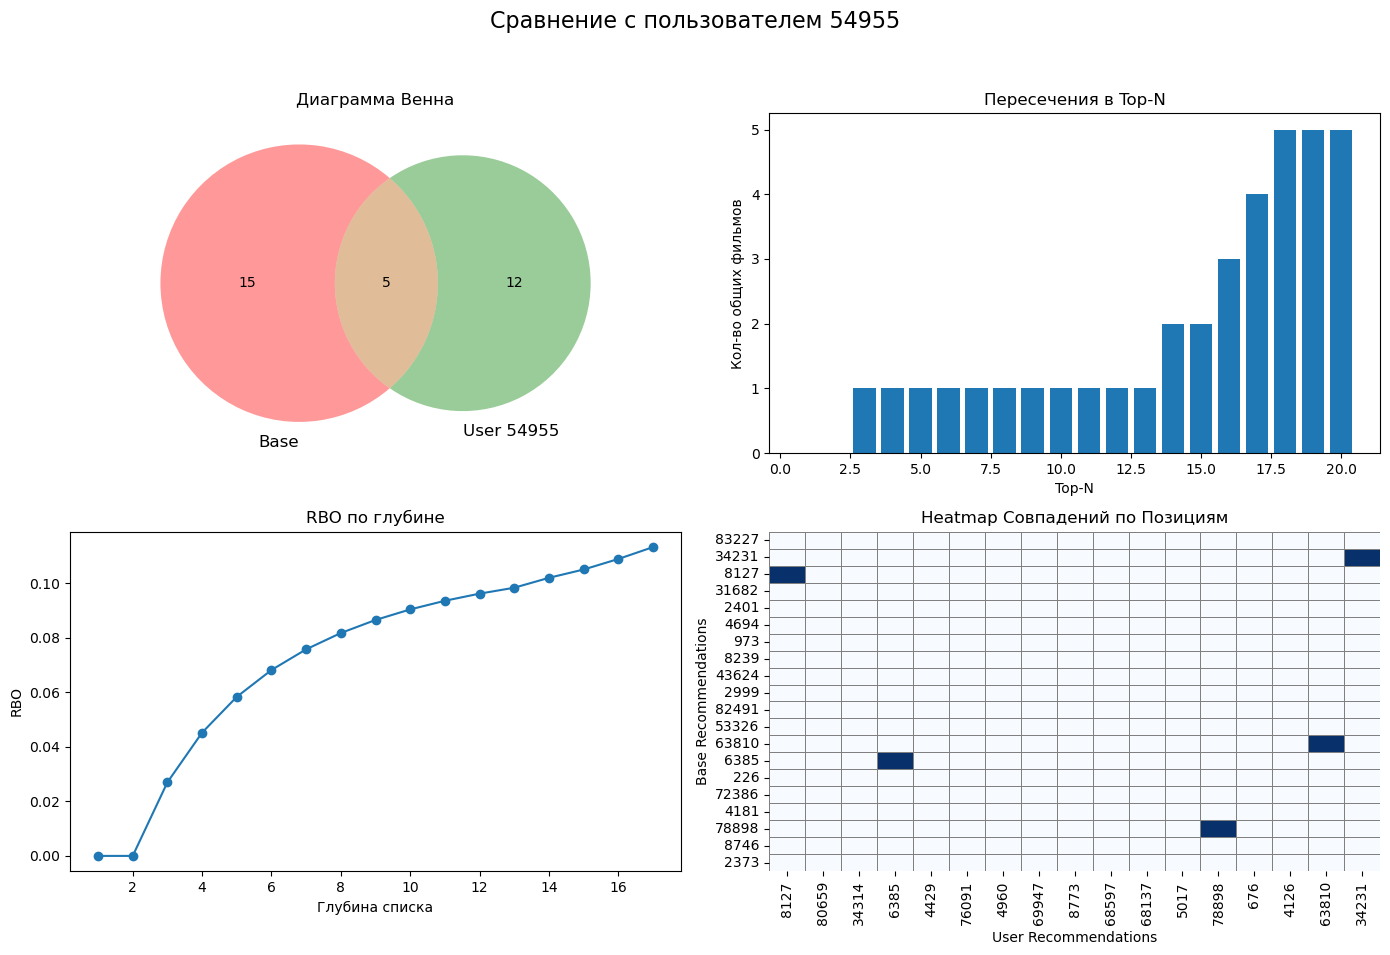


Сравнение с пользователем 144288
Jaccard Similarity: 0.15625
Precision@5: 0.0
Intersection Count: 5
RBO Score: 0.06383726235659358


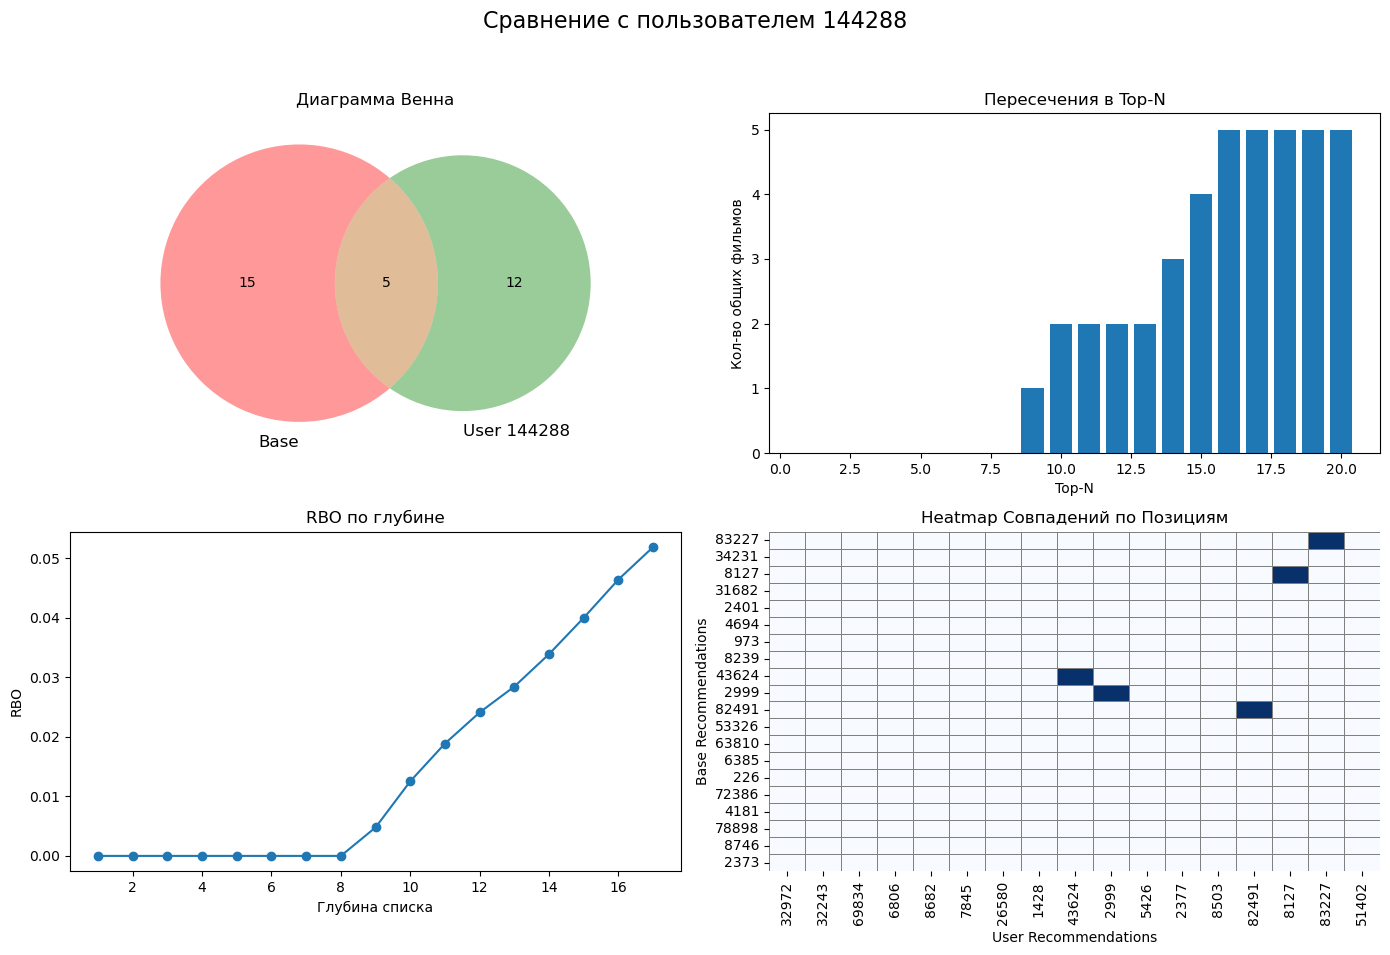


Сравнение с пользователем 75205
Jaccard Similarity: 0.24
Precision@5: 0.0
Intersection Count: 6
RBO Score: 0.13503477093613594


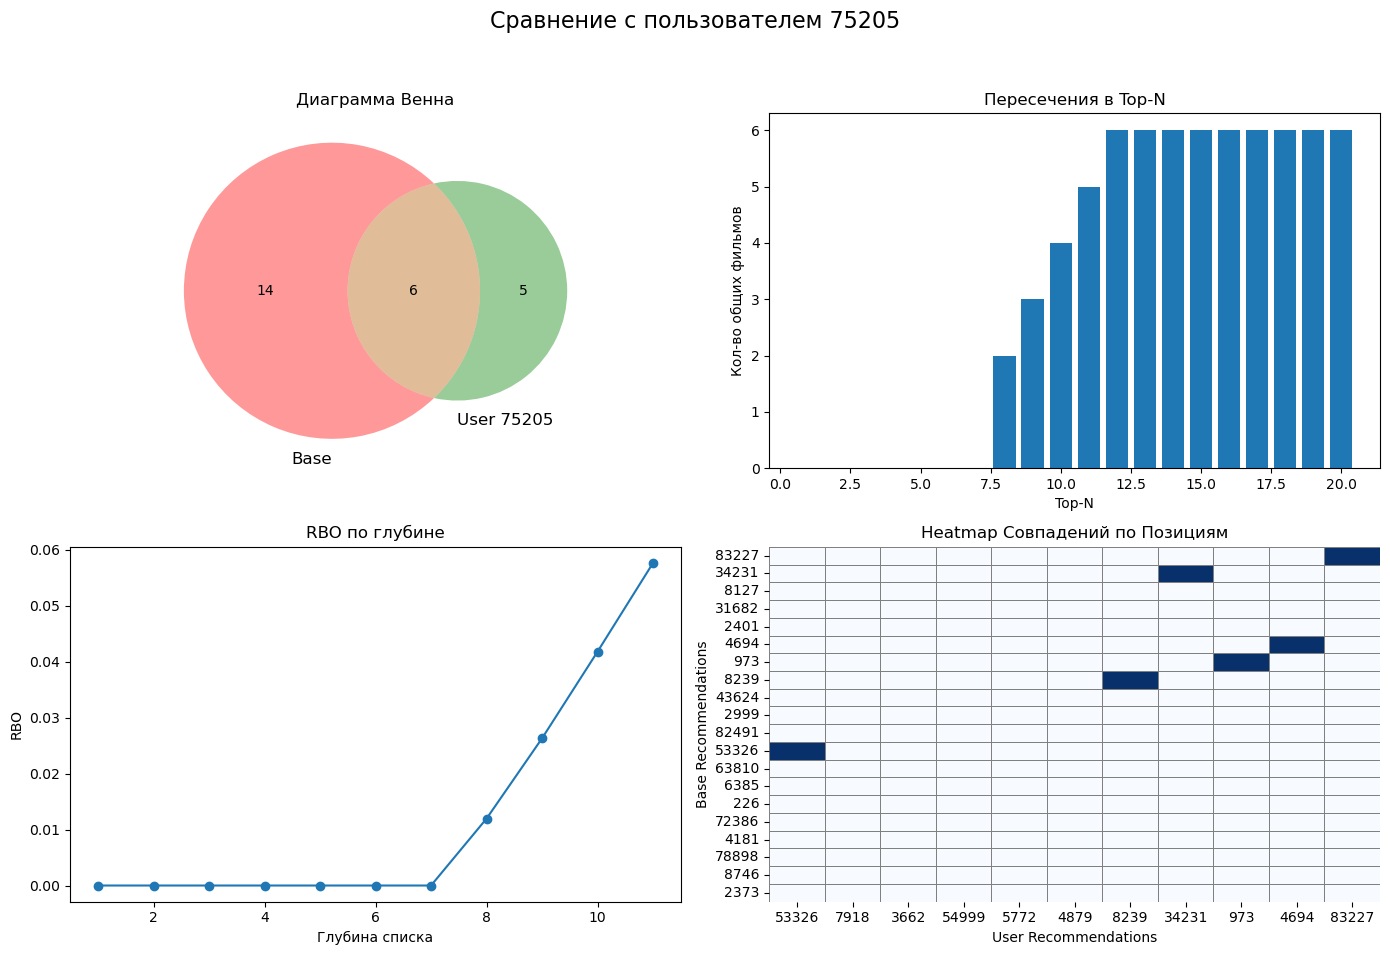


Сравнение с пользователем 141852
Jaccard Similarity: 0.48148148148148145
Precision@5: 0.0
Intersection Count: 13
RBO Score: 0.1504426986958911


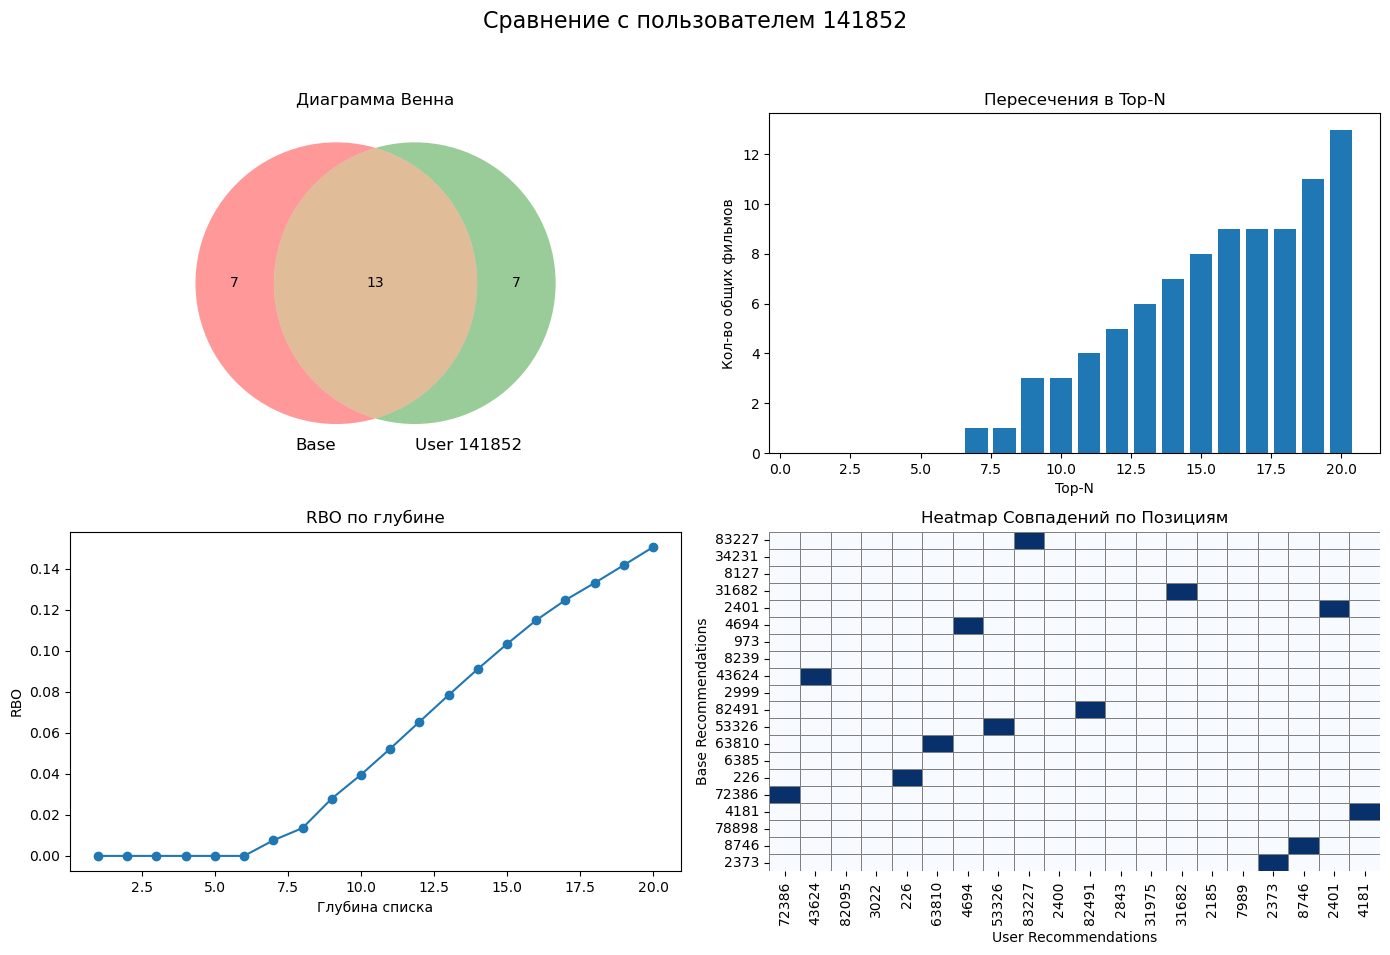


Сравнение с пользователем 1173
Jaccard Similarity: 0.2
Precision@5: 0.2
Intersection Count: 6
RBO Score: 0.14083882652687074


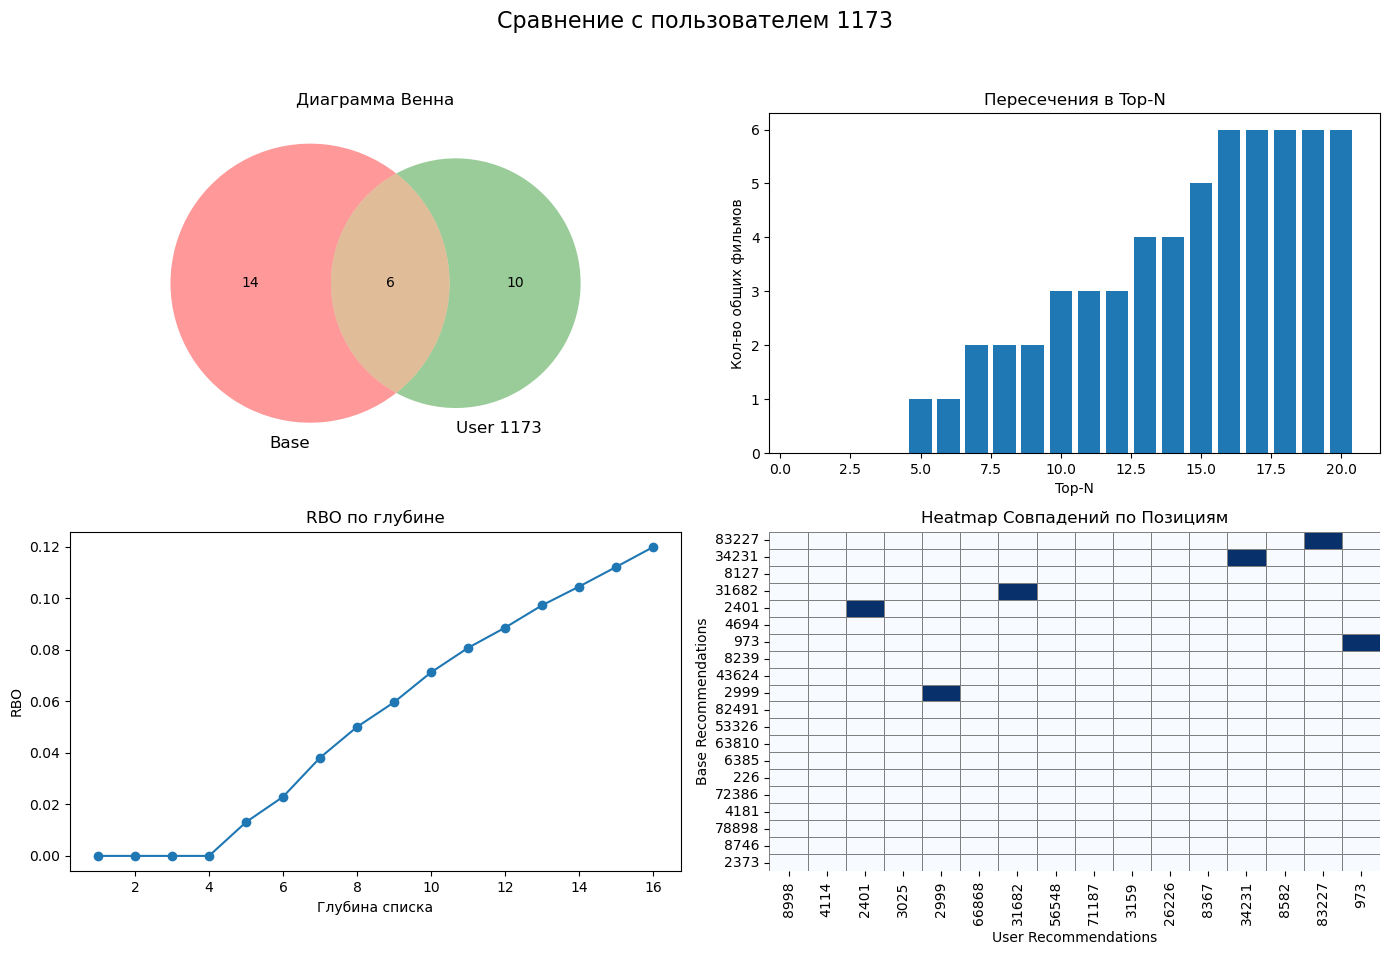

In [88]:
visualize_recommendations(final_df, similar_users_recommendations_df, top_n=20)

## 11.Создаем функцию динамического добавления пользователя: 

In [79]:
def create_synthetic_user_from_existing(base_user_id, ratings, user_encoder, noise_level=0.1):
    """
    Создаёт синтетического пользователя на основе существующего, добавляя шум к его рейтингам.
    Возвращает словарь movie_id -> noisy_rating
    """
    base_user_idx = user_encoder.transform([base_user_id])[0]
    base_ratings = ratings[ratings['user_idx'] == base_user_idx]

    new_user_ratings = {}
    for _, row in base_ratings.iterrows():
        movie_id = row['movieId']
        noisy_rating = min(max(row['rating'] + np.random.normal(0, noise_level), 0.5), 5.0)
        new_user_ratings[movie_id] = noisy_rating

    return new_user_ratings



In [80]:
# функция добавления пользователя
def add_new_user_to_system(user_ratings_dict, item_encoder, model, user_content_vector, device):
    """
    Добавляет нового пользователя по его рейтингам (movie_id -> rating).
    Прогоняет через автоэнкодер, добавляет в user_content_vector.
    Возвращает обновлённый user_content_vector и индекс нового пользователя.
    """
    # Создание разреженного вектора
    num_items = len(item_encoder.classes_)
    new_user_vector = np.zeros(num_items)

    for movie_id, rating in user_ratings_dict.items():
        if movie_id in item_encoder.classes_:
            item_idx = item_encoder.transform([movie_id])[0]
            new_user_vector[item_idx] = rating

    # Преобразуем в torch-тензор и прогоняем через encoder
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(new_user_vector, dtype=torch.float32).to(device)
        encoded_vector = model.encoder(input_tensor).cpu().numpy()

    # Добавим к user_content_vector
    updated_user_content_vector = np.vstack([user_content_vector, encoded_vector])
    new_user_idx = updated_user_content_vector.shape[0] - 1

    return updated_user_content_vector, new_user_idx

In [81]:
new_user_ratings = create_synthetic_user_from_existing(
    base_user_id=1,  # ← здесь ID существующего пользователя, по которому генерим нового
    ratings=ratings,
    user_encoder=user_encoder,
    noise_level=0.1  # уровень шума
)

In [82]:
updated_user_content_vector, new_user_idx = add_new_user_to_system(
    user_ratings_dict=new_user_ratings,
    item_encoder=item_encoder,
    model=model,
    user_content_vector=user_content_vector,
    device=device
)

### Пример рекомендаций уже для новгого/свежего пользователя

In [84]:
final_after_df, similar_users_recommendations_after_df = get_user_recommendations_with_ensemble(
    user_id=new_user_idx,  # уже индекс в user_content_vector
    user_content_vector=updated_user_content_vector,
    user_encoder=user_encoder,
    ratings_csr=ratings_csr,
    kmeans_users=kmeans_users,
    importance_df=importance_df,
    movies_df=movies,
    item_encoder=item_encoder,
    top_n=15,
    num_user=5
)

✅ Найдено 5 похожих пользователей


In [85]:
final_after_df

movie_id                                              title  \
37     34231                         Fighter in the Wind (2004)   
33      8773       Sherlock Holmes and the Secret Weapon (1942)   
28     80659                              Edward, My Son (1949)   
22      6333                            X2: X-Men United (2003)   
34      4126                              Less Than Zero (1987)   
17     63810             When Willie Comes Marching Home (1950)   
36     69947  Game of Death II (a.k.a. Tower of Death) (Si w...   
31     68137                                        Nana (2005)   
27      4960                            Independent, The (2000)   
26      6385                                 Whale Rider (2002)   
25      2393                     Star Trek: Insurrection (1998)   
50     83227                                       L.627 (1992)   
23      4248                     Josie and the Pussycats (2001)   
20      4694                                Left Luggage (1998)   
18     43624                        Here Comes the Groom (1951)   

                              genres  ensemble_score supported_by_users  
37                      Action|Drama               3  [733, 1523, 1157]  
33            Crime|Mystery|Thriller               3  [733, 1523, 1157]  
28                             Drama               3  [733, 1523, 1157]  
22  Action|Adventure|Sci-Fi|Thriller               3  [733, 1523, 1157]  
34                             Drama               3  [733, 1523, 1157]  
17                        Comedy|War               3   [762, 845, 1157]  
36                    Action|Mystery               3  [733, 1523, 1157]  
31                             Drama               2        [733, 1157]  
27                            Comedy               2        [733, 1157]  
26                             Drama               2        [733, 1157]  
25       Action|Drama|Romance|Sci-Fi               2        [733, 1157]  
50              Crime|Drama|Thriller               2        [1523, 733]  
23                            Comedy               2       [1523, 1157]  
20                             Drama               2         [762, 845]  
18            Comedy|Musical|Romance               2         [762, 845]

### Сравним рекомендации пользователя с его ближайшими походими пользователями


Сравнение с пользователем 54955
Jaccard Similarity: 0.05263157894736842
Precision@5: 0.2
Intersection Count: 1
RBO Score: 0.09041639942571428


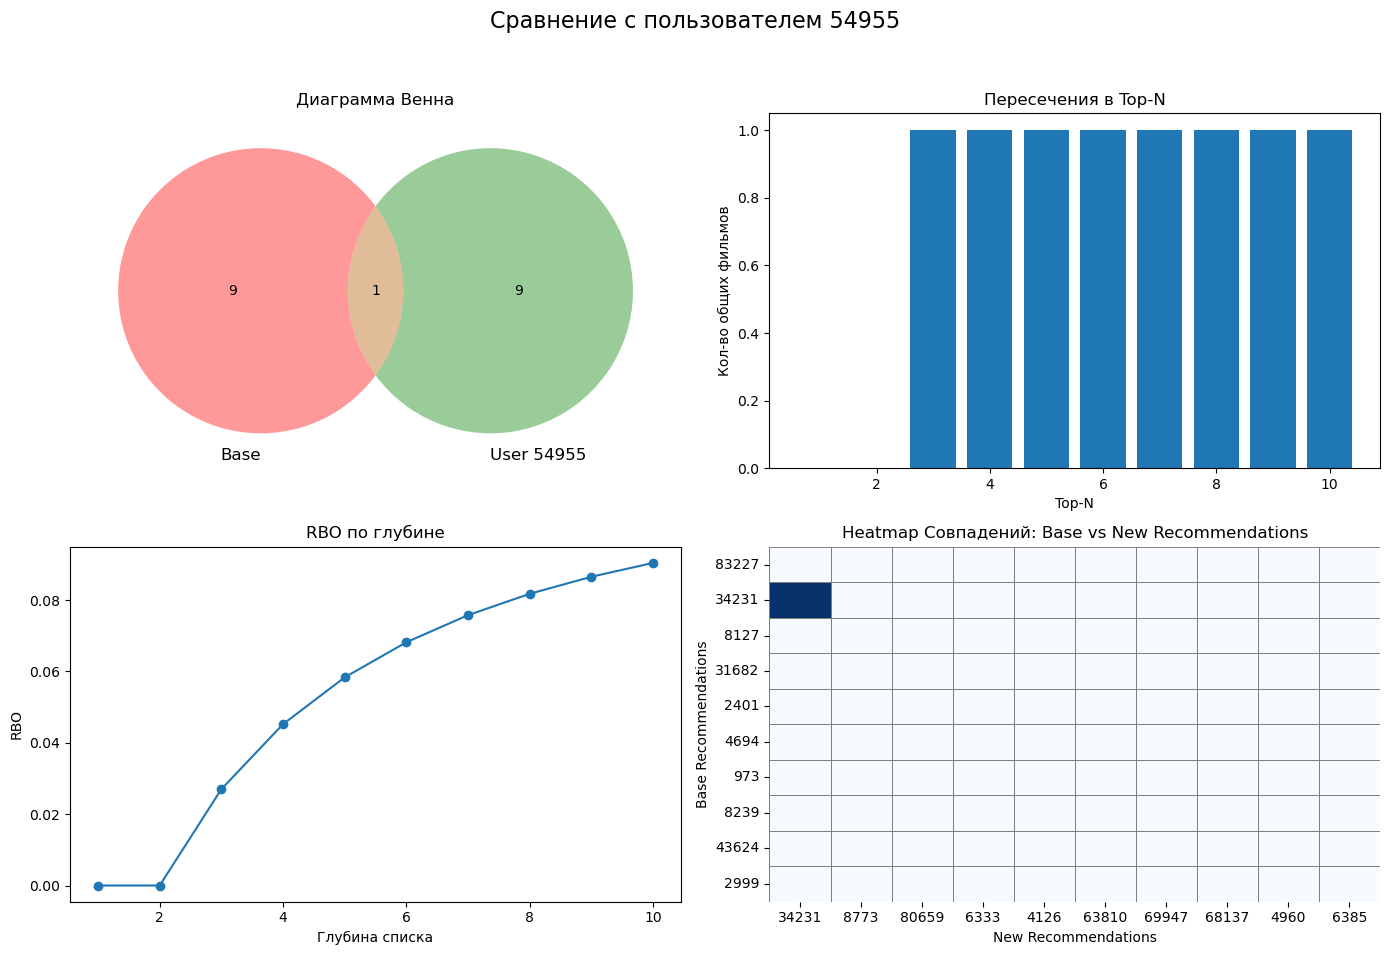


Сравнение с пользователем 144288
Jaccard Similarity: 0.1111111111111111
Precision@5: 0.0
Intersection Count: 2
RBO Score: 0.012531378780000001


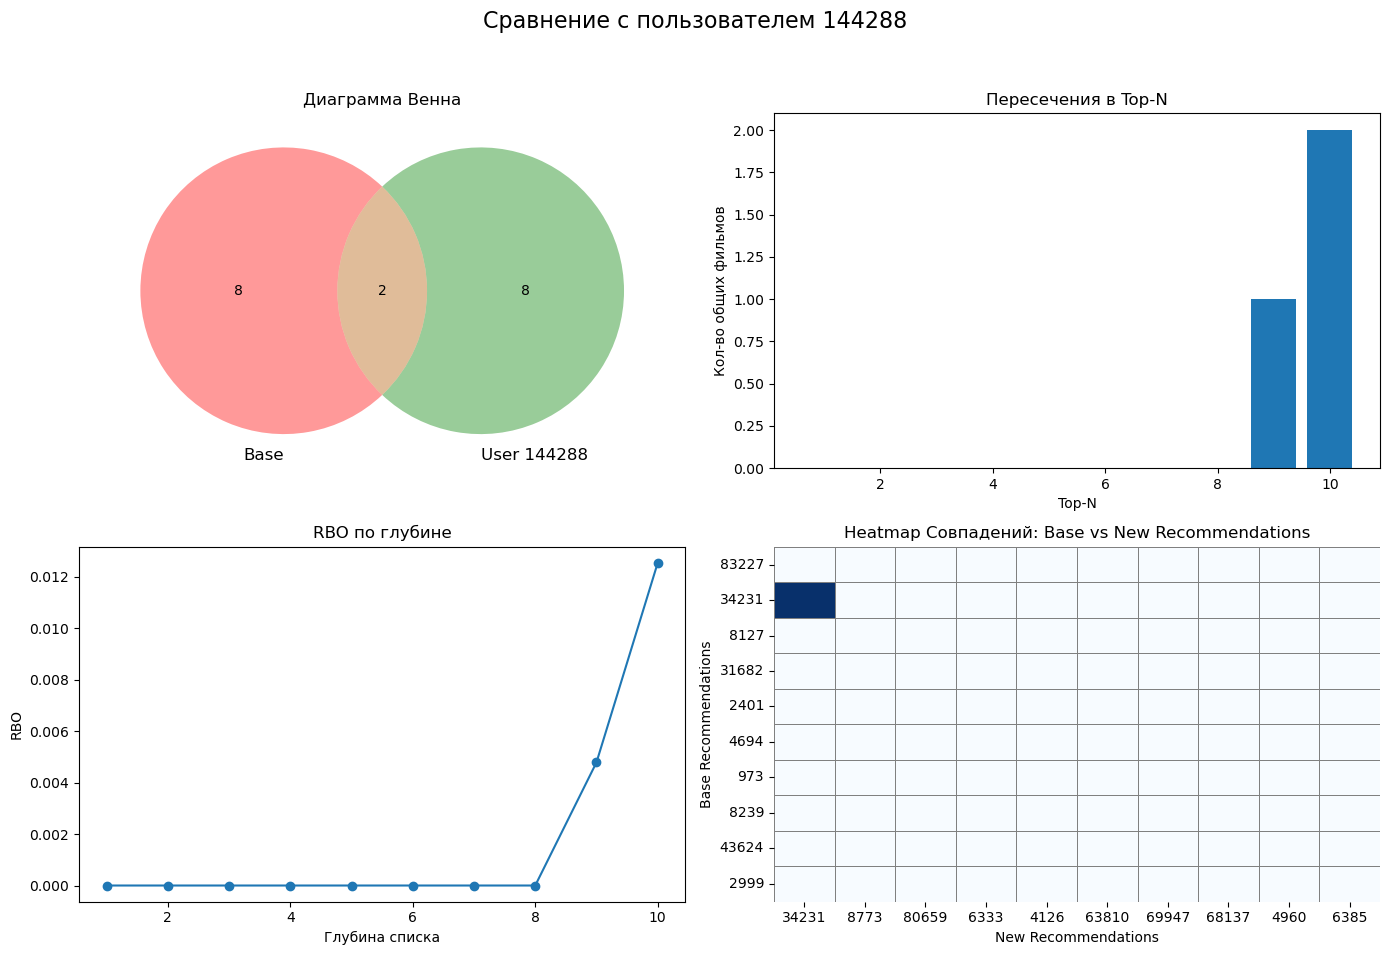


Сравнение с пользователем 75205
Jaccard Similarity: 0.25
Precision@5: 0.0
Intersection Count: 4
RBO Score: 0.04180314906


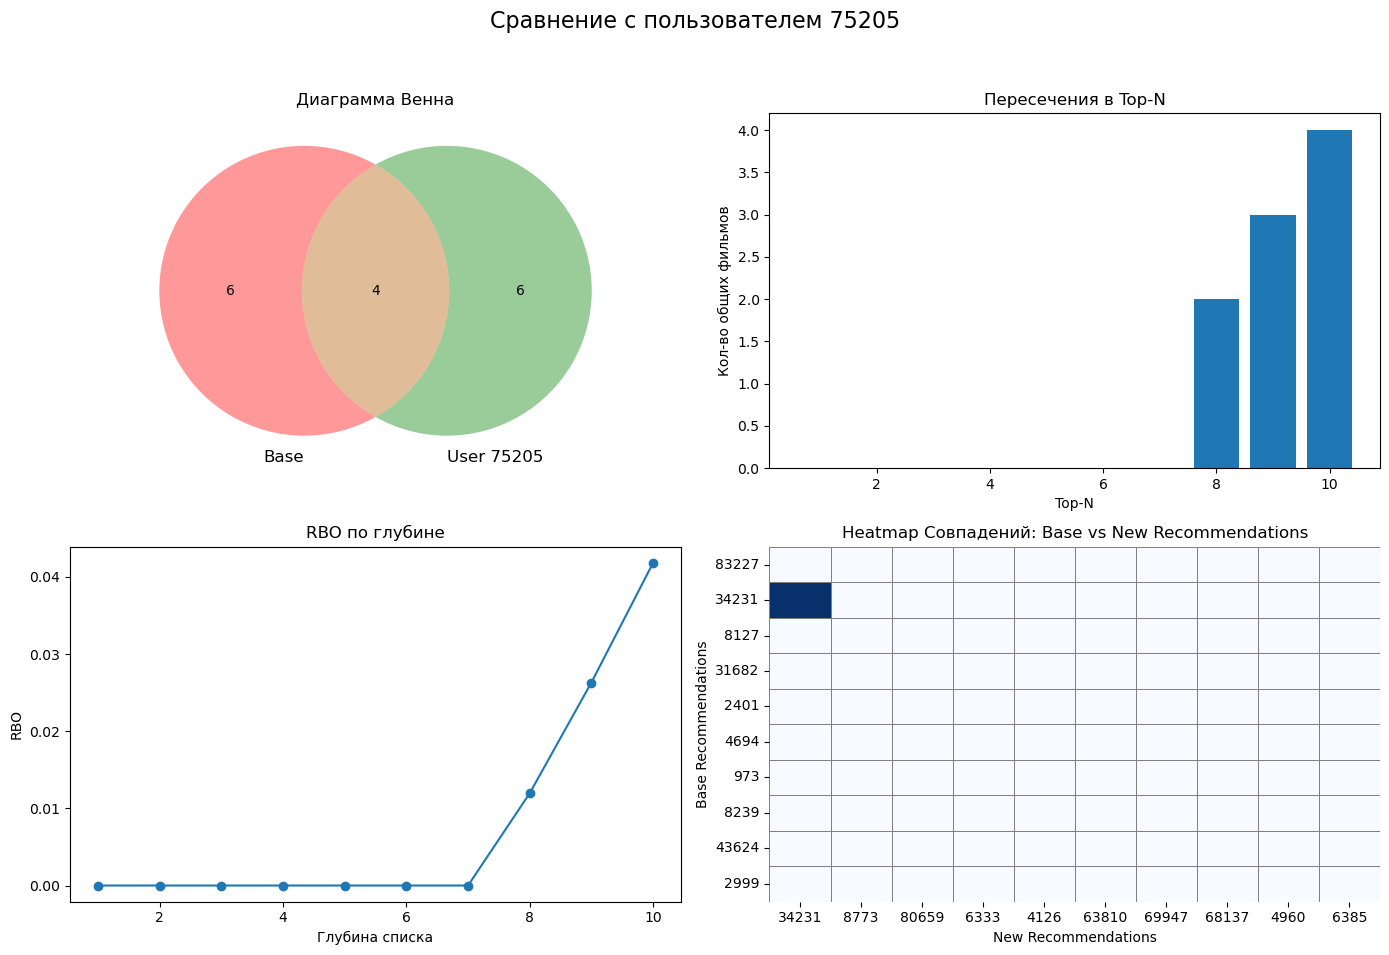


Сравнение с пользователем 141852
Jaccard Similarity: 0.17647058823529413
Precision@5: 0.0
Intersection Count: 3
RBO Score: 0.03954224720571429


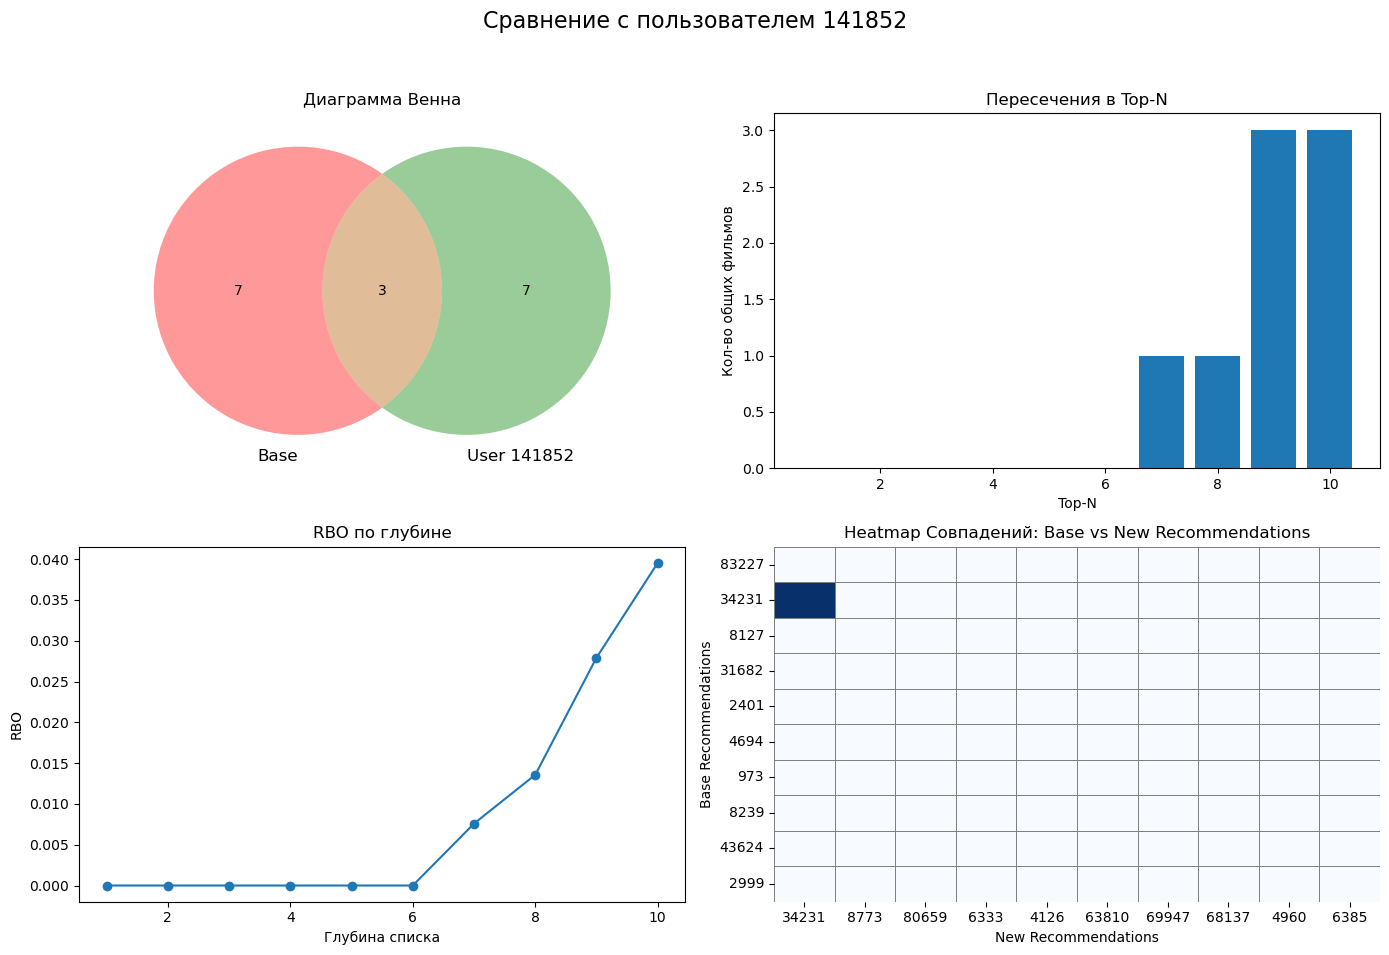


Сравнение с пользователем 1173
Jaccard Similarity: 0.17647058823529413
Precision@5: 0.2
Intersection Count: 3
RBO Score: 0.07129350374142858


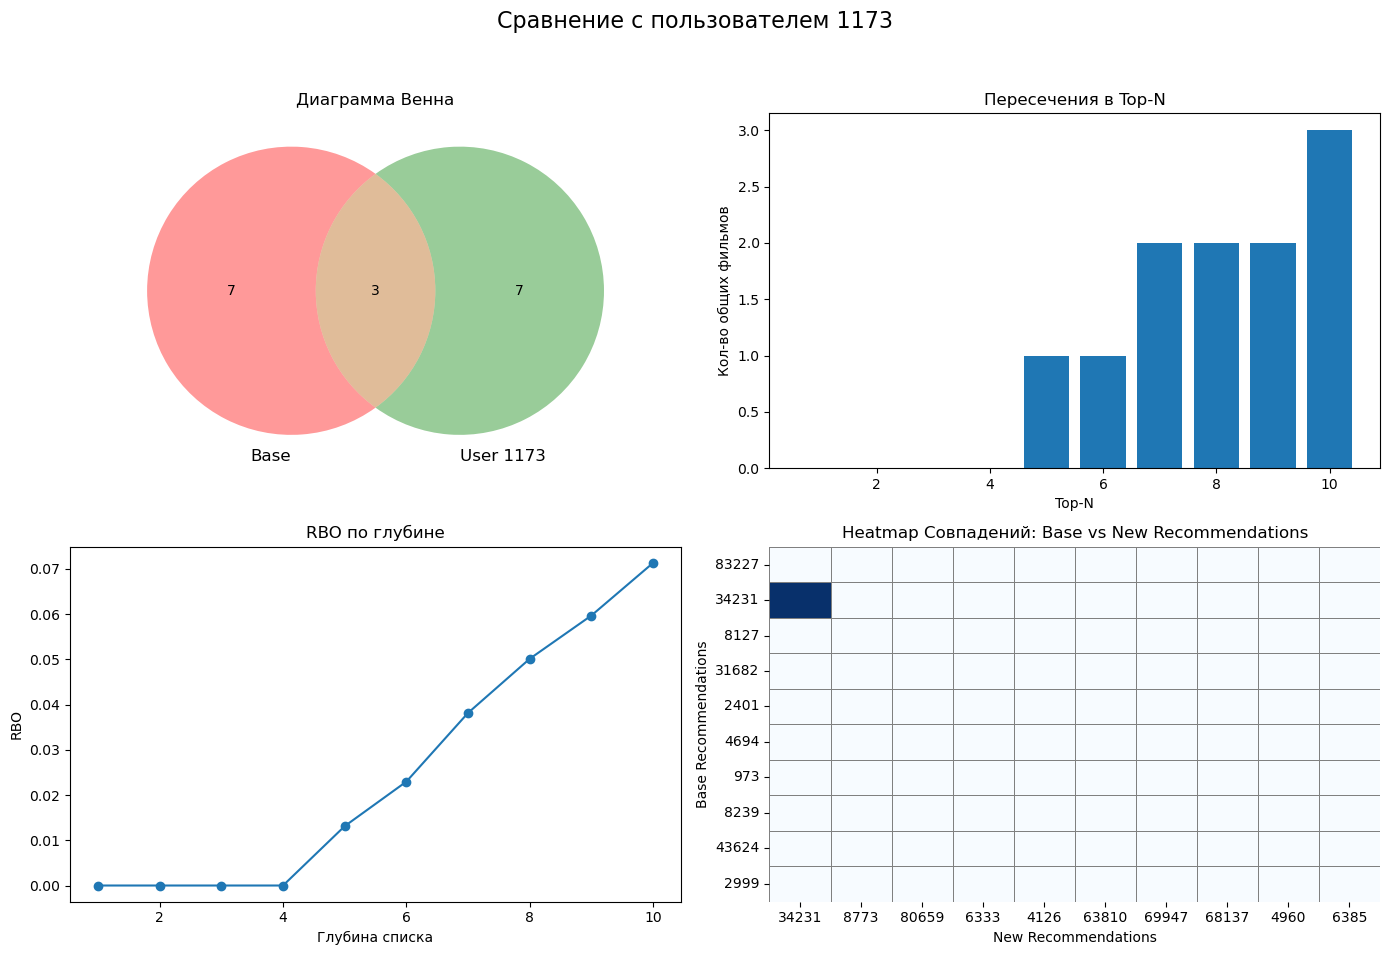

In [91]:
visualize_recommendations(final_df, similar_users_recommendations_df, top_n=10)

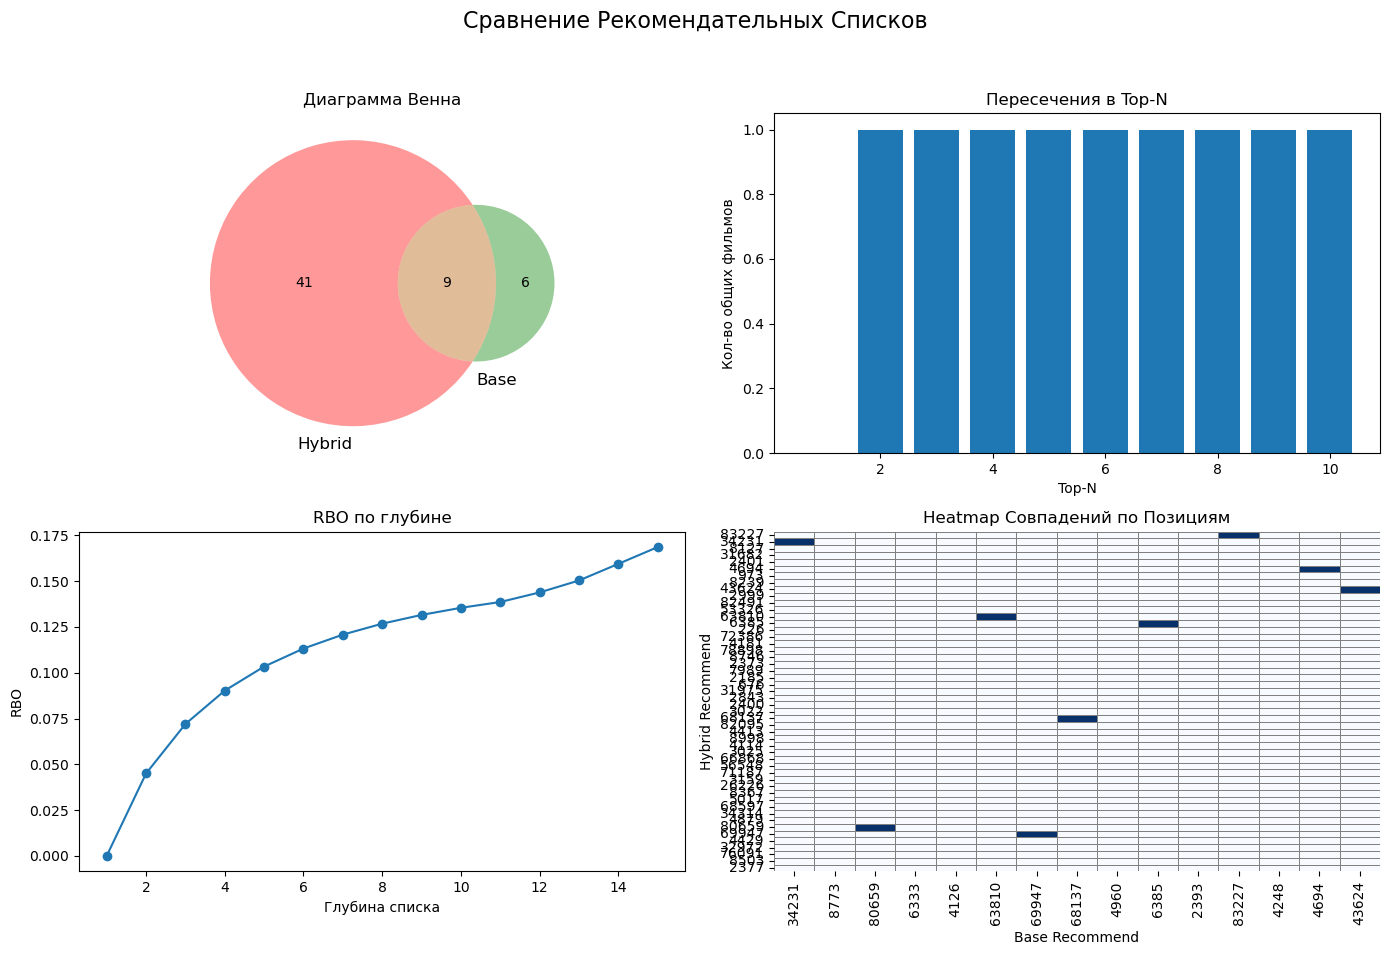

In [93]:
visualize_recommendations_df(final_df,final_after_df)